In [1]:
#import spikeinterface modules
import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw
import numpy as np
import glob

#import everything else
import os
import sys
import numpy as np
import neo
import pandas as pd
import h5py
import McsPy
import sys, importlib, os
import McsPy.McsData
import McsPy.McsCMOS
from McsPy import ureg, Q_
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import seaborn as sns
import itertools

import os
import sys
import numpy as np
import neo
import pandas as pd
import h5py
from hdfviewer.widgets.HDFViewer import HDFViewer
from hdfviewer.widgets.PathSelector import PathSelector
import McsPy
import sys, importlib, os
import McsPy.McsData
import McsPy.McsCMOS
from McsPy import ureg, Q_
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.widgets import Slider
import bokeh.io
import bokeh.plotting
from bokeh.palettes import Spectral11
from scipy.signal import butter, lfilter, freqz, find_peaks, correlate
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import os
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import McsPy
import McsPy.McsData
from McsPy import ureg, Q_
import matplotlib.pyplot as plt
#%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2
#from Butterworth_Filter import butter_bandpass, butter_bandpass_filter
import glob
from quantities import ms, s, Hz
#from elephant.spike_train_generation import homogeneous_poisson_process, homogeneous_gamma_process
import math
from collections import Counter
import scipy

from time import strftime
%matplotlib inline



In [2]:
# helper line -> get different outpaths for sorted datasets; uncheck the date

#191021
#mainpath = 'D:\Files_Reutlingen_Jenny\main_191021'
#outpath = 'D:\Files_Reutlingen_Jenny\main_191021\_output_Spikesorting_30042021_hCSF_adult_20min_spont_spikesorting'
# outpath = 'D:\Files_Reutlingen_Jenny\main_191021\_output_Spikesorting_30042021_hCSF_adult_20min_spont0001_spikesorting'
#outpath = 'D:\Files_Reutlingen_Jenny\main_191021\_output_Spikesorting_30042021_hCSF_child_20min_spont0001_spikesorting'



#191021extra
#mainpath = 'D:\Files_Reutlingen_Jenny\main_191021extra'
#outpath = 'D:\Files_Reutlingen_Jenny\main_191021extra\_output_Spikesorting_19042021_aCSF_adult_15min_spont_spikesorting'
#outpath = 'D:\Files_Reutlingen_Jenny\main_191021extra\_output_Spikesorting_23042021_hCSF_adult_20min_spont0002_spikesorting'
#outpath = 'D:\Files_Reutlingen_Jenny\main_191021extra\_output_Spikesorting_29042021_hCSF_child_20min_spont_spikesorting'


#191017
#mainpath = 'D:\Files_Reutlingen_Jenny\main_191017'
#outpath = 'D:\Files_Reutlingen_Jenny\main_191017\_output_Spikesorting_30042021_spontaneous_spikesorting'



#191023
#mainpath = 'D:\Files_Reutlingen_Jenny\main_191023'
#outpath = 'D:\Files_Reutlingen_Jenny\main_191023\_output_Spikesorting_29042021_spontaneous_DNQX_AP5_washin_spikesorting'
#outpath = 'D:\Files_Reutlingen_Jenny\main_191023\_output_Spikesorting_29042021_spontaneous_DNQX_AP5_washin0001_spikesorting'
#outpath = 'D:\Files_Reutlingen_Jenny\main_191023\_output_Spikesorting_29042021_spontaneous_hCSF_afterDNQX_AP5_washin_spikesorting'
#outpath = 'D:\Files_Reutlingen_Jenny\main_191023\_output_Spikesorting_29042021_spontaneous_spikesorting'

#aachen 15.05.2021
mainpath = r'D:\MEA_DATA_Aachen\ANALYZED\20210510_cortex_div4'
outpath = r'D:\MEA_DATA_Aachen\ANALYZED\20210510_cortex_div4\_output_Spikesorting_07062021_cortex_div4_hCSF_ID039_nodrug_spont_1_spikesorting'





labeldic =  np.load(
    'D:\Files_Reutlingen_Jenny\_layerdictionaries\labeldictionary_MCS_256MEA.npy', 
    allow_pickle='TRUE').item() 

In [3]:
os.chdir(mainpath)
folderlist = glob.glob('*_output_Spikesorting*spikesorting*')

In [4]:
# loading functions

def load_dumped_subrecordings(directory, filebase):

    subrecording_dic = {}
    filelist = glob.glob('*recording.pkl')
    for file in filelist:
        key = file.split(filebase)[1].split('.')[0].split('_recording')[0]
        subrecording_dic[key]=se.load_extractor_from_pickle(file)
        
    return subrecording_dic
        
    
def load_dumped_sorted_dic(outpath):

    sorted_dic = {}
    filelist = glob.glob('*sorted*')
    for file in filelist:
        key = file.split('sorted_')[1]
        sorted_dic[key]=se.SpykingCircusSortingExtractor(file)
        
    return sorted_dic


# function to get the filebase from folder
def get_filebase_from_foldername(mainpath_folder):
    
    separator = '_'
    filebase = separator.join(mainpath_folder.split('\\')[-1].split('_')[4:-1])
    
    return filebase




def get_dictionary_keys(outpath_folder):

    dictkeys = []
    os.chdir(outpath_folder)
    folders_sorting = glob.glob('*sorted*')
    for i in folders_sorting:
        dk = i.split('sorted_')[1]
        dictkeys.append(dk)
    
    return dictkeys, print('Dictkeys are %s. Your CWD may have changed. Please check.' %dictkeys)



# function to convert basic information to dataframe
def units_to_pandas_DataFrame(sorted_dic, recording_cache, dictkey, layerdic_invert, recordingdate='not given'):
    
    # creates pandas DataFrame only including the unit ids. the order will be confused because of the unit numbering ('1' instead of '001')
    unit_ids = sorted_dic[dictkey].get_unit_ids()
    unitframe = pd.DataFrame(
        sorted_dic[dictkey].get_unit_ids(), 
        columns=['unit_ids']
        )
    
    
    list_not_empty_spiketrains = []
    for i in unit_ids:
        st_len = len(sorted_dic[dictkey].get_unit_spike_train(unit_id=i))
        if st_len > 0:
            list_not_empty_spiketrains.append(i)
    
    
    # calculate as many paramters as possible outside of the loop
    recordings_seconds = recording_cache[dictkey].get_num_frames()/recording_cache[dictkey].get_sampling_frequency()
        
    for i in list_not_empty_spiketrains:  
        
        # add channel with maximum amplitude
        unitframe.loc[(unitframe['unit_ids']==i), 'max_channel']=st.postprocessing.get_unit_max_channels(
            recording_cache[dictkey], sorted_dic[dictkey], unit_ids=[i]
            )
        
        unitframe.loc[(unitframe['unit_ids']==i), 'unit_index']=unitframe.loc[(unitframe['unit_ids']==i)].index
    
        # get the channel label as on MCS MEA 256 chips
        max_channel = int(unitframe.loc[(unitframe['unit_ids']==i)]['max_channel'])
        unitframe.loc[(unitframe['unit_ids']==i), 'channellabel']= labeldic[max_channel]
        
        # get the number of spiks per unit
        unitframe.loc[(unitframe['unit_ids']==i), 'n_spikes']=len(sorted_dic[dictkey].get_unit_spike_train(unit_id=i))
        
        # add firing rate
        unitframe.loc[(unitframe['unit_ids']==i), 'firing_rate']= unitframe.loc[(unitframe['unit_ids']==i)]['n_spikes']/recordings_seconds
        
        # add layer
        labelkey = unitframe.loc[(unitframe['unit_ids']==i), 'channellabel'].values[0]
        unitframe.loc[(unitframe['unit_ids']==i), 'layer']= layerdic_invert[labelkey]
        
       
        unitframe.loc[(unitframe['unit_ids']==i), 'file']=filebase
        unitframe.loc[(unitframe['unit_ids']==i), 'subrecording']=dictkey
        unitframe.loc[(unitframe['unit_ids']==i), 'recordingdate']=recordingdate
        # verify if this line works
        #unitframe.loc[(unitframe['unit_ids']==i), 'medium']=unitframe.loc[(unitframe['unit_ids']==i)]['file'].split('_')[0]
        
    return unitframe




def invert_layerdic(layer_dic):
    
    '''
    Expects a dictionary with key = layer, value = list of channellabels
    
    Returns a dictionary with key = channellabels, value = layer
    '''
    layerdic_invert = {}

    for key in layerdic:
        for i in layerdic[key]:
            layerdic_invert[i]=key
            
            
    return layerdic_invert
    

In [5]:
# get a filebaselist for every folder in the mainpath, that we we can filter 

filebase_list = []
for i in folderlist:
    filebase = get_filebase_from_foldername(i)
    filebase_list.append(filebase)

In [6]:
os.chdir(outpath)

In [7]:
completeframe = pd.read_pickle(str('DF_' + filebase + '_' + 'complete') + '_df.pkl')

In [227]:
completeframe['unit_ids2'] = completeframe['unit_ids']

In [8]:
completeframe

unit_ids  unit_index  max_channel channellabel  n_spikes  firing_rate  \
0           0         0.0          2.0          O10      20.0     0.153846   
1           1         1.0          2.0          O10     160.0     1.230770   
2          10         2.0         53.0           H4     102.0     0.784616   
3         100         3.0        141.0          E12     535.0     4.115386   
4         101         4.0        104.0           M7     328.0     2.523078   
..        ...         ...          ...          ...       ...          ...   
597        95       597.0         64.0          R14     492.0     3.784617   
598        96       598.0         64.0          R14     217.0     1.669231   
599        97       599.0        104.0           M7      12.0     0.092308   
600        98       600.0        104.0           M7     552.0     4.246155   
601        99       601.0        104.0           M7     263.0     2.023078   

        layer  ft_peak_to_valley  ft_halfwidth  ft_peak_trough_ratio  \
0    layer2-3            0.00080       0.00028             -0.436335   
1    layer2-3            0.00096       0.00040             -0.198452   
2    layer5-6            0.00104       0.00040             -0.290054   
3    layer5-6            0.00032       0.00032             -0.232855   
4      layer4            0.00132       0.00596              0.440375   
..        ...                ...           ...                   ...   
597  layer2-3            0.00076       0.00028             -0.309199   
598  layer2-3            0.00168       0.00060             -0.271205   
599    layer4            0.00336       0.00596              0.410484   
600    layer4            0.00344       0.00504              0.371611   
601    layer4            0.00152       0.00596              0.753285   

     ft_repolarization_slope  ft_recovery_slope  \
0                   0.049073          -0.008003   
1                   0.040606          -0.001736   
2                   0.034879          -0.005049   
3                   0.096708          -0.002211   
4                        NaN          -0.012390   
..                       ...                ...   
597                 0.050463          -0.008118   
598                 0.033614          -0.002895   
599                      NaN          -0.012281   
600                      NaN          -0.000699   
601                      NaN          -0.009628   

                                      file subrecording recordingdate  
0    cortex_div4_hCSF_ID039_nodrug_spont_1    sec_0-130      20210510  
1    cortex_div4_hCSF_ID039_nodrug_spont_1    sec_0-130      20210510  
2    cortex_div4_hCSF_ID039_nodrug_spont_1    sec_0-130      20210510  
3    cortex_div4_hCSF_ID039_nodrug_spont_1    sec_0-130      20210510  
4    cortex_div4_hCSF_ID039_nodrug_spont_1    sec_0-130      20210510  
..                                     ...          ...           ...  
597  cortex_div4_hCSF_ID039_nodrug_spont_1    sec_0-130      20210510  
598  cortex_div4_hCSF_ID039_nodrug_spont_1    sec_0-130      20210510  
599  cortex_div4_hCSF_ID039_nodrug_spont_1    sec_0-130      20210510  
600  cortex_div4_hCSF_ID039_nodrug_spont_1    sec_0-130      20210510  
601  cortex_div4_hCSF_ID039_nodrug_spont_1    sec_0-130      20210510  

[602 rows x 15 columns]

In [9]:
# load spiketrains
st_channel = np.load(filebase+'_spiketrains_per_channel.npy', allow_pickle='TRUE').item()
st_neurons = np.load(filebase+'_spiketrains_per_unit.npy', allow_pickle='TRUE').item()
st_channels_neurons = np.load(filebase+'_spiketrains_nested_per_channel_per_unit.npy', allow_pickle='TRUE').item()

# old functions from ISI Burst Detection

In [10]:
def create_bins(lower_bound, width, quantity):
    """ create_bins returns an equal-width (distance) partitioning. 
        It returns an ascending list of tuples, representing the intervals.
        A tuple bins[i], i.e. (bins[i][0], bins[i][1])  with i > 0 
        and i < quantity, satisfies the following conditions:
            (1) bins[i][0] + width == bins[i][1]
            (2) bins[i-1][0] + width == bins[i][0] and
                bins[i-1][1] + width == bins[i][1]
    """
    

    bins = []
    for low in range(lower_bound, 
                     lower_bound + quantity*width + 1, width):
        bins.append((low, low+width))
    return bins


def find_bin(value, bins):
    """ bins is a list of tuples, like [(0,20), (20, 40), (40, 60)],
        binning returns the smallest index i of bins so that
        bin[i][0] <= value < bin[i][1]
    """
    
    for i in range(0, len(bins)):
        if bins[i][0] <= value < bins[i][1]:
            return i
    return -1



def find_binned_spikes(data, bins):
    '''
    Parameters
    ----------
    data : for network spike binning --> expects an 1D array with all spikes detected for the network
    bins : list of tuples of expected bins

    Returns
    -------
    binlist : list of lists where lists contain all spikes for the respective bins

    '''
    binlist =[]
    binspike =[]
    for i in range(0, len(bins)):
        binspike = []
        for a in data:    
            if bins[i][0] <= a < bins[i][1]:
                binspike.append(a)
        binlist.append(binspike)
            
    return binlist




def get_isi_singlechannel(spikedic, tick):
    '''
    Parameters
    ----------
    spikedic : dictionary with all detected spikes for a channel
        DESCRIPTION.

    Returns
    -------
    isidic : keys = channels, values = List of tuples where tuple[0]=detected spike and tuple[1]=isi to the next detected spike
    isi_alone_dic : keys = channels, values = list of isi alone
    CAVE returns are in microseconds
    '''
    
    isidic ={}     
    isilist = []
    isi_alone_dic = {}
    isislist =[]

    for key in spikedic:
        isilist = []
        isislist = []
        if len(spikedic[key])>=2:
            for i in range(0, (len(spikedic[key])-1)):
                isi = spikedic[key][i]*tick, (spikedic[key][i+1]-spikedic[key][i])*tick #CL tick für beide dazu
                isi_alone = (spikedic[key][i+1]-spikedic[key][i])*tick
                isilist.append(isi)
                isislist.append(isi_alone)
        isidic[key]=isilist
        isi_alone_dic[key]=isislist
        
    return isidic, isi_alone_dic



def bin_isi(isi_alone_dic, binsize, binmax=bool, binmaxnumber=None):
    '''

    Parameters
    ----------
    isi_alone_dic : dic
        dictionary with all ISI for every channel
    binsize: int
        expects int in microseconds that defines bin-width
    Returns
    -------
    histo_ISI_dic:
        dic with key:channellabel, value: list with bincounts per bin

    '''
    isi_bins = []
    isi_bins_list = []
    isi_bin_count = []
    histo_ISI_dic = {}
    for key in isi_alone_dic:
        if binmax==True:
            isi_bin_count=[]
            isibins=create_bins(0, binsize, binmaxnumber)
            isi_bins_list=[] 
            for i in range(0, len(isibins)):
                isi_bins=[]
                for a in isi_alone_dic[key]:
                    if isibins[i][0] <= a < isibins[i][1]:
                        isi_bins.append(a)
                isi_bins_list.append(isi_bins)
            for i in range(0, (len(isi_bins_list)-1)):
                isi_bin_count.append(len(isi_bins_list[i]))
            histo_ISI_dic[key]=isi_bin_count
        #else:
            # noch schreiben für variable maximalnummer an bins
            
    return histo_ISI_dic


def bin_lnisi(isi_alone_dic, start_in_microseconds, stop_in_microseconds, totalbins, binmax):
    '''

    Parameters
    ----------
    isi_alone_dic : dic
        dictionary with all ISI for every channel 
    binsize: int
        expects int in microseconds that defines bin-width
    Returns
    -------
    histo_ISI_dic:
        dic with key:channellabel, value: list with bincounts per logarithmic spaced bins

    '''
    isi_bins = []
    isi_bins_list = []
    isi_bin_count = []
    histo_ln_ISI_dic = {}
    for key in isi_alone_dic:
        if binmax==True:
            isi_bin_count=[]
            isibins=create_ln_bins(start_in_microseconds, stop_in_microseconds, totalbins)
            isi_bins_list=[] 
            for i in range(0, len(isibins)):
                isi_bins=[]
                for a in isi_alone_dic[key]:
                    if isibins[i][0] <= a < isibins[i][1]:
                        isi_bins.append(a)
                isi_bins_list.append(isi_bins)
            for i in range(0, (len(isi_bins_list)-1)):
                isi_bin_count.append(len(isi_bins_list[i]))
            histo_ln_ISI_dic[key]=isi_bin_count
        #else:
            # noch schreiben für variable maximalnummer an bins
            
    return histo_ln_ISI_dic, isibins


def get_allchannel_ISI_bins(histo_ISI_dic):
    '''
    Parameters
    ----------
    histo_ISI_dic : dic mit den einzelnen ISI für jeden Channel. Cave, die Values müssen alle die gleiche
                    Länge haben, sonst funktioniert die zip Funktion nicht.
        DESCRIPTION.

    Returns
    -------
    network_ISI_binned = array of all ISI of the whole network binned

    '''
    network_ISI = []
    for key in histo_ISI_dic:
        list1 = histo_ISI_dic[key]
        if len(list1)>len(network_ISI):
            network_ISI=list1
        else:
            list2 = network_ISI
            network_ISI = [a + b for a, b in zip(list1, list2)]
    return np.array(network_ISI)


def get_burst_threshold(df_with_CMA):
    '''
    

    Parameters
    ----------
    df_with_CMA : TYPE
        DESCRIPTION.

    Returns
    -------
    CMAalpha : TYPE
        DESCRIPTION.
    CMAalpha2 : TYPE
        DESCRIPTION.
    maxCMA : TYPE
        DESCRIPTION.
    alpha1 : TYPE
        DESCRIPTION.
    alpha2 : TYPE
        DESCRIPTION.

    '''
    
    networkburstthreshold_ISI = 200000 #wie im paper maximal bei 200 ms als isi
    skewness = scipy.stats.skew(network_ISI)
    if skewness < 1:
        alpha1 = 1
        alpha2 = 0.5
    elif skewness >= 1 and skewness <4:
        alpha1 = 0.7
        alpha2 = 0.3
    elif skewness >=4 and skewness <9:
        alpha1 = 0.5
        alpha2 = 0.3
    elif skewness >=9:
        alpha1 = 0.3
        alpha2 = 0.1
    maxCMA = max(df_with_CMA['CMA'])
    CMAalpha = maxCMA*alpha1
    CMAalpha2 = maxCMA*alpha2
    return CMAalpha, CMAalpha2, maxCMA, alpha1, alpha2


def ISI_threshold_min(df_with_CMA, CMAalpha, CMAalpha2, binsize_in_micros):
    '''
    '''
    indexfactor = df[df['CMA']>CMAalpha].index[-1] + 1
    indexfactor2 = df[df['CMA']>CMAalpha2].index[-1] + 1
    threshold_intraburst = float(indexfactor*binsize_in_micros)
    threshold_burst_related = float(indexfactor2*binsize_in_micros)
    
    return threshold_intraburst, threshold_burst_related


def find_burst_starts(isi_alone, threshold_intraburst, spikedic):
    '''
    Parameters
    ----------
    isi_alone : TYPE
        DESCRIPTION.
    threshold_intraburst : TYPE
        DESCRIPTION.
    spikedic : TYPE
        DESCRIPTION.

    Returns
    -------
    None.

    '''
    burststartdic = {}
    noburstlist = []
    #burststartlist = []
    for key in isi_alone:
        print(key)
        if len(isi_alone[key])<3:
            noburstlist.append(isi_alone[key])
        burststartlist=[]
        counter = 0
        while counter < (len(isi_alone[key])-4):
            setter = 0
            if isi_alone[key][counter]<threshold_intraburst:
                setter +=1
                if isi_alone[key][counter+setter] < threshold_intraburst:
                    setter +=1
                    if isi_alone[key][counter+setter] < threshold_intraburst:
                        burststartlist.append((spikedic[key][counter])*tick) #CL: zusätzlich times tick to get all timestamps in ms
                        setter += 1
                        while isi_alone[key][counter+setter]<threshold_intraburst and (counter+setter)< (len(isi_alone[key])-4):
                            setter +=1
                            print('burst '+str(setter))
                        setter +=1
                    else:
                        counter +=1
                else:
                    counter +=1
                counter = counter + setter + 1
            else:
                counter +=1
            print(str(key) + str(counter))
        burststartdic[key]=burststartlist
        
    return burststartdic   


def find_burst_starts_and_length(isi_alone, threshold_intraburst, spikedic):
    '''
    Parameters
    ----------
    isi_alone : TYPE
        DESCRIPTION.
    threshold_intraburst : TYPE
        DESCRIPTION.
    spikedic : TYPE
        DESCRIPTION.

    Returns
    -------
    None.

    '''
    burststartdic = {}
    noburstlist = []
    #burststartlist = []
    for key in isi_alone:
        print(key)
        if len(isi_alone[key])<3:
            noburstlist.append(isi_alone[key])
        burststartlist=[]
        counter = 0
        while counter < (len(isi_alone[key])-4):
            setter = 0
            if isi_alone[key][counter]<threshold_intraburst:
                setter +=1
                if isi_alone[key][counter+setter] < threshold_intraburst:
                    setter +=1
                    if isi_alone[key][counter+setter] < threshold_intraburst:
                        burststart_spike = spikedic[key][counter]*tick
                        burstend_spike = spikedic[key][counter+setter]*tick
                        #burststartlist.append((spikedic[key][counter])*tick) #CL: zusätzlich times tick to get all timestamps in ms
                        setter += 1
                        while isi_alone[key][counter+setter]<threshold_intraburst and (counter+setter)< (len(isi_alone[key])-4):
                            setter +=1
                            burstend_spike = spikedic[key][counter+setter]*tick
                            print('burst '+str(setter))
                        burststartlist.append((burststart_spike, burstend_spike))
                        setter +=1
                    else:
                        counter +=1
                else:
                    counter +=1
                counter = counter + setter + 1
            else:
                counter +=1
            print(str(key) + str(counter))
        burststartdic[key]=burststartlist
        
    return burststartdic   


# trial of burst detection

In [11]:
tick = 40
scale_factor_for_second = 1e-06

In [20]:
isidic, isi_alone = get_isi_singlechannel(st_channel, tick) #creates two dictionaries
histo_ISI_dic=bin_isi(isi_alone, binsize=1000, binmax=True, binmaxnumber=600) # dictionary für jeden channel mit 300x 10ms bins (binsize) und der Menge an ISI für die jeweilige Länge
network_ISI=get_allchannel_ISI_bins(histo_ISI_dic) #gibt ein array mit bins entsprechend der bins aus der Vorfunktion


(array([164., 131.,  74.,  44.,  37.,  22.,  21.,  16.,   5.,  14.,   5.,
          5.,   4.,   6.,   4.,   2.,   3.,   4.,   1.,   2.,   1.,   2.,
          4.,   0.,   1.,   2.,   2.,   0.,   0.,   1.,   2.,   1.,   0.,
          0.,   1.,   0.,   1.,   0.,   0.,   1.,   1.,   0.,   1.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 

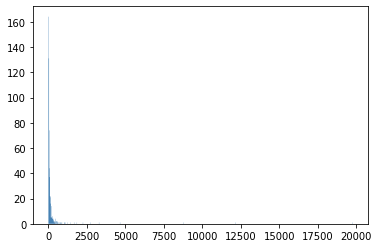

In [21]:
plt.hist(network_ISI, bins=1000, histtype='stepfilled', color='steelblue',edgecolor='none')


In [22]:
colors = ['green', 'blue', 'orange', 'purple']

<AxesSubplot:title={'center':'Histogram of ISI-bins 10ms whole network'}>

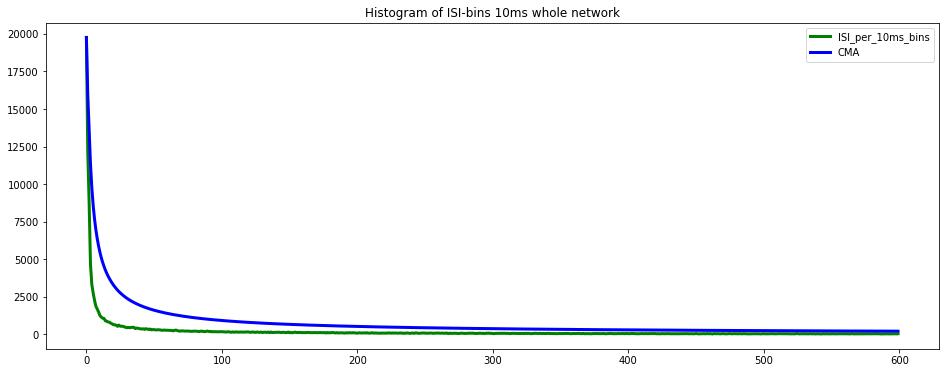

In [23]:
df= pd.DataFrame({'ISI_per_10ms_bins':network_ISI}) #aus Network_ISI wird ein pdDF um die weiteren Schritte durchführen zu können
df["CMA"] = df.ISI_per_10ms_bins.expanding().mean()
df[['ISI_per_10ms_bins', 'CMA']].plot(color=colors, linewidth=3, figsize=(16,6), title="Histogram of ISI-bins 10ms whole network")

In [24]:
CMAalpha, CMAalpha2, maxCMA, alpha1, alpha2=get_burst_threshold(df) # threshold calculation
threshold_intraburst, threshold_burst_related = ISI_threshold_min(df, CMAalpha, CMAalpha2, 1000) #set thresholds

In [25]:
threshold_intraburst

9000.0

In [26]:
threshold_burst_related

39000.0

In [25]:
# threshold_intraburst = 200000

In [19]:
len(st_neurons[0])

20

In [27]:
burststartdic = find_burst_starts(isi_alone, threshold_intraburst, st_neurons) #dictionary mit allen burststarts


0
03
04
05
06
09
012
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
040
041
042
043
044
045
046
049
050
051
052
053
054
055
059
060
061
062
063
064
065
066
067
068
069
070
071
072
073
074
075
078
079
080
081
084
085
086
089
090
091
094
095
096
097
0101
0102
0103
0106
0107
0108
0109
0113
0114
0115
0118
1
13
16
17
18
19
110
113
114
117
118
119
120
121
122
123
124
125
128
132
136
139
140
141
142
145
146
147
148
153
burst 4
burst 5
160
161
164
165
166
167
168
169
170
173
174
177
178
179
180
181
184
185
186
189
190
191
192
193
194
195
196
199
1100
1105
1106
1107
1108
1109
burst 4
burst 5
burst 6
burst 7
burst 8
burst 9
1120
1121
1124
1125
1126
1127
1128
1129
1130
1131
1132
1135
1136
1137
1140
1141
1145
1148
1152
1153
burst 4
burst 5
1160
1161
1162
1163
1166
burst 4
burst 5
burst 6
1174
1178
1182
1183
1184
1185
1186
1189
1190
1193
1194
1197
1198
1202
1205
1206
1209
1212
1213
1216
2
23
24
25
26
27
28
29
210
211
212
213
216
217
218
219
220
221
222
2

In [28]:
burststartdic

{0: [],
 1: [29896520, 30641840, 62638920, 68718360, 90206680, 96350040],
 2: [68715800],
 3: [68718920],
 10: [],
 11: [29791400, 30822000, 76678640, 78044080],
 12: [30563360, 32942520, 34494560, 76852880, 79235400, 80038720],
 13: [32538760, 33142120],
 7: [30250040, 31961480, 33532440, 77194280, 77834800, 80280680, 81733200],
 8: [171680, 23015920, 30008520, 35978560, 76547320],
 9: [29936560,
  33729400,
  66821120,
  69896640,
  76722480,
  103641520,
  116421560,
  118509320,
  119550520],
 100: [30013480, 32422920, 33464600, 34229520, 76719360, 78378040, 79234120],
 101: [30405280, 77410040],
 98: [30026200, 76696560, 77218600],
 99: [30584400, 32778360, 76769640, 77351200, 77879280, 78746640],
 102: [10214680, 110957760, 112282080],
 103: [30408840, 76975800],
 104: [271440,
  13254760,
  17161600,
  22269120,
  25154960,
  29916160,
  34253160,
  42335400,
  43528280,
  59273880,
  64749760,
  66750720,
  69396920,
  72064360,
  77384080,
  78344320,
  81085680,
  89043360,
 

In [23]:
# bursts for intraburst thresholds
burststart_end_dic = find_burst_starts_and_length(isi_alone, threshold_intraburst, st_neurons) 

0
03
04
05
06
07
08
09
010
011
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
047
048
049
050
051
052
053
054
055
056
059
060
061
062
063
064
065
066
067
068
069
070
071
072
073
074
075
076
077
078
079
080
081
084
085
086
087
088
089
090
091
094
095
096
097
098
099
0100
0101
0102
0103
0104
0105
0106
0107
0108
0109
0110
0111
0112
0113
0114
0115
0116
0117
0118
1
11
12
13
16
17
18
19
110
113
114
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
147
148
149
150
151
152
153
154
155
156
159
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
1100
1101
1102
1103
1104
1105
1106
1107
1108
1109
burst 4
burst 5
burst 6
burst 7
burst 8
burst 9
1120
1121
1122
1123
1124
1125
1126
1127
1128
1129
1130
1131
1132
1133
1134
1135
1136
1137
1138
1139
1140
1141
114

In [32]:
# bursts for burst related spikes after Kapucu 2012
burststart_end_dic = find_burst_starts_and_length(isi_alone, threshold_burst_related, st_channel) 

O10
O101
O104
O105
O106
O107
O108
O109
O1012
O1013
O1014
O1015
O1016
O1017
O1018
O1019
O1020
O1024
O1027
O1028
O1029
O1030
O1033
O1034
O1035
O1036
O1037
O1041
O1042
O1043
O1044
O1045
O1046
O1047
O1048
O1049
O1050
O1053
O1054
O1055
O1056
O1057
O1058
O1059
O1060
O1061
O1062
O1063
O1064
O1065
O1066
O1067
O1068
O1069
O1070
O1071
O1072
O1073
O1074
O1075
O1076
O1077
O1078
O1079
O1080
O1081
O1082
O1083
O1084
O1085
O1086
O1087
O1088
O1089
O1090
O1091
O1092
O1093
O1096
O1099
O10102
O10103
O10104
O10105
O10106
O10110
O10111
O10112
O10113
O10114
O10115
O10116
O10119
O10120
O10123
O10124
O10125
O10126
O10127
O10128
O10129
O10130
O10131
O10132
O10133
O10134
O10135
O10136
O10137
O10138
O10139
O10140
O10143
O10144
O10147
O10151
O10152
O10155
O10158
O10159
O10160
O10161
O10164
O10165
O10166
O10167
O10168
O10169
O10170
O10171
O10172
O10173
O10174
O10175
O10176
O10177
O10178
O10182
O10183
O10186
O10189
O10192
O10193
O10194
O10195
O10199
O10203
O10206
O10207
O10210
O10211
O10212
O10213
O10214
O10215
O102

In [29]:
st_channel['O10']

[1500,
 6828,
 7440,
 25165,
 30042,
 34629,
 49531,
 67764,
 70364,
 80258,
 80521,
 118700,
 120859,
 130486,
 134869,
 136171,
 138806,
 148741,
 150298,
 151777,
 163100,
 163915,
 164599,
 175150,
 185453,
 185515,
 189398,
 193701,
 195373,
 207618,
 218413,
 218714,
 222952,
 231667,
 233889,
 235473,
 244270,
 246466,
 247310,
 248186,
 278946,
 298811,
 305303,
 315803,
 318524,
 321134,
 327188,
 333393,
 335880,
 337575,
 345837,
 346409,
 352394,
 359506,
 360572,
 377290,
 378624,
 380626,
 383340,
 386220,
 390745,
 392473,
 397536,
 407815,
 424240,
 430088,
 439497,
 458781,
 465542,
 476506,
 479674,
 481360,
 483201,
 509827,
 516225,
 517268,
 524989,
 528348,
 529868,
 543540,
 560561,
 566750,
 572906,
 575923,
 578962,
 588752,
 598028,
 605322,
 606468,
 614506,
 629732,
 636046,
 640250,
 646002,
 646936,
 657227,
 658474,
 659239,
 660303,
 661610,
 662281,
 670203,
 673213,
 681006,
 685877,
 686888,
 691223,
 692051,
 692095,
 698598,
 700408,
 707665,
 72493

In [31]:
scale_factor_for_second = 1e-06

to do
- get burst starts - burst ends for every channel 
- find channels that overlap -> definition of networks bursts

Text(0.5, 0, 'Time (s)')

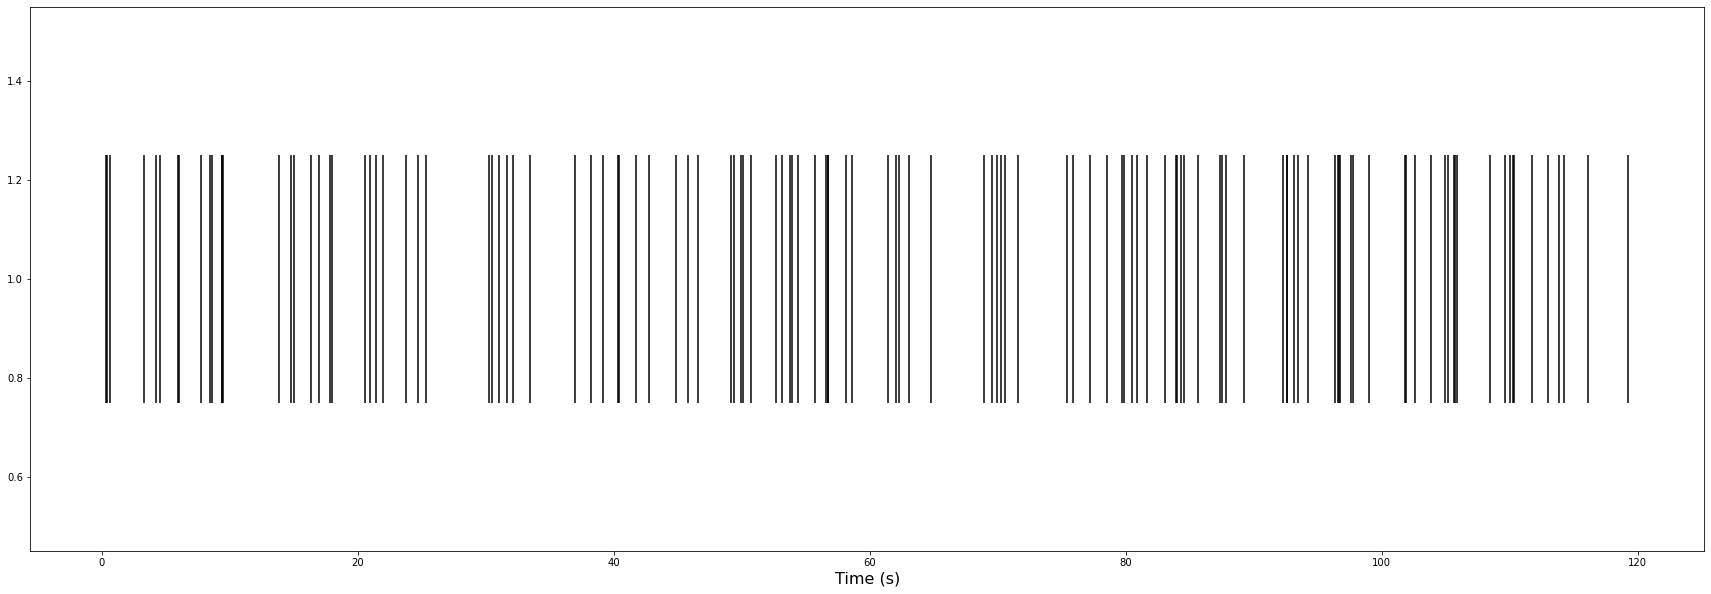

Text(0.5, 0, 'Time (s)')

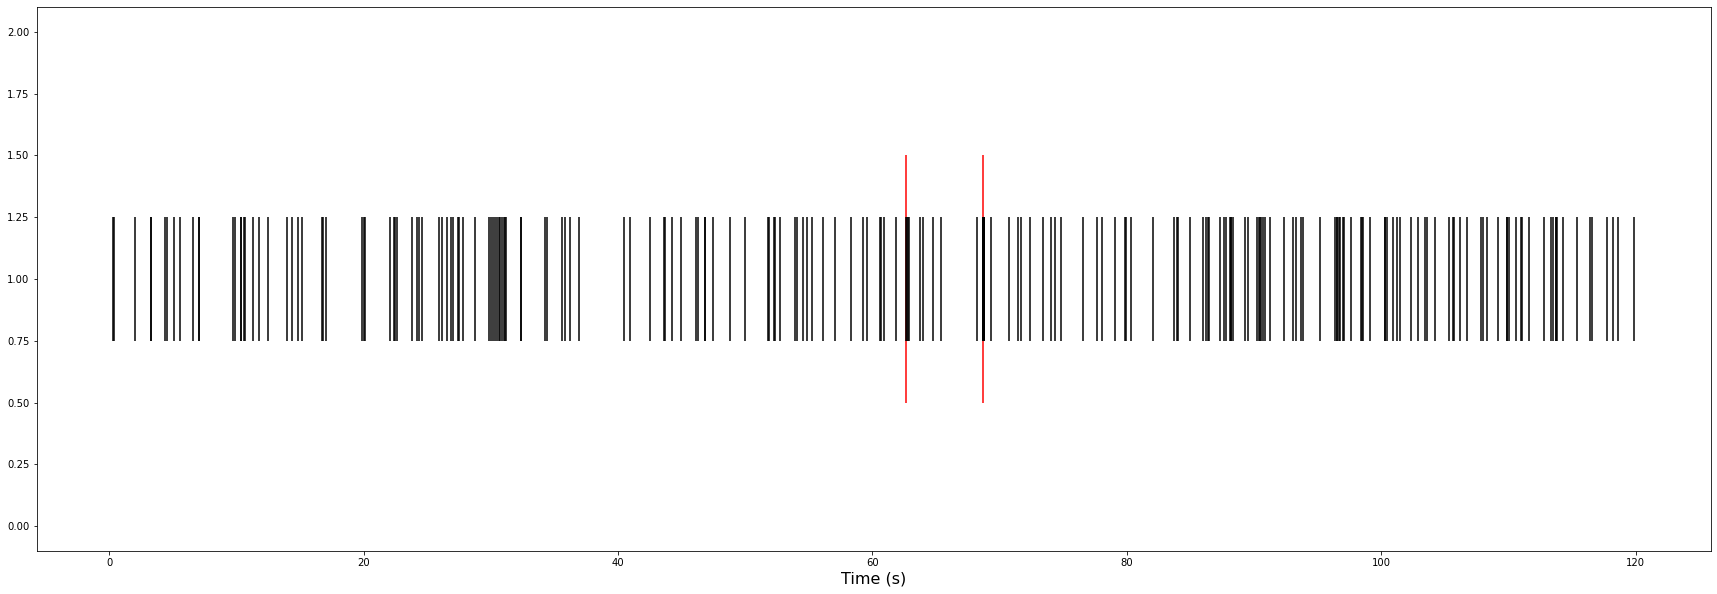

Text(0.5, 0, 'Time (s)')

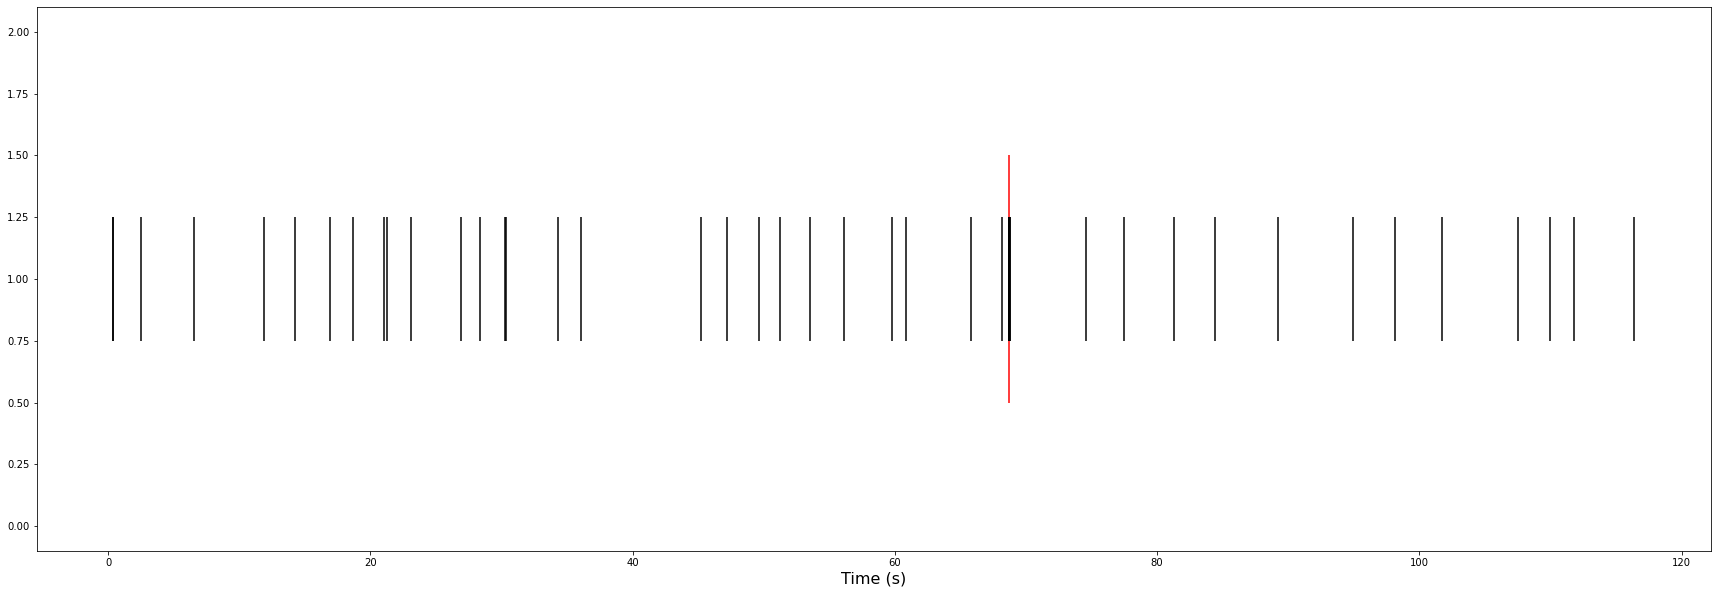

Text(0.5, 0, 'Time (s)')

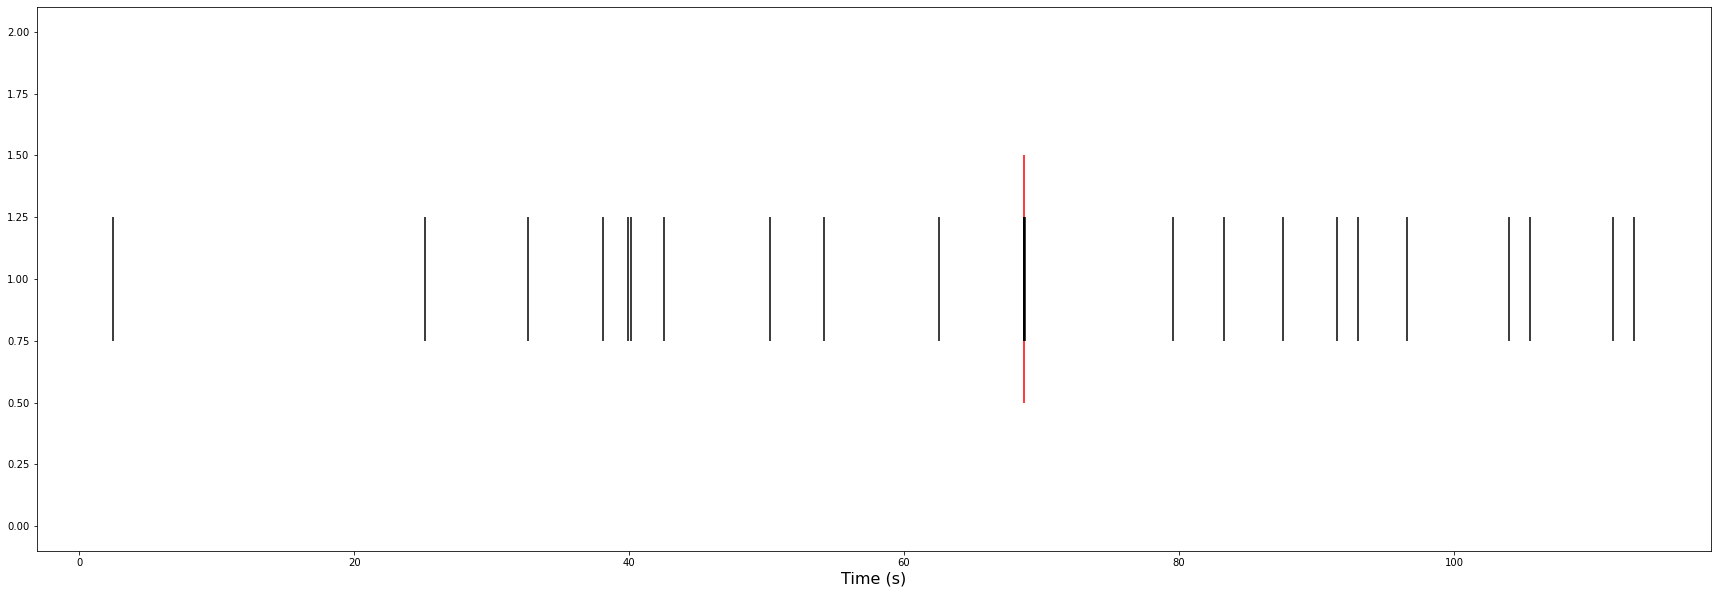

Text(0.5, 0, 'Time (s)')

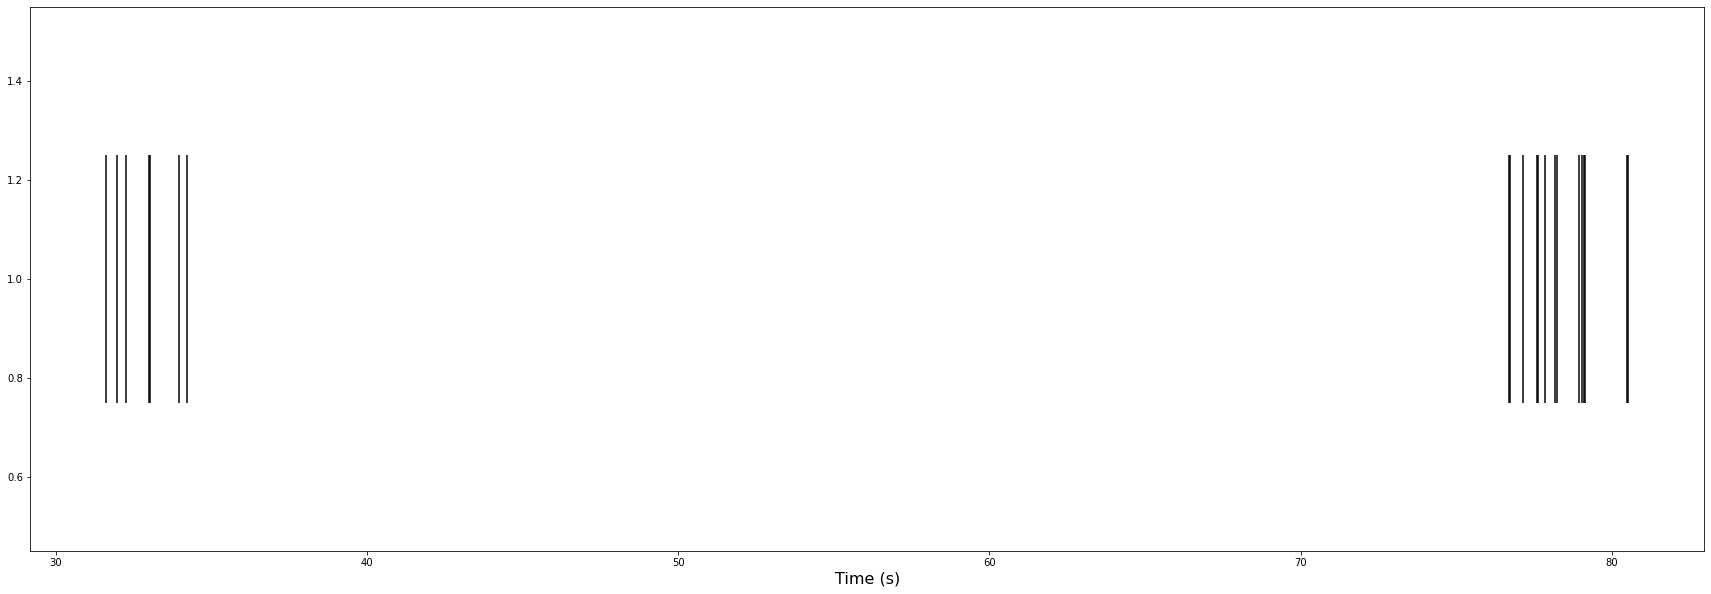

Text(0.5, 0, 'Time (s)')

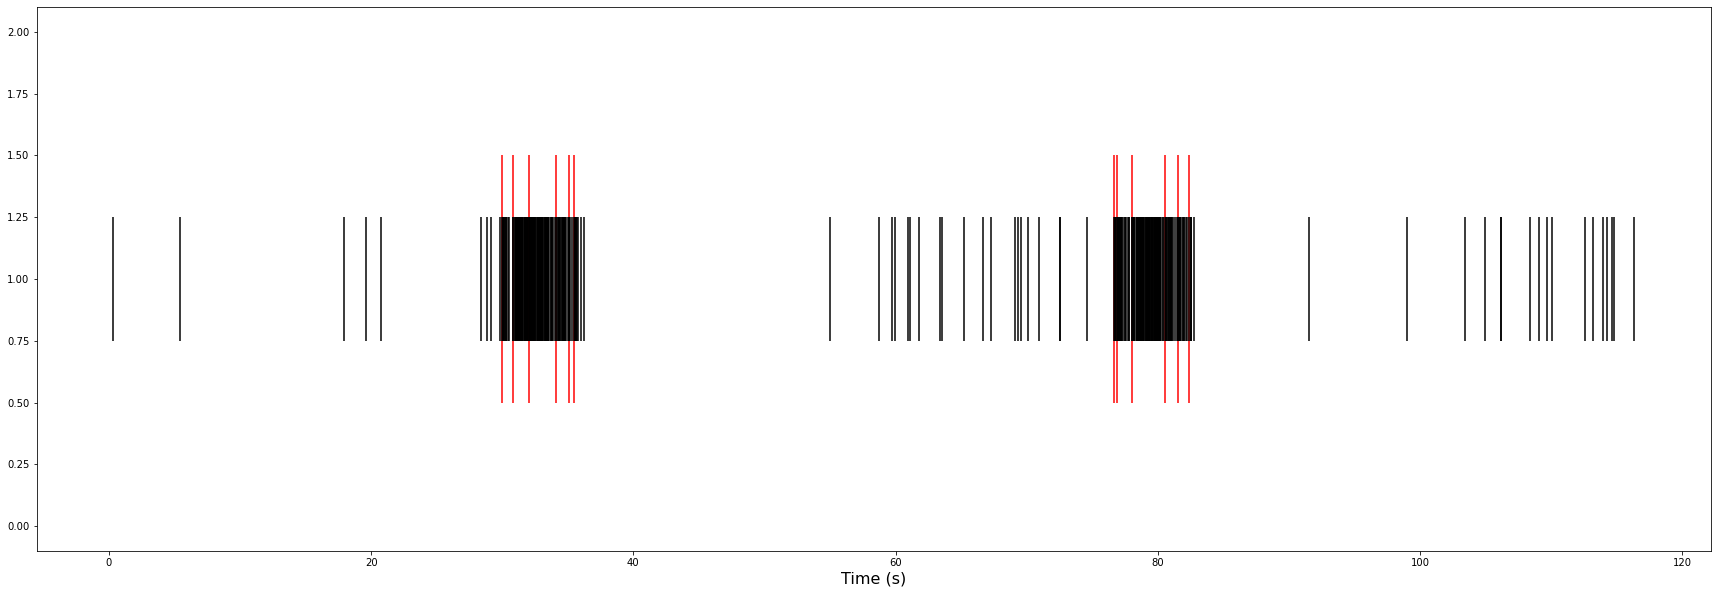

Text(0.5, 0, 'Time (s)')

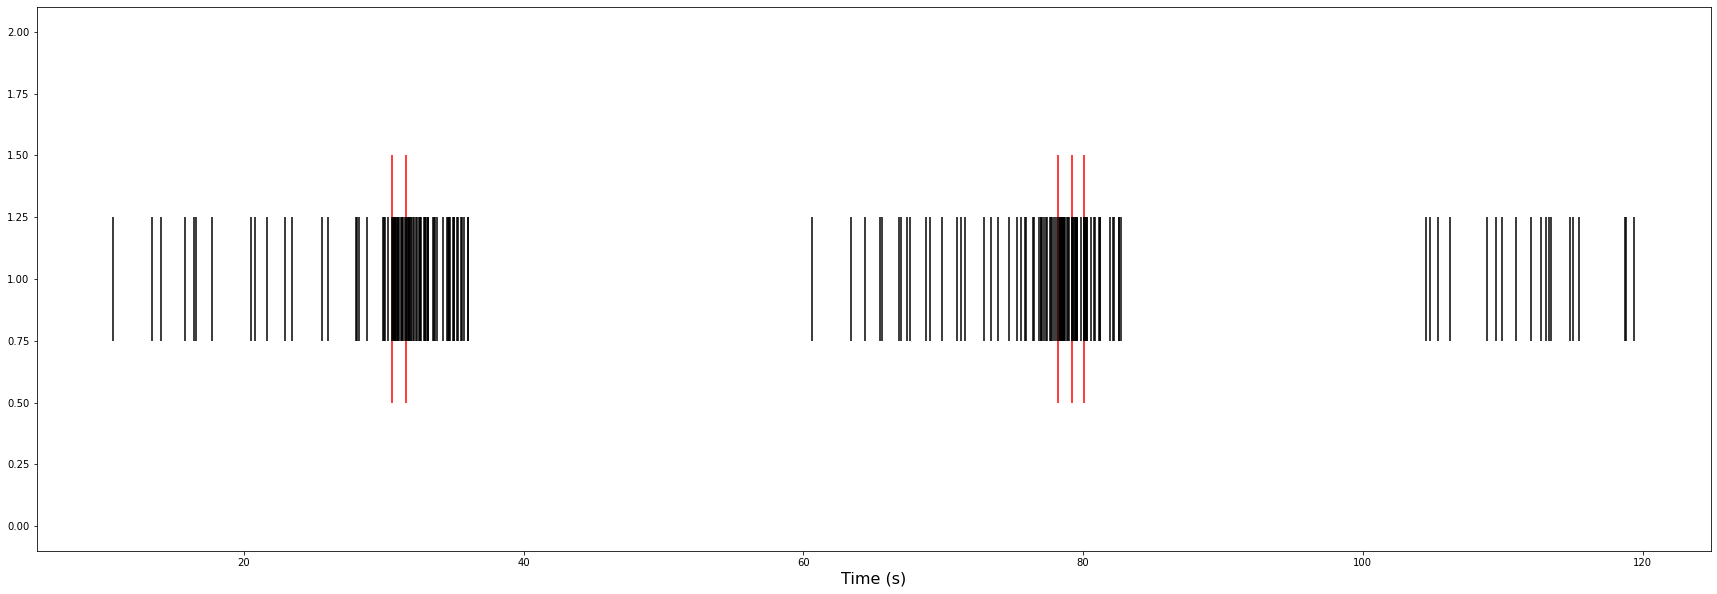

Text(0.5, 0, 'Time (s)')

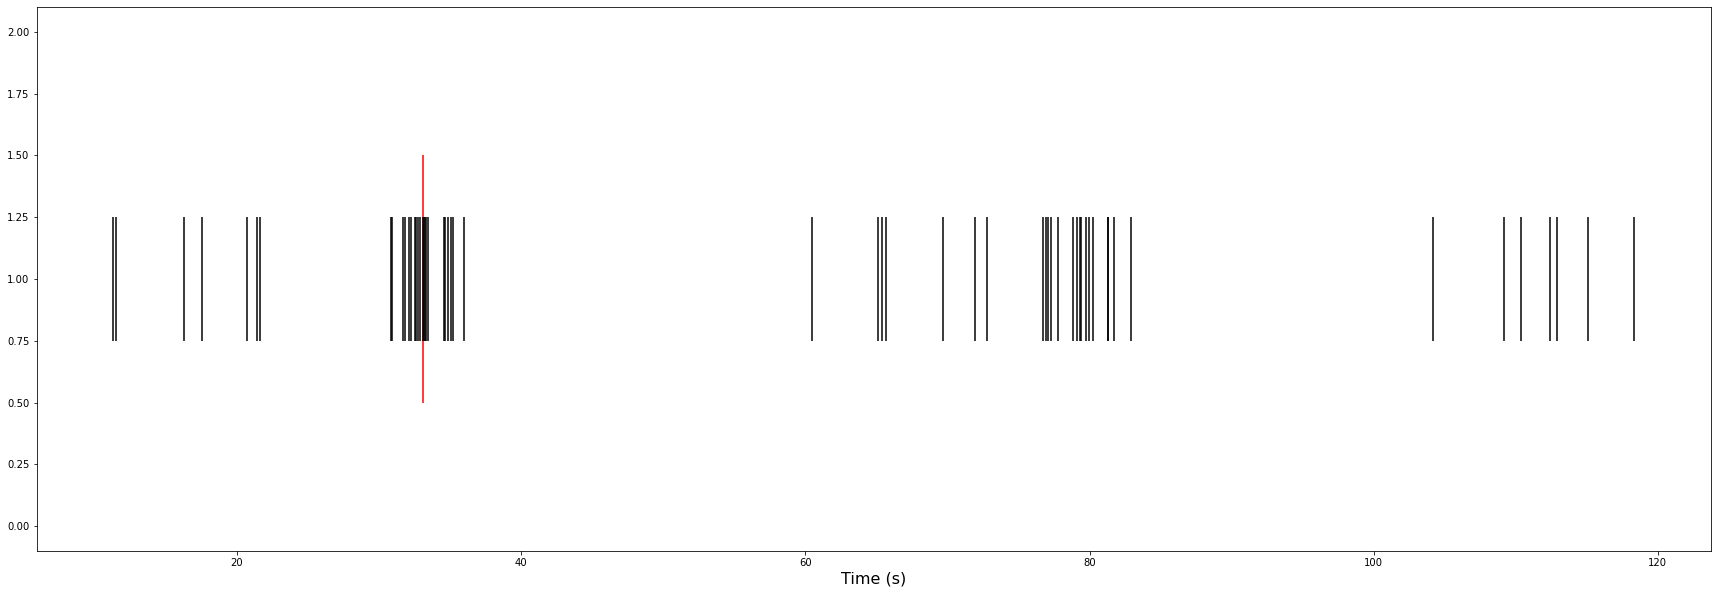

Text(0.5, 0, 'Time (s)')

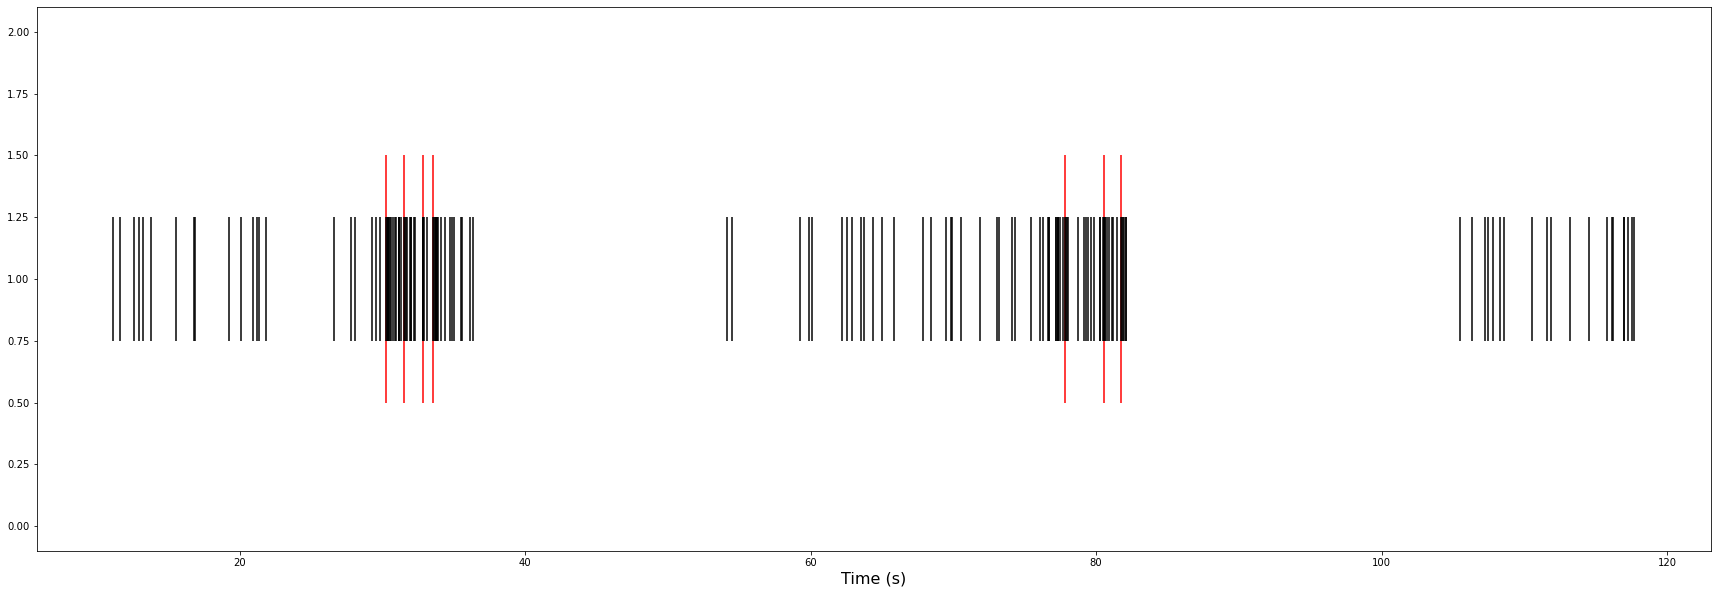

Text(0.5, 0, 'Time (s)')

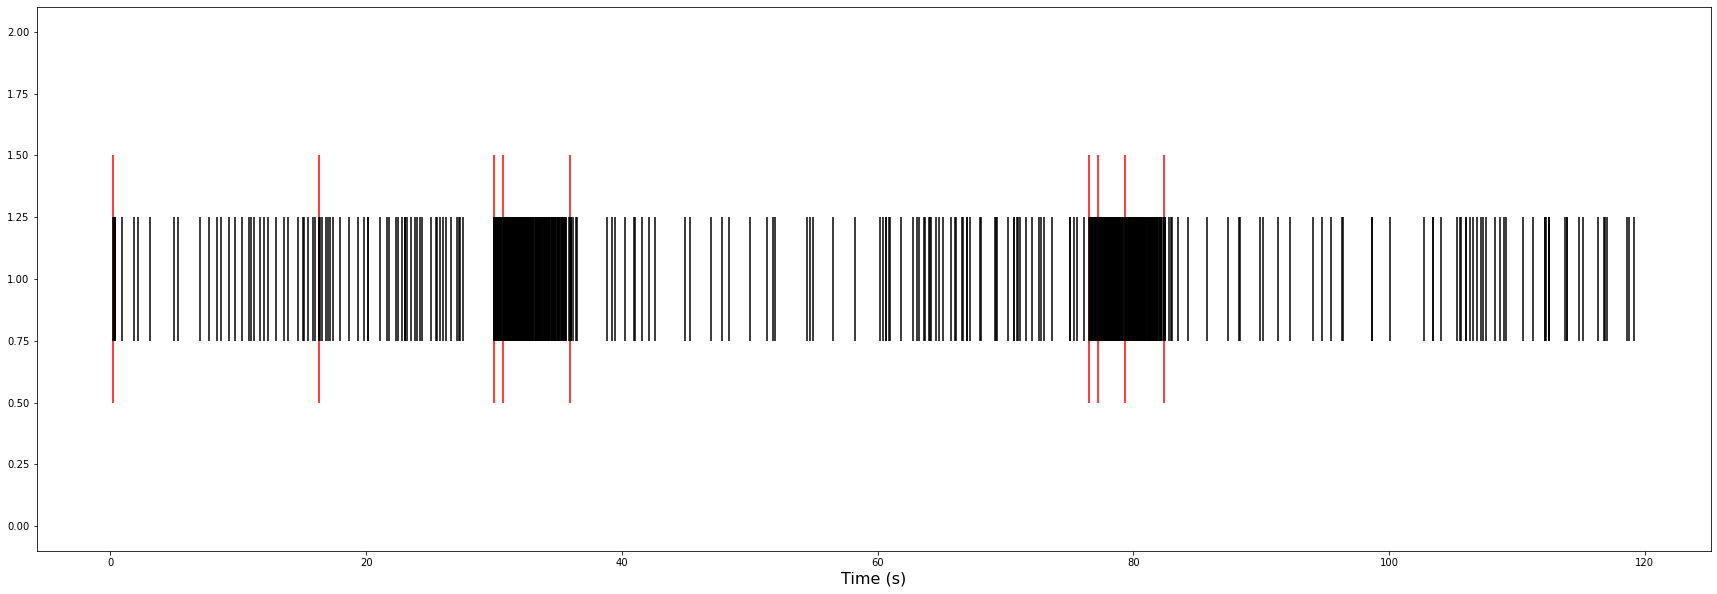

Text(0.5, 0, 'Time (s)')

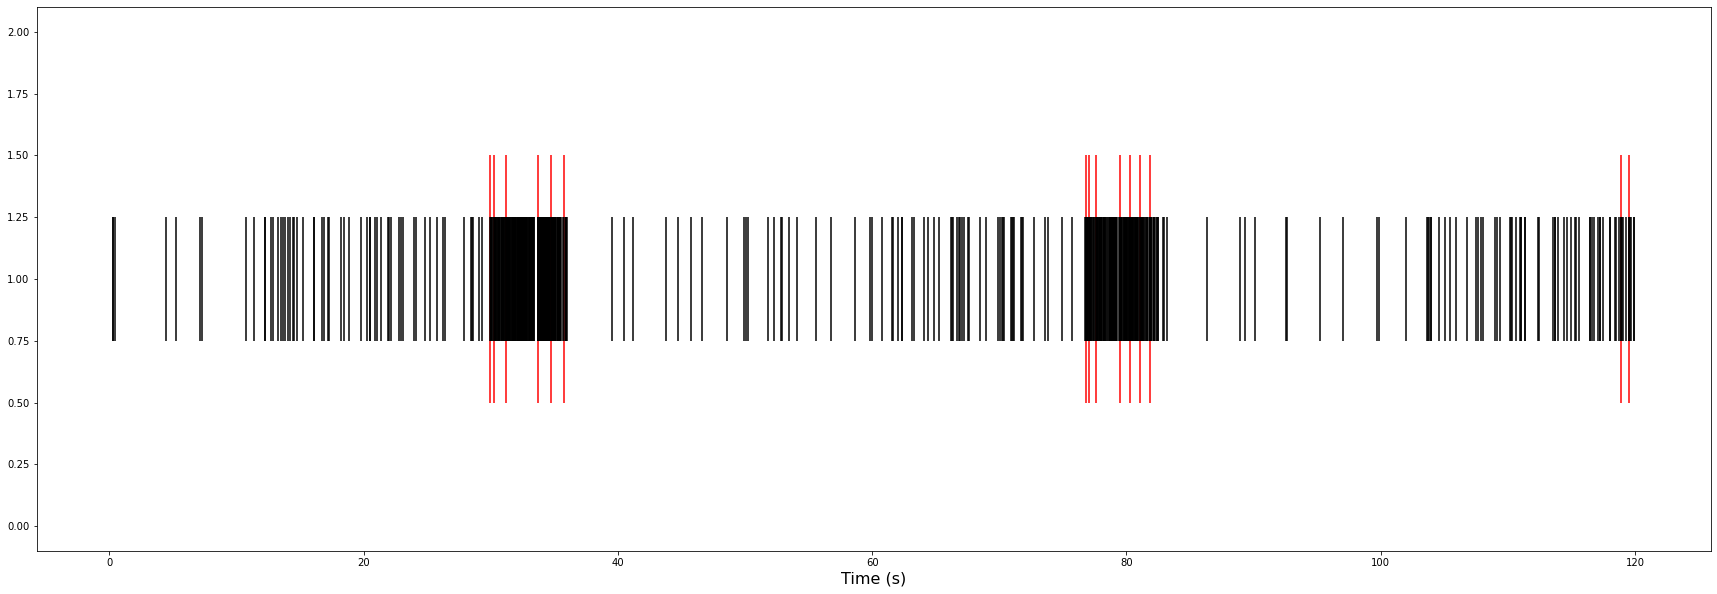

Text(0.5, 0, 'Time (s)')

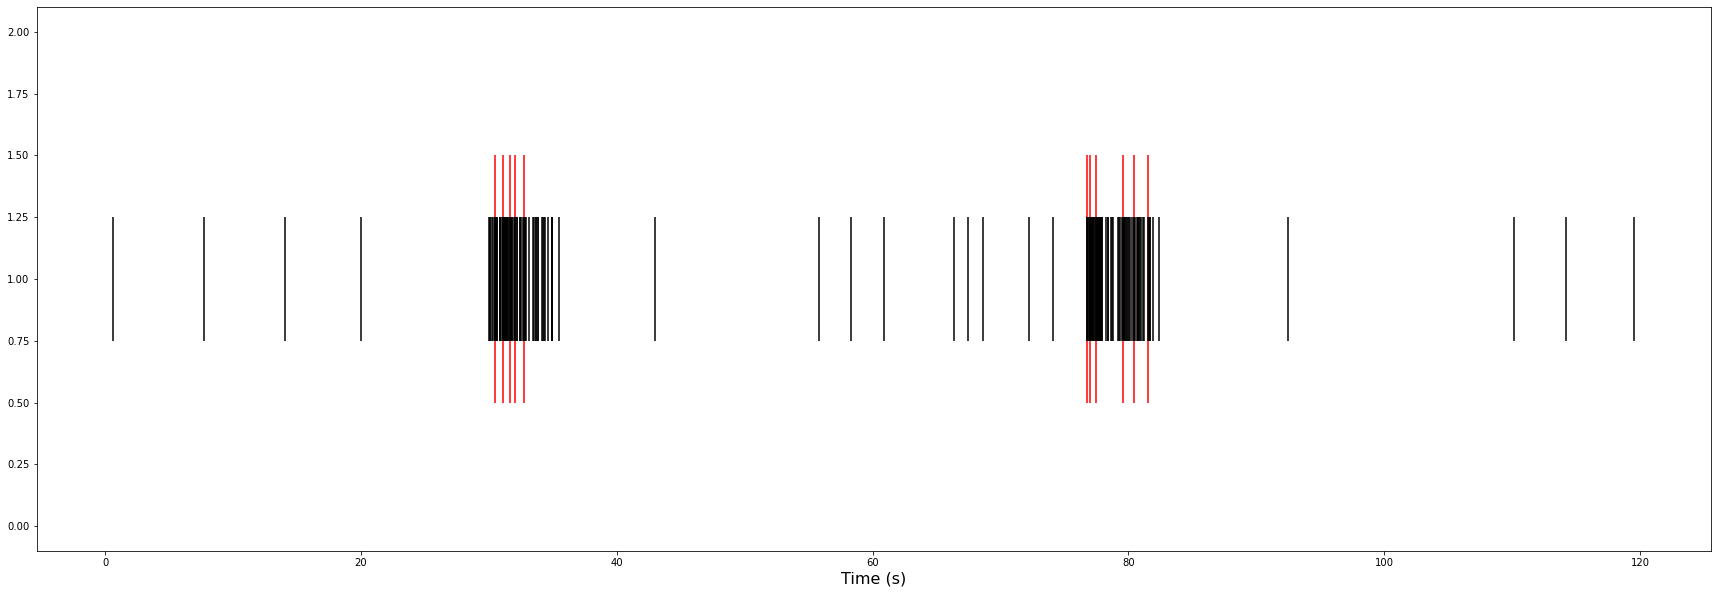

Text(0.5, 0, 'Time (s)')

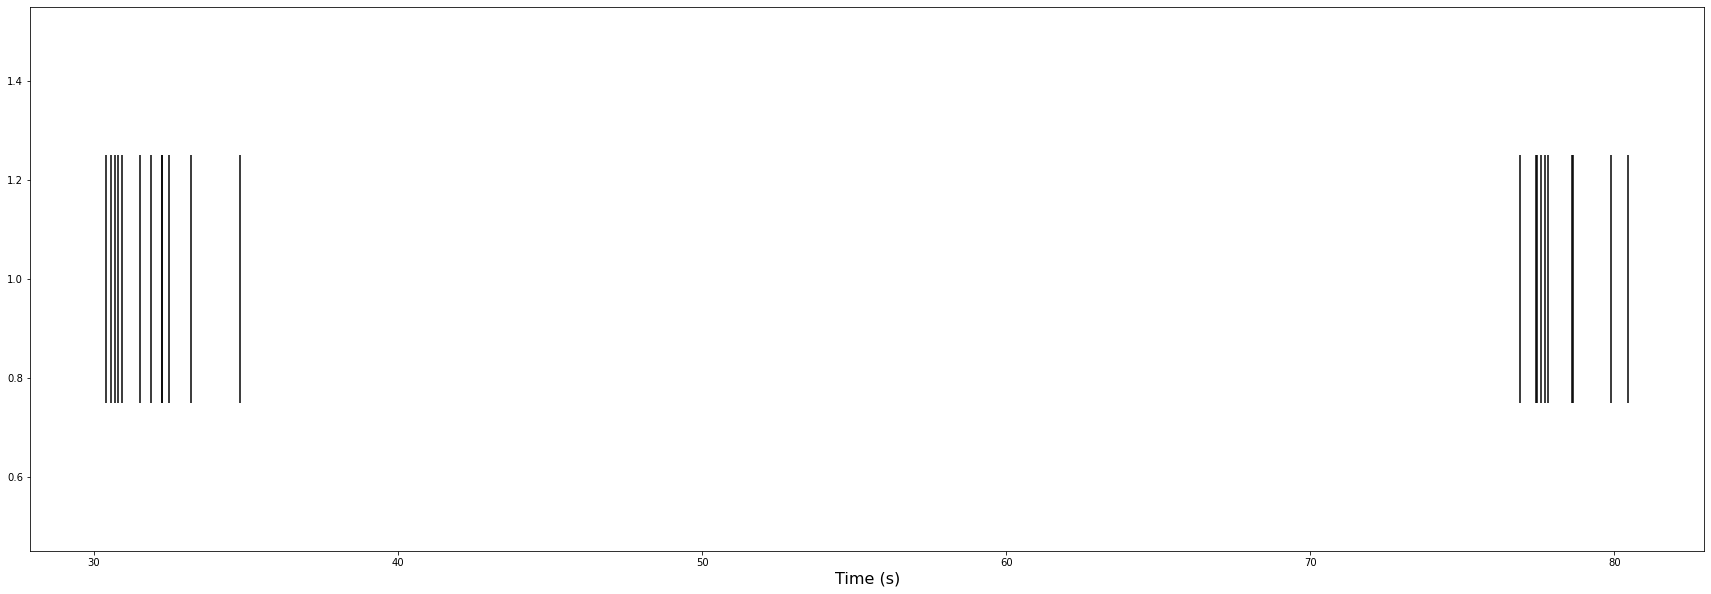

Text(0.5, 0, 'Time (s)')

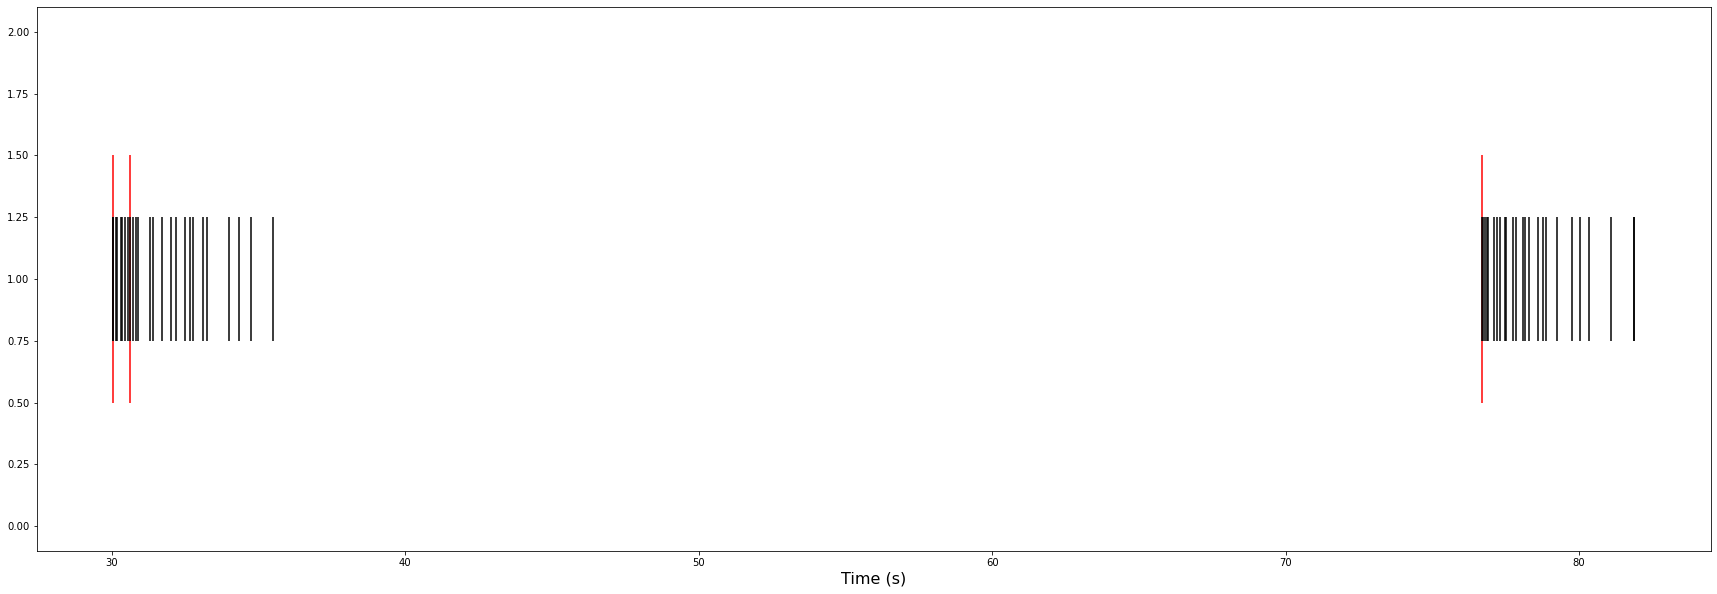

Text(0.5, 0, 'Time (s)')

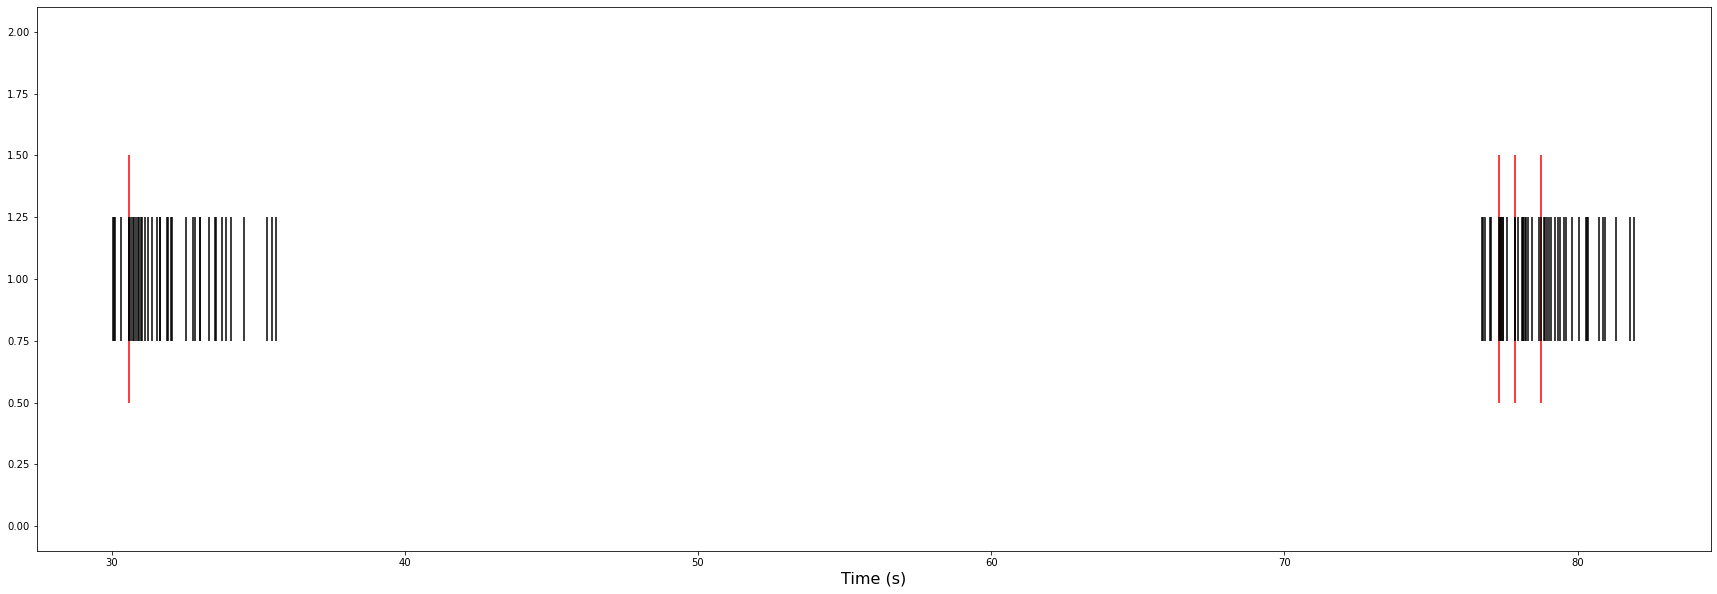

Text(0.5, 0, 'Time (s)')

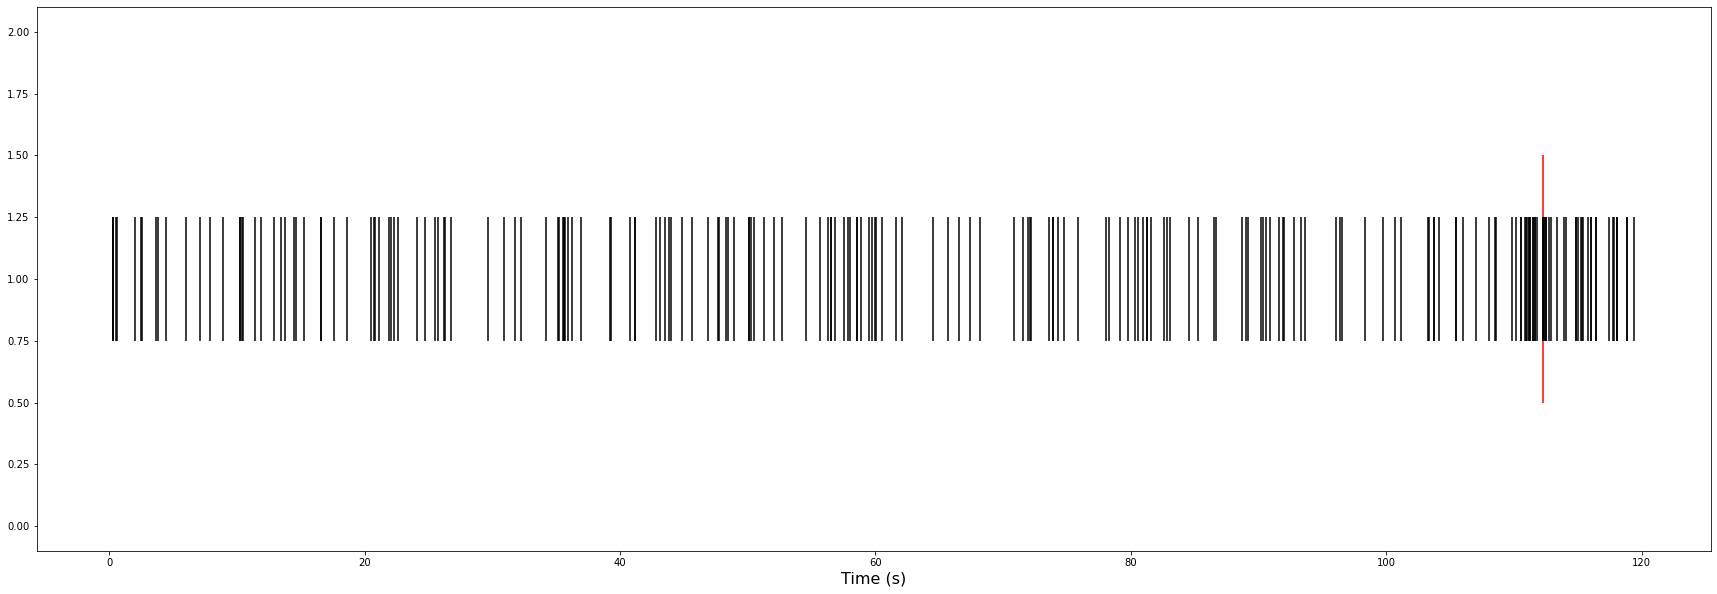

Text(0.5, 0, 'Time (s)')

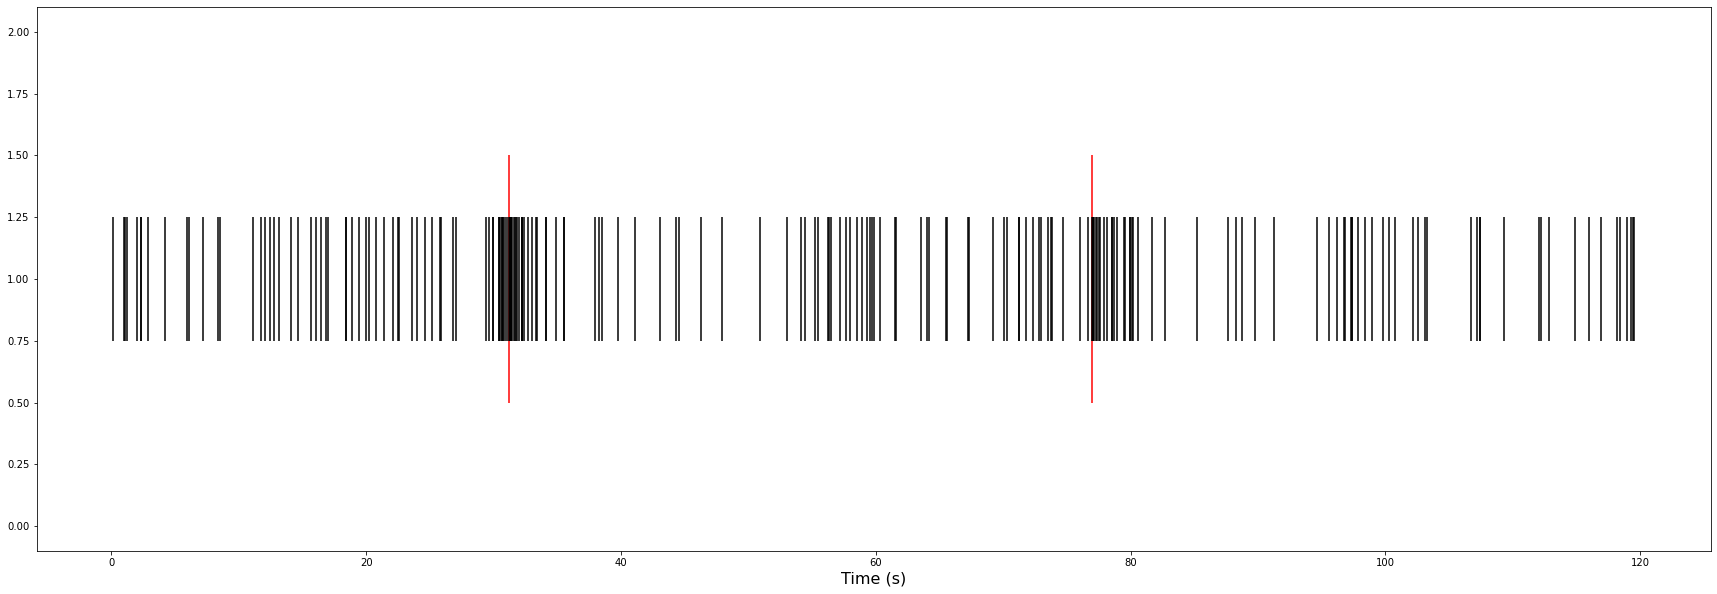

Text(0.5, 0, 'Time (s)')

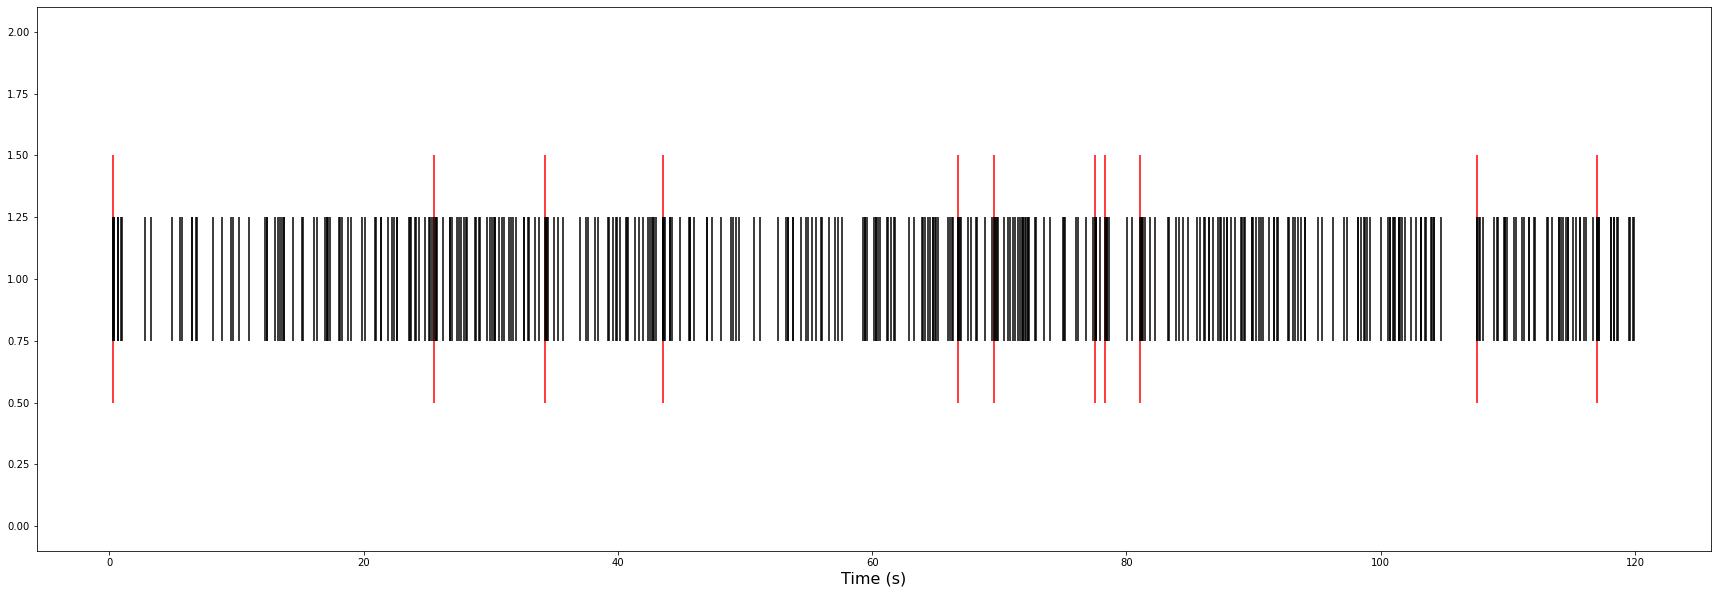

Text(0.5, 0, 'Time (s)')

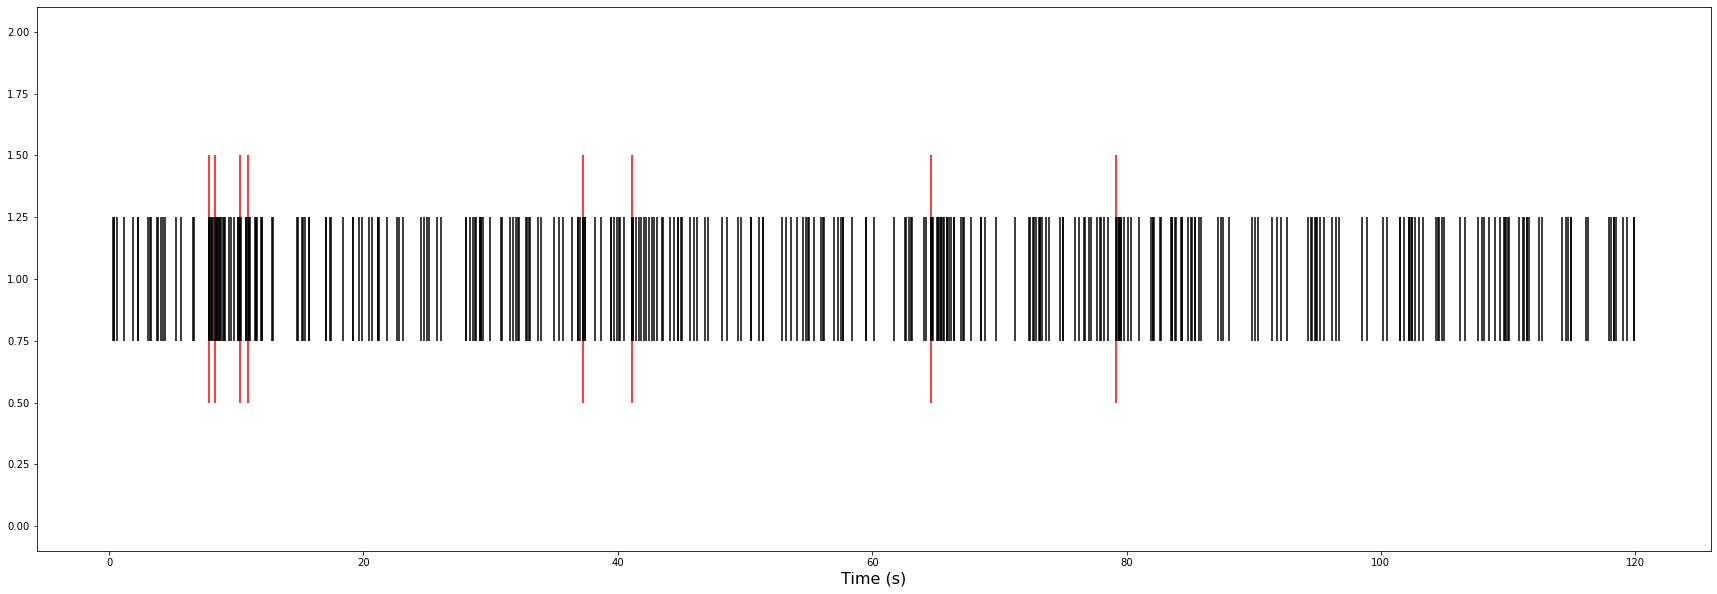

Text(0.5, 0, 'Time (s)')

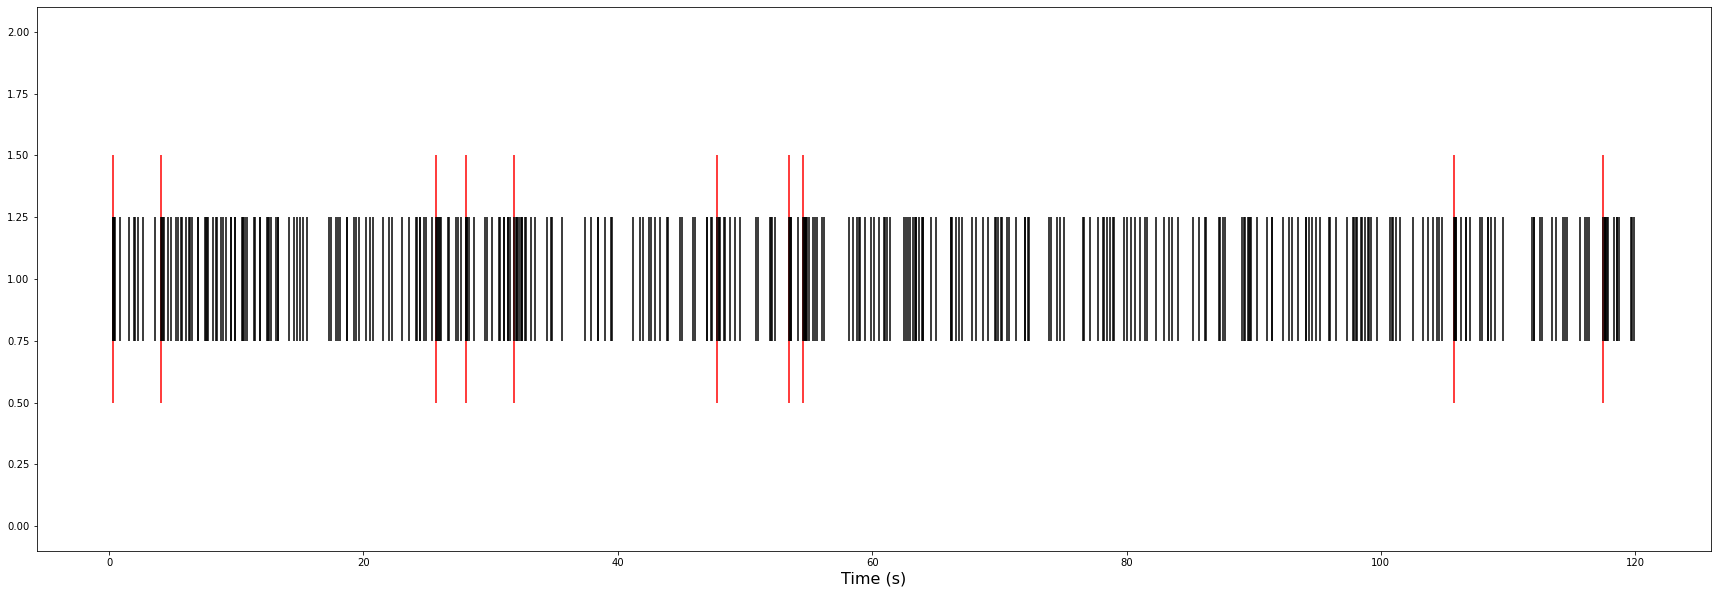

Text(0.5, 0, 'Time (s)')

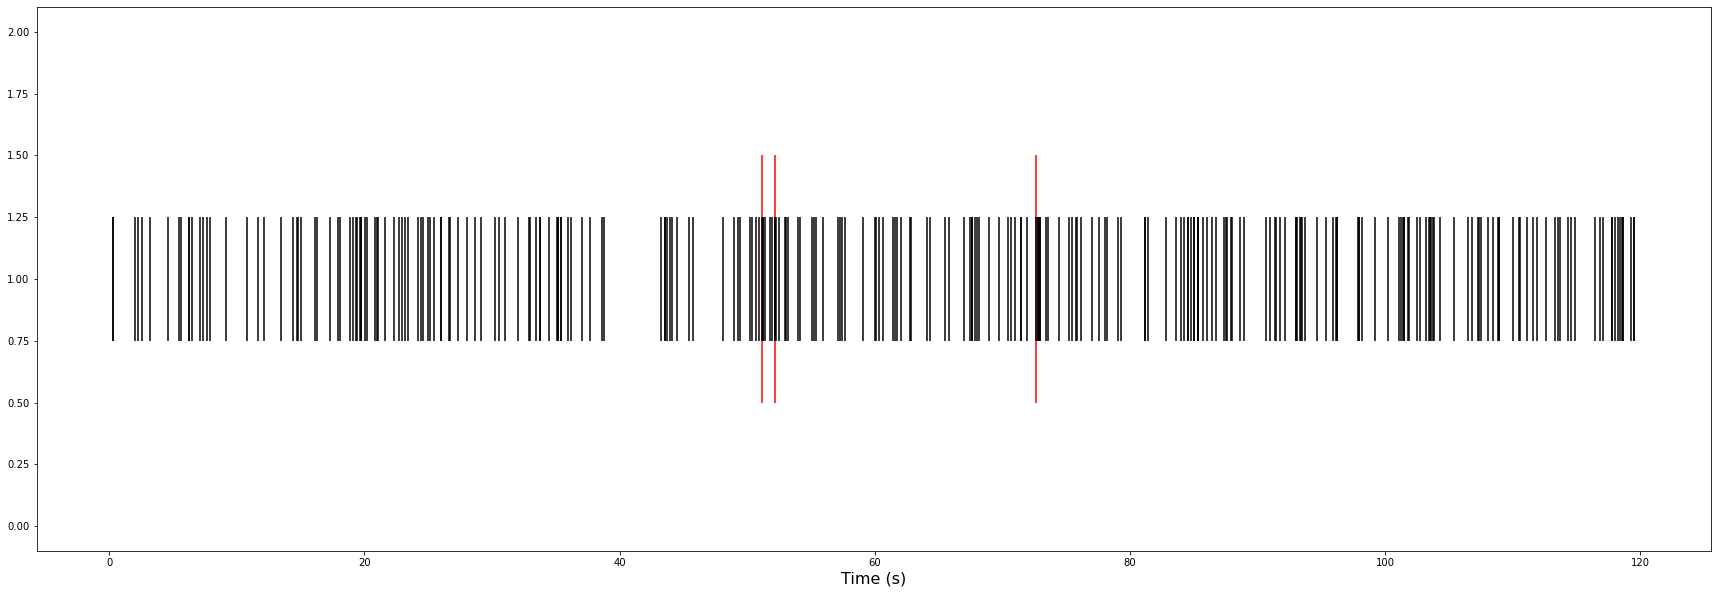

Text(0.5, 0, 'Time (s)')

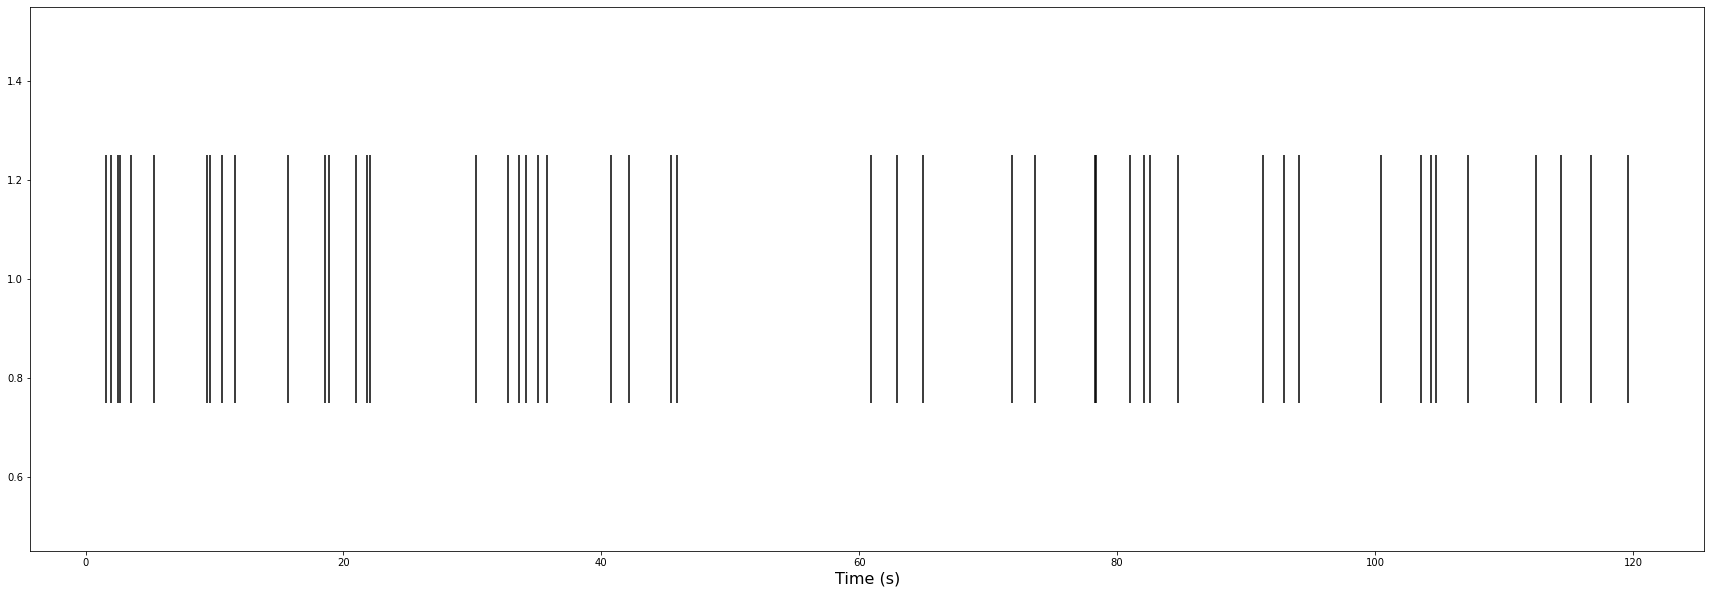

Text(0.5, 0, 'Time (s)')

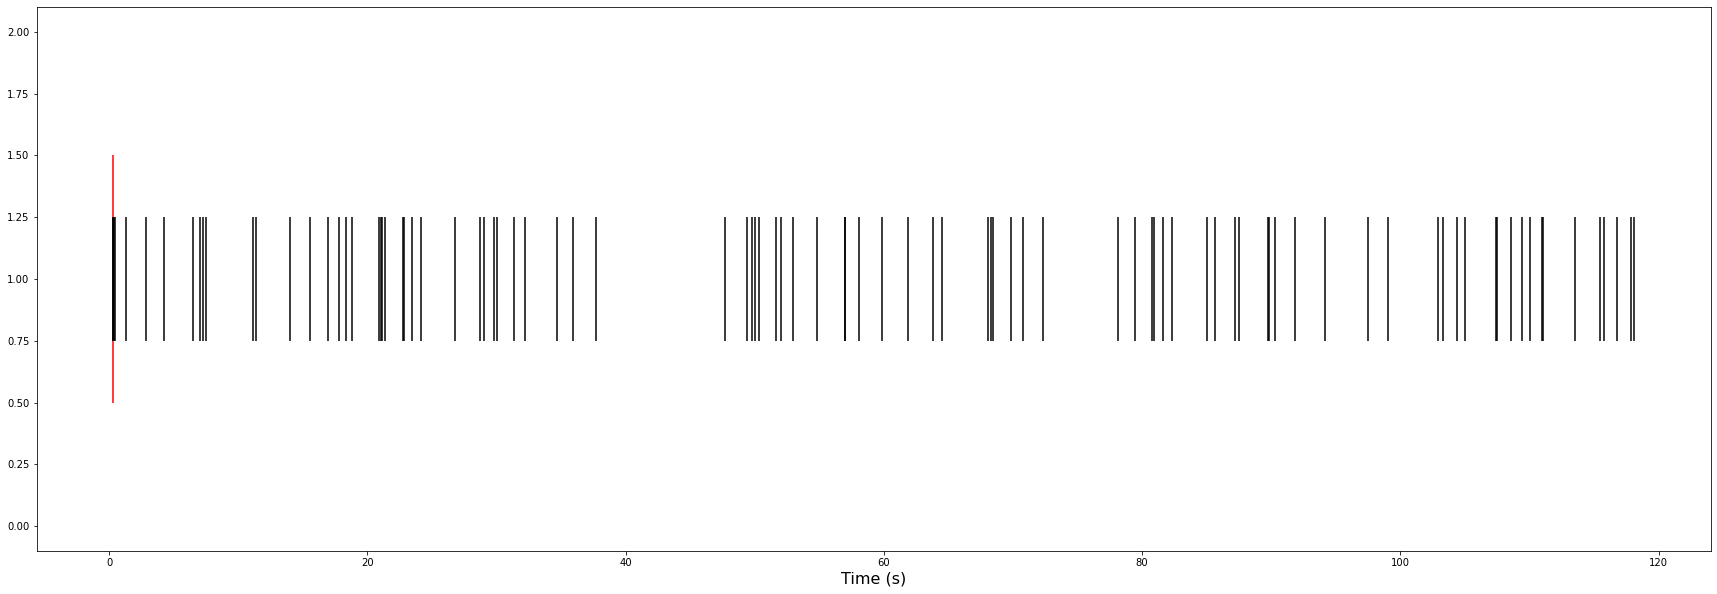

Text(0.5, 0, 'Time (s)')

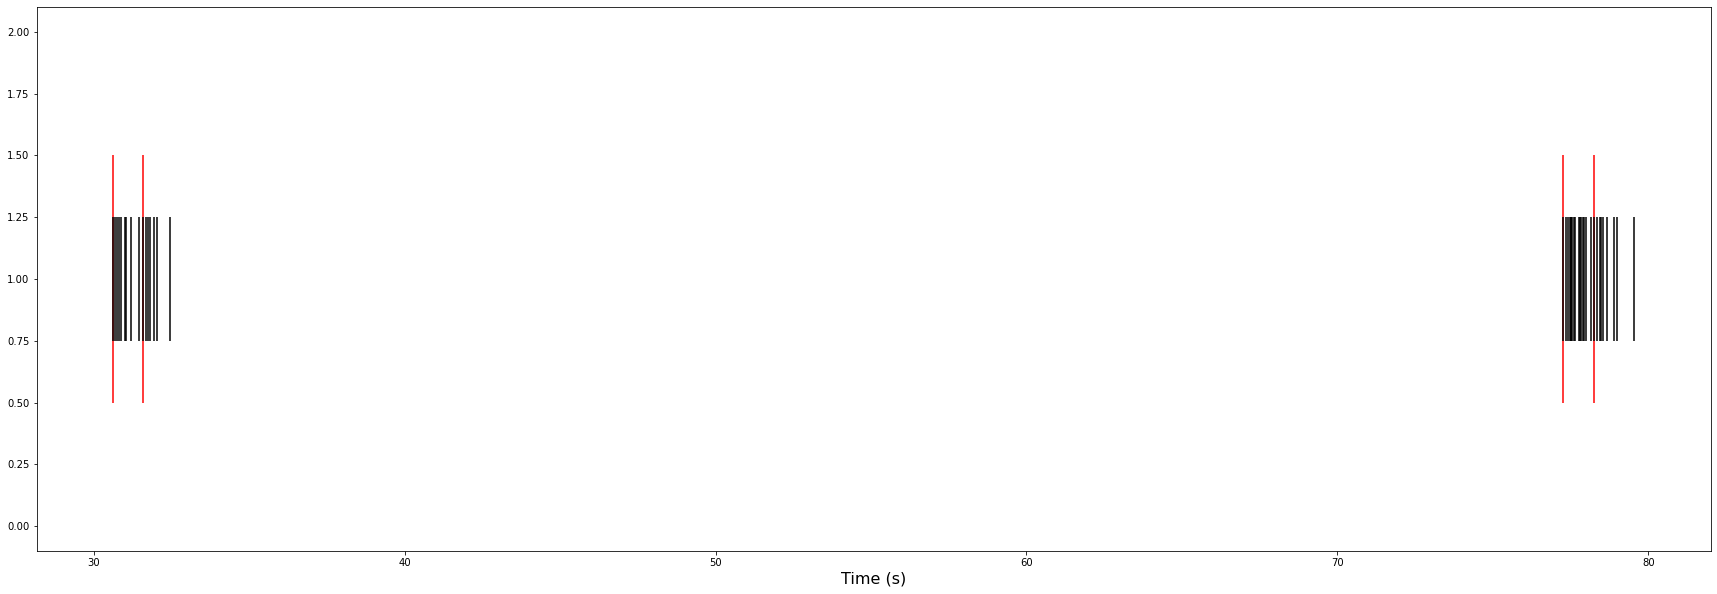

Text(0.5, 0, 'Time (s)')

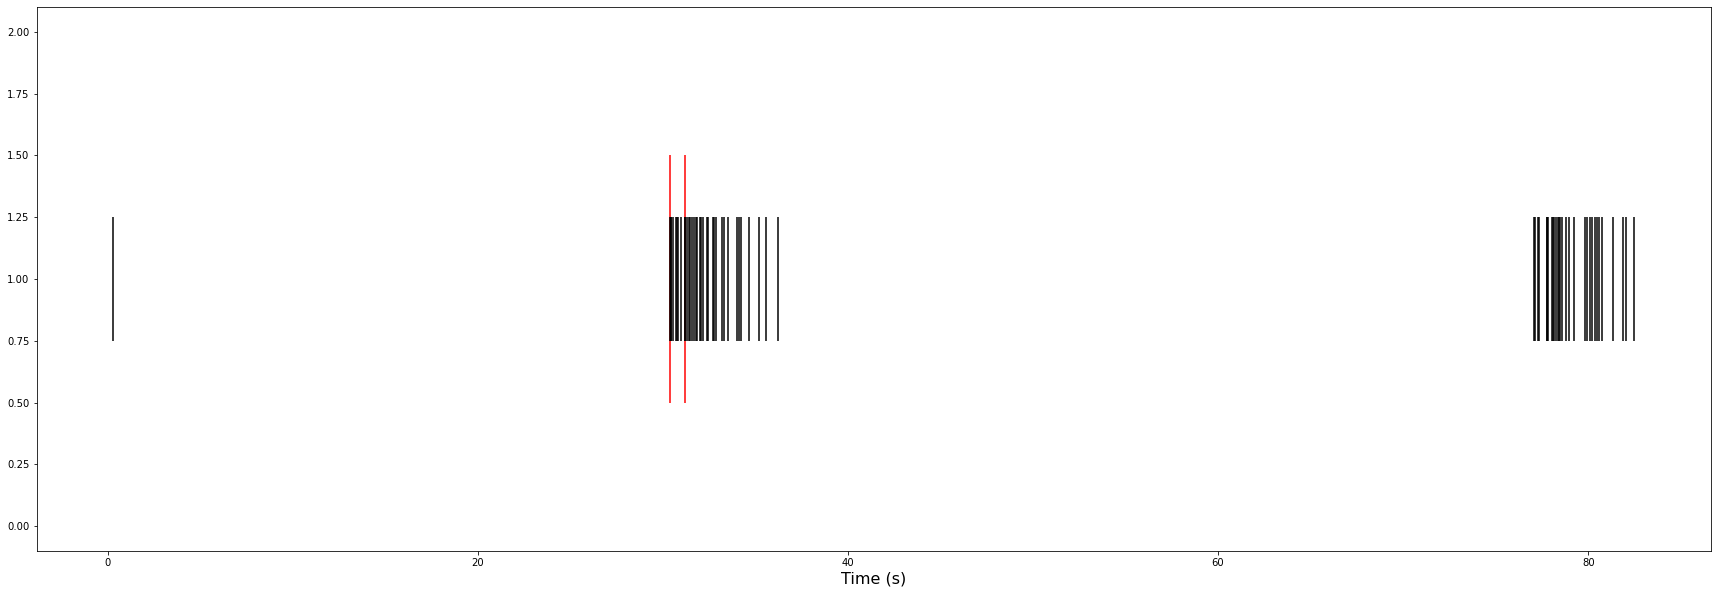

Text(0.5, 0, 'Time (s)')

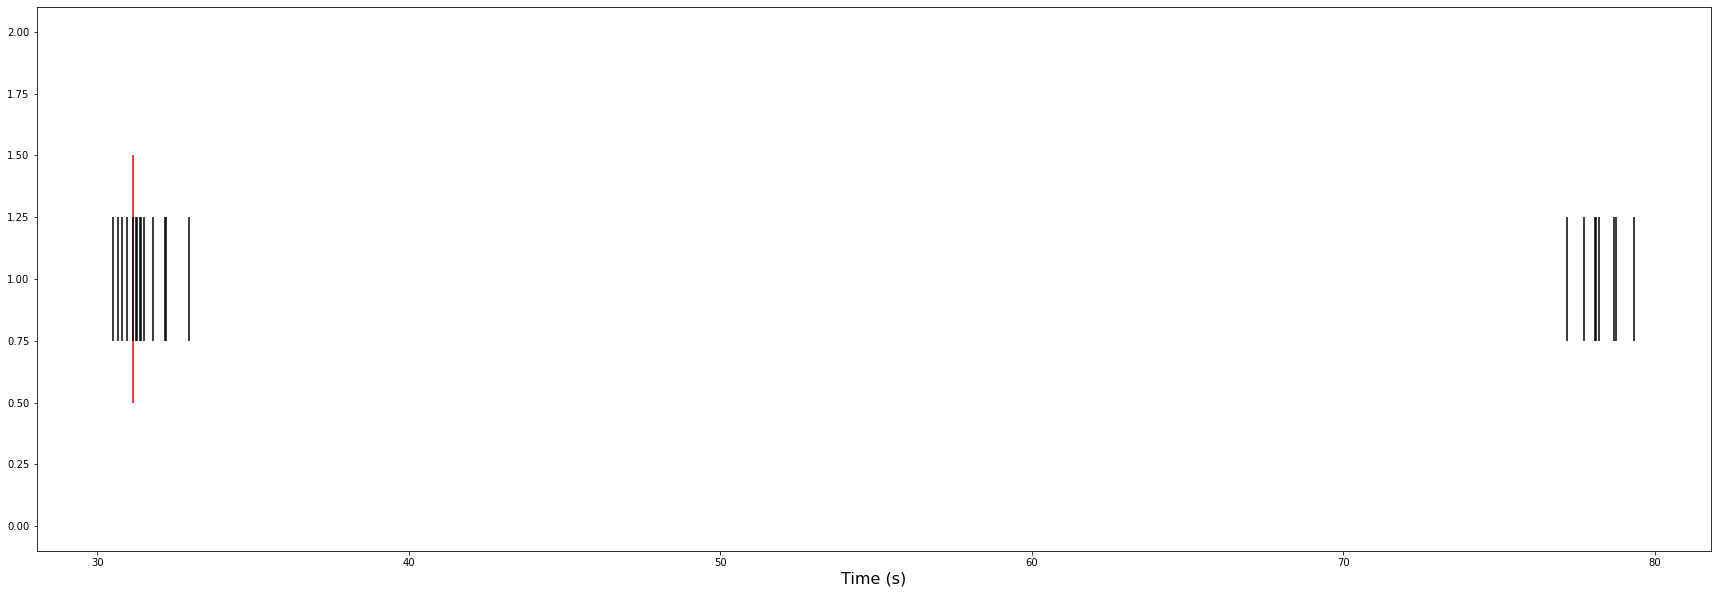

Text(0.5, 0, 'Time (s)')

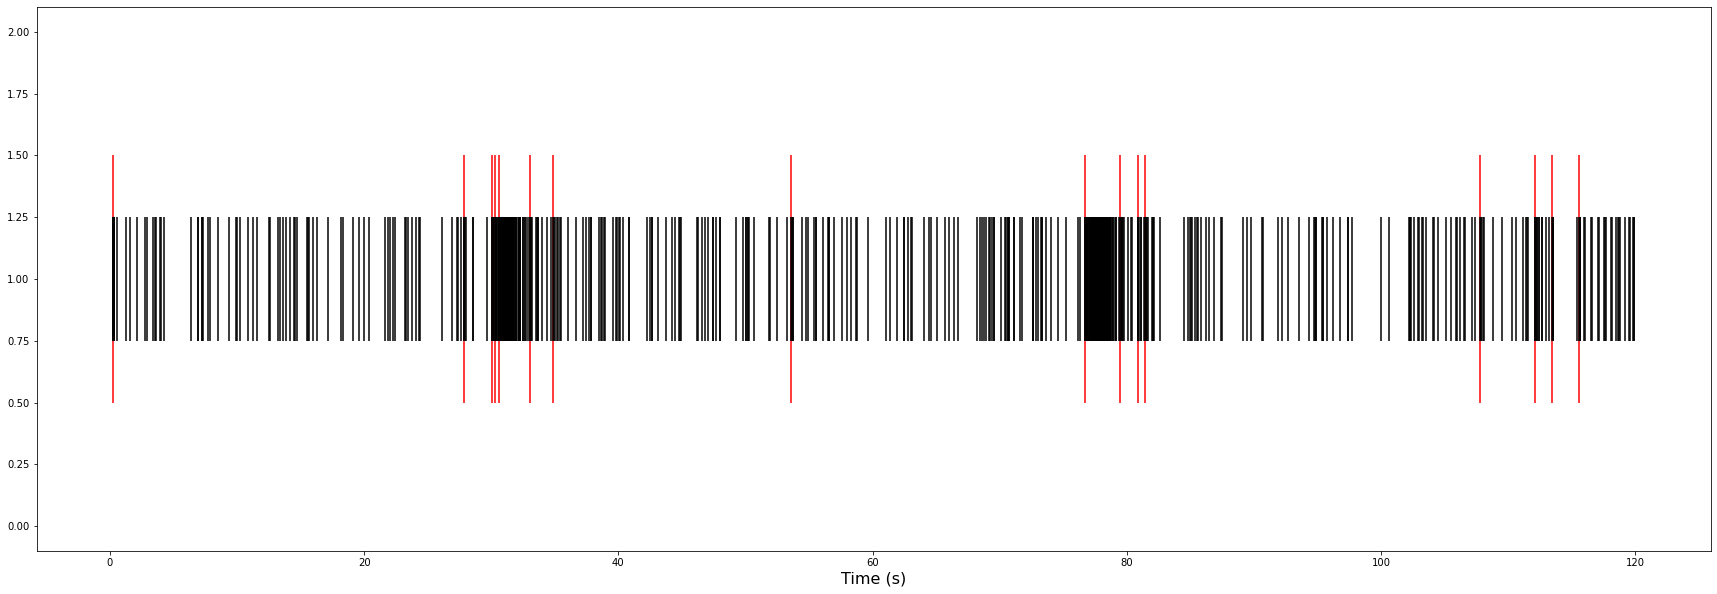

Text(0.5, 0, 'Time (s)')

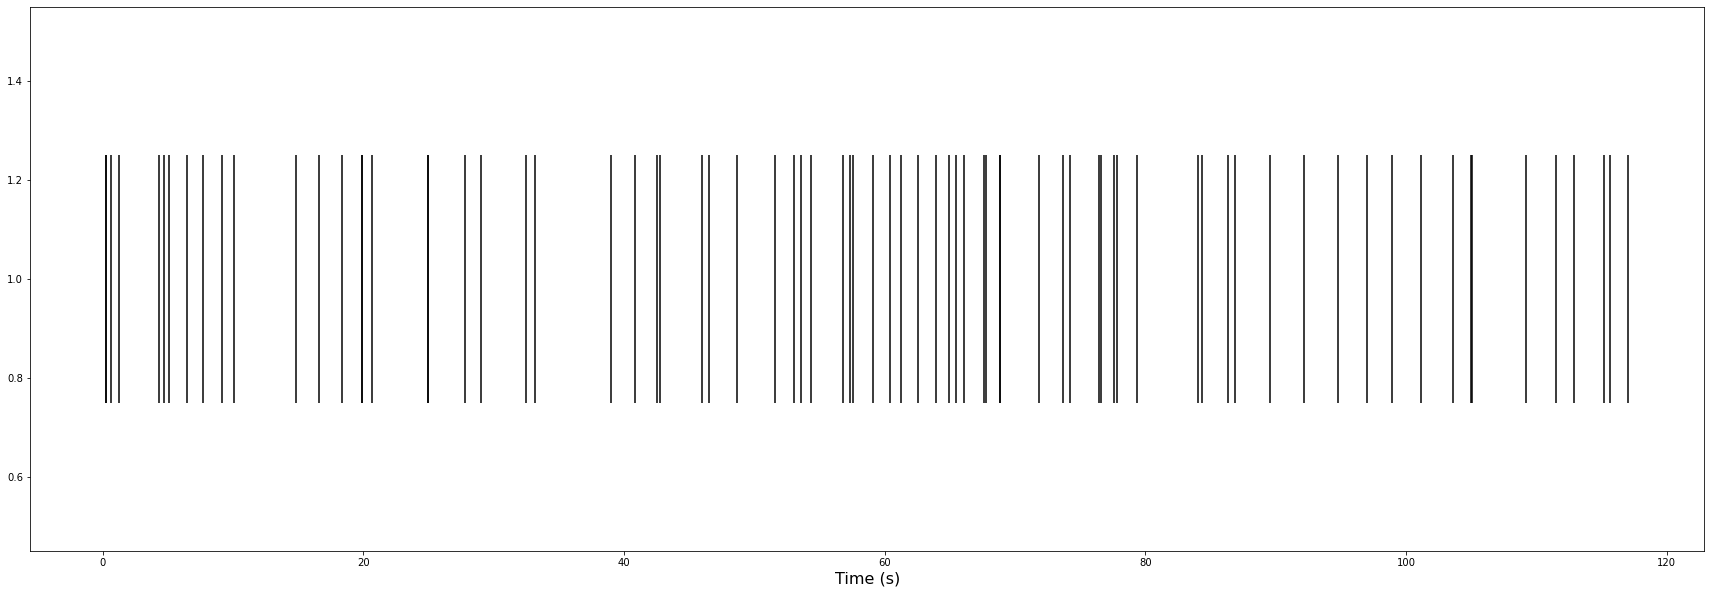

Text(0.5, 0, 'Time (s)')

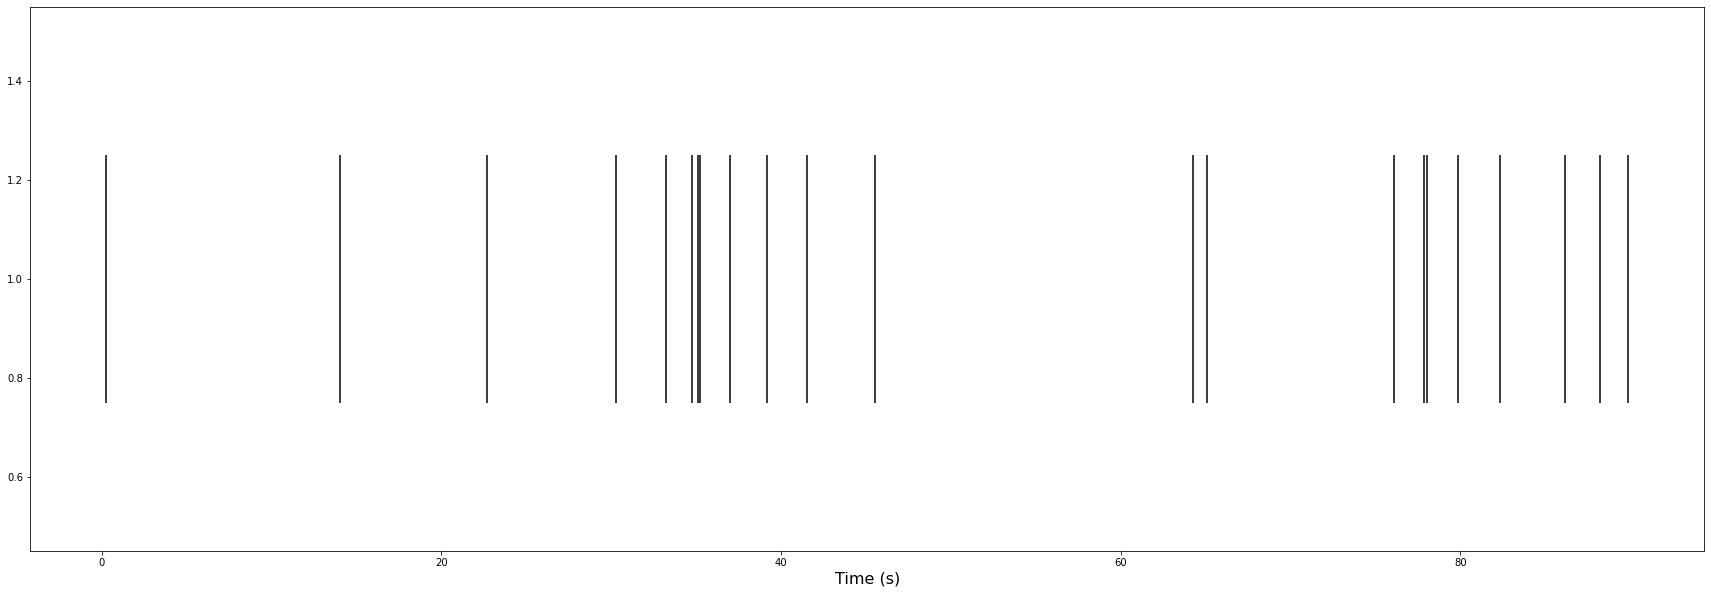

Text(0.5, 0, 'Time (s)')

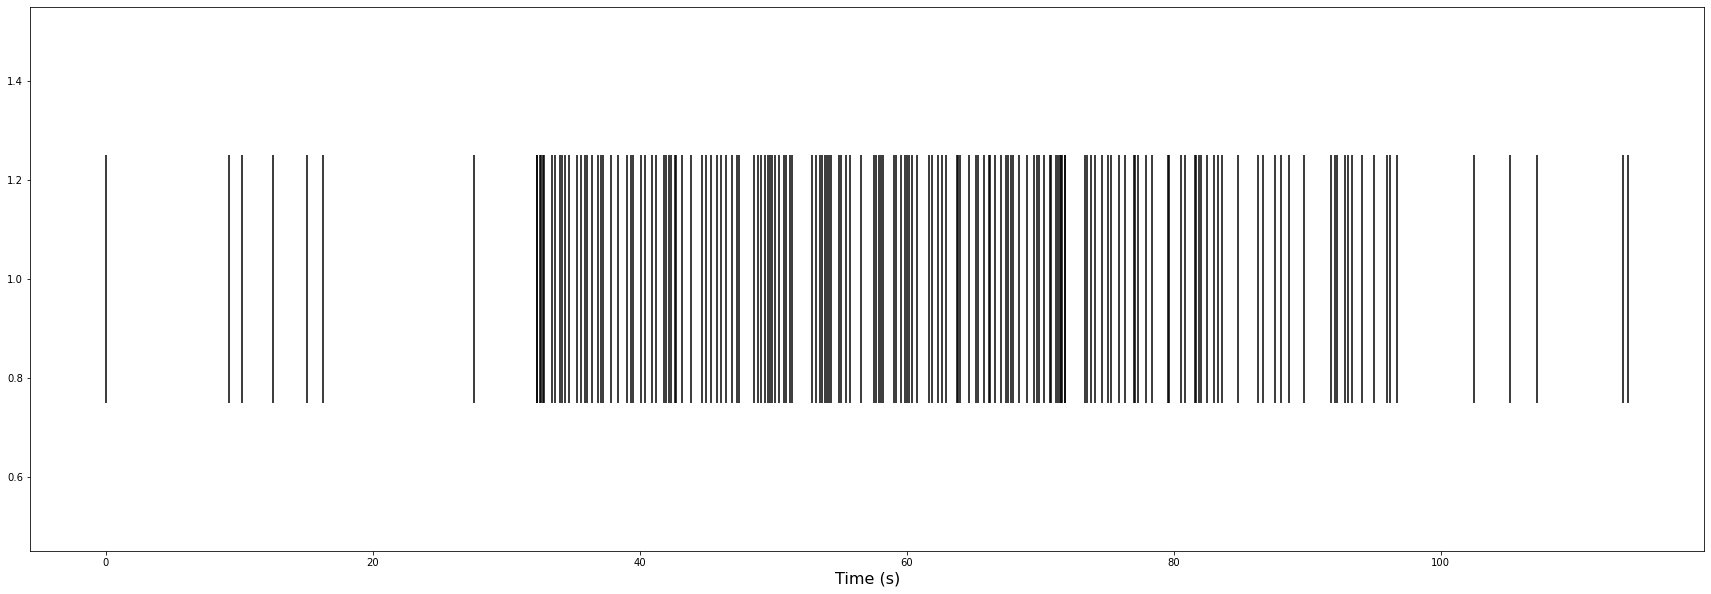

Text(0.5, 0, 'Time (s)')

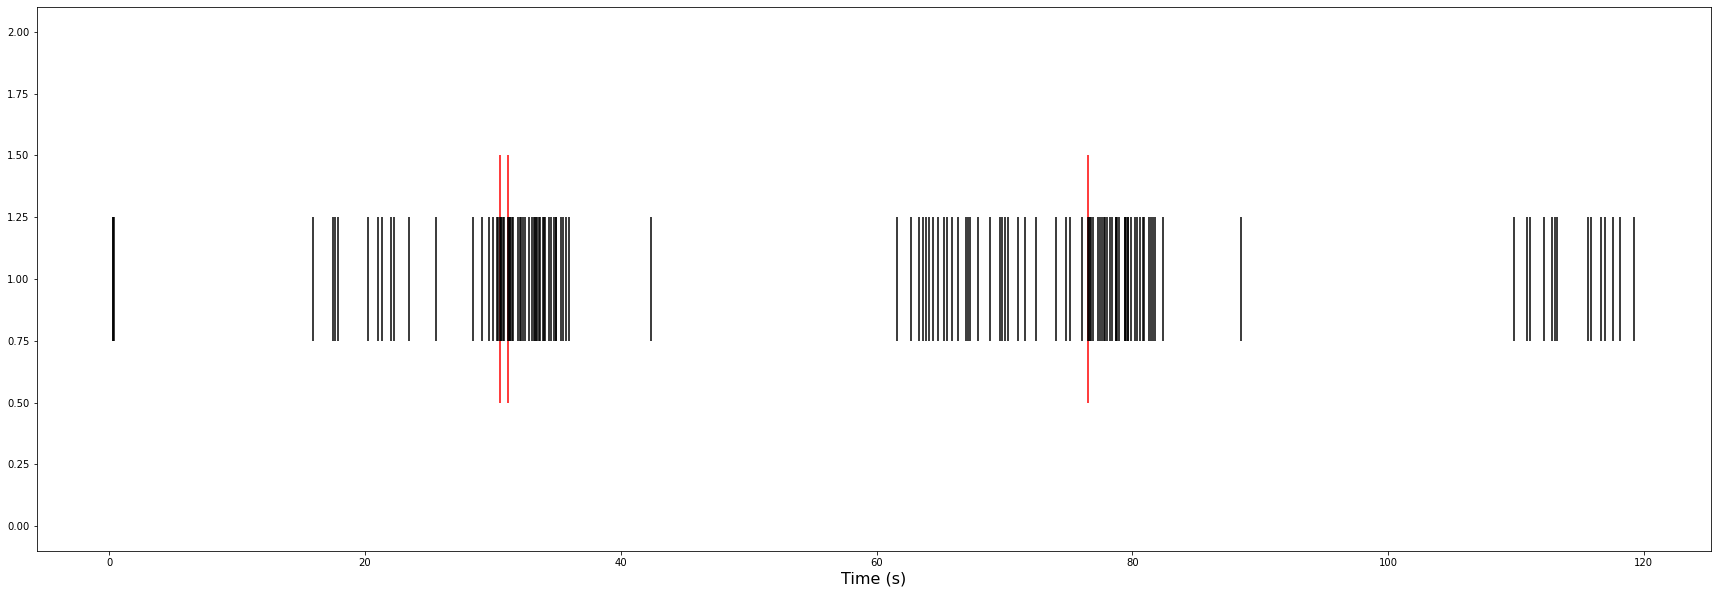

Text(0.5, 0, 'Time (s)')

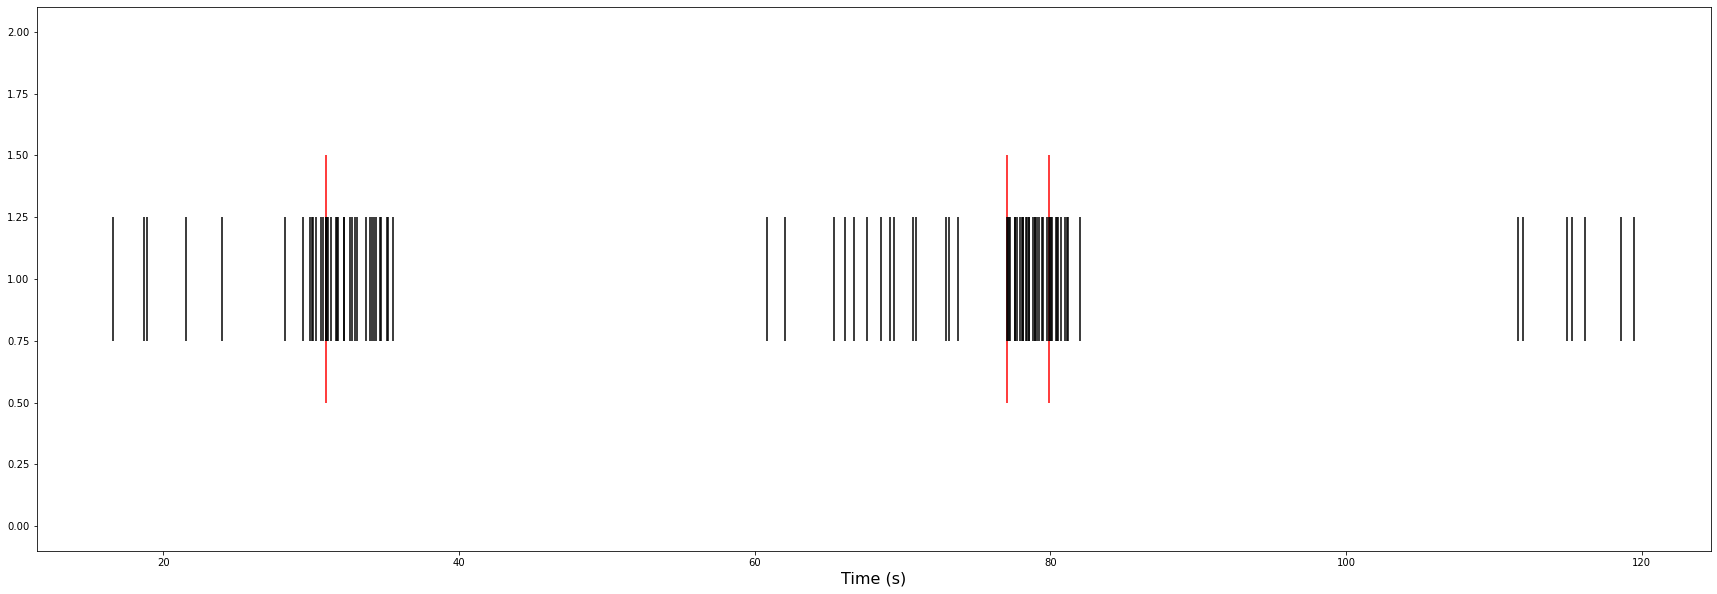

Text(0.5, 0, 'Time (s)')

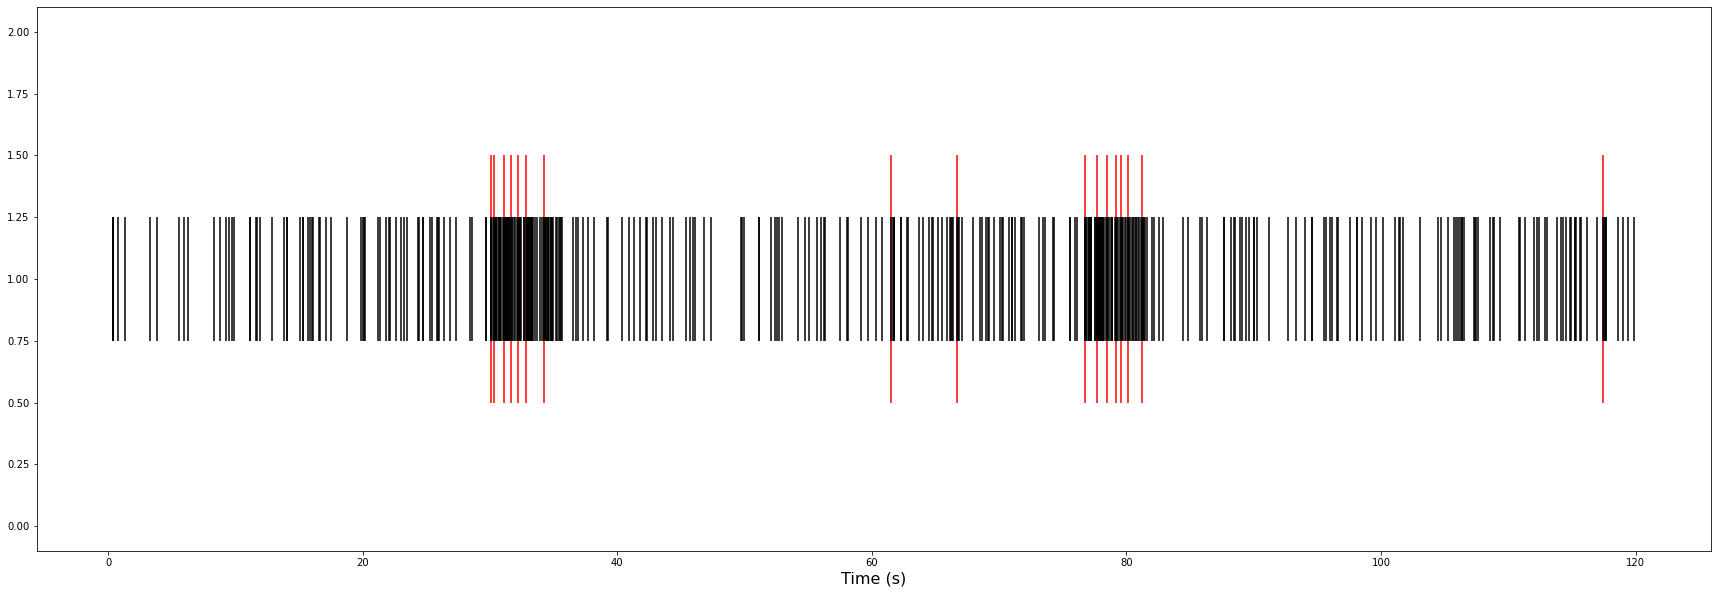

Text(0.5, 0, 'Time (s)')

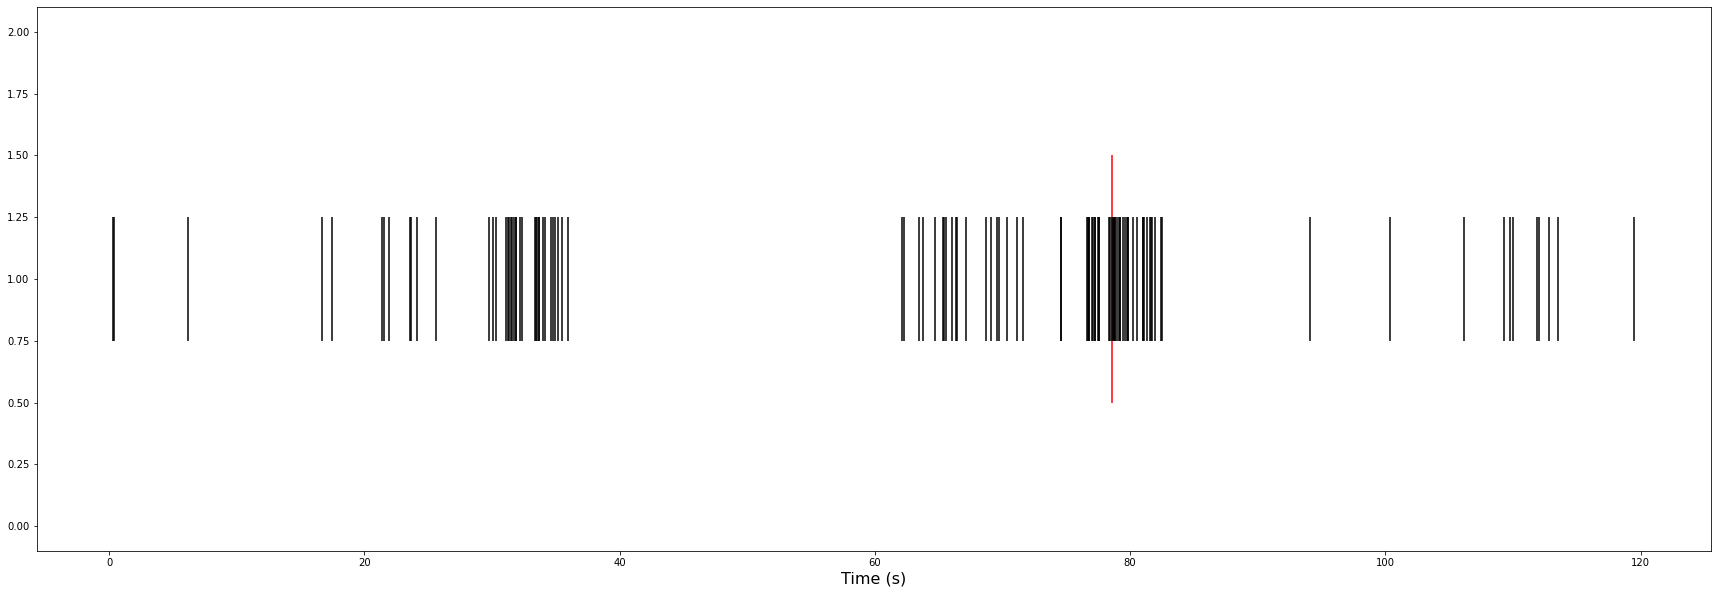

Text(0.5, 0, 'Time (s)')

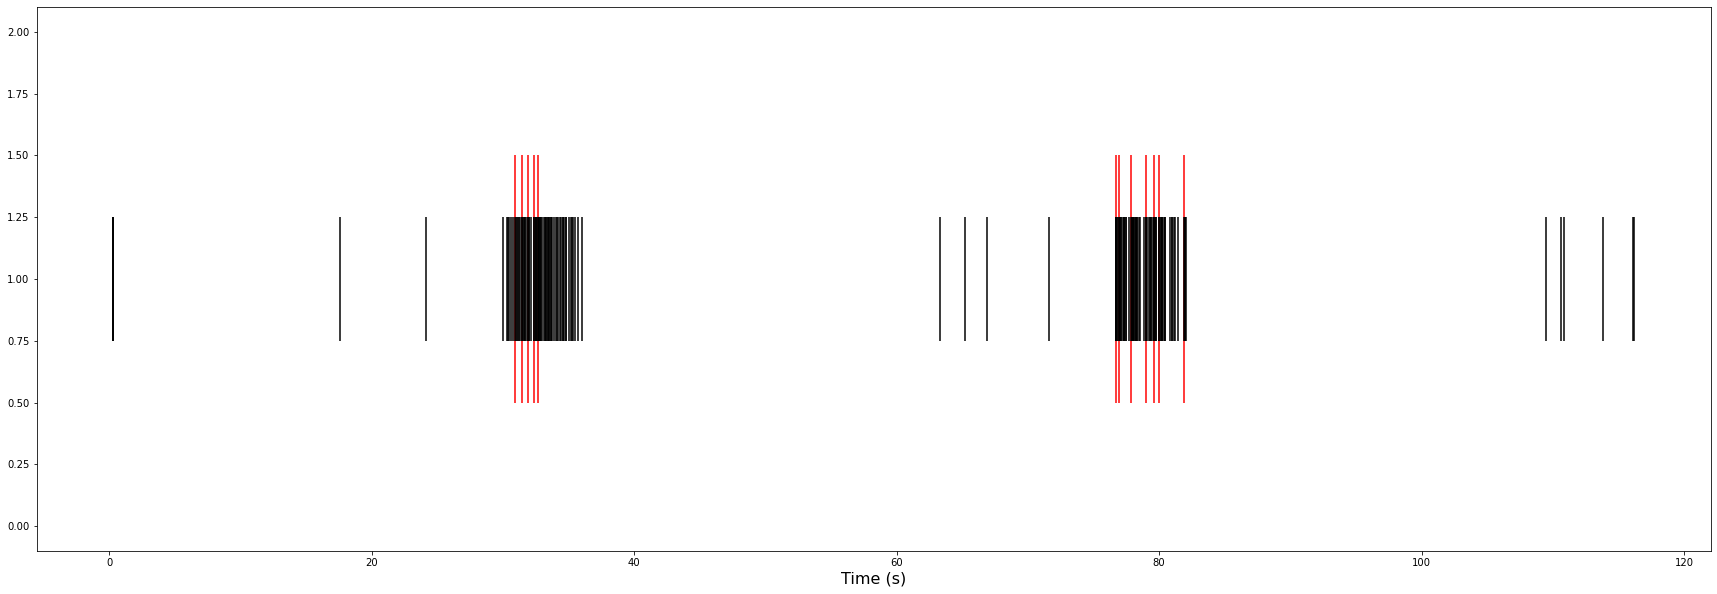

Text(0.5, 0, 'Time (s)')

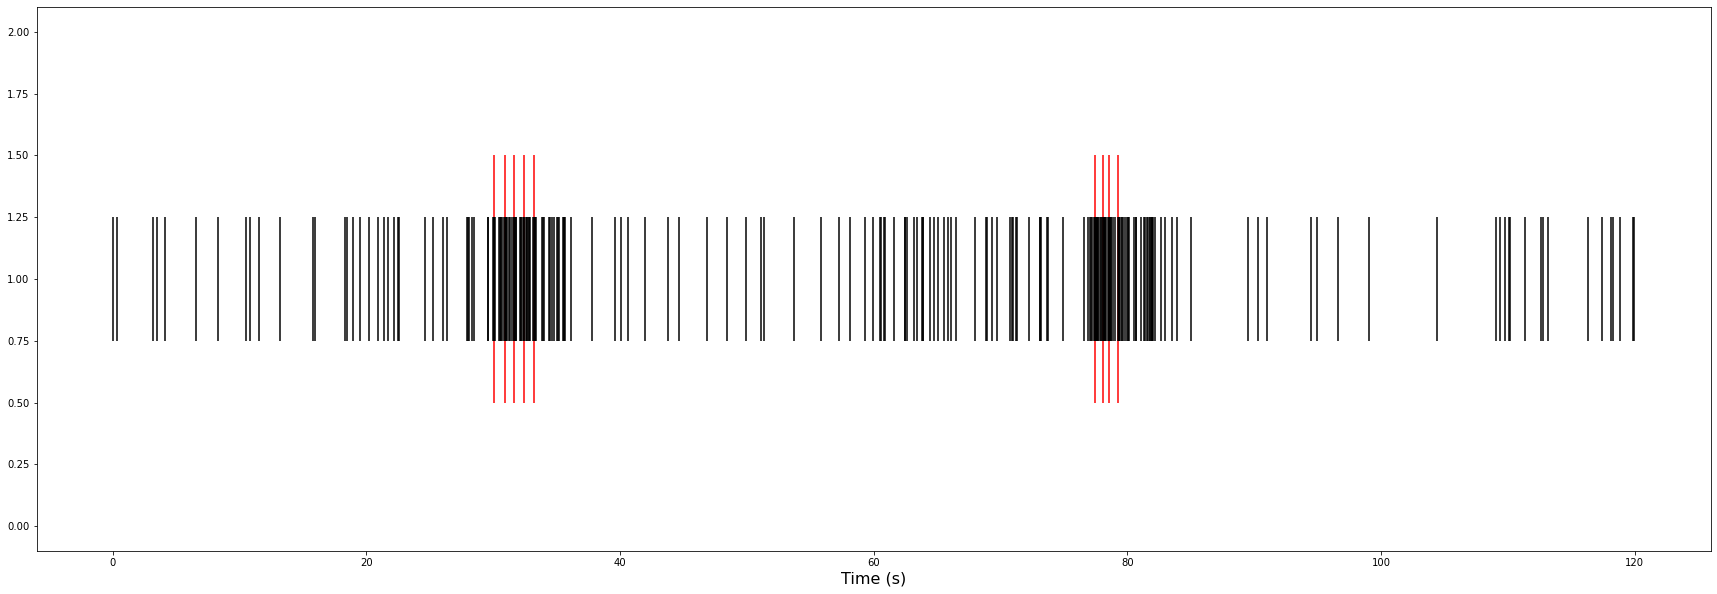

Text(0.5, 0, 'Time (s)')

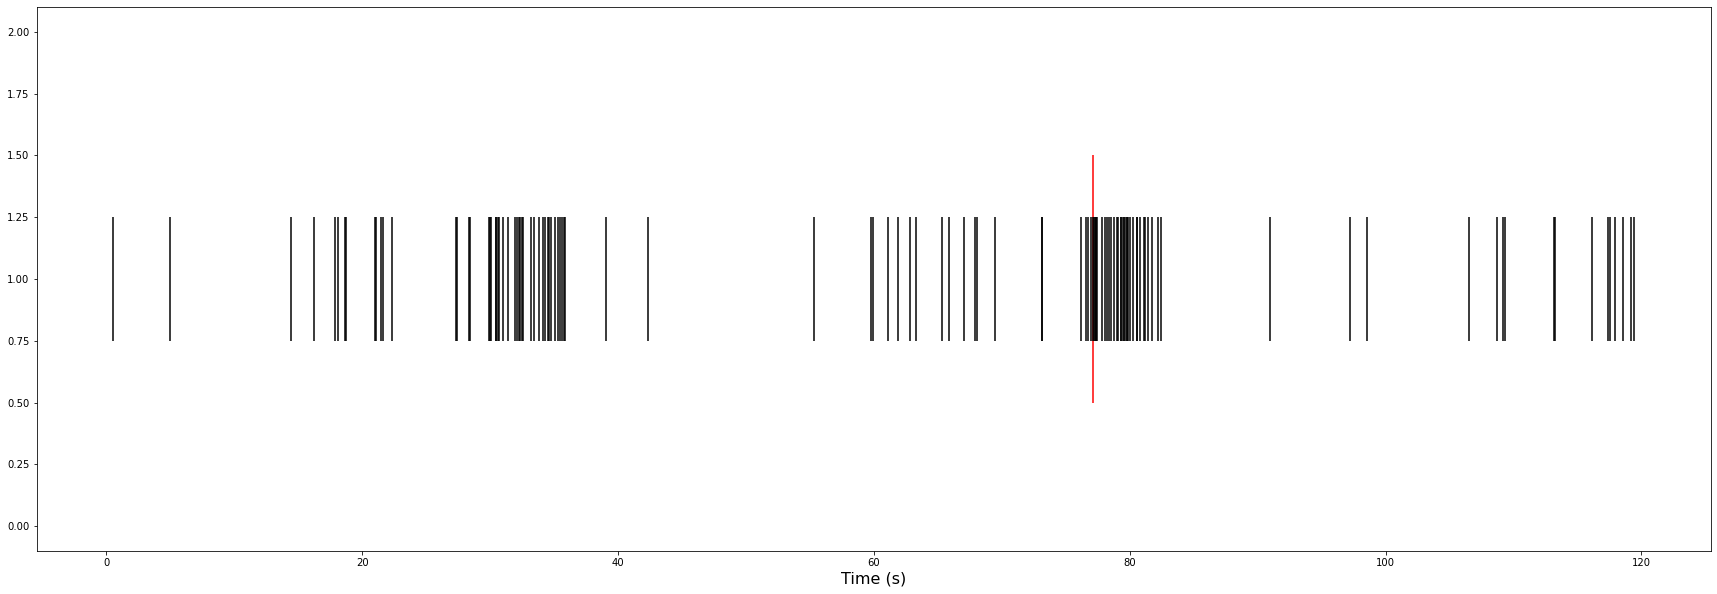

Text(0.5, 0, 'Time (s)')

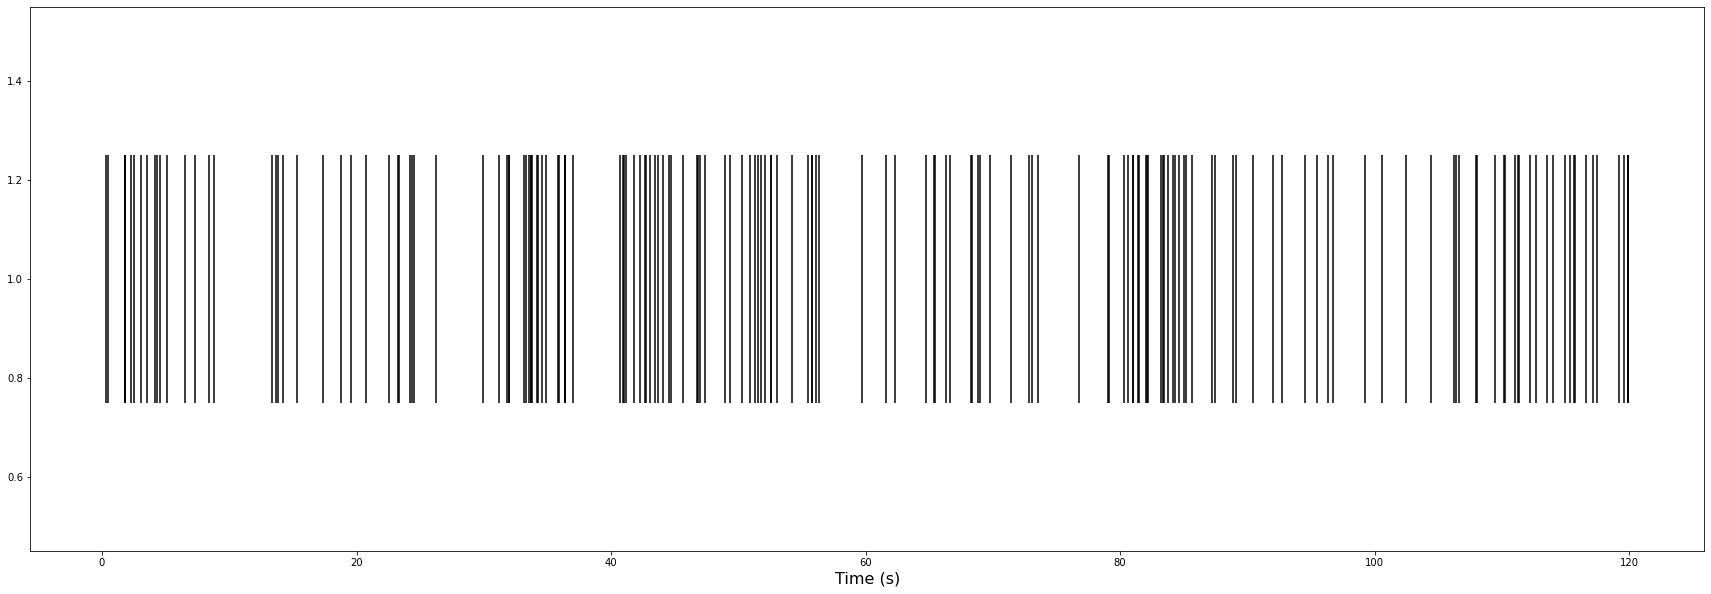

Text(0.5, 0, 'Time (s)')

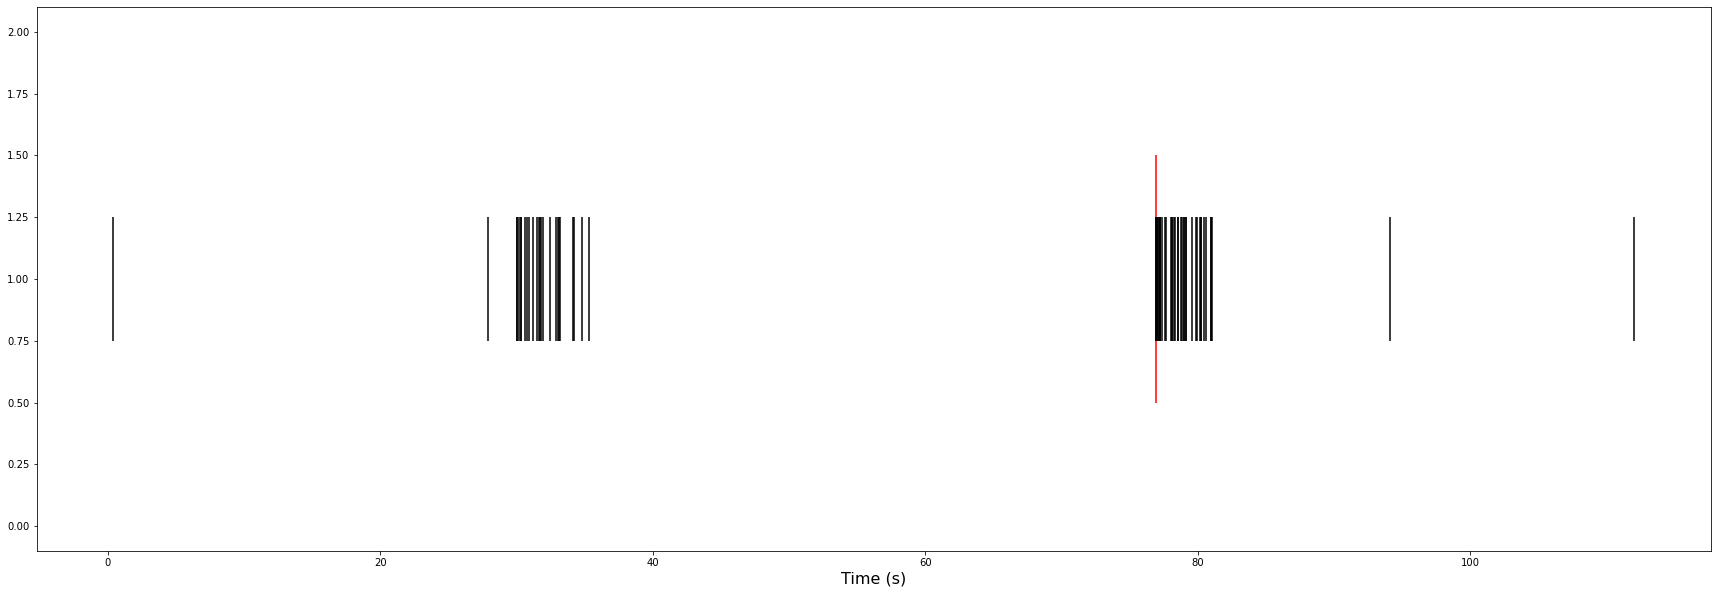

Text(0.5, 0, 'Time (s)')

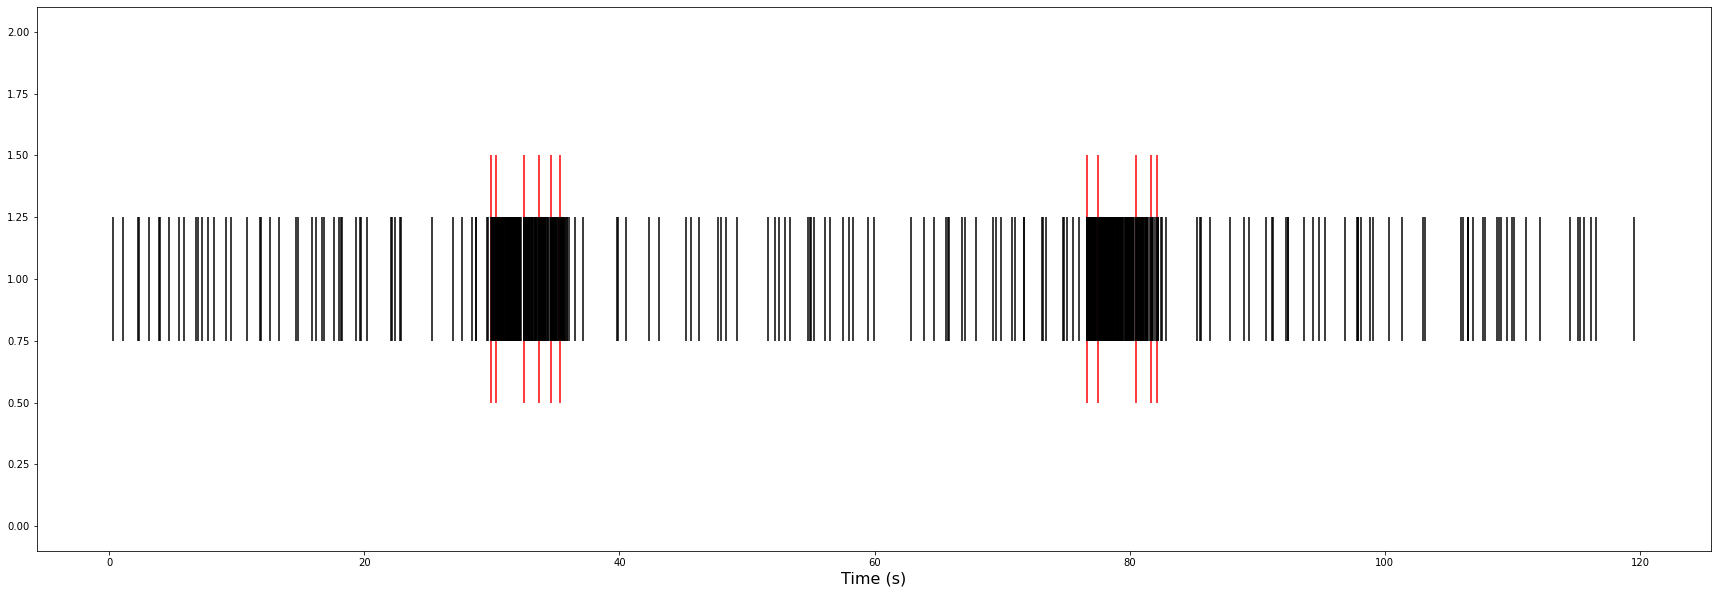

Text(0.5, 0, 'Time (s)')

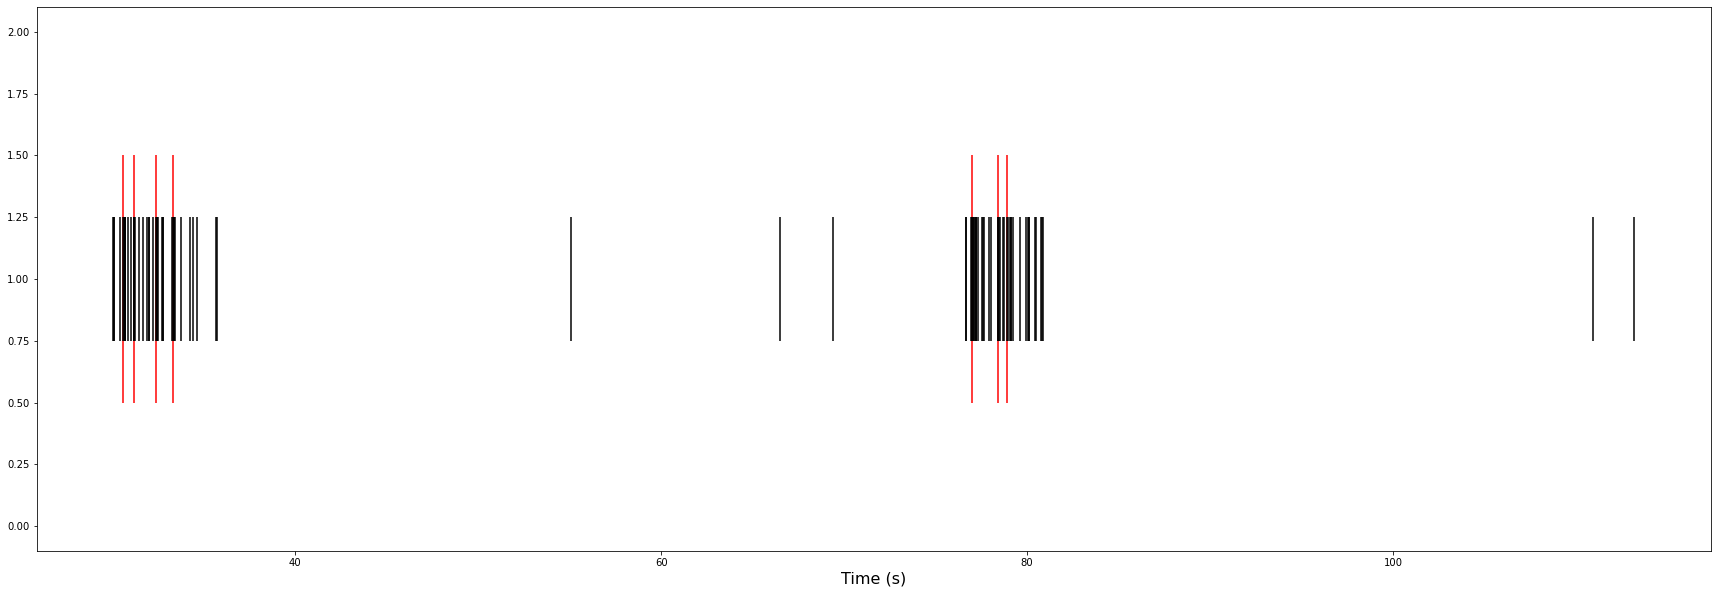

Text(0.5, 0, 'Time (s)')

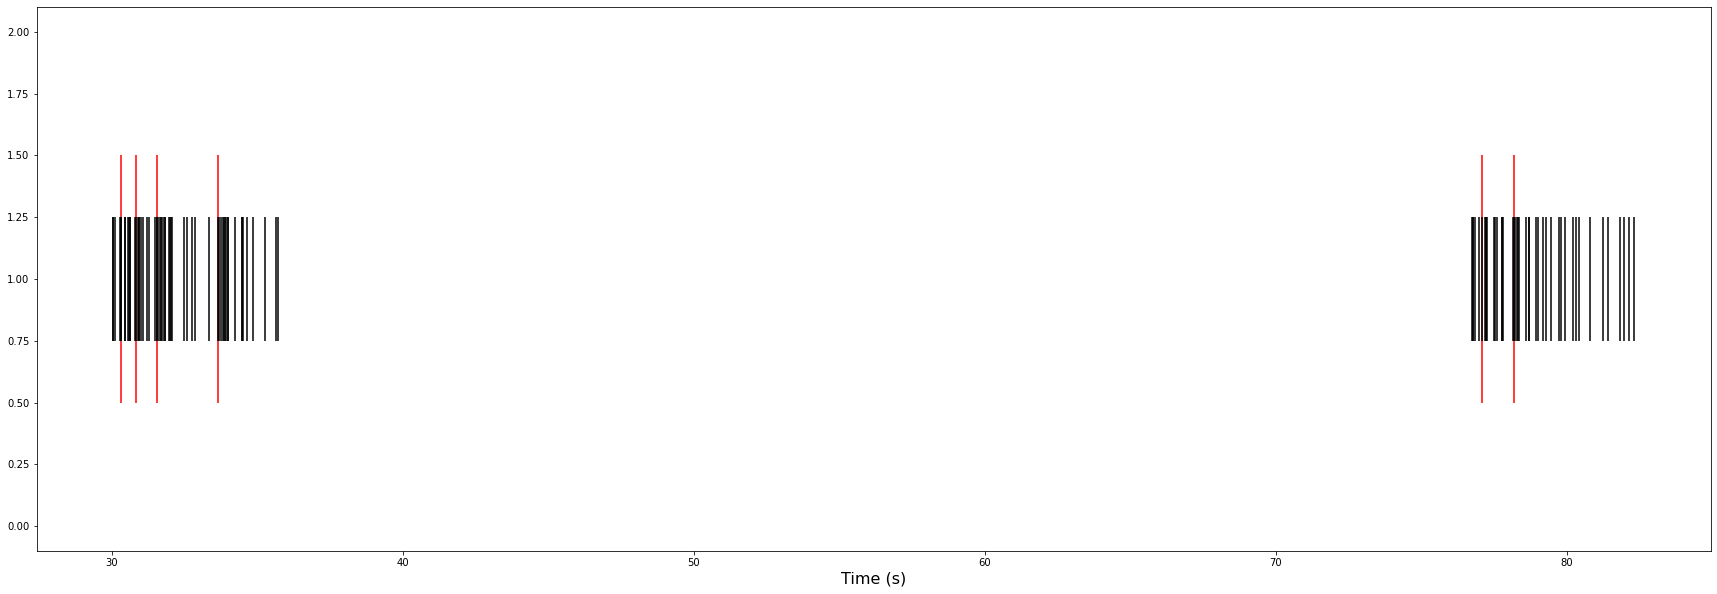

Text(0.5, 0, 'Time (s)')

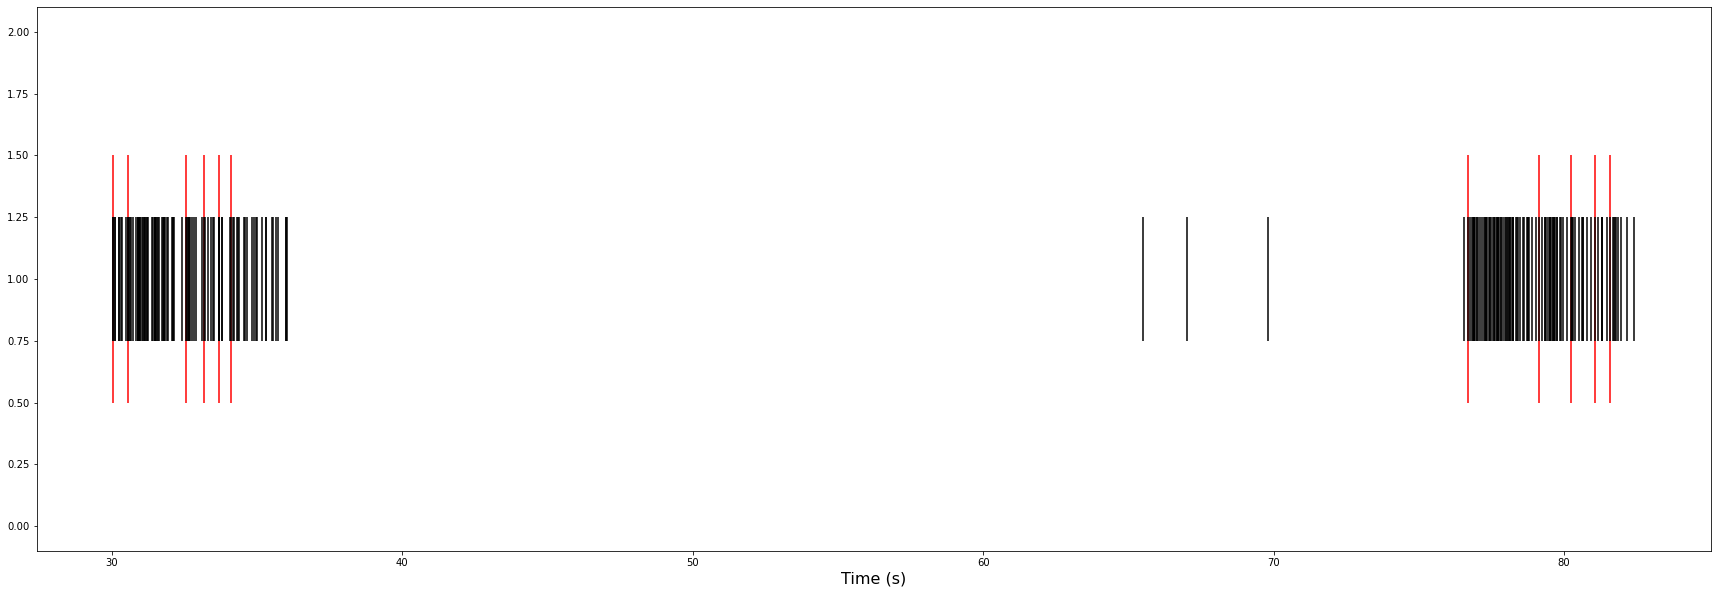

Text(0.5, 0, 'Time (s)')

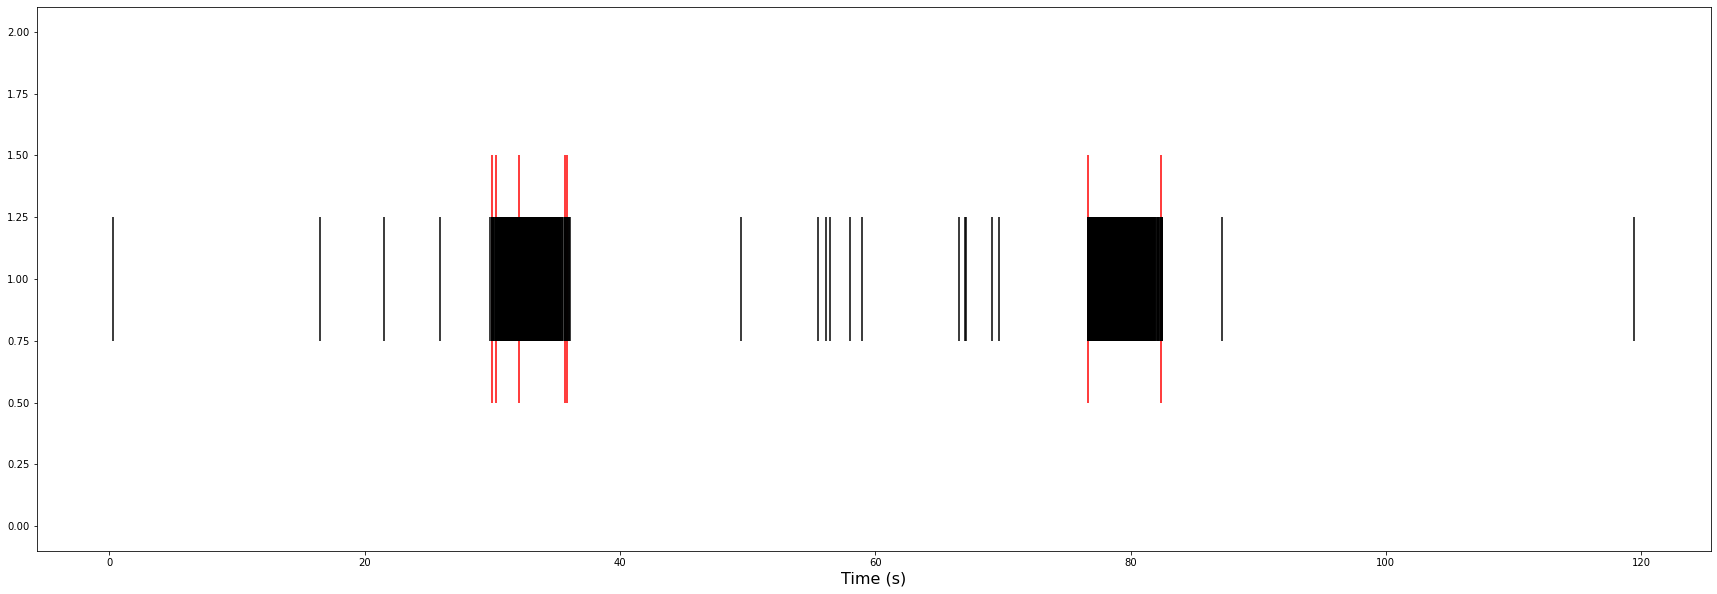

Text(0.5, 0, 'Time (s)')

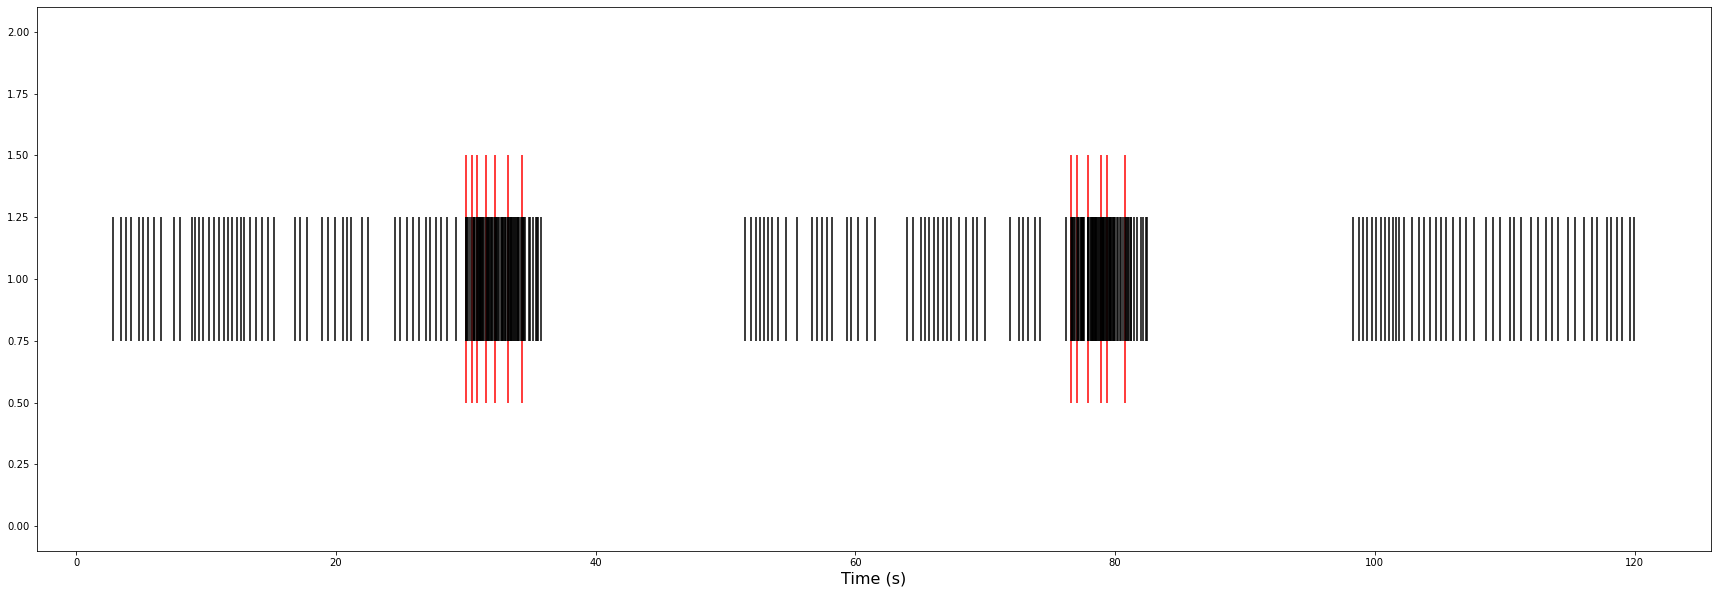

Text(0.5, 0, 'Time (s)')

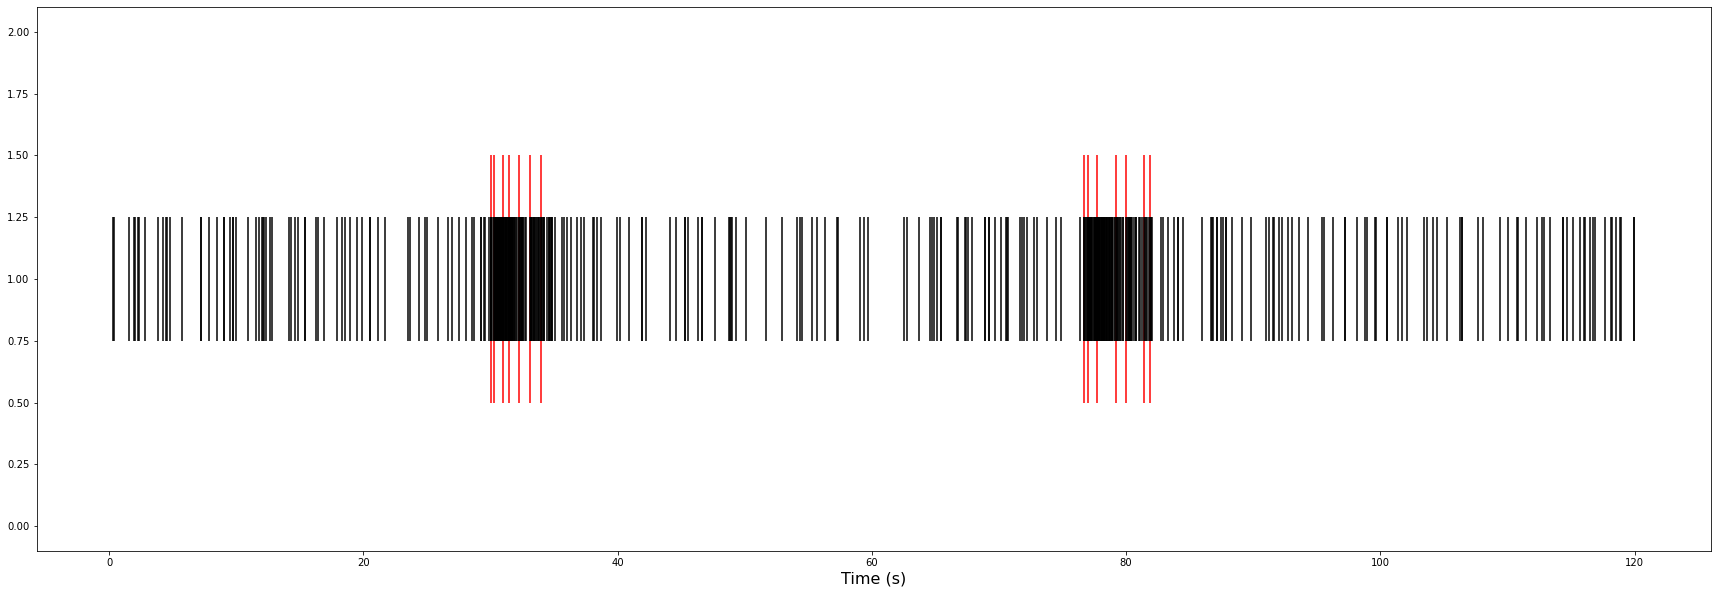

Text(0.5, 0, 'Time (s)')

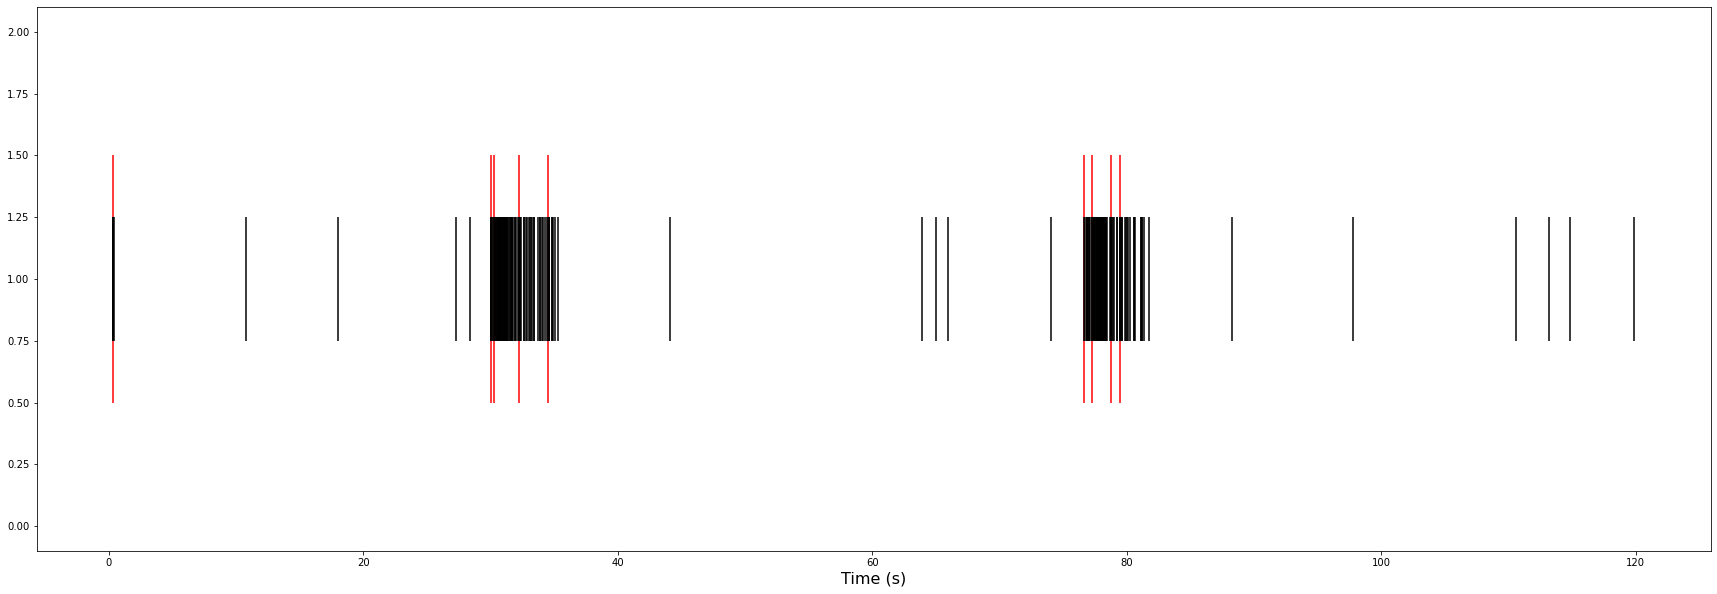

Text(0.5, 0, 'Time (s)')

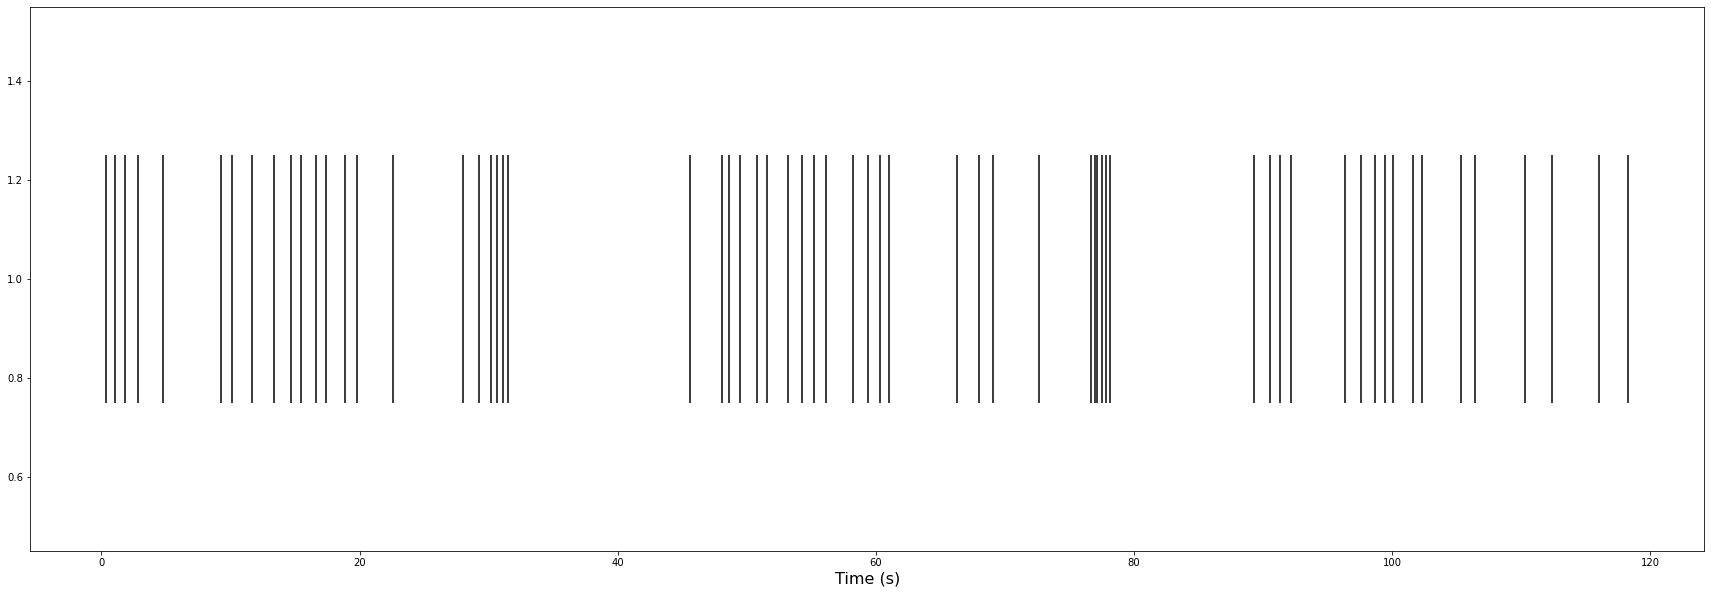

Text(0.5, 0, 'Time (s)')

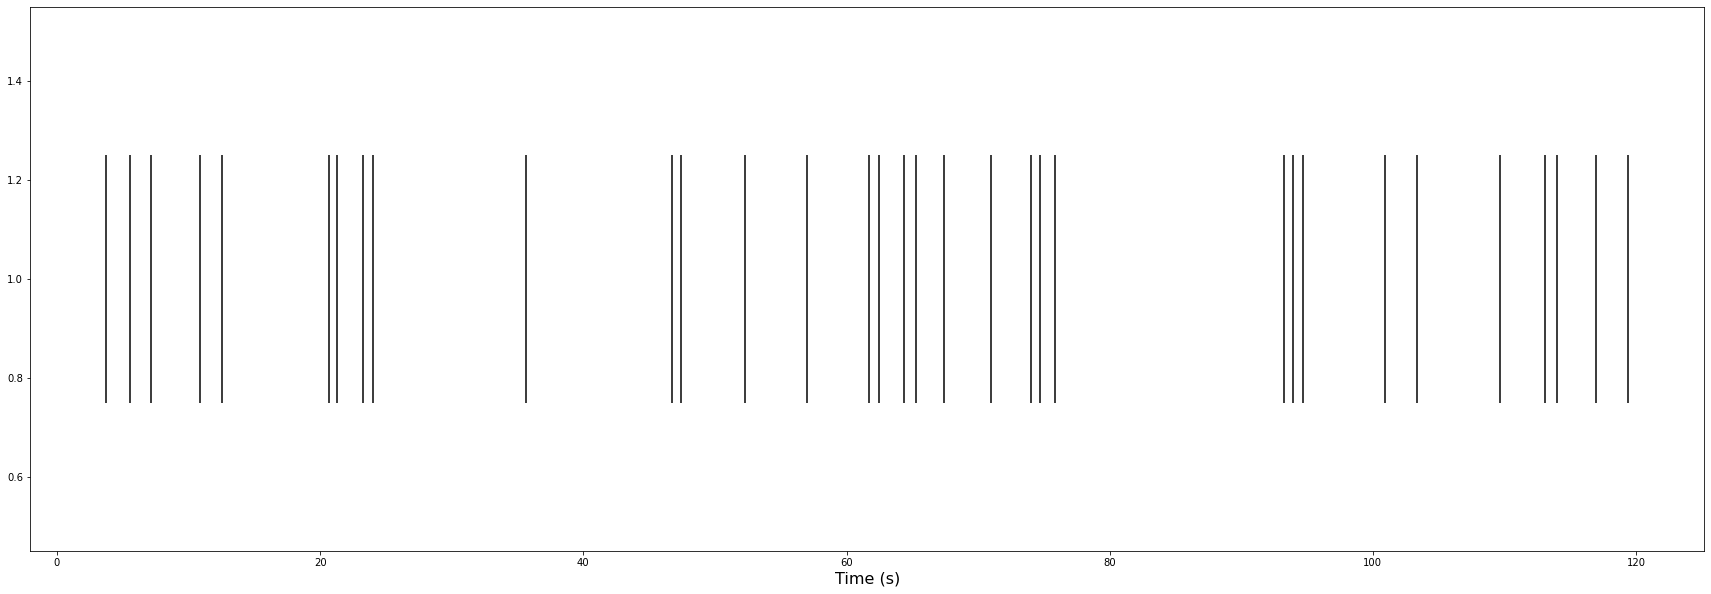

Text(0.5, 0, 'Time (s)')

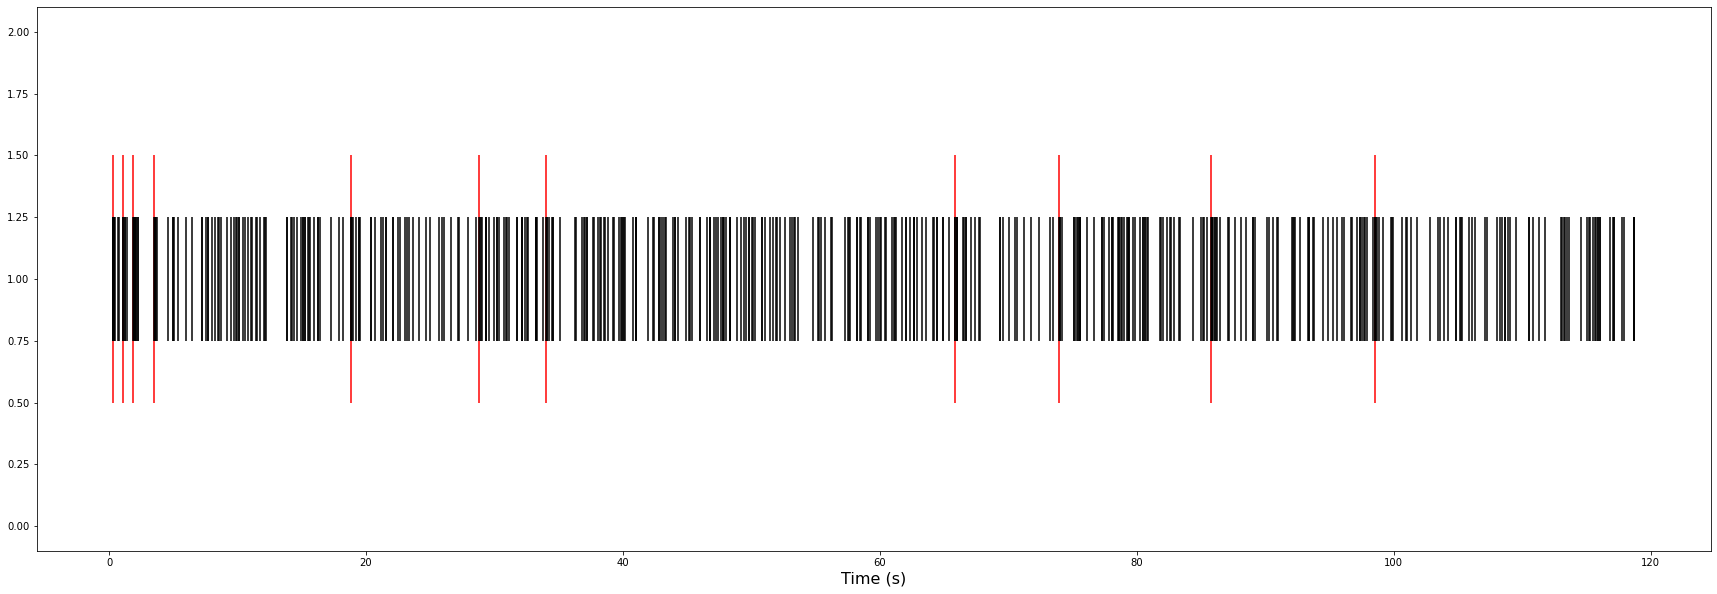

Text(0.5, 0, 'Time (s)')

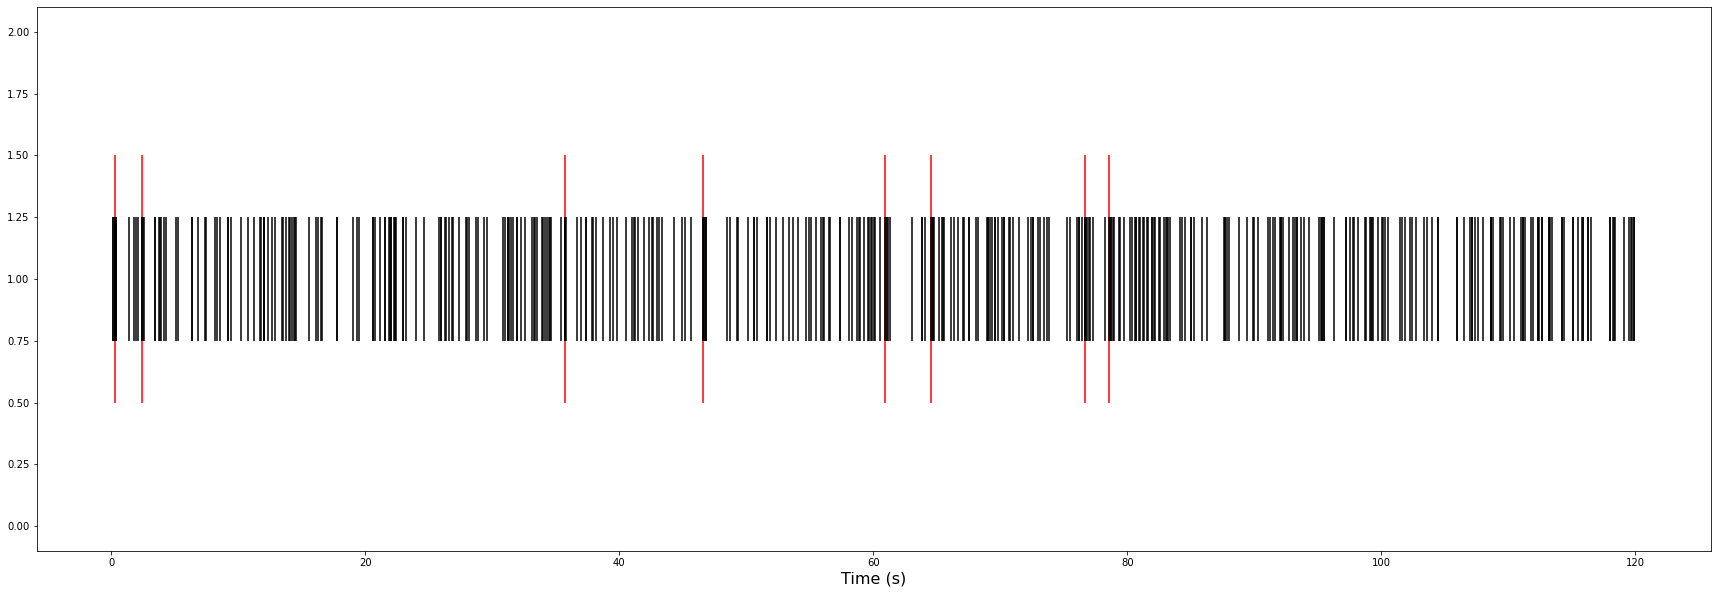

Text(0.5, 0, 'Time (s)')

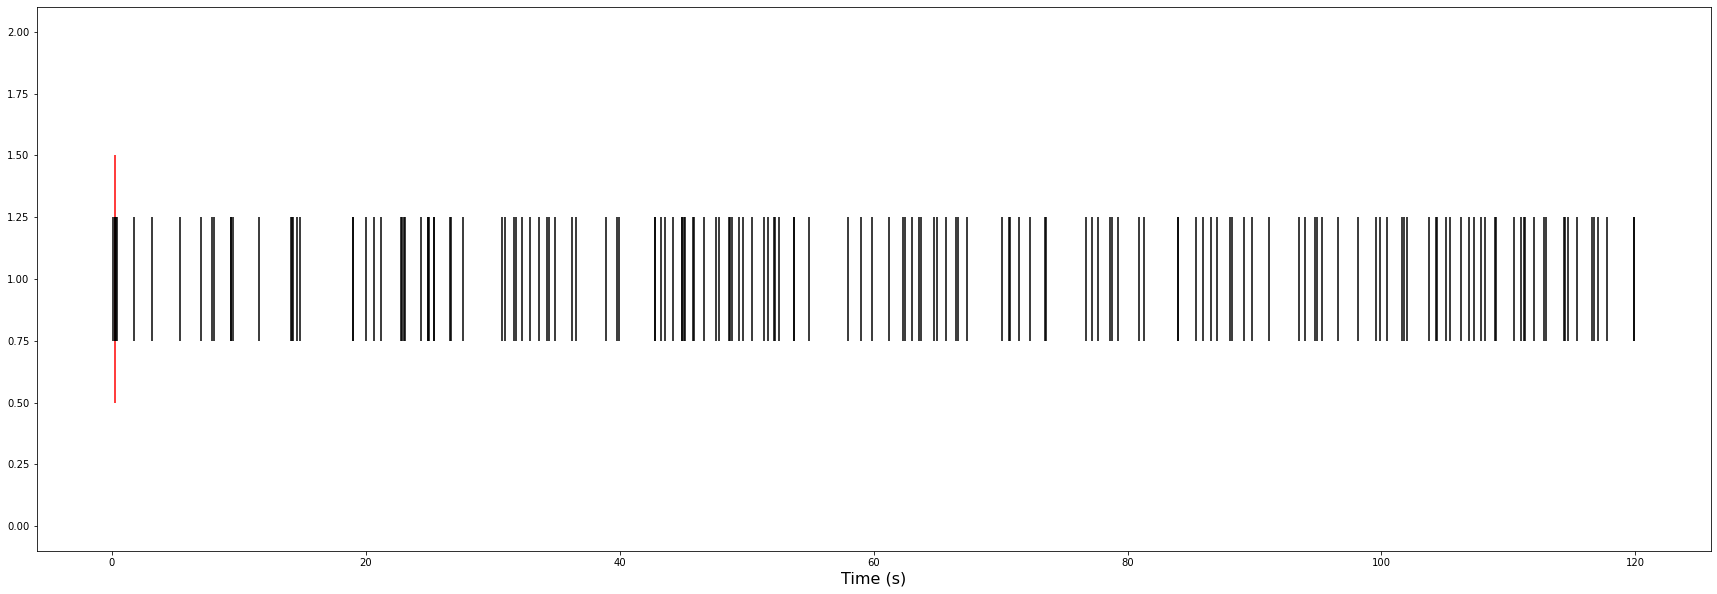

Text(0.5, 0, 'Time (s)')

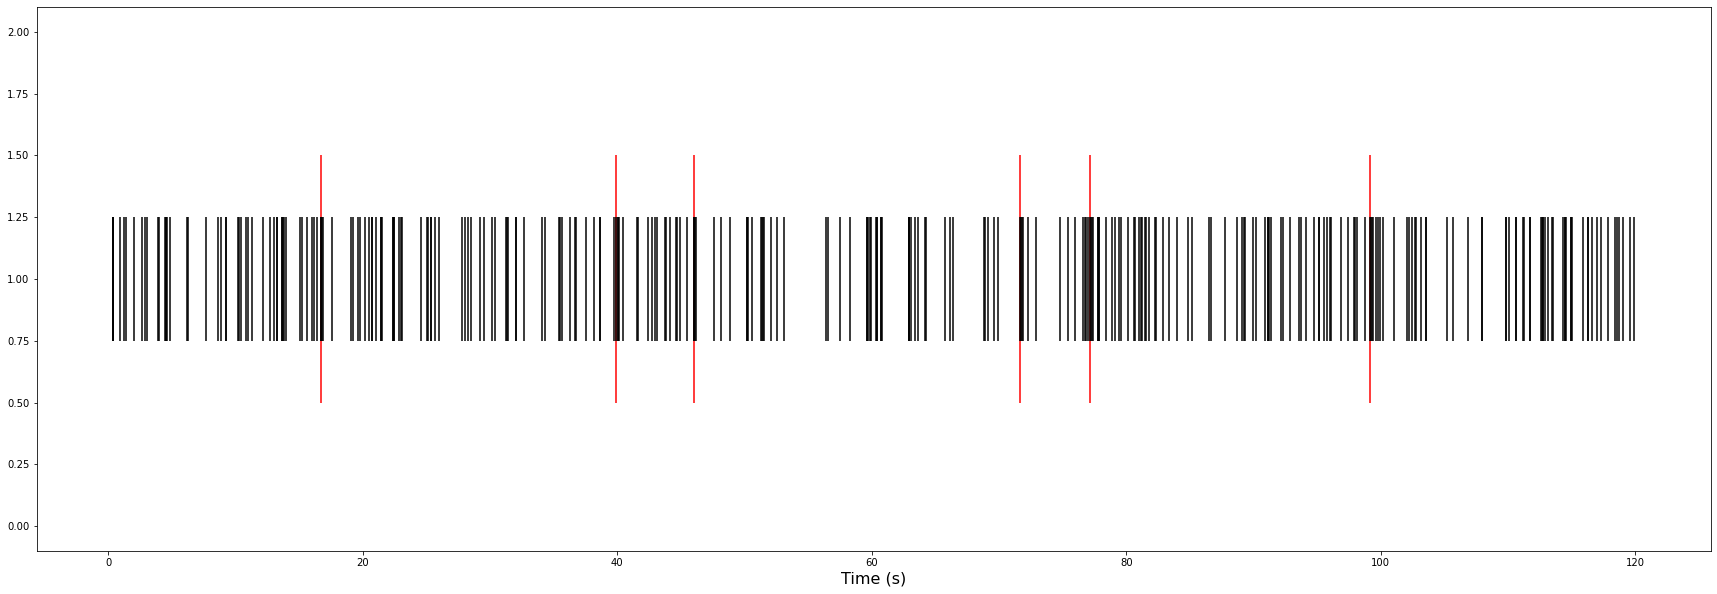

Text(0.5, 0, 'Time (s)')

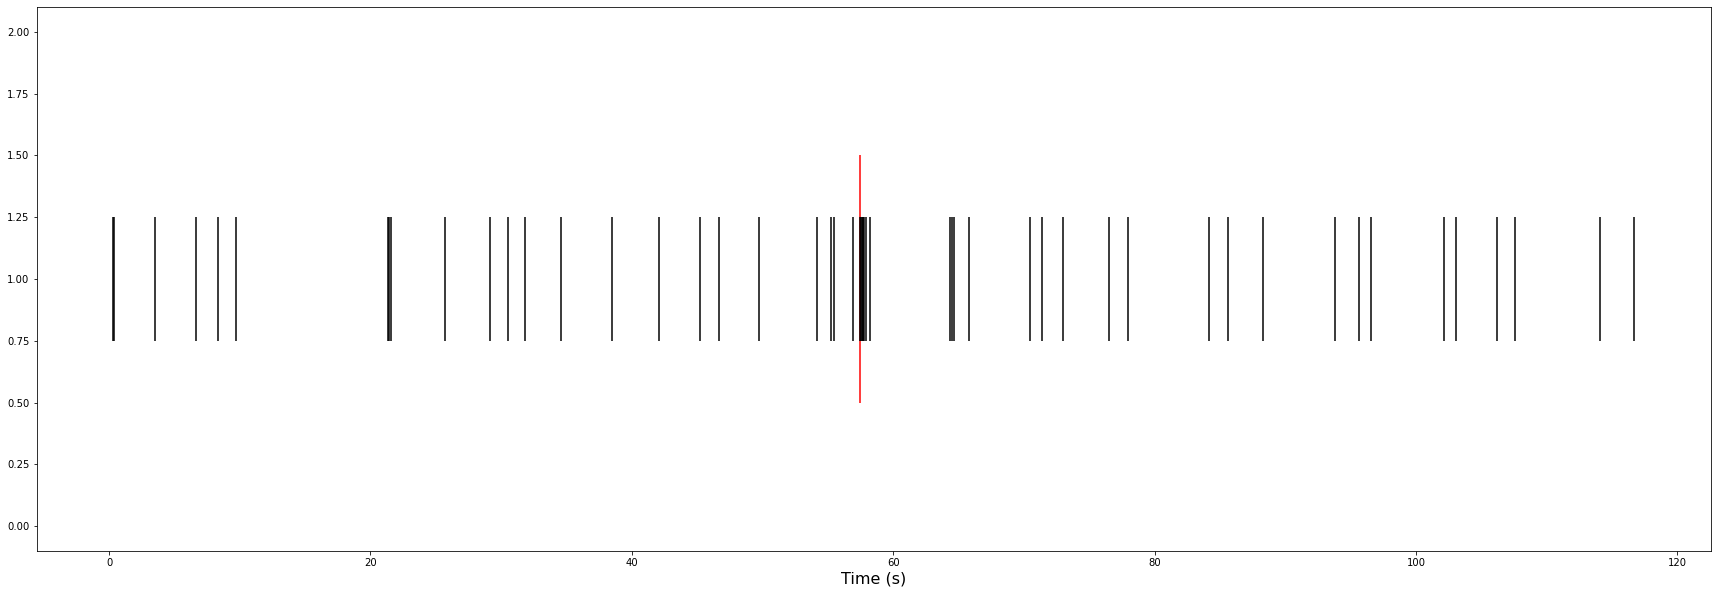

Text(0.5, 0, 'Time (s)')

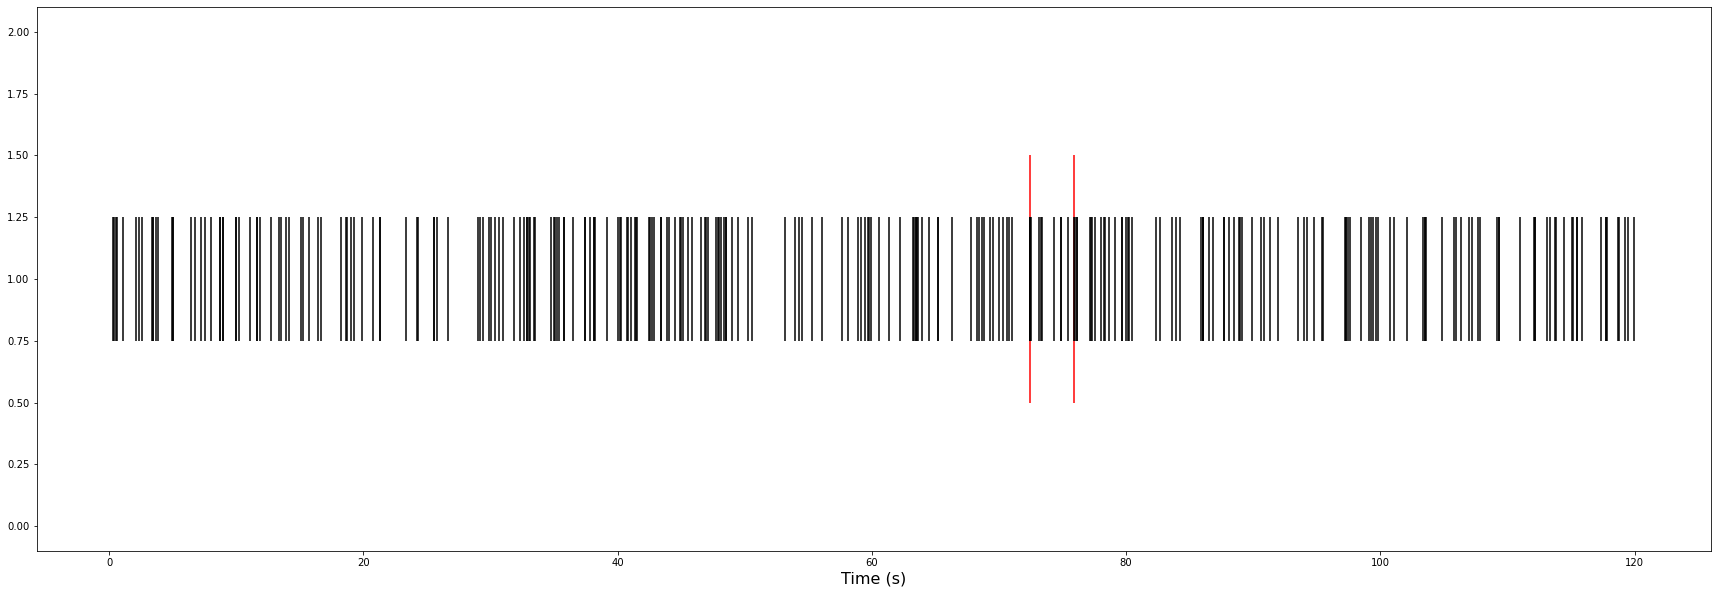

Text(0.5, 0, 'Time (s)')

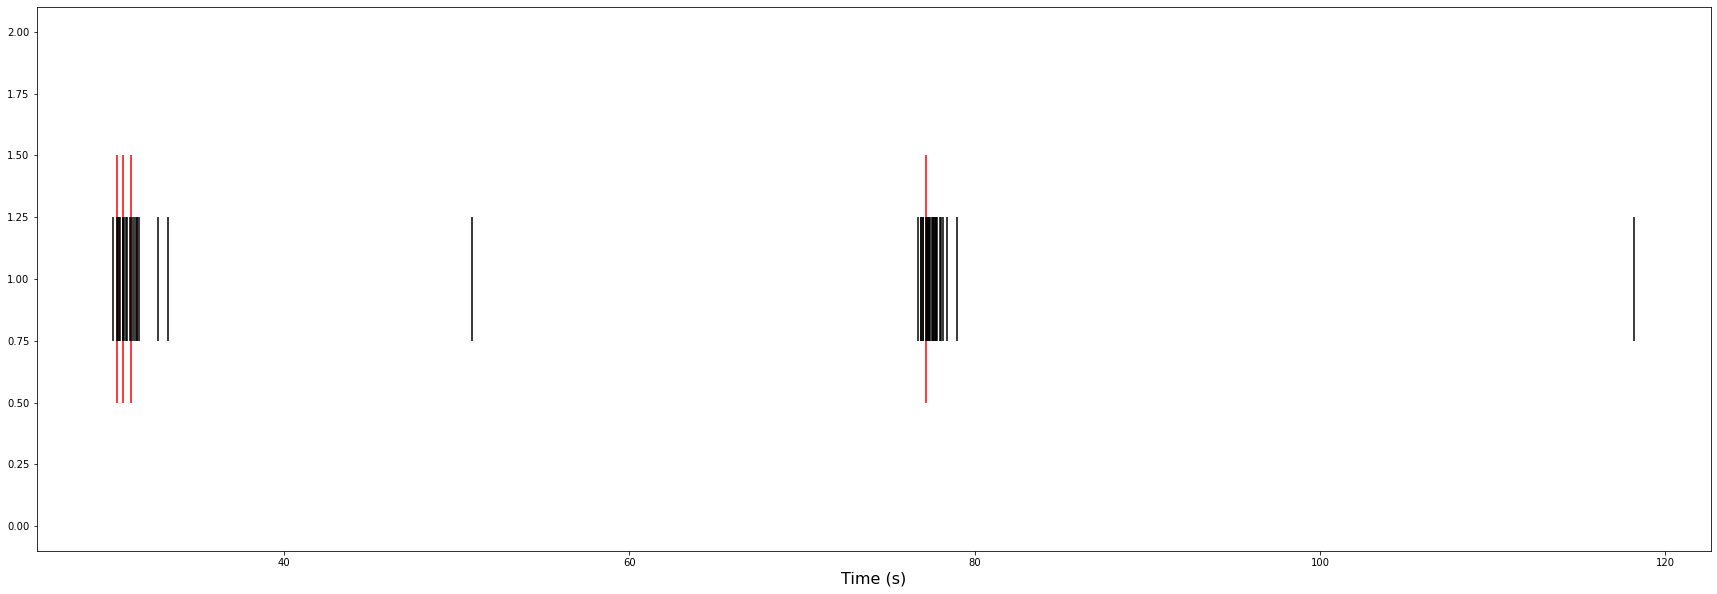

Text(0.5, 0, 'Time (s)')

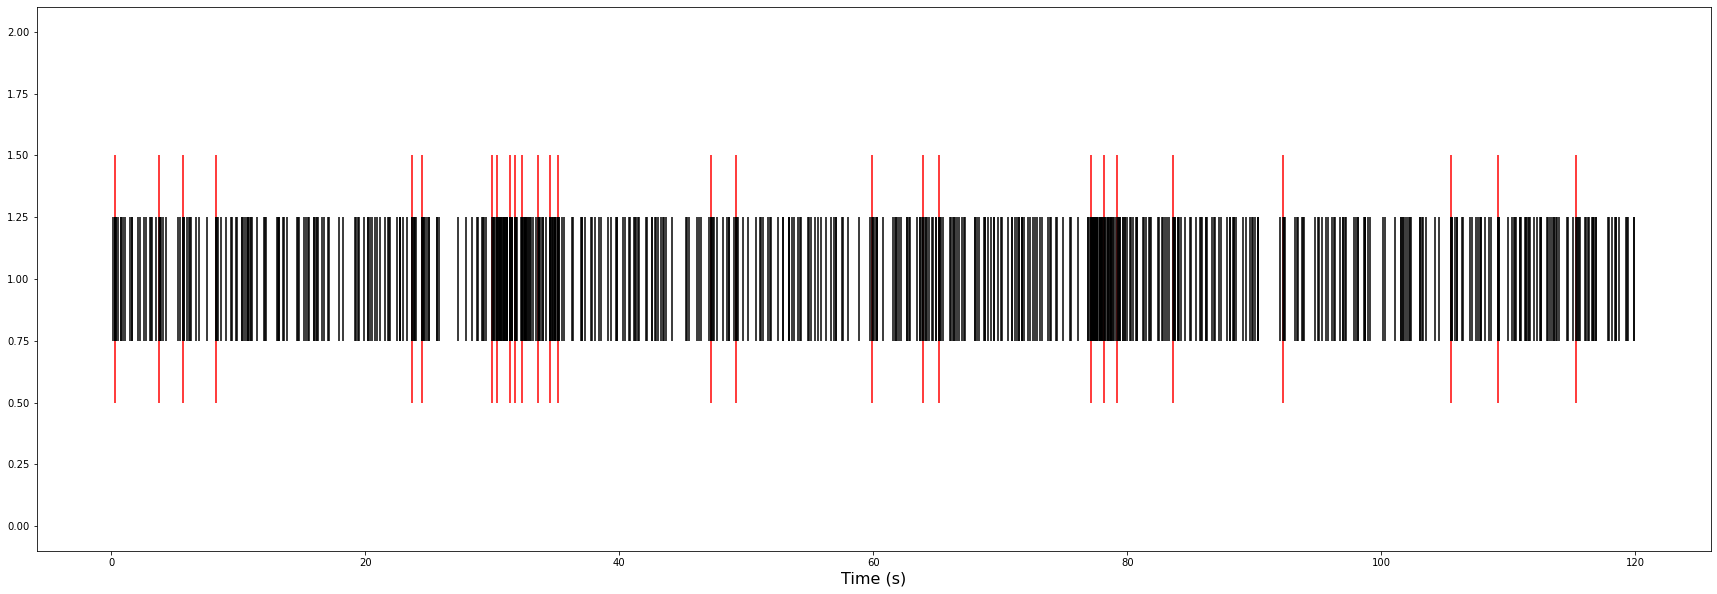

Text(0.5, 0, 'Time (s)')

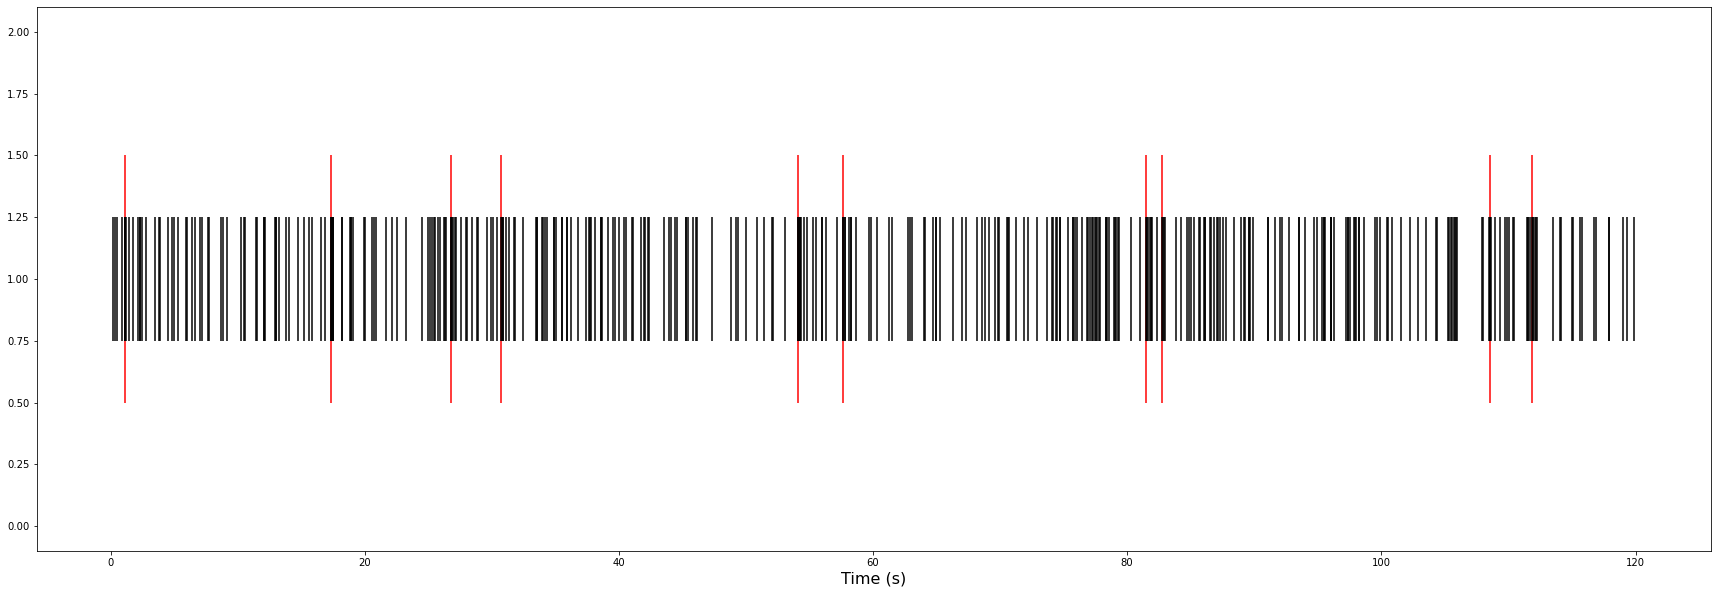

Text(0.5, 0, 'Time (s)')

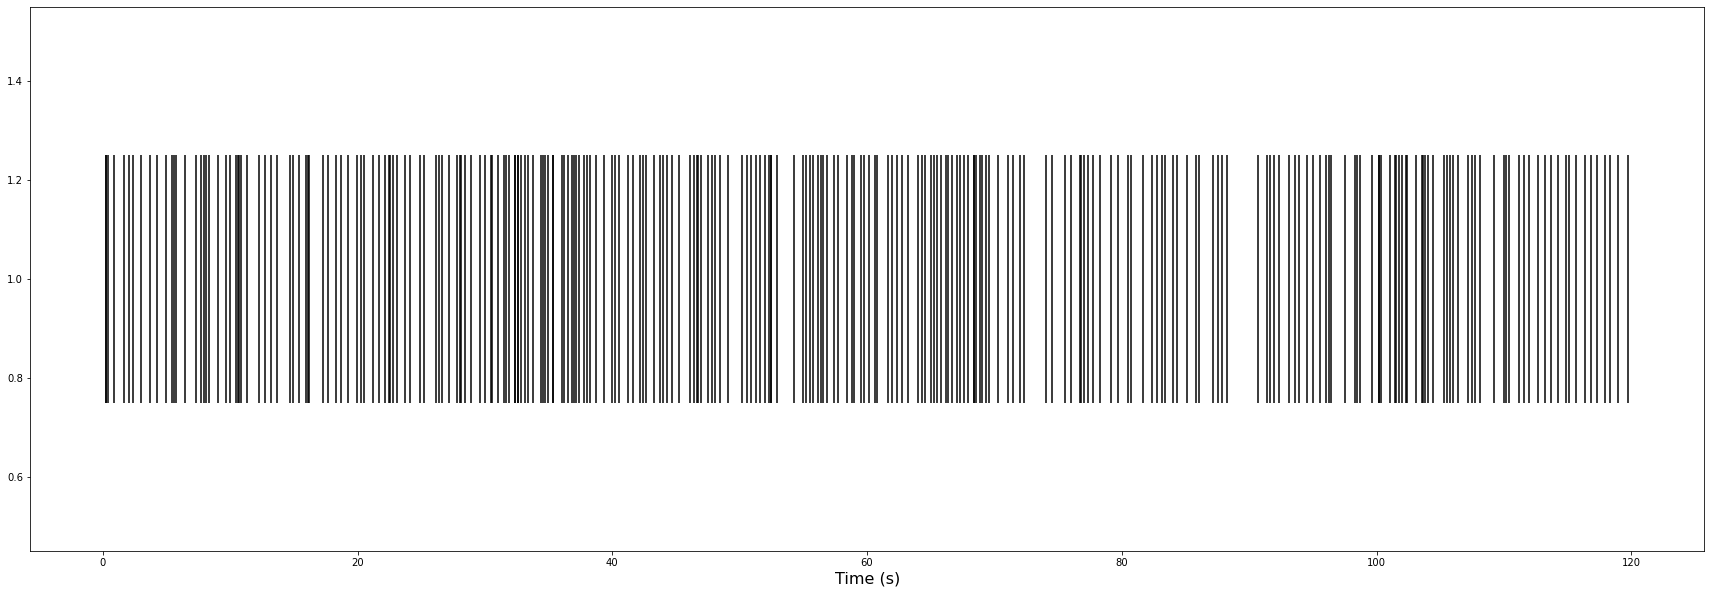

Text(0.5, 0, 'Time (s)')

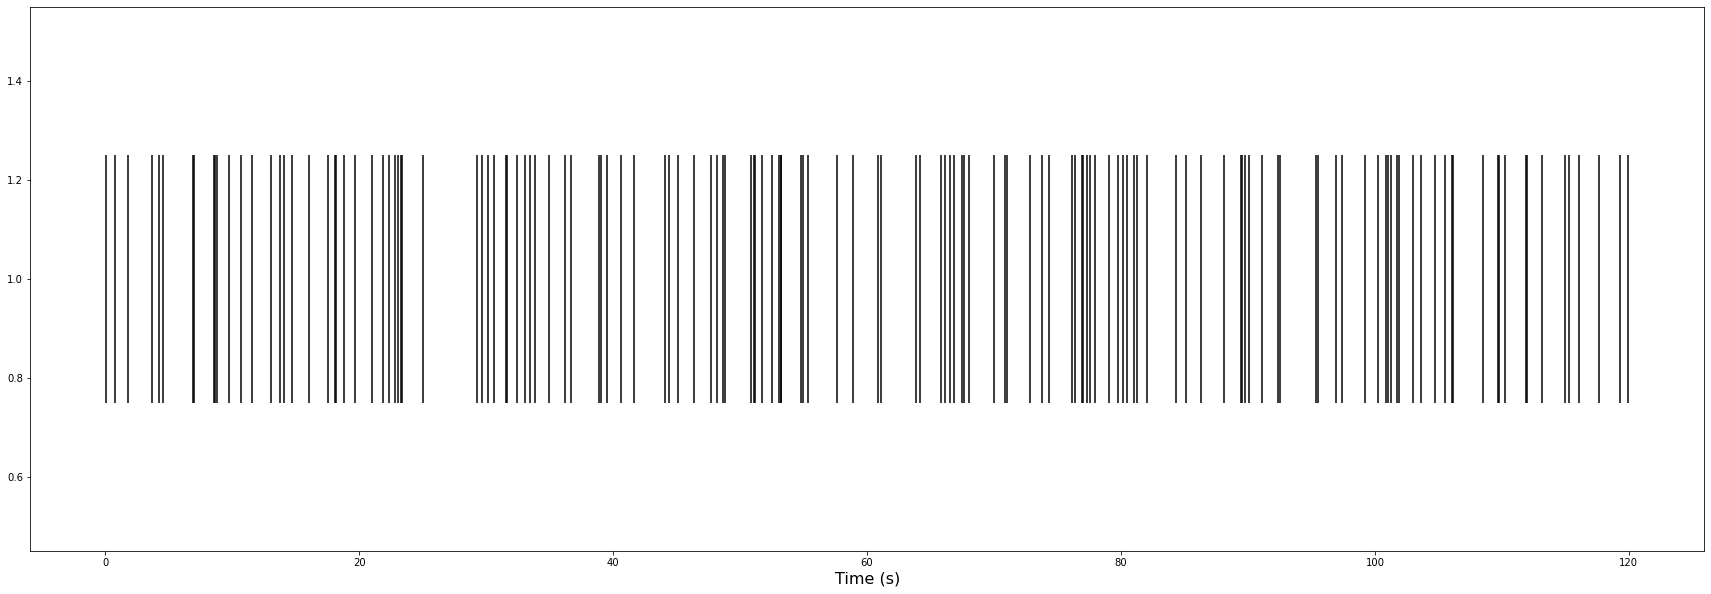

Text(0.5, 0, 'Time (s)')

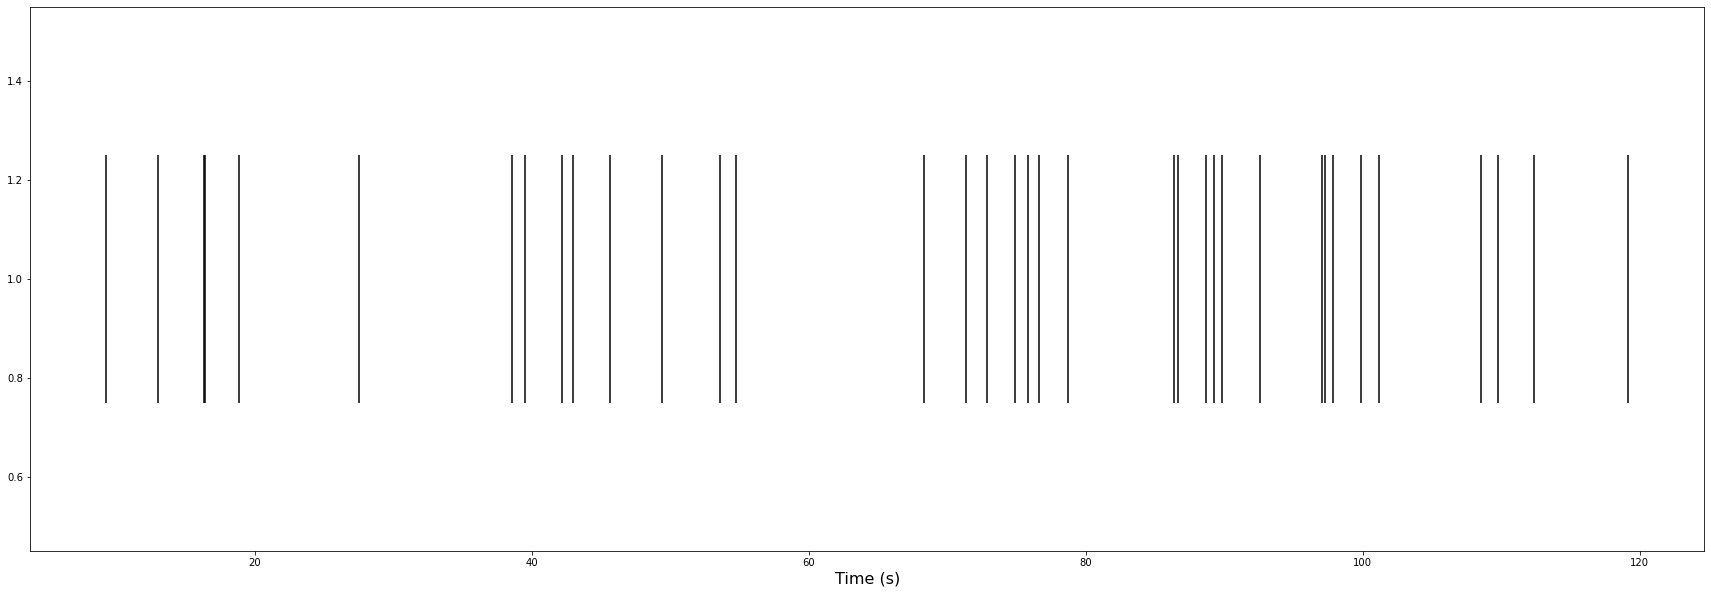

Text(0.5, 0, 'Time (s)')

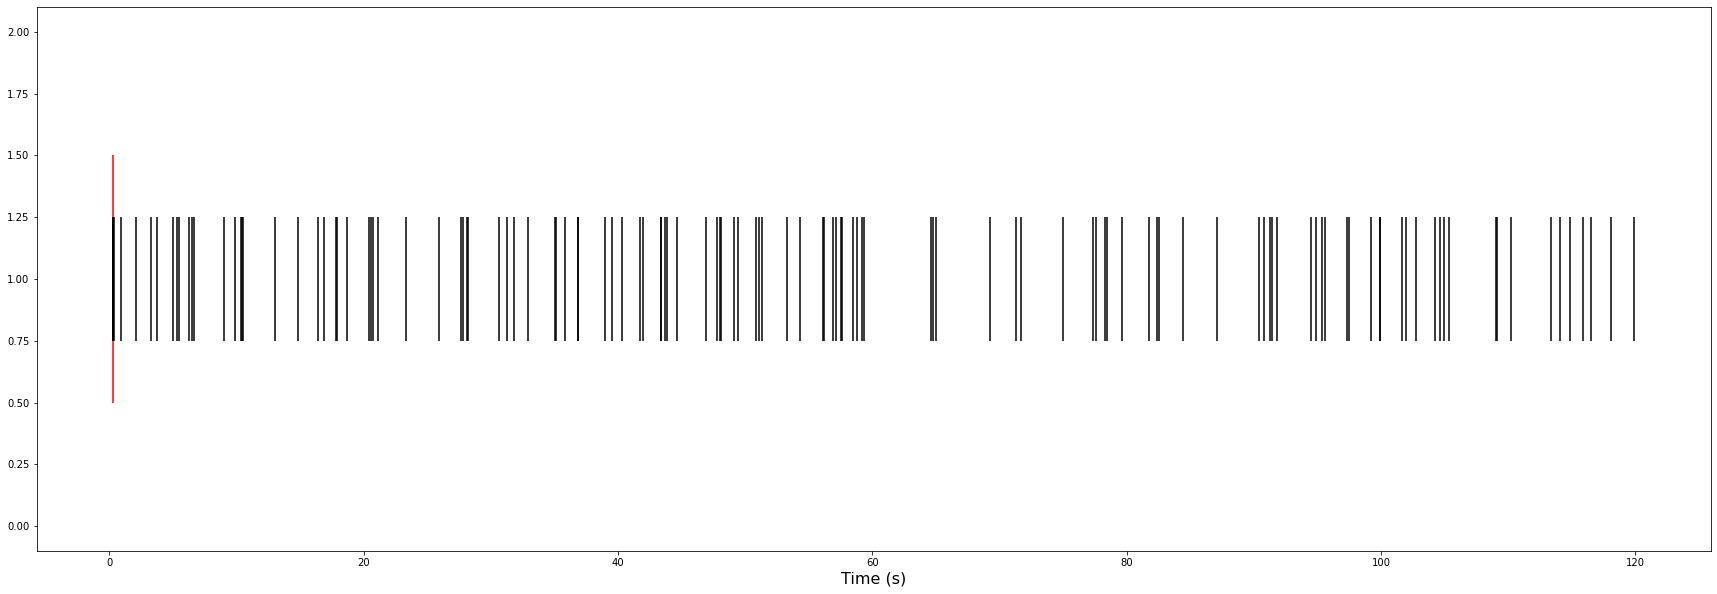

Text(0.5, 0, 'Time (s)')

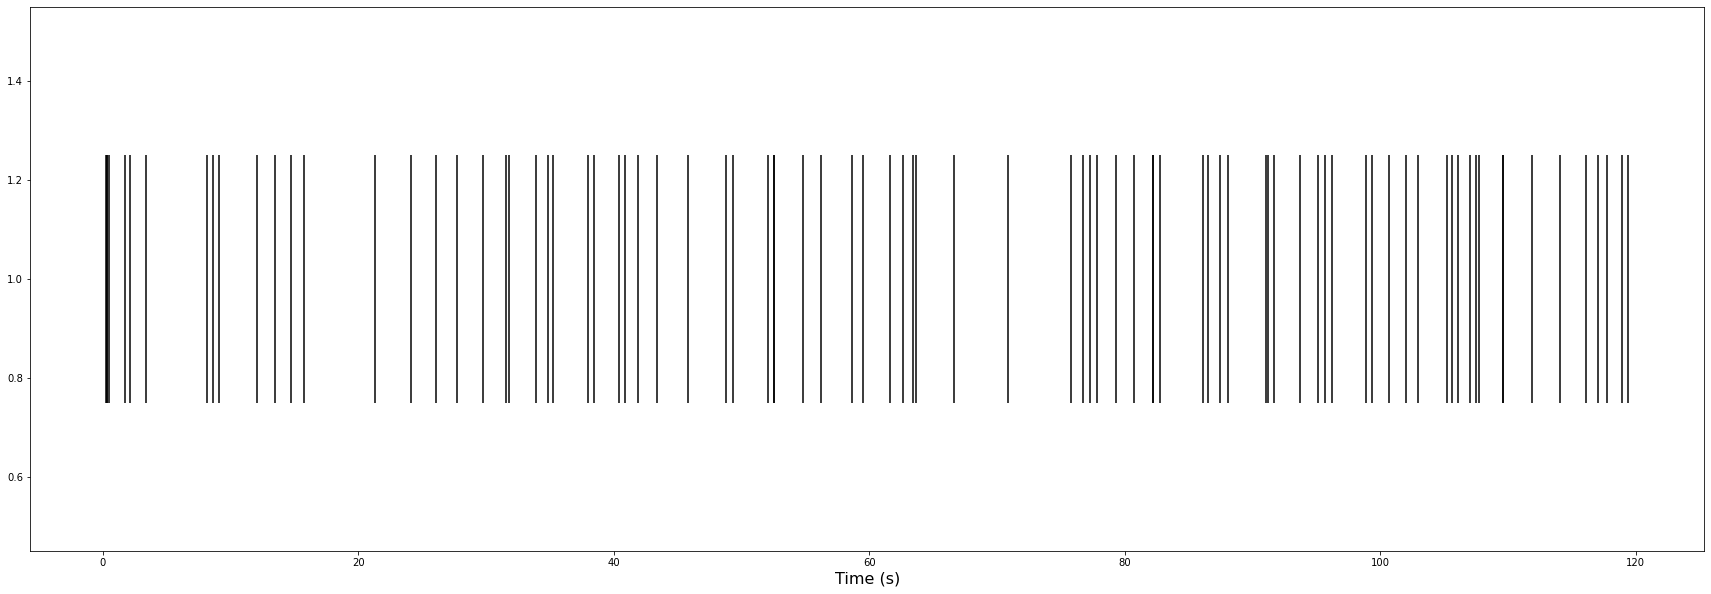

Text(0.5, 0, 'Time (s)')

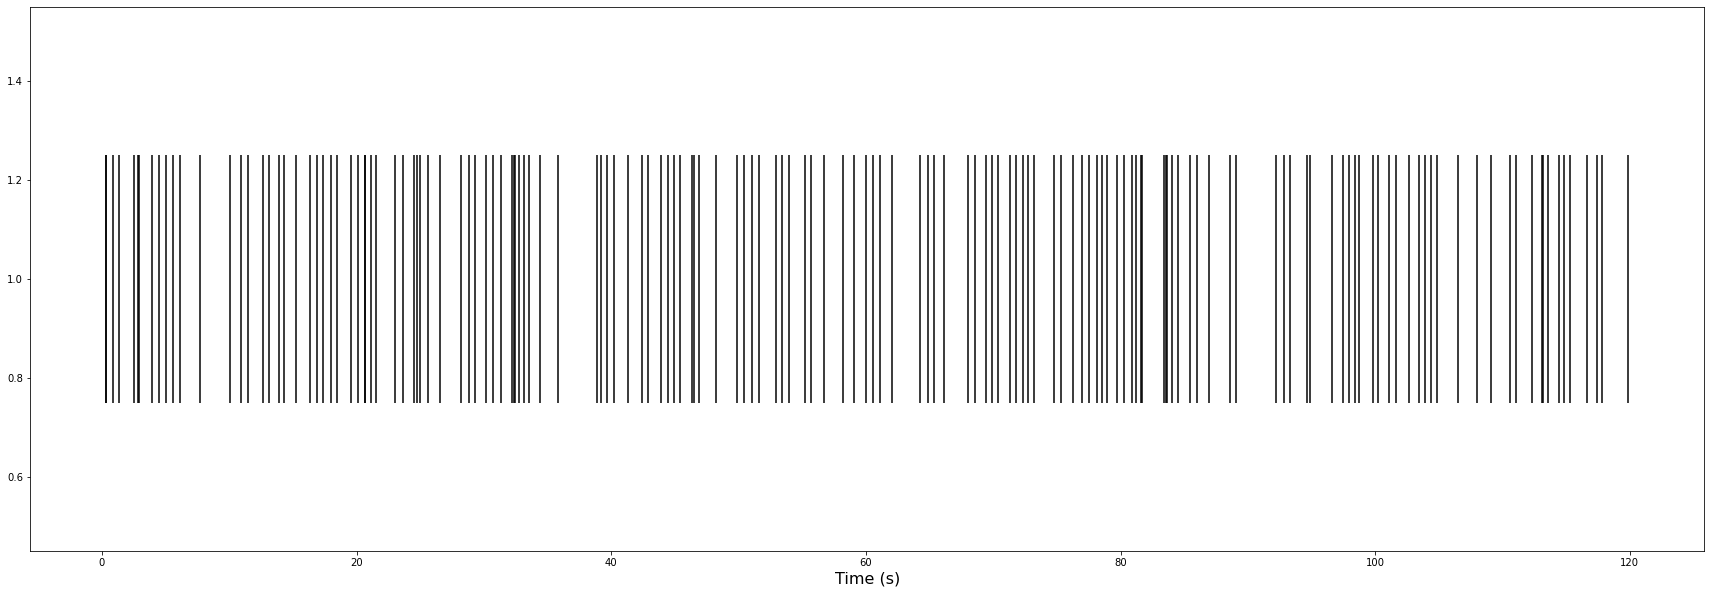

Text(0.5, 0, 'Time (s)')

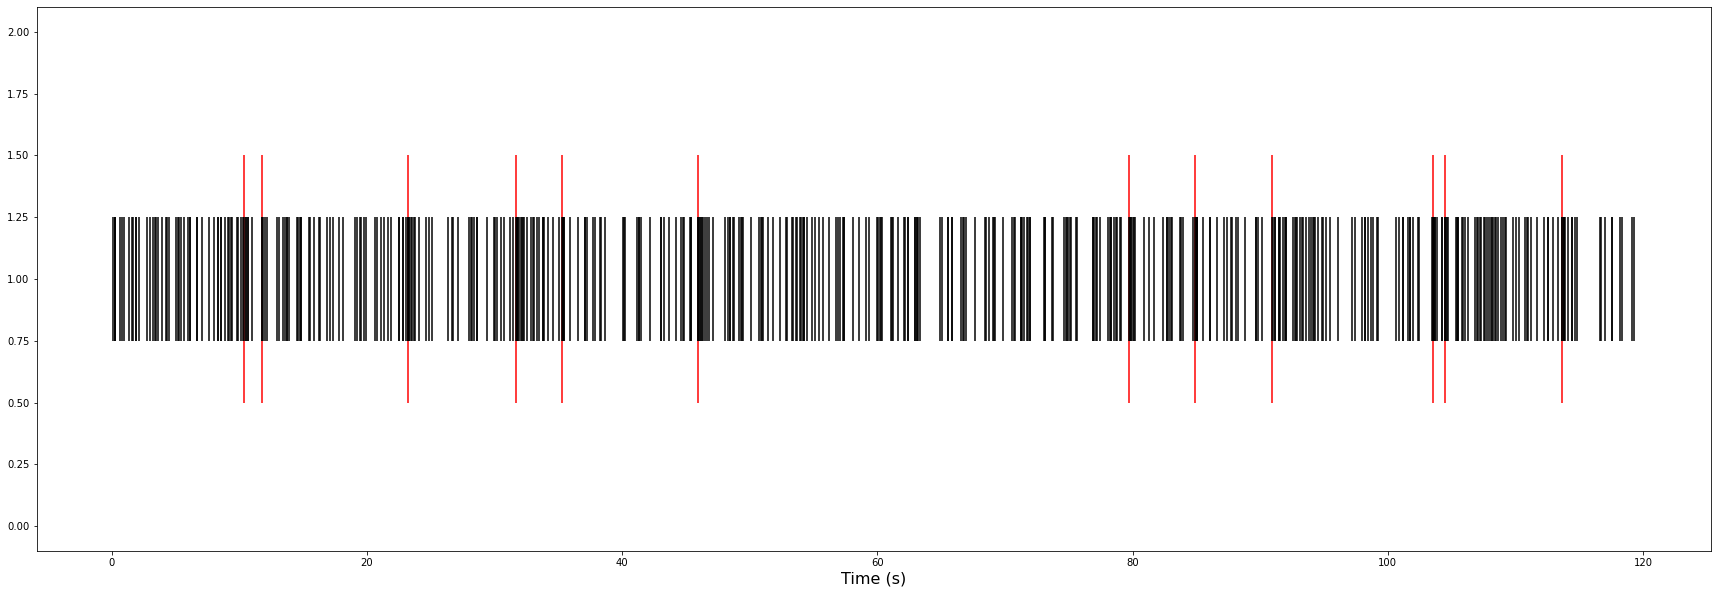

Text(0.5, 0, 'Time (s)')

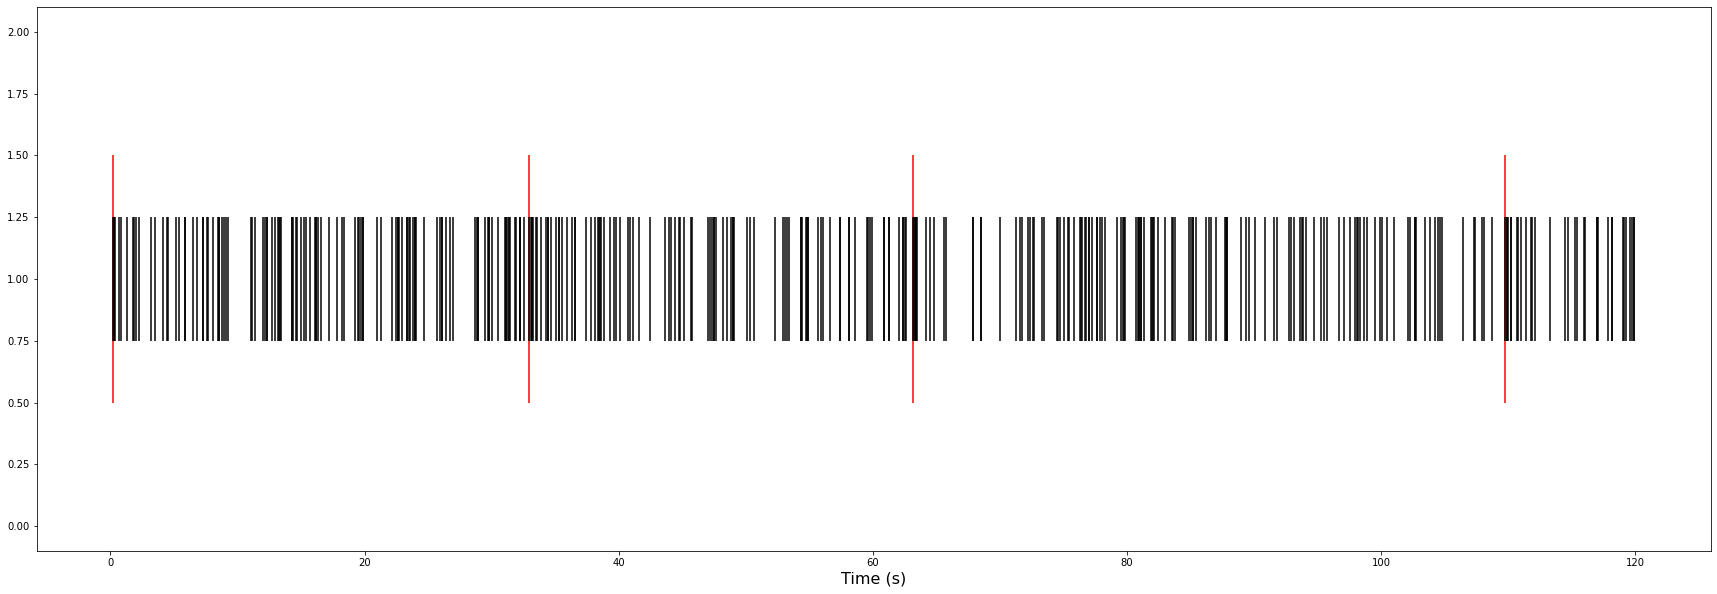

Text(0.5, 0, 'Time (s)')

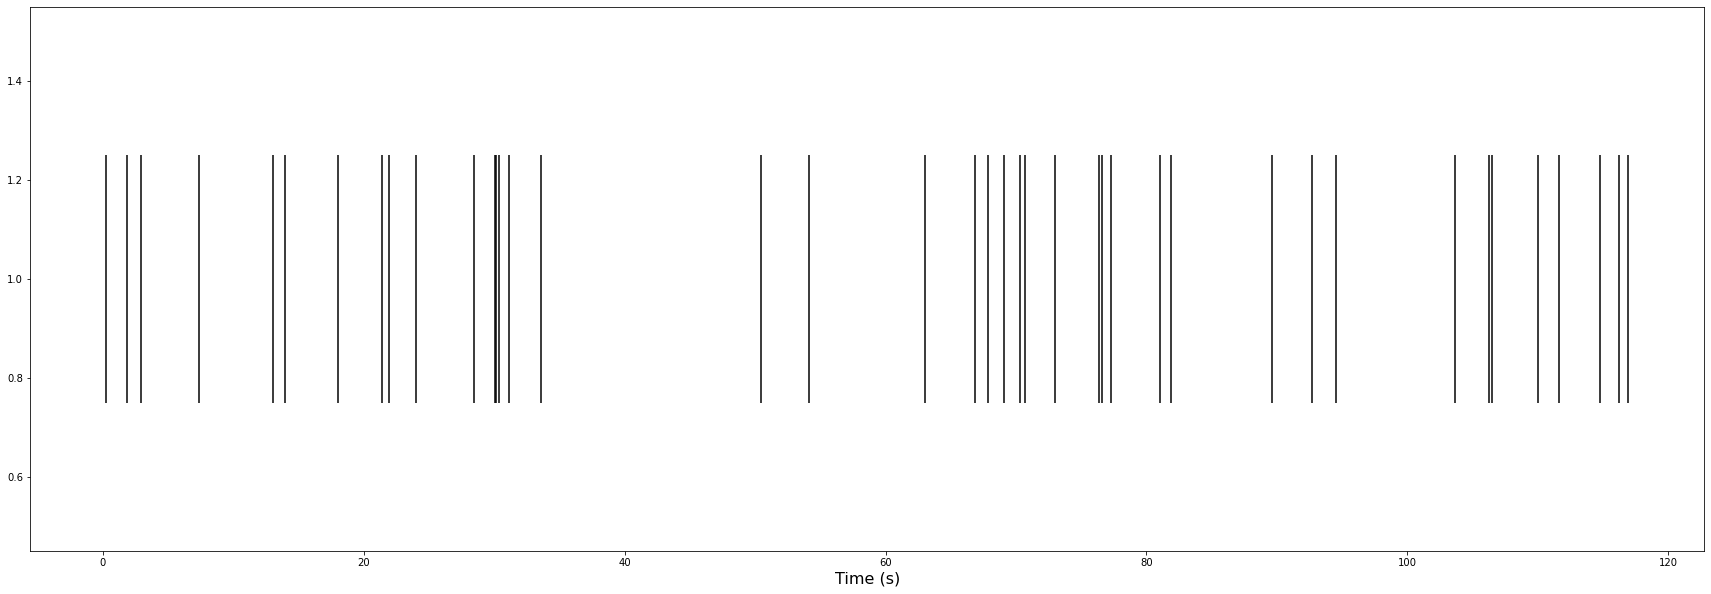

Text(0.5, 0, 'Time (s)')

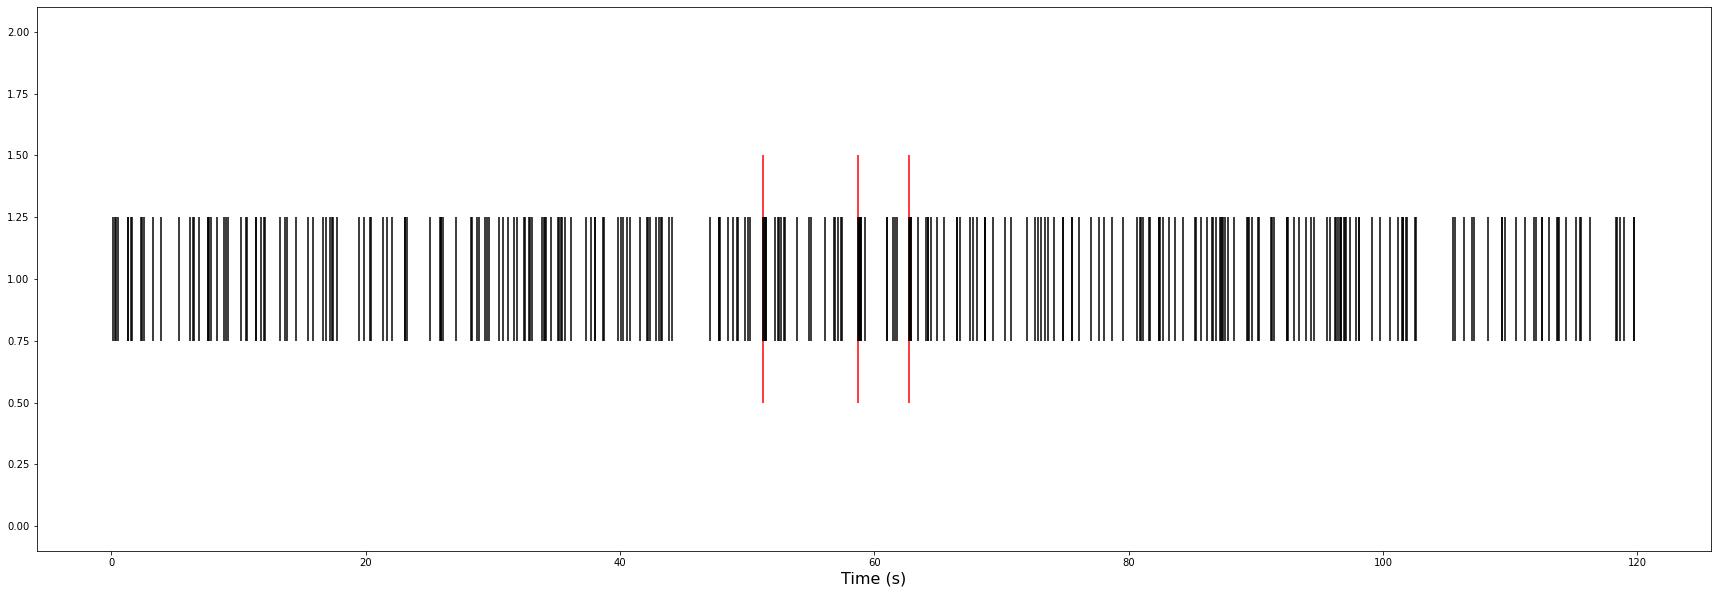

Text(0.5, 0, 'Time (s)')

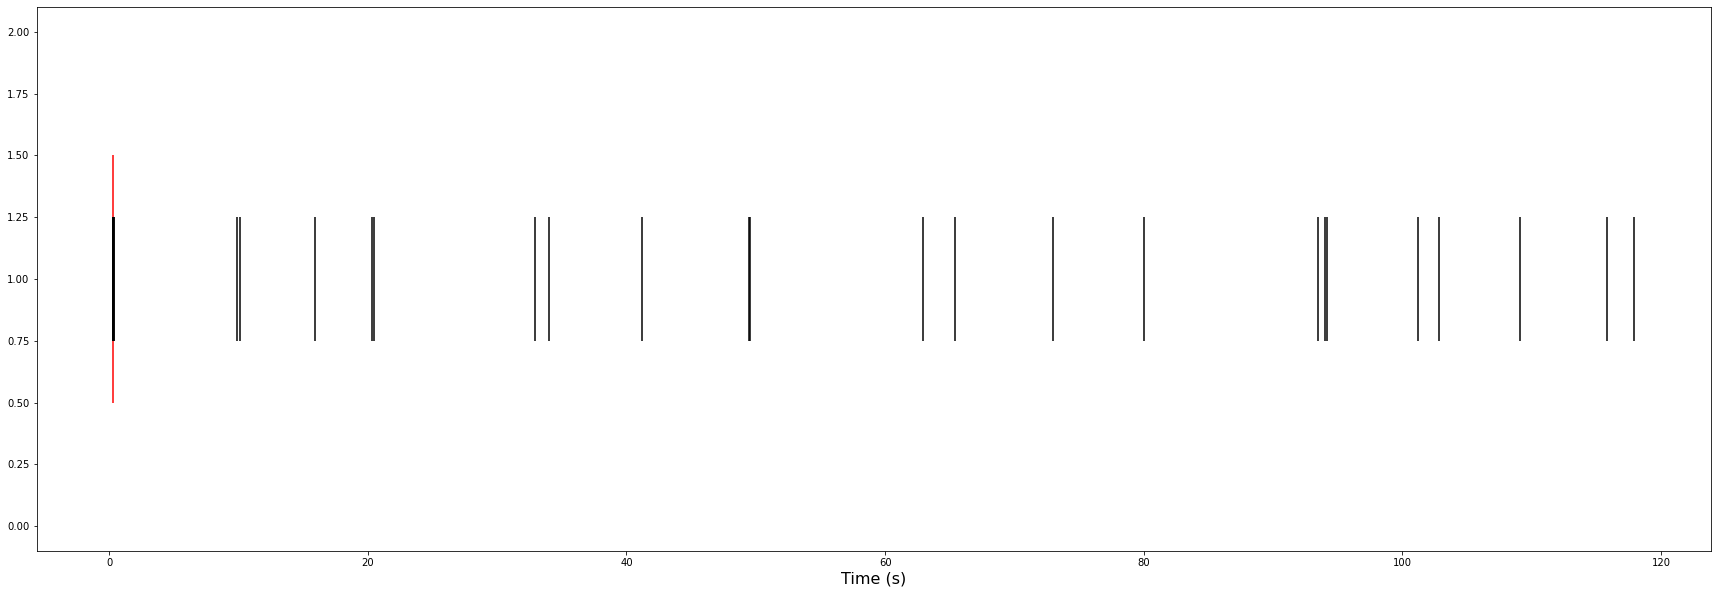

Text(0.5, 0, 'Time (s)')

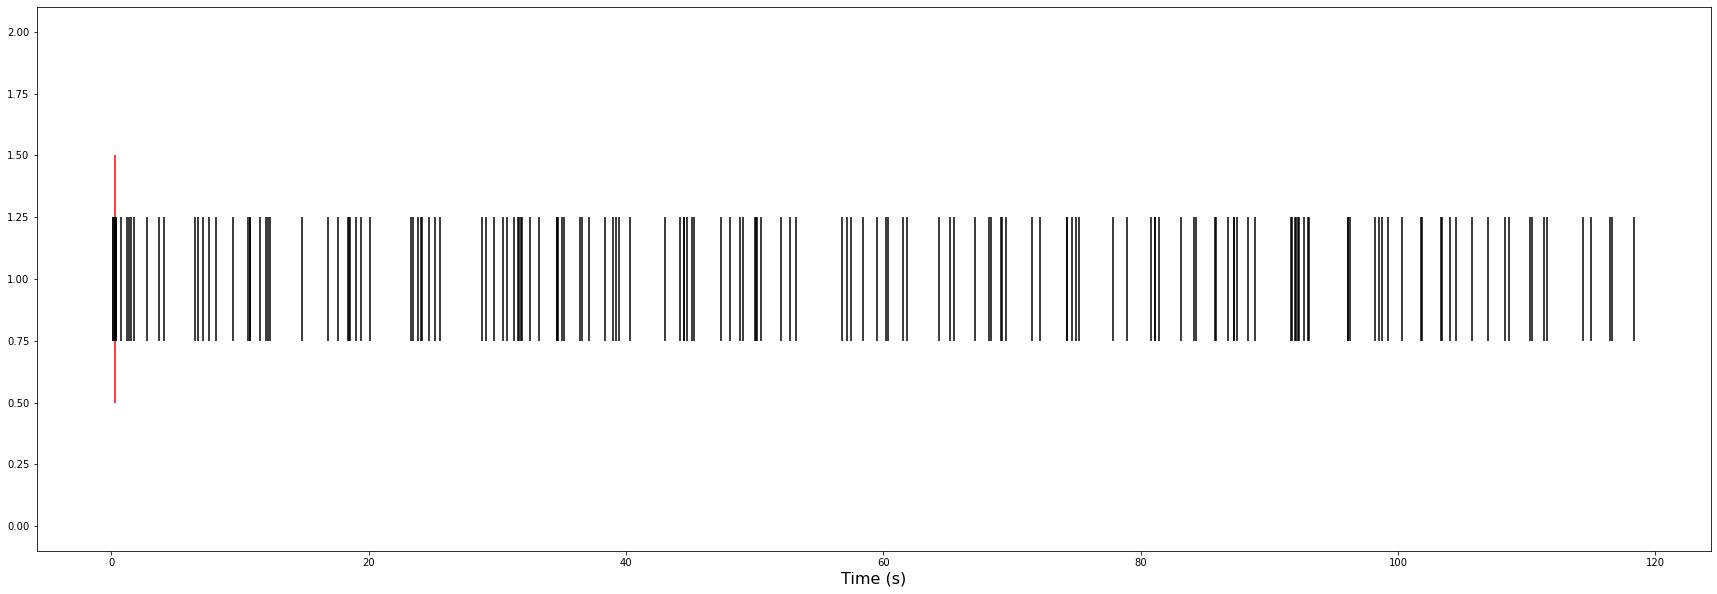

Text(0.5, 0, 'Time (s)')

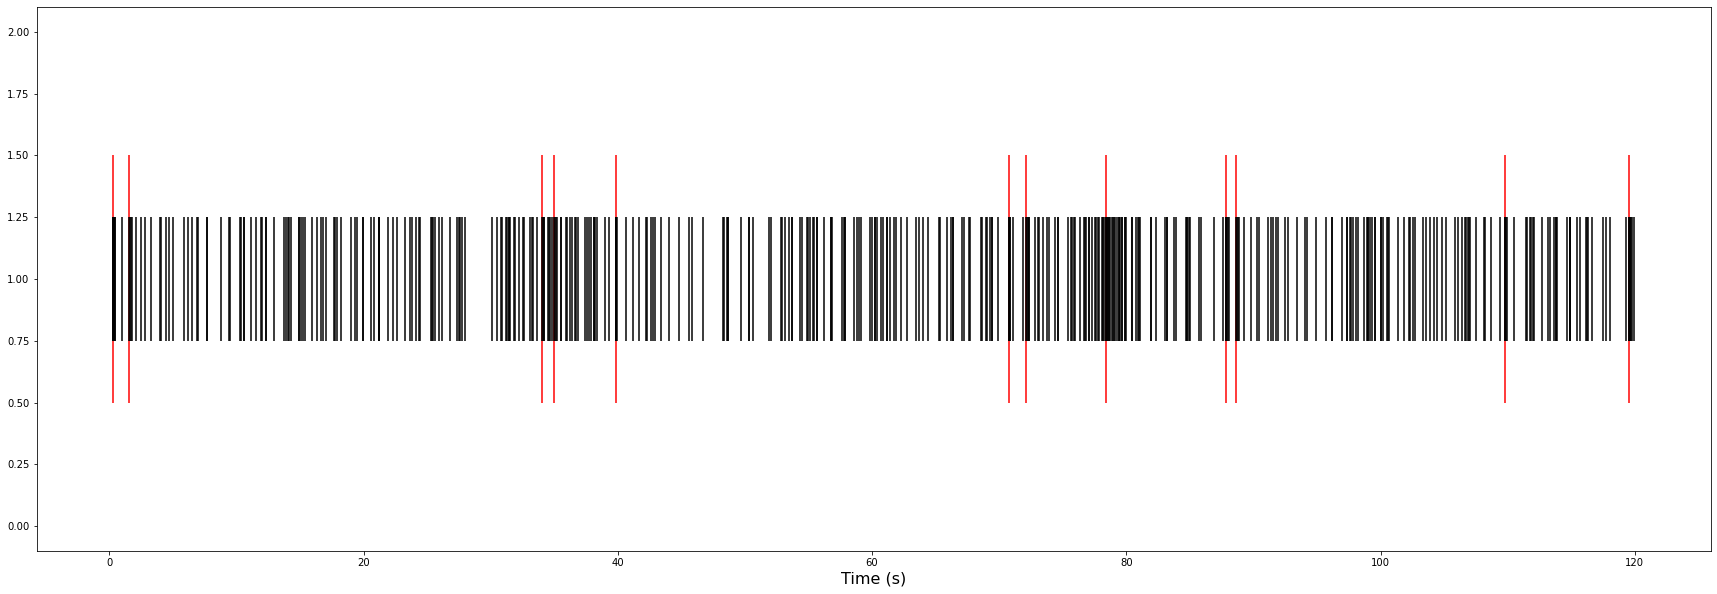

Text(0.5, 0, 'Time (s)')

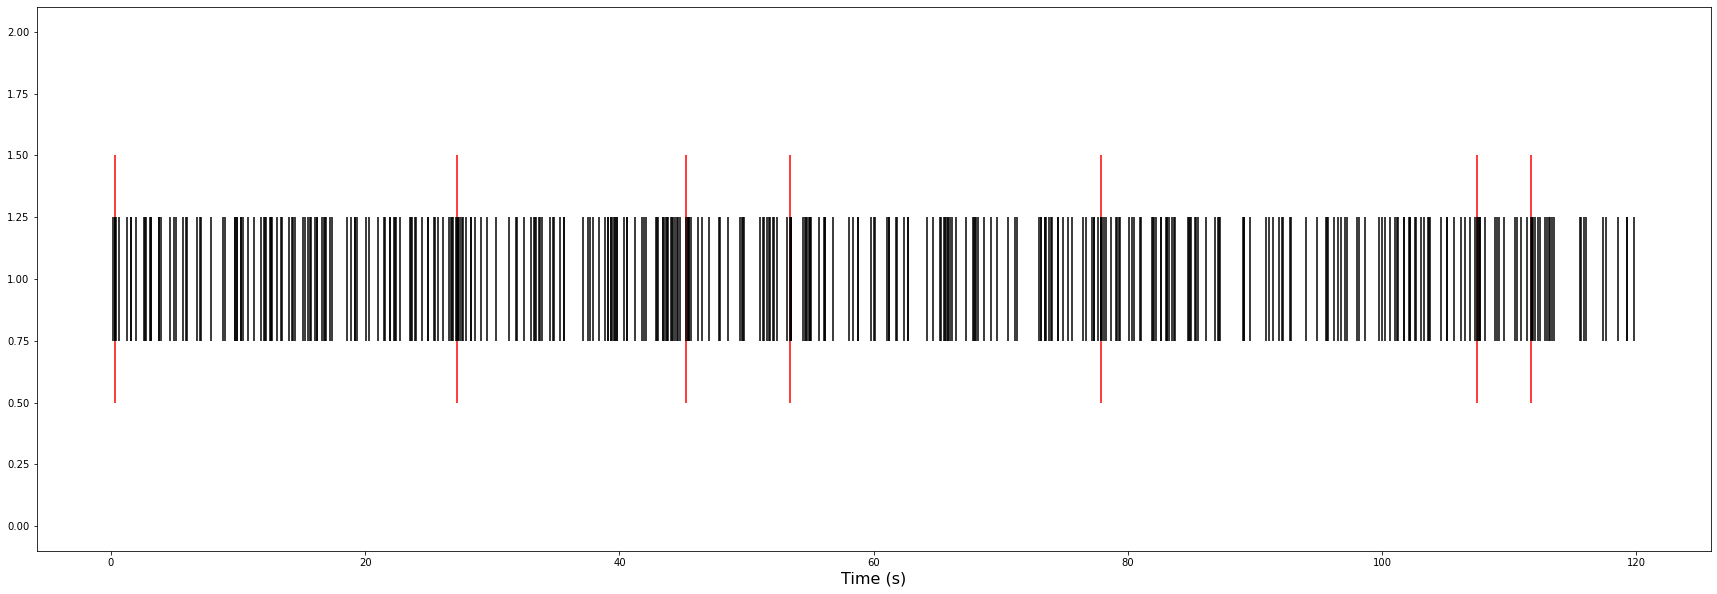

Text(0.5, 0, 'Time (s)')

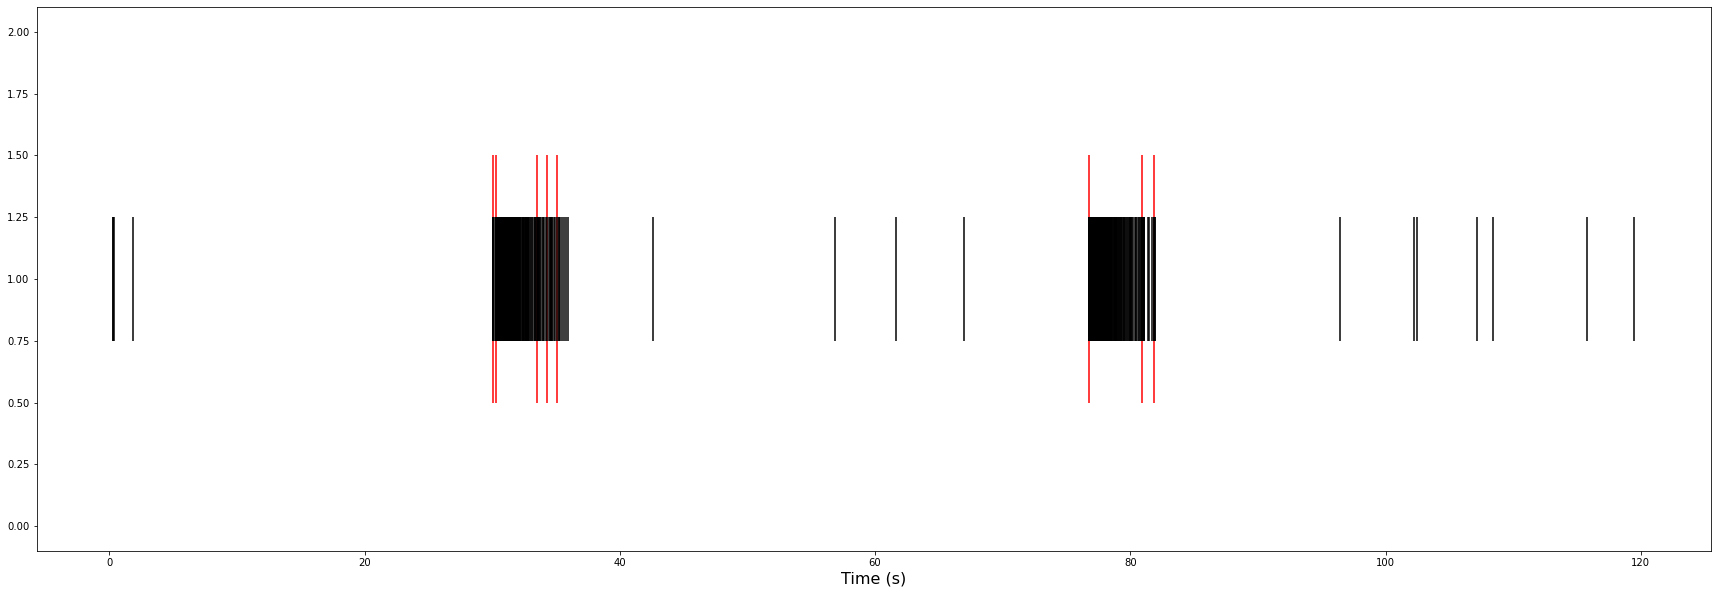

Text(0.5, 0, 'Time (s)')

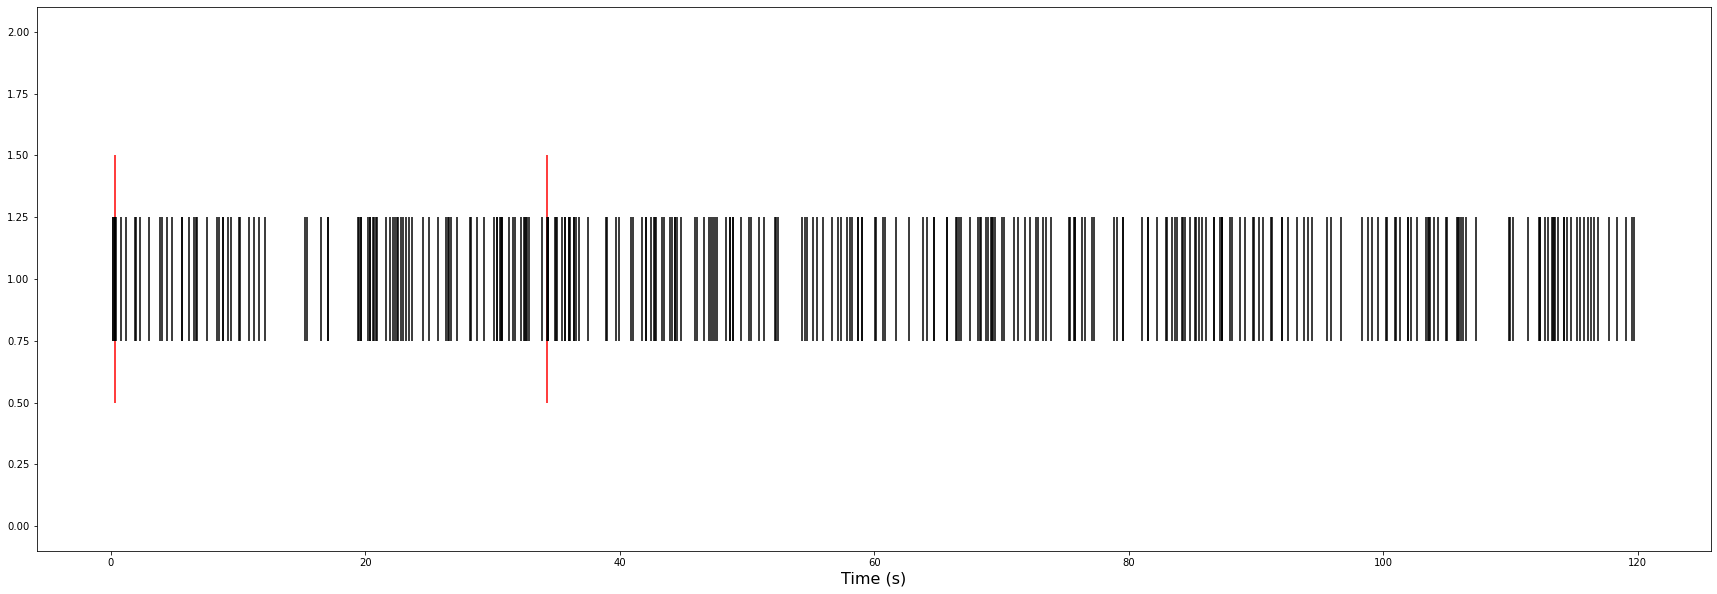

Text(0.5, 0, 'Time (s)')

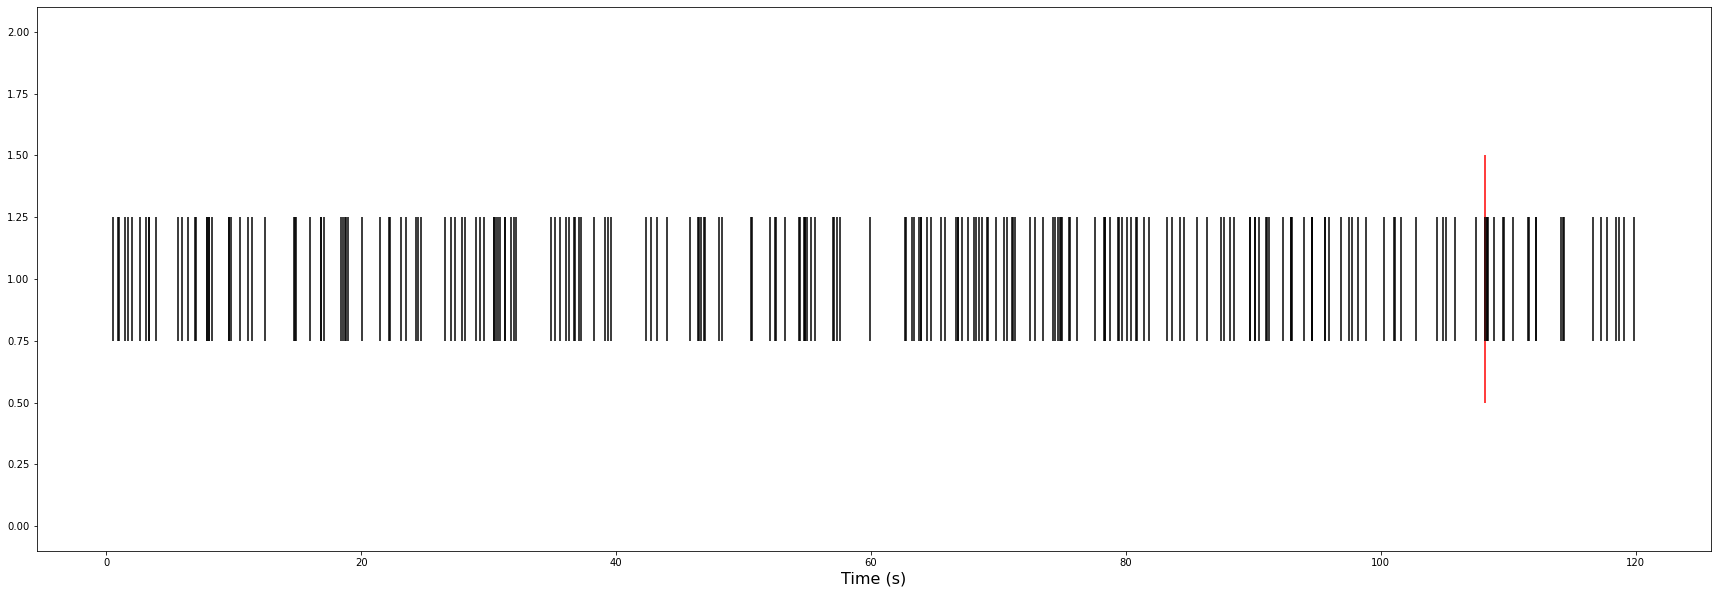

Text(0.5, 0, 'Time (s)')

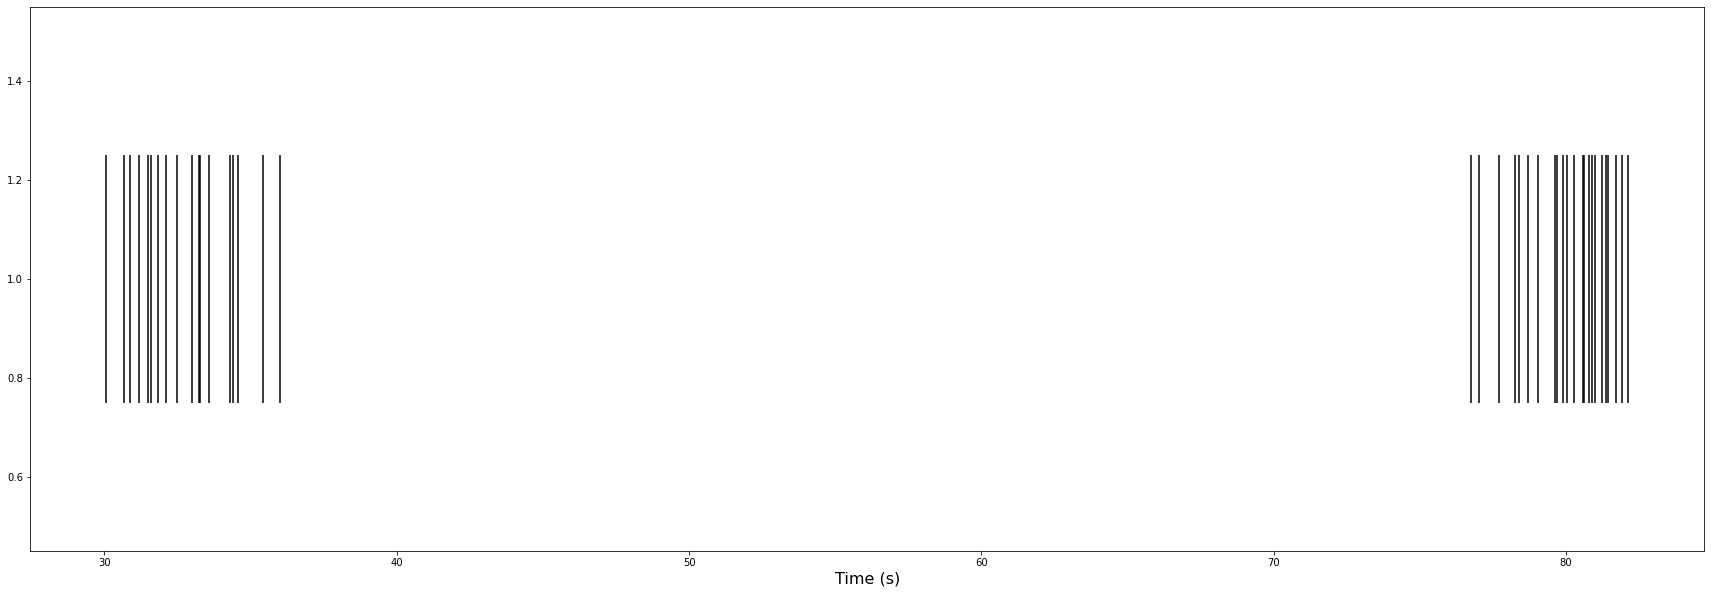

Text(0.5, 0, 'Time (s)')

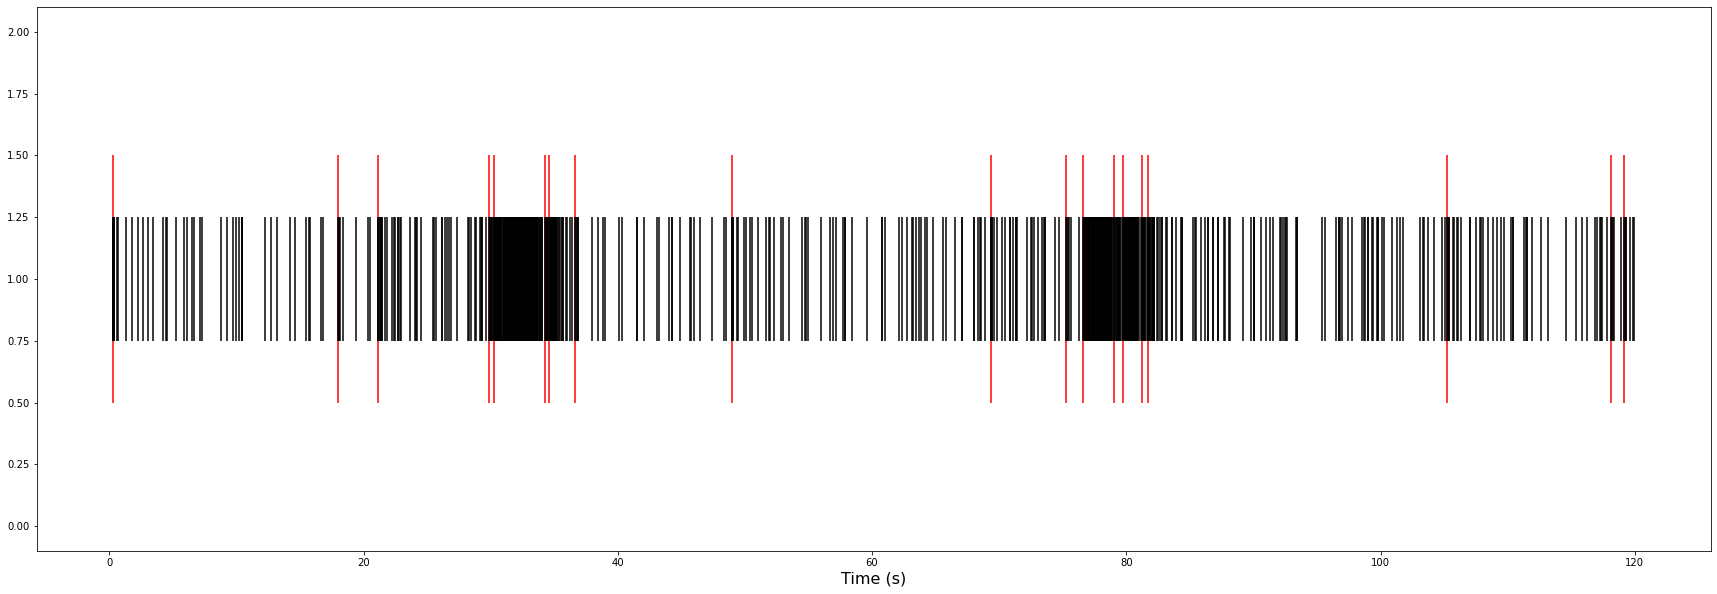

Text(0.5, 0, 'Time (s)')

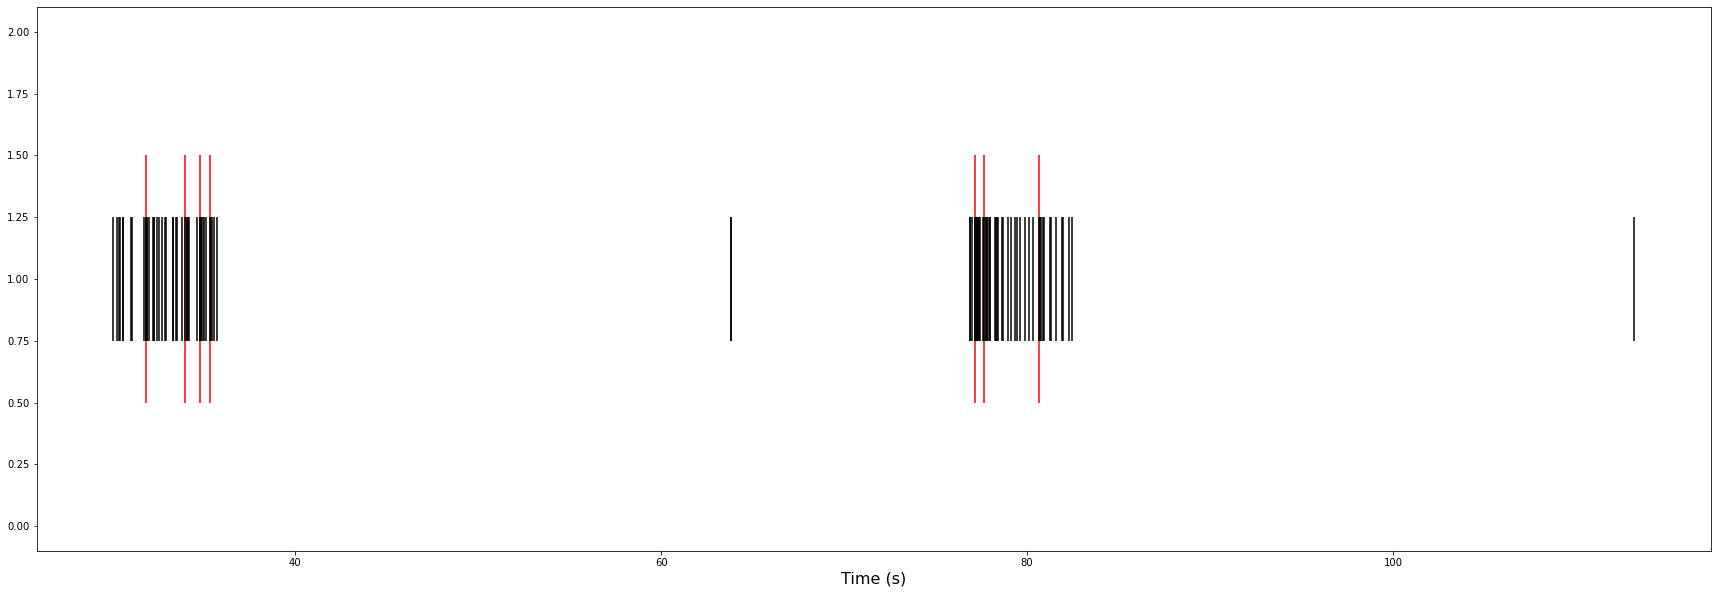

Text(0.5, 0, 'Time (s)')

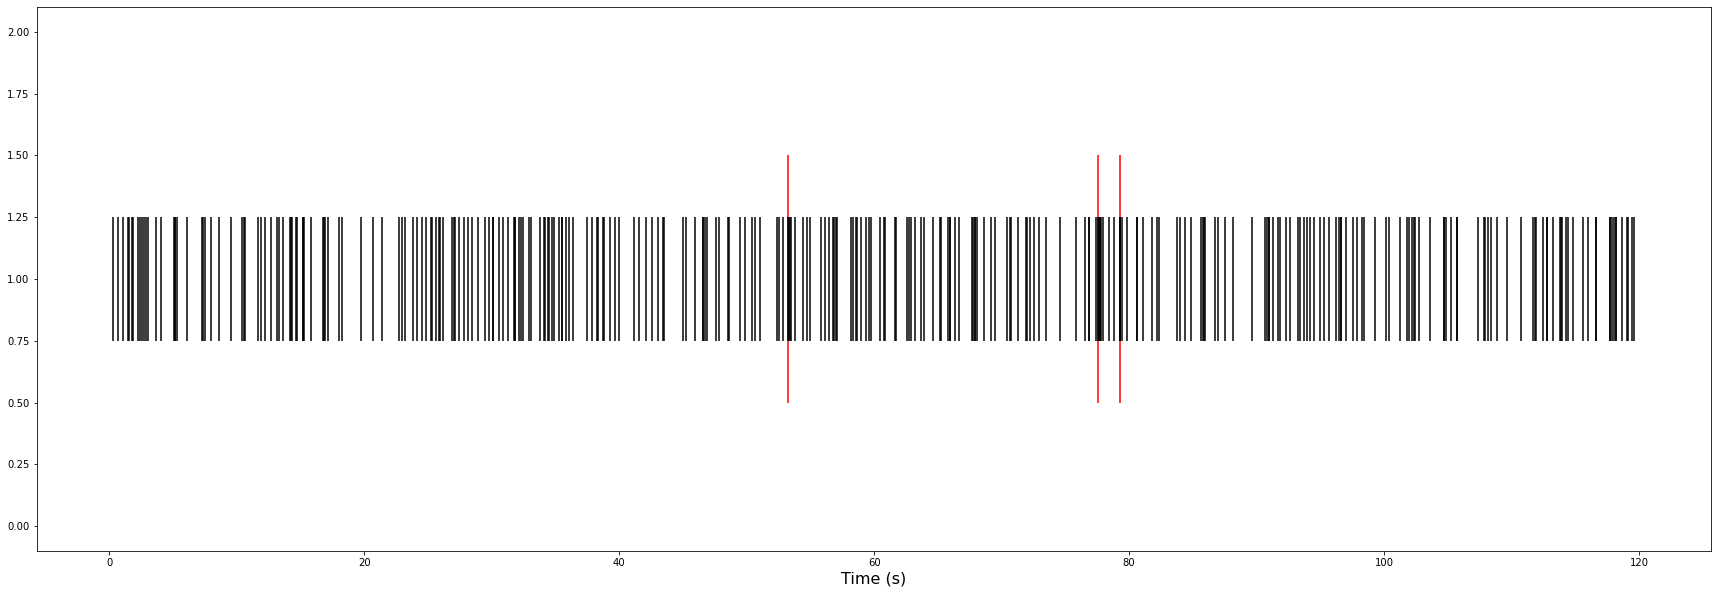

Text(0.5, 0, 'Time (s)')

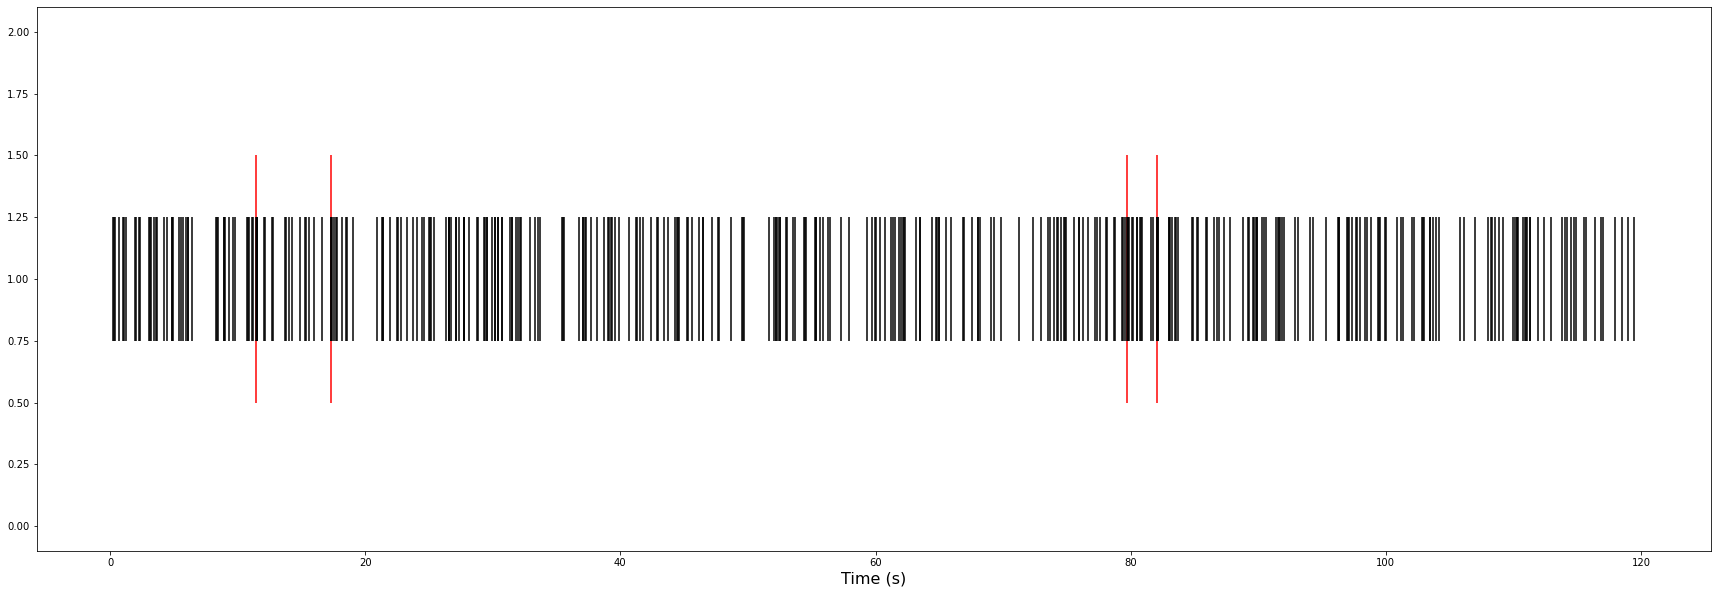

Text(0.5, 0, 'Time (s)')

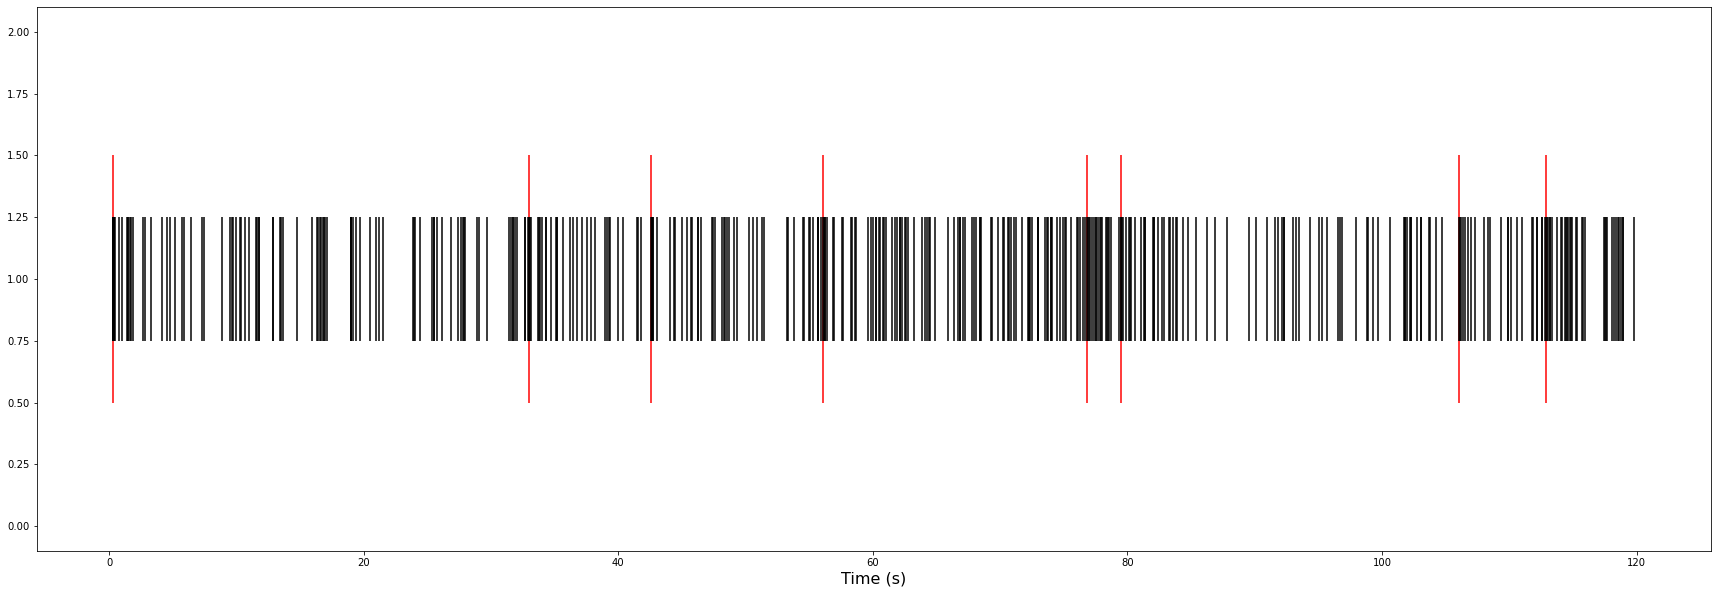

Text(0.5, 0, 'Time (s)')

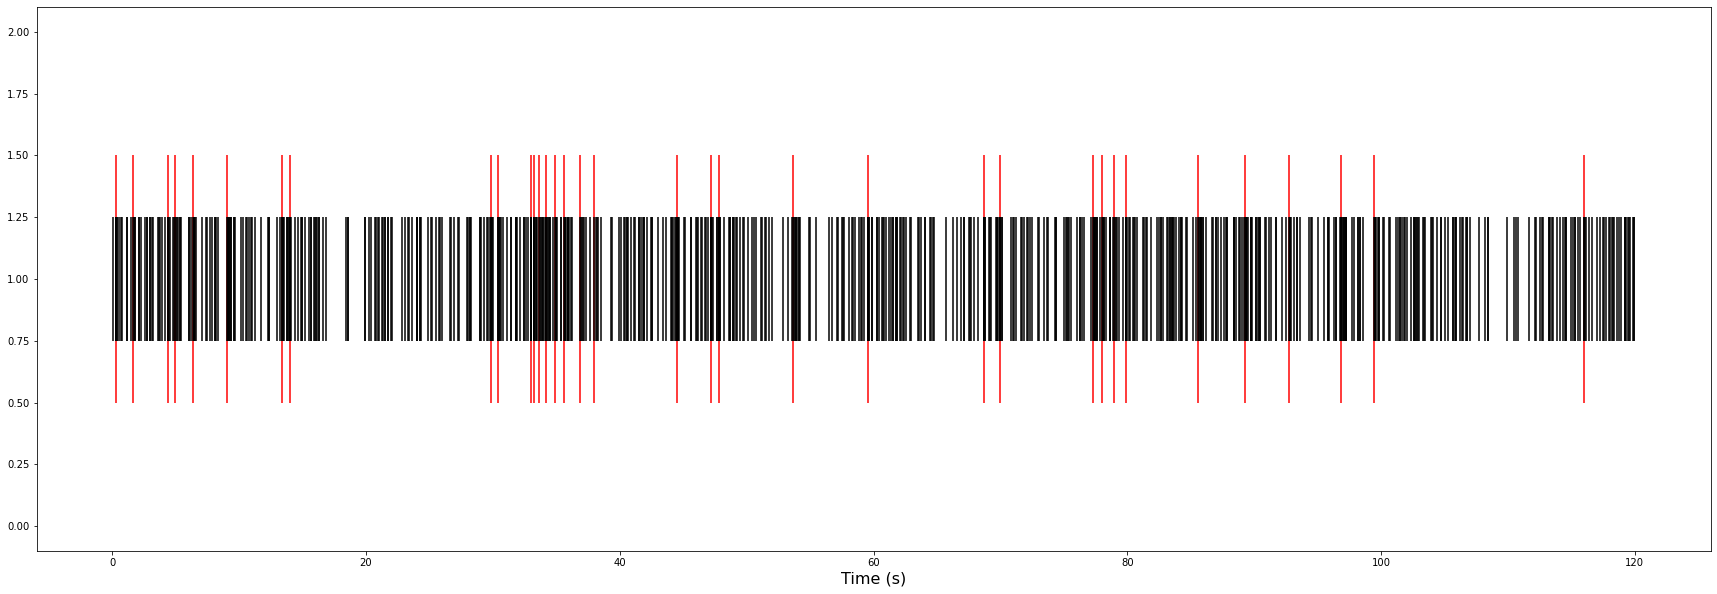

Text(0.5, 0, 'Time (s)')

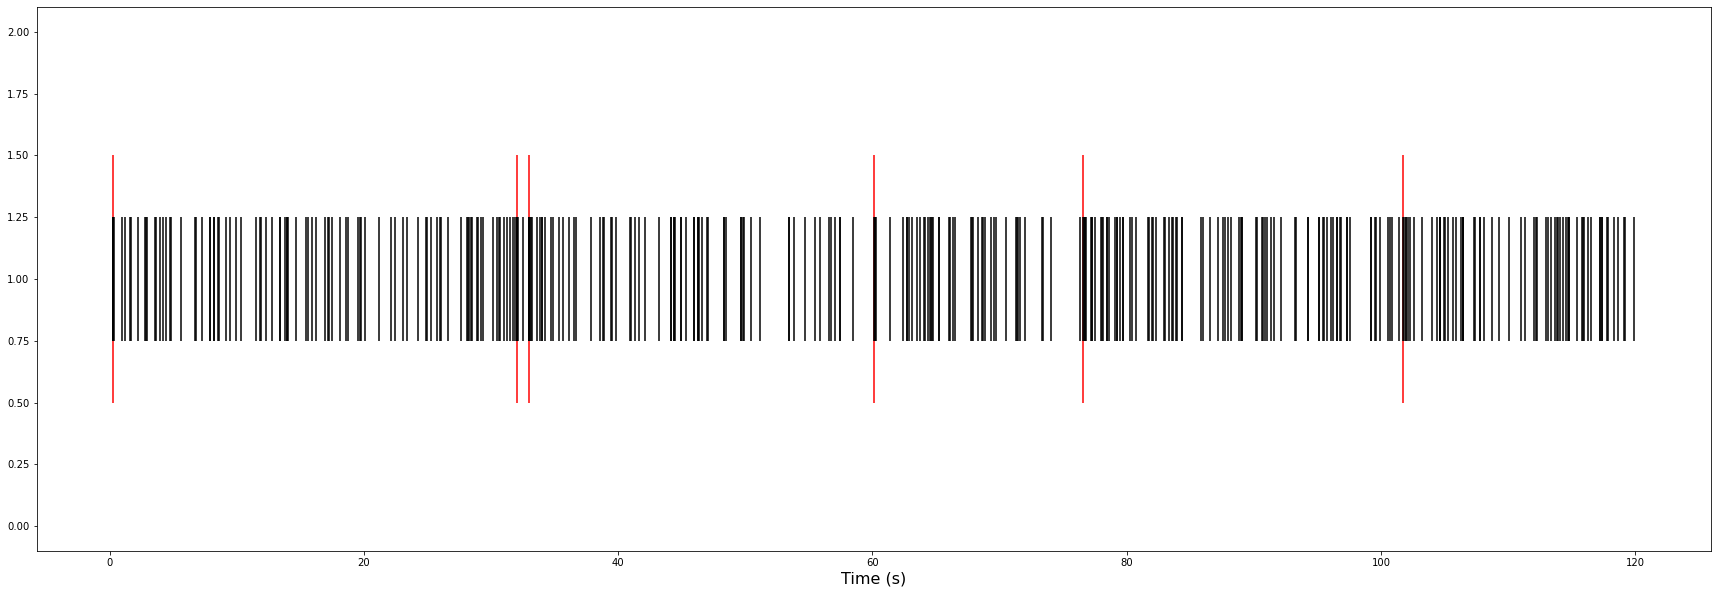

Text(0.5, 0, 'Time (s)')

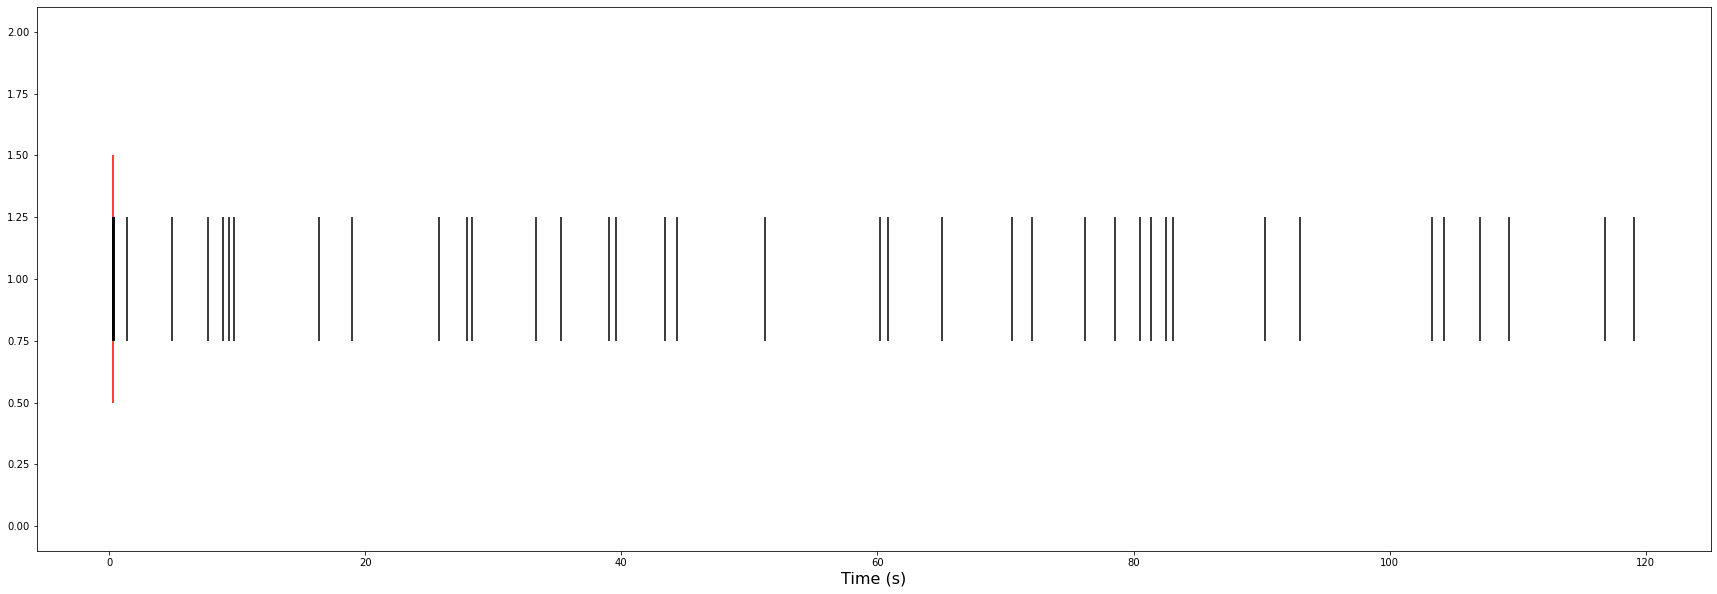

Text(0.5, 0, 'Time (s)')

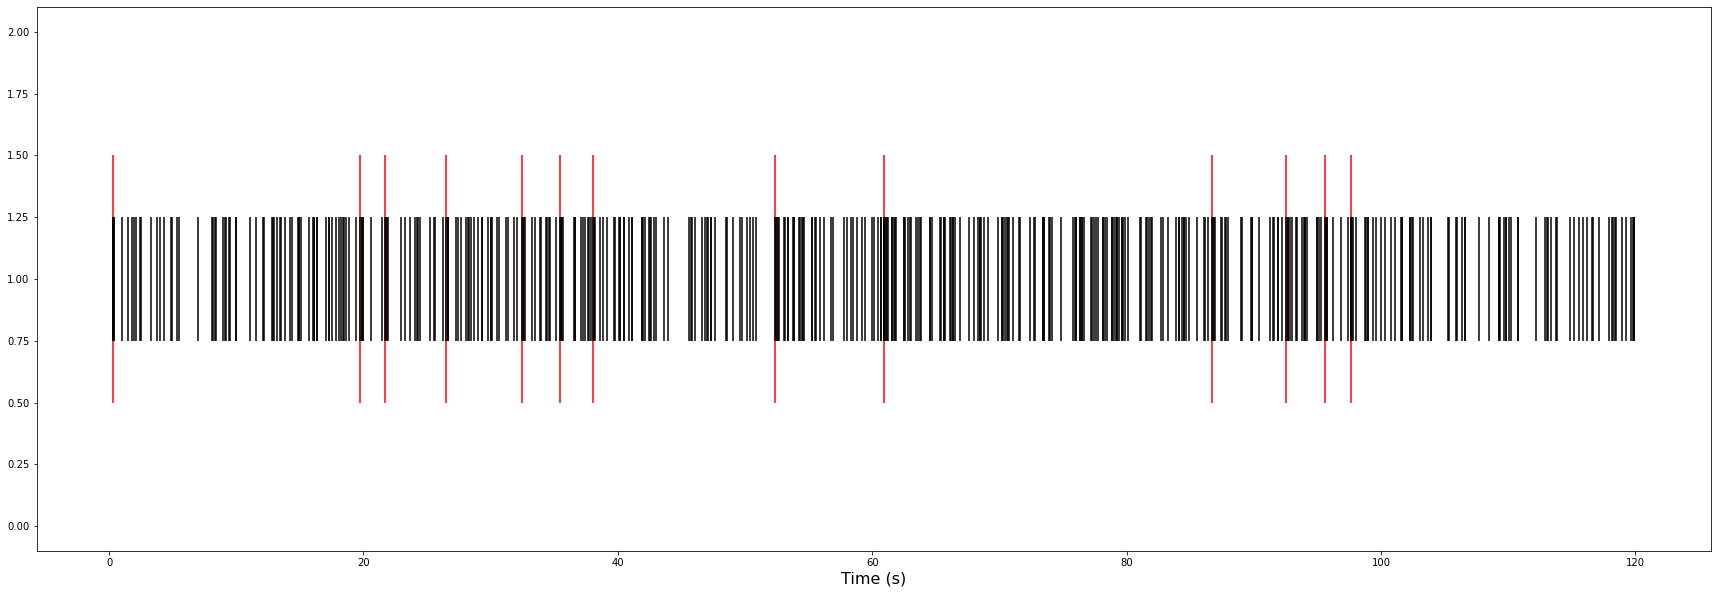

Text(0.5, 0, 'Time (s)')

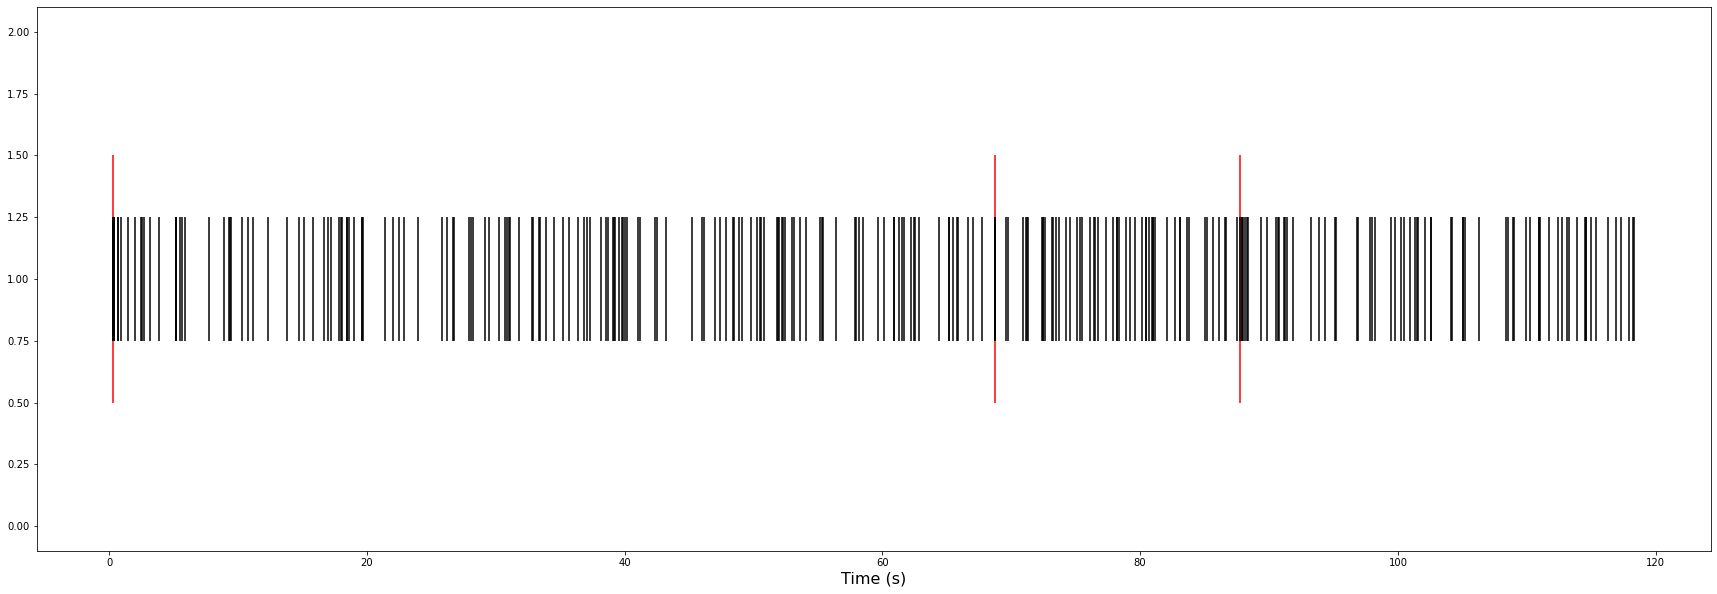

Text(0.5, 0, 'Time (s)')

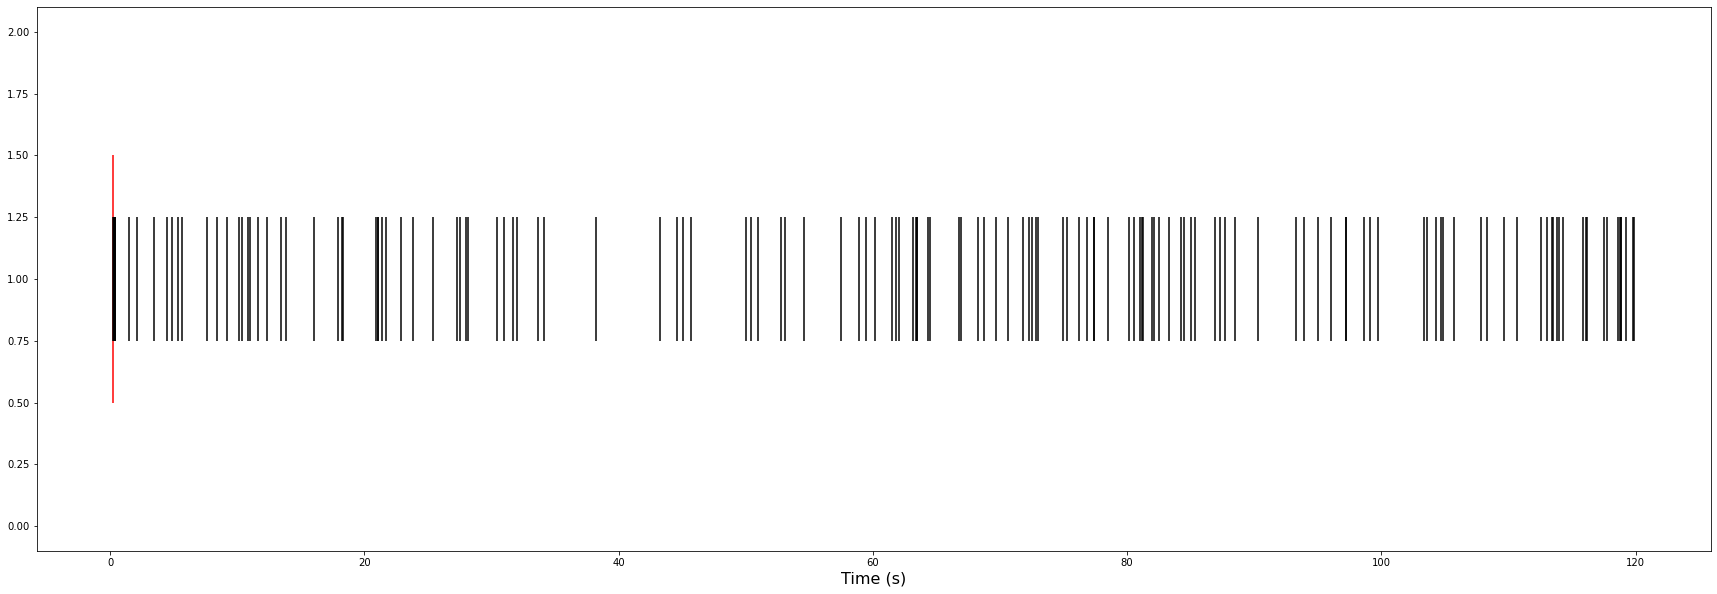

Text(0.5, 0, 'Time (s)')

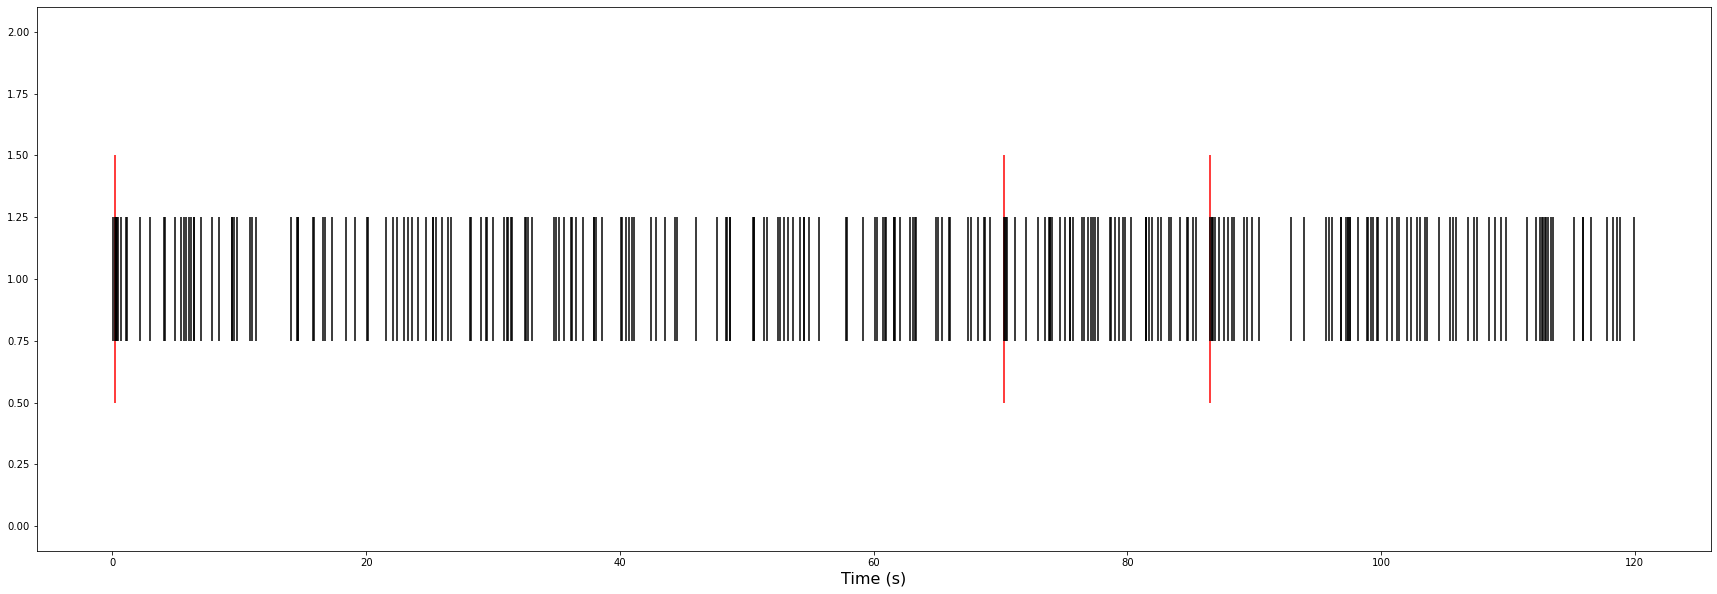

Text(0.5, 0, 'Time (s)')

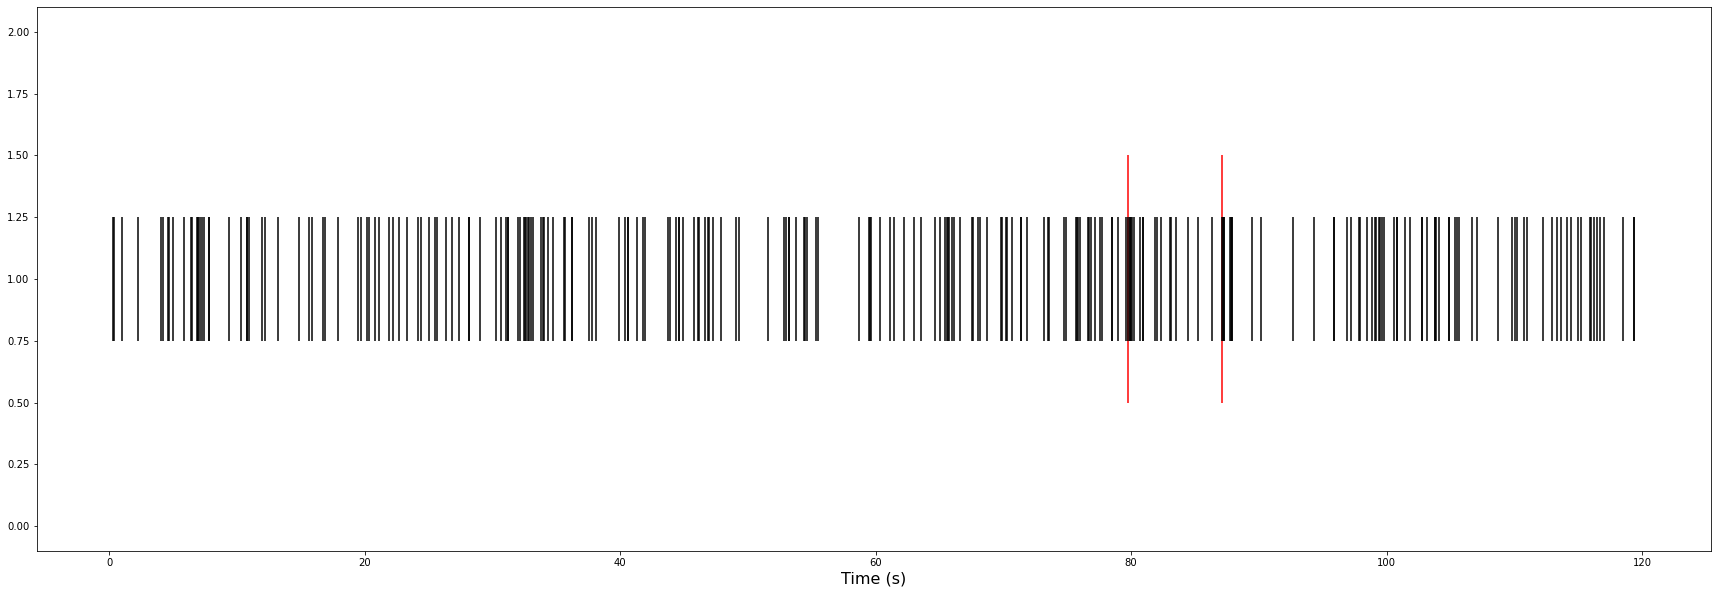

Text(0.5, 0, 'Time (s)')

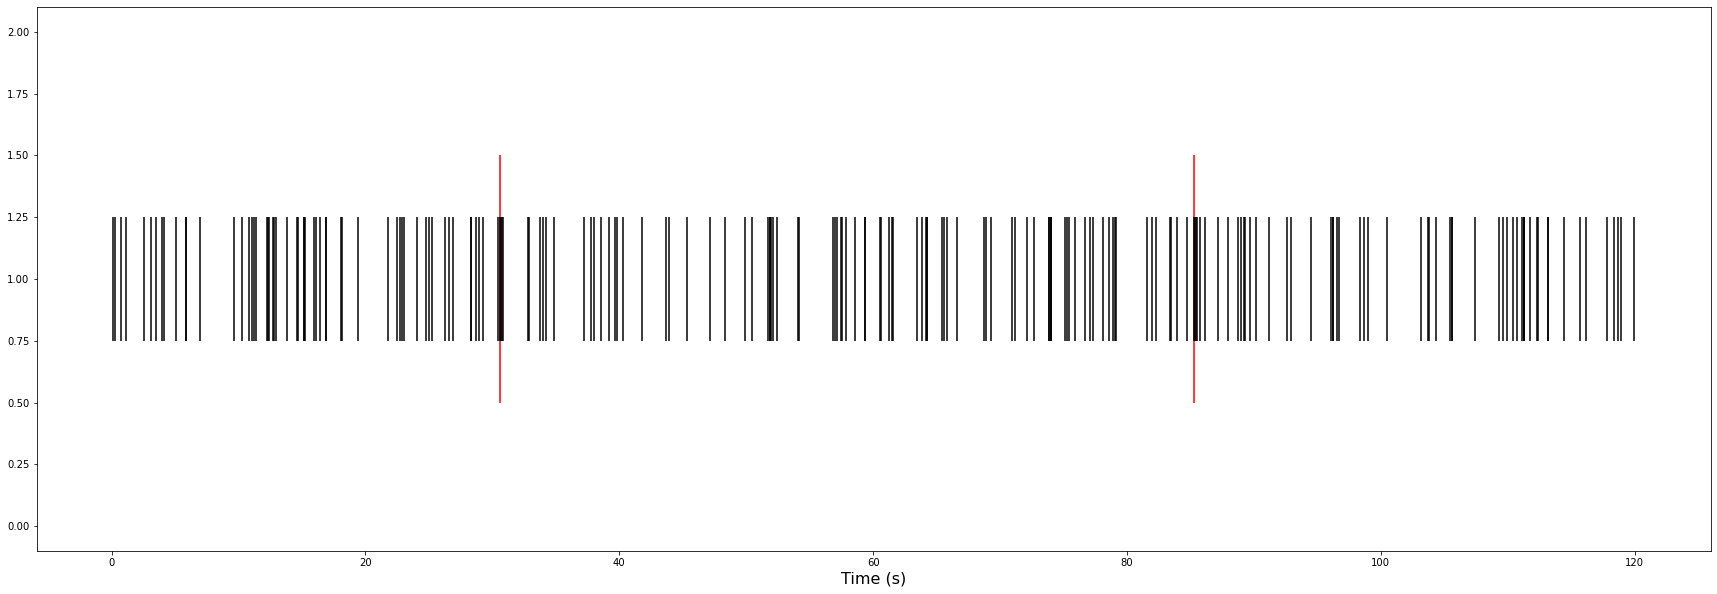

Text(0.5, 0, 'Time (s)')

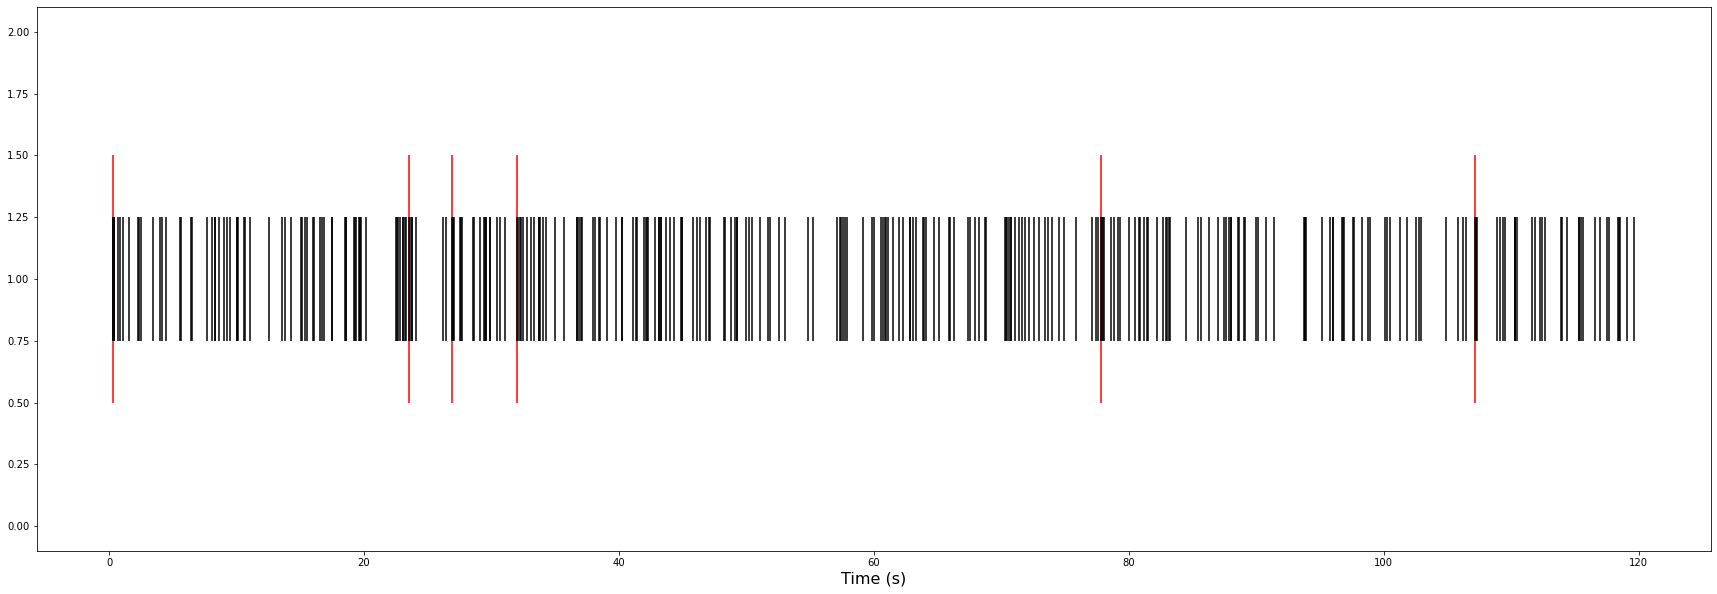

Text(0.5, 0, 'Time (s)')

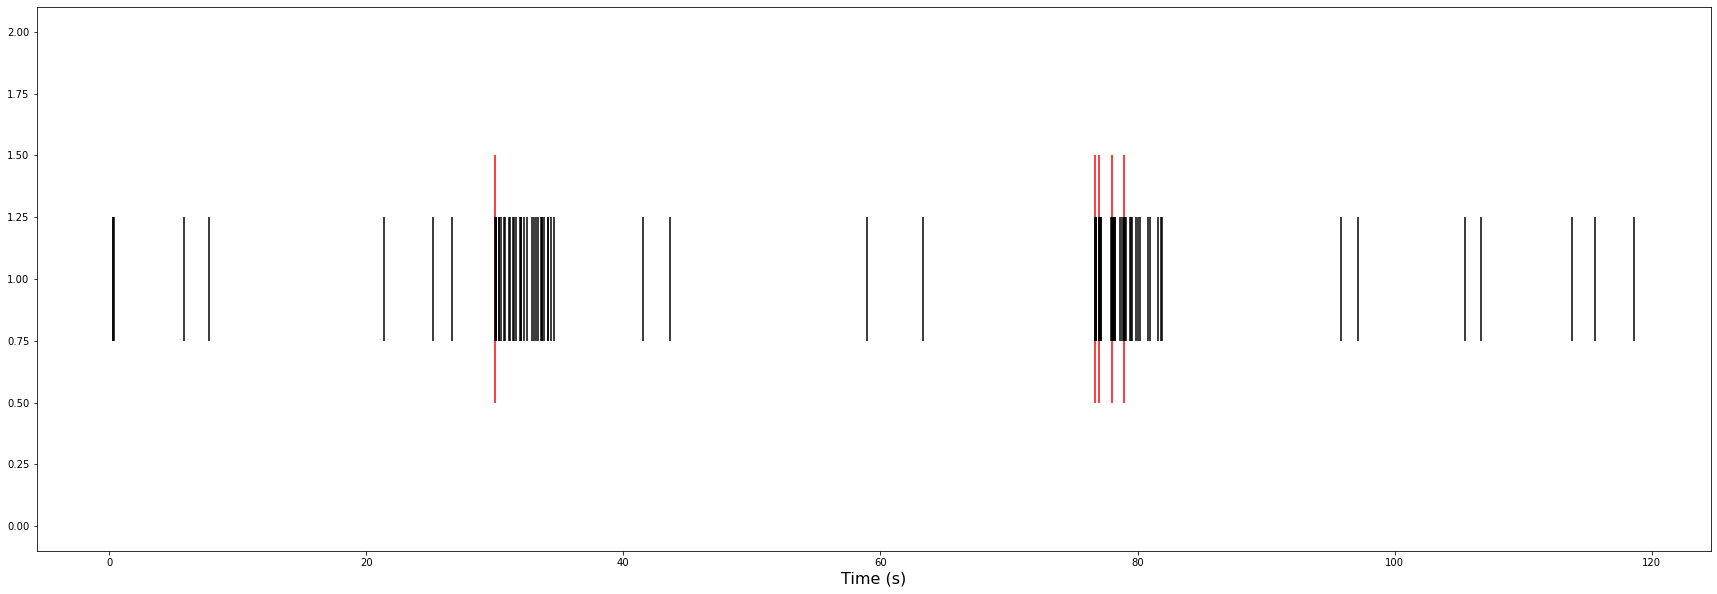

Text(0.5, 0, 'Time (s)')

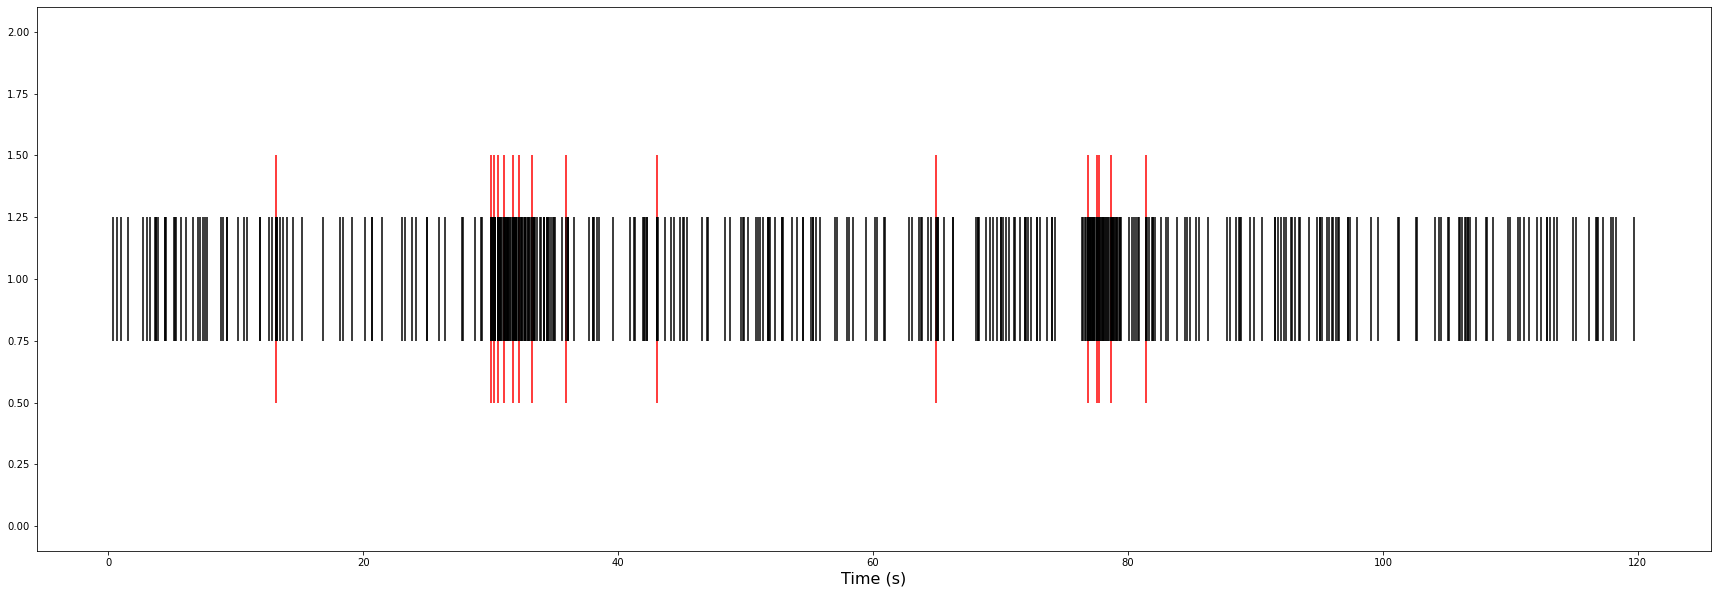

Text(0.5, 0, 'Time (s)')

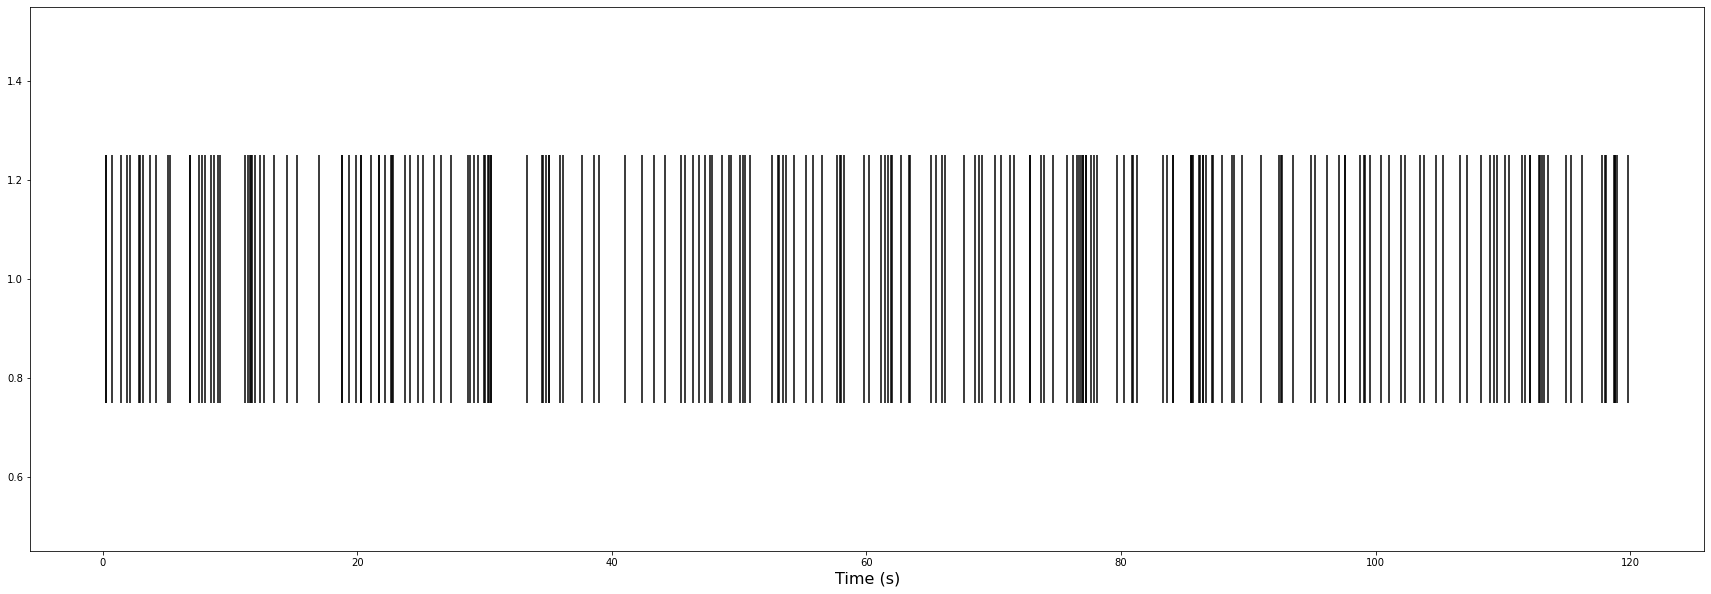

Text(0.5, 0, 'Time (s)')

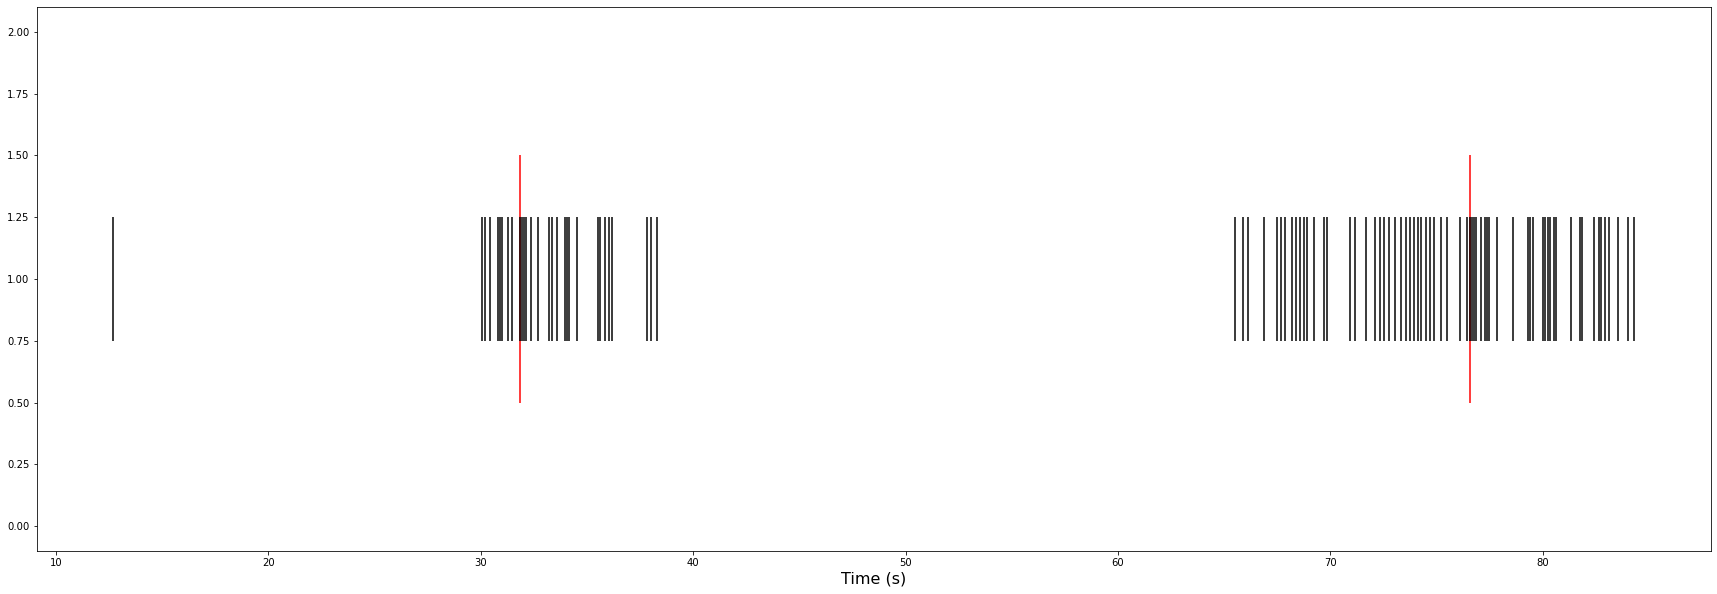

Text(0.5, 0, 'Time (s)')

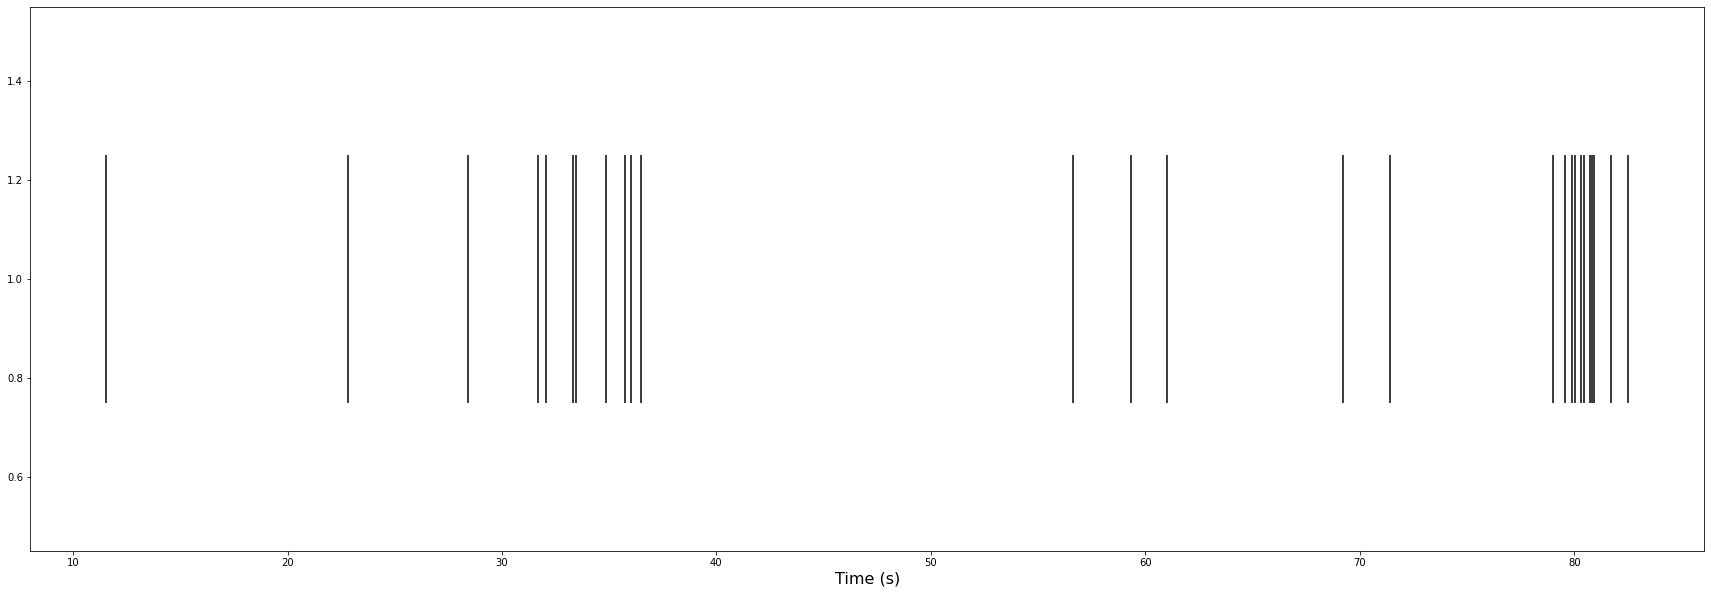

Text(0.5, 0, 'Time (s)')

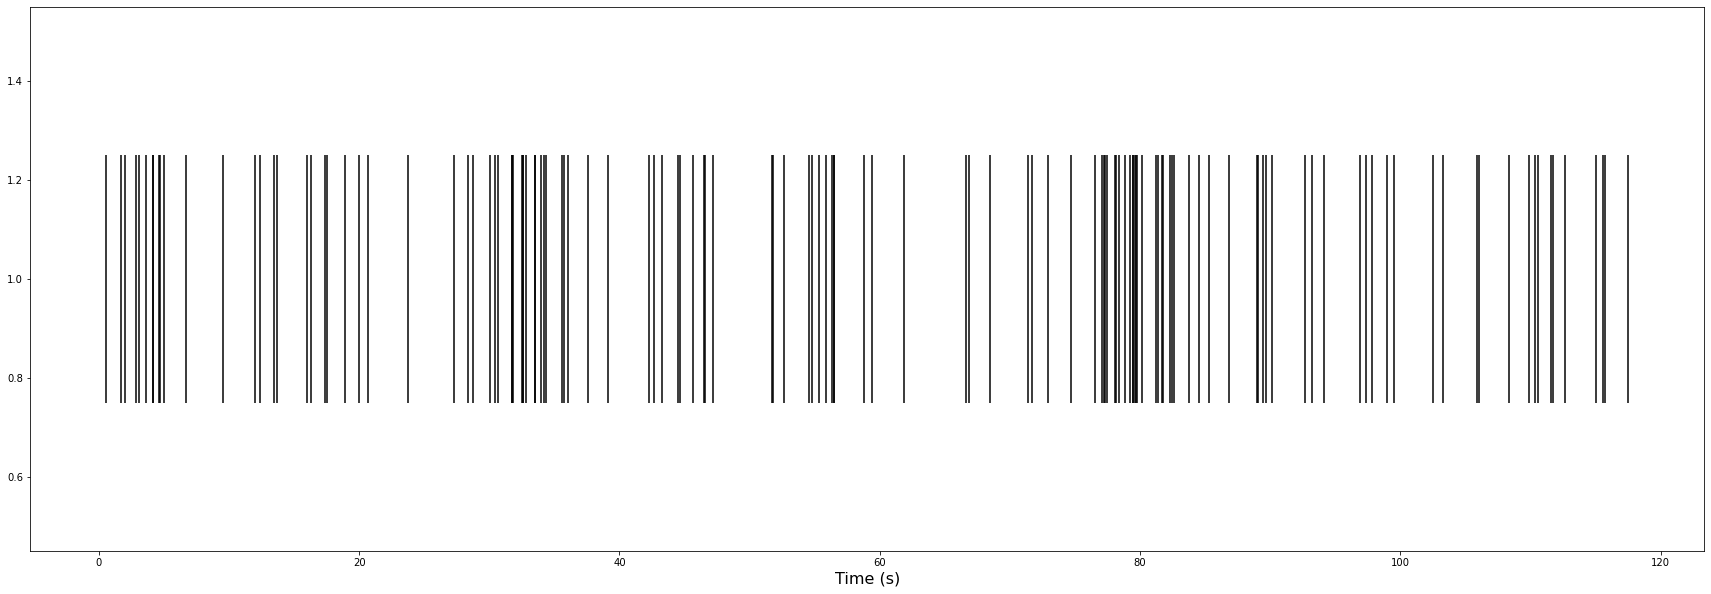

Text(0.5, 0, 'Time (s)')

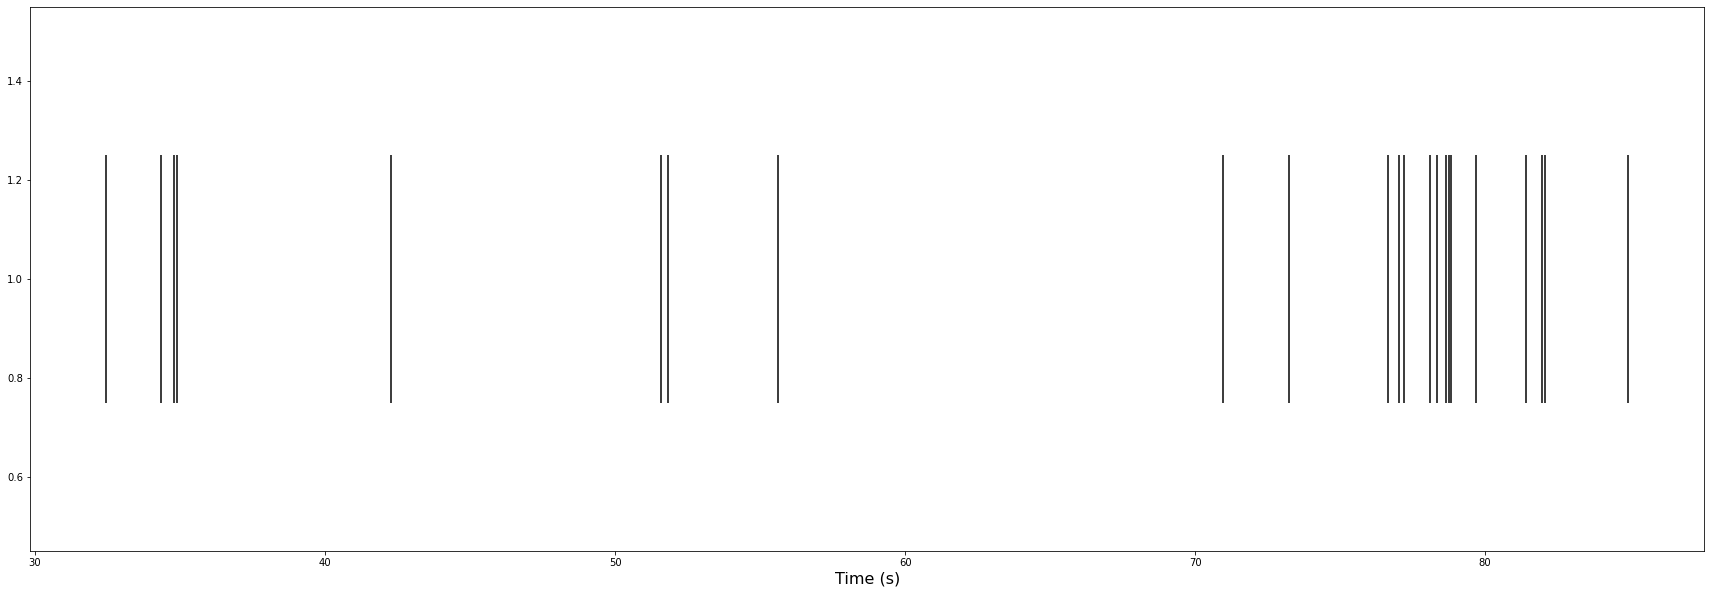

Text(0.5, 0, 'Time (s)')

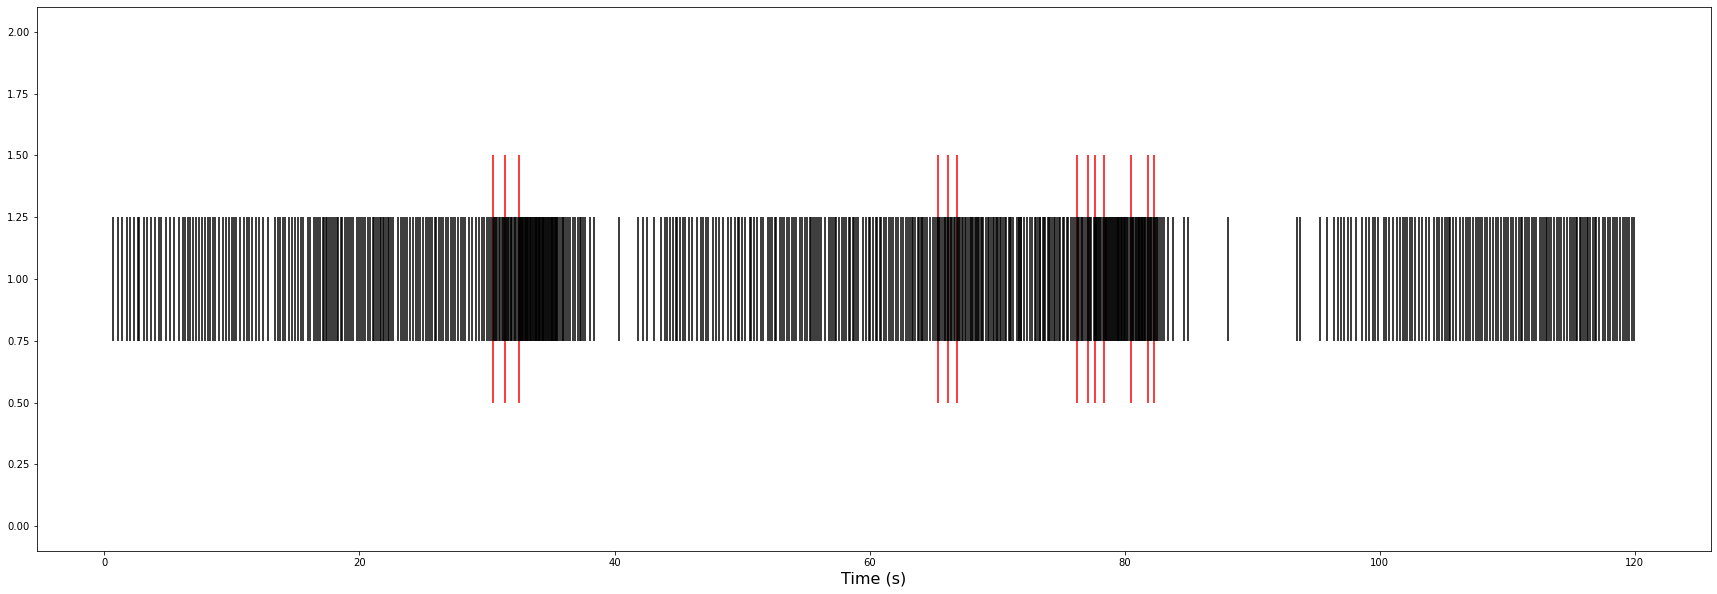

Text(0.5, 0, 'Time (s)')

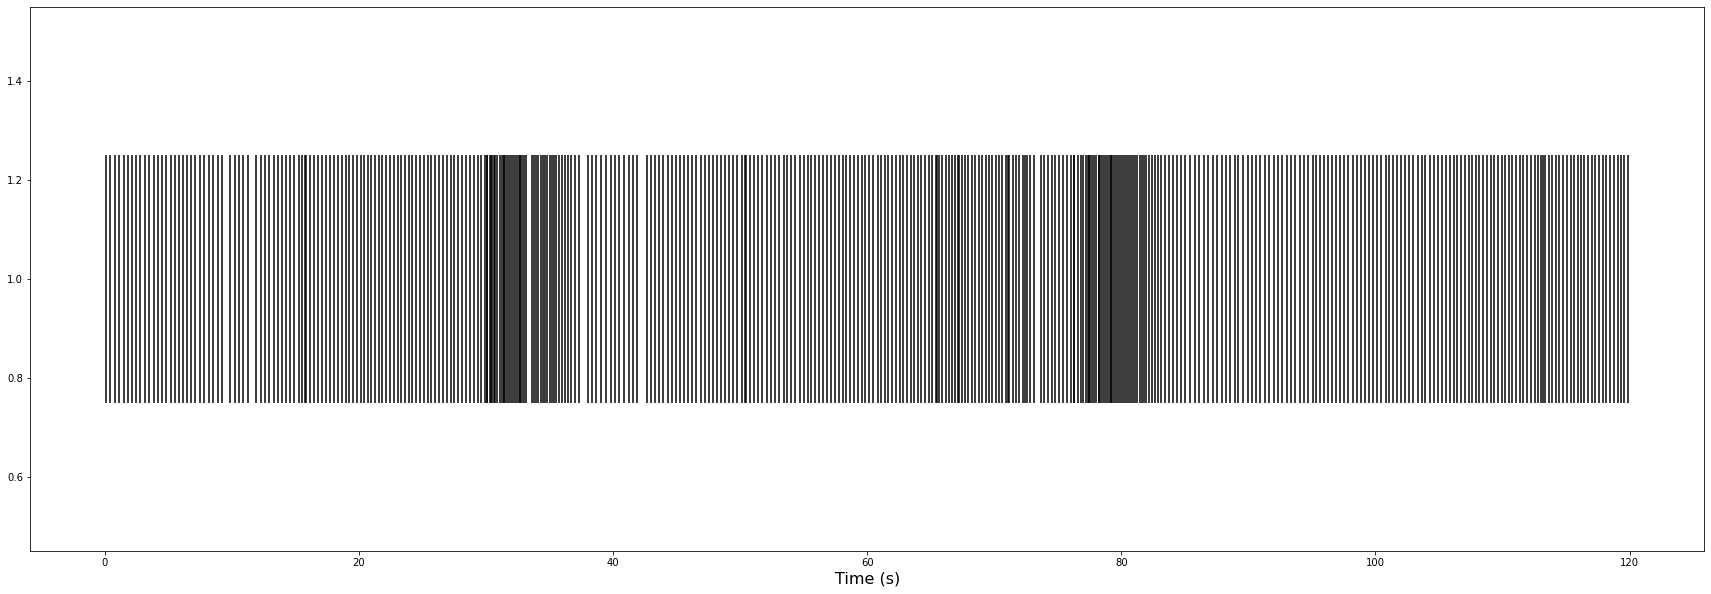

Text(0.5, 0, 'Time (s)')

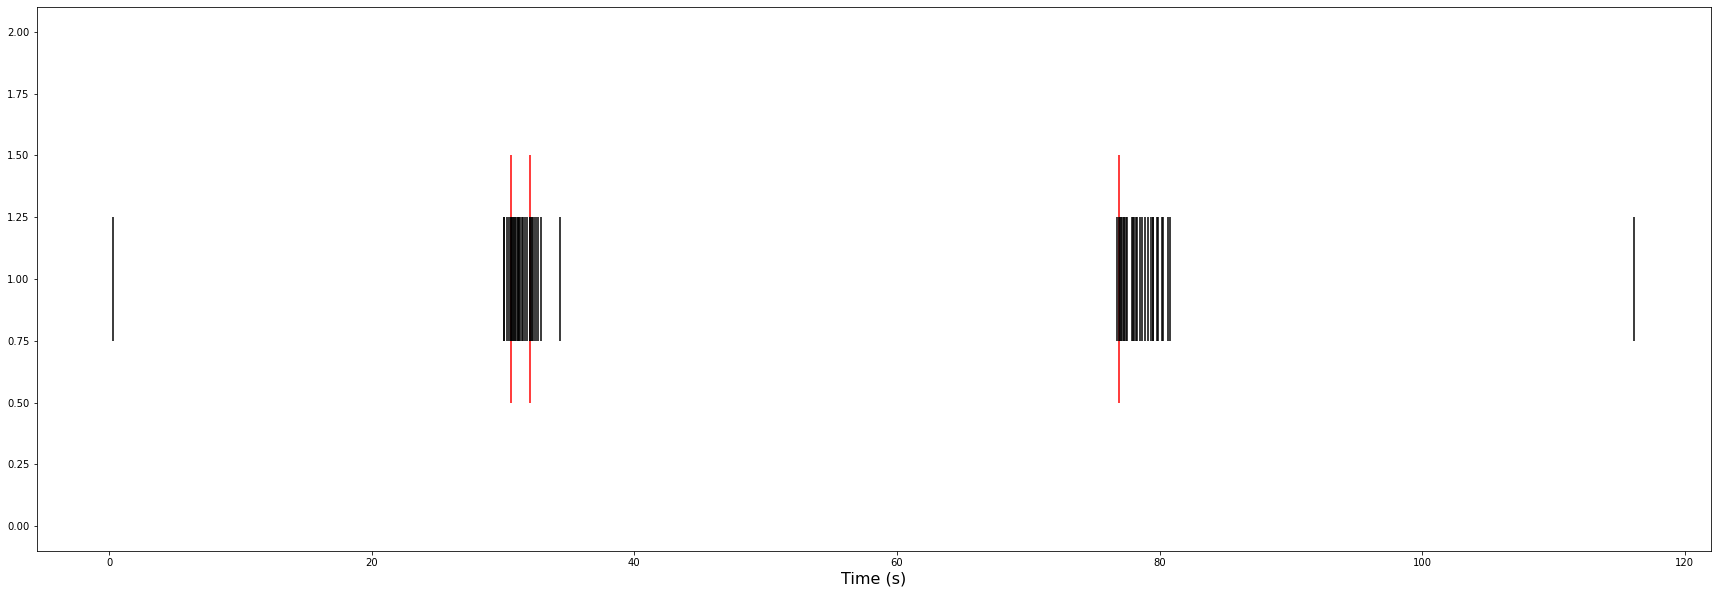

Text(0.5, 0, 'Time (s)')

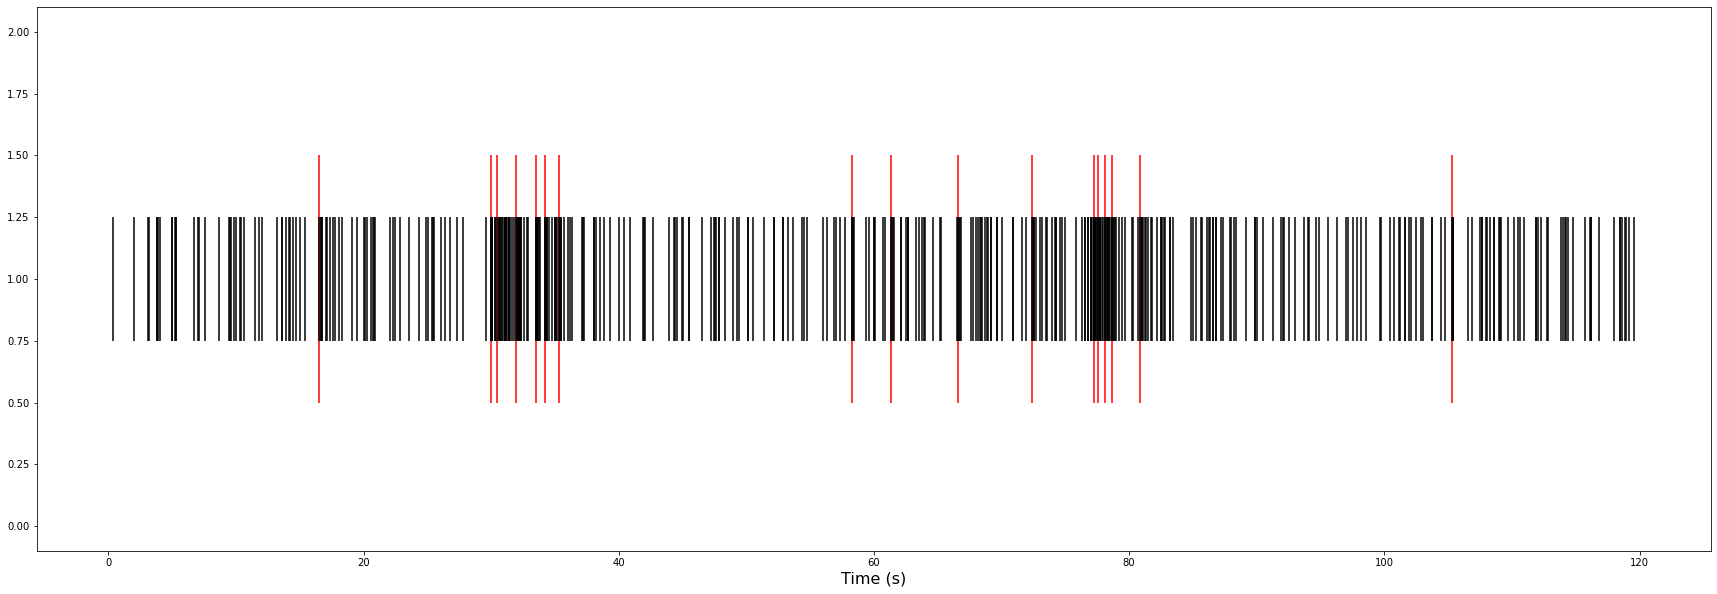

Text(0.5, 0, 'Time (s)')

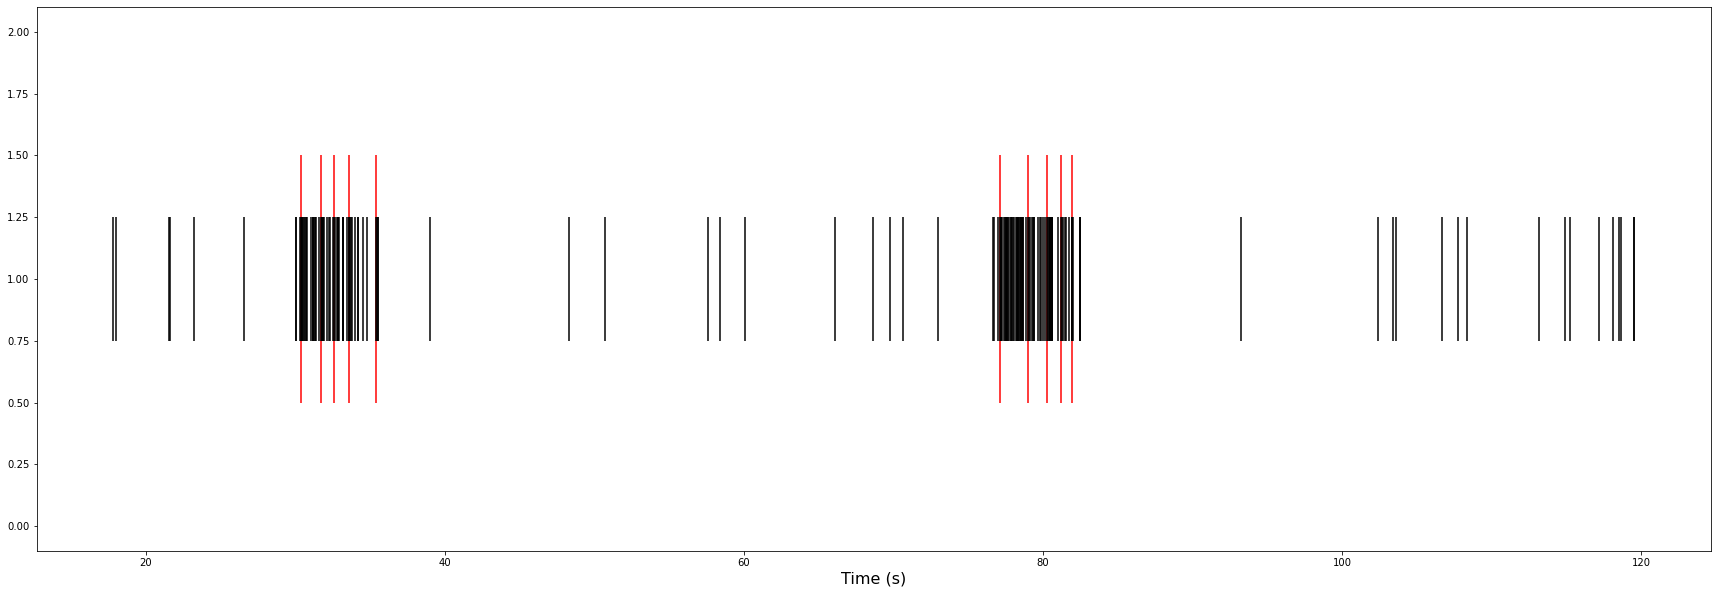

Text(0.5, 0, 'Time (s)')

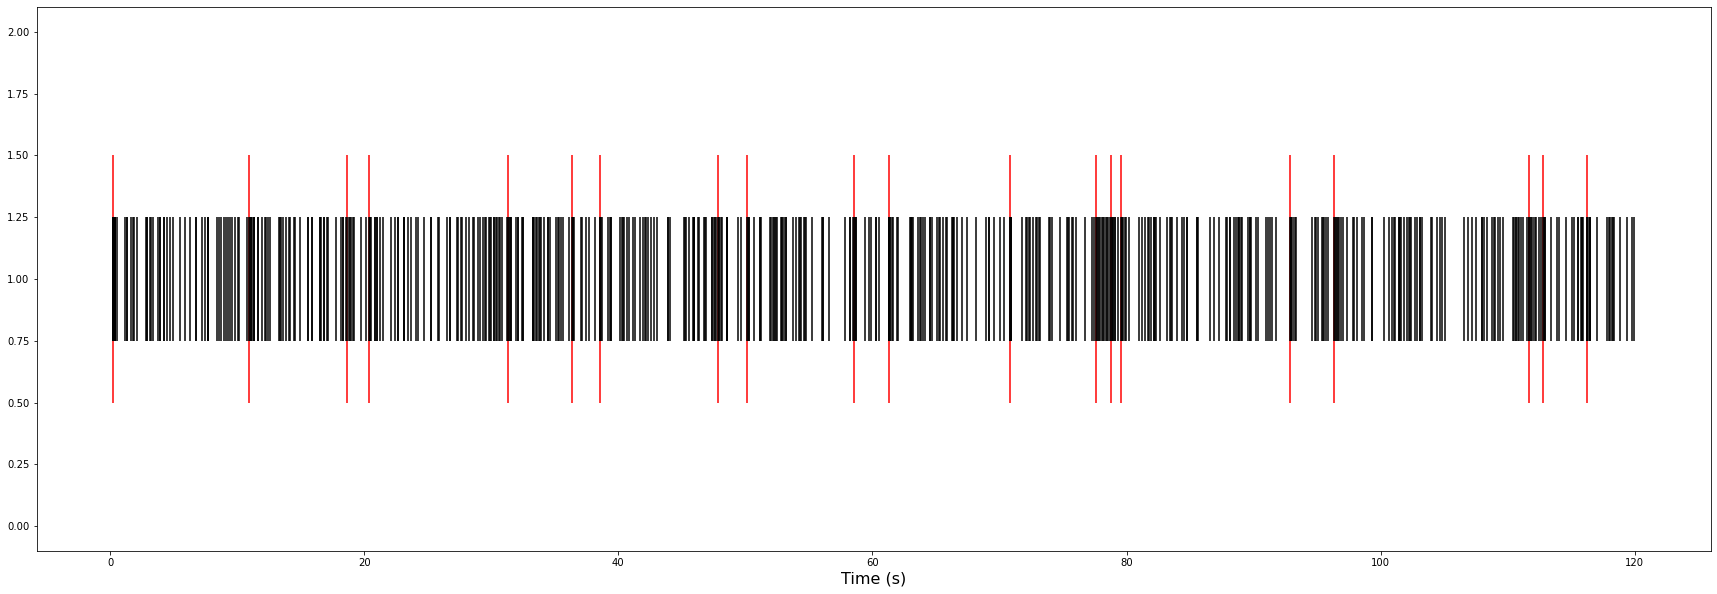

Text(0.5, 0, 'Time (s)')

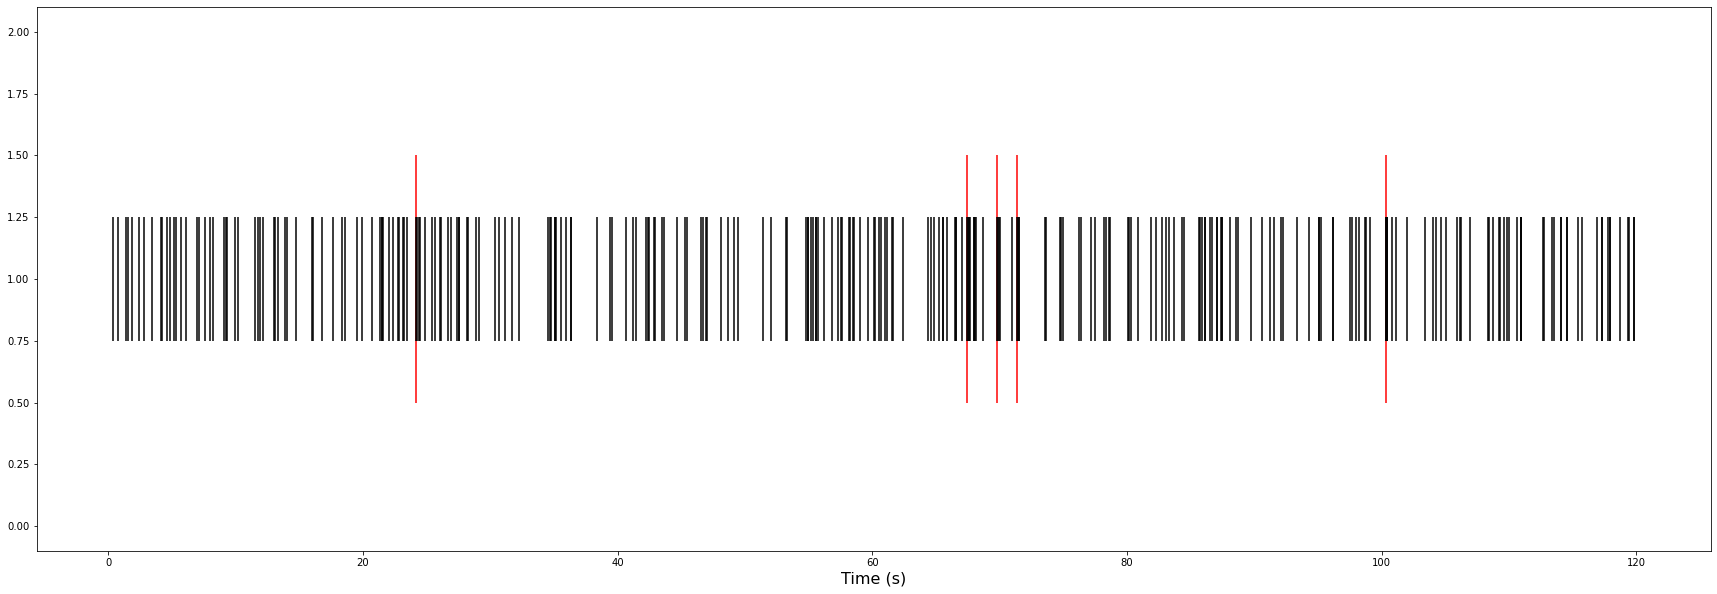

Text(0.5, 0, 'Time (s)')

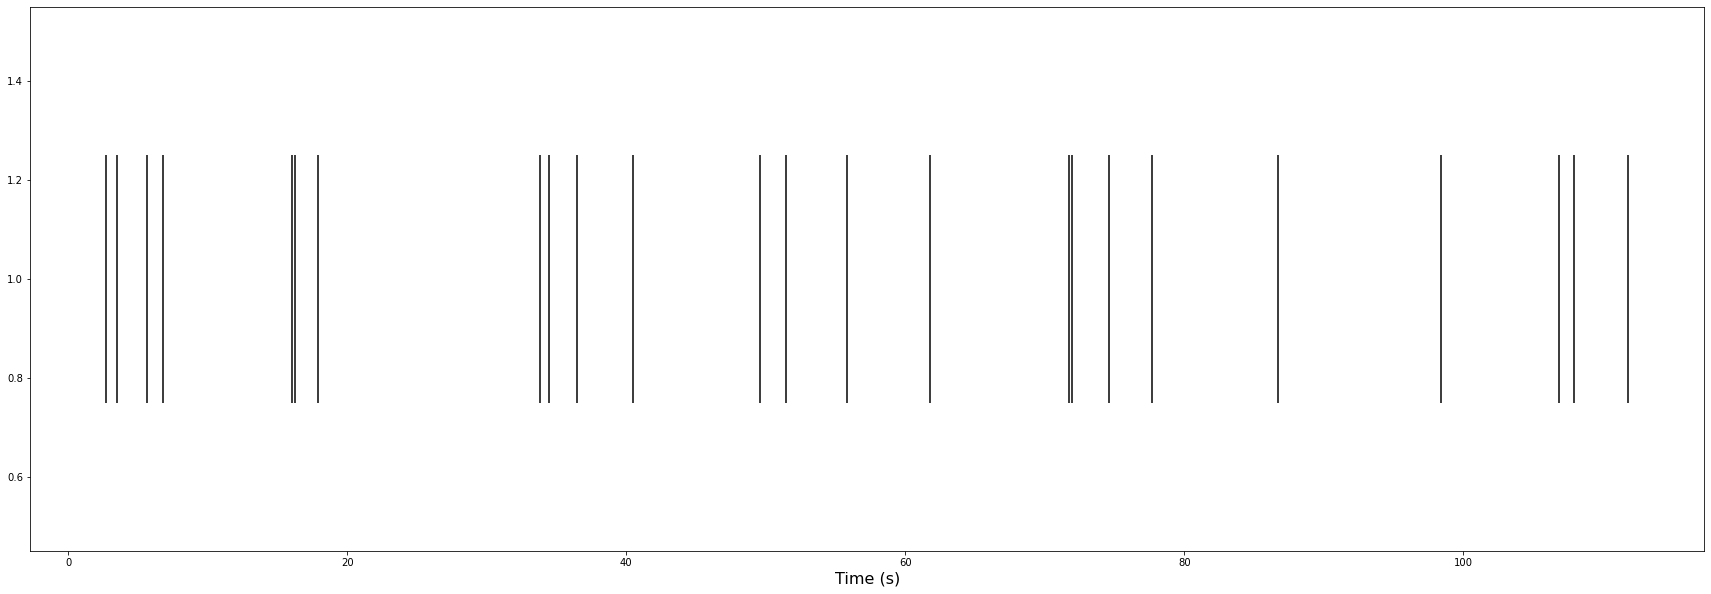

Text(0.5, 0, 'Time (s)')

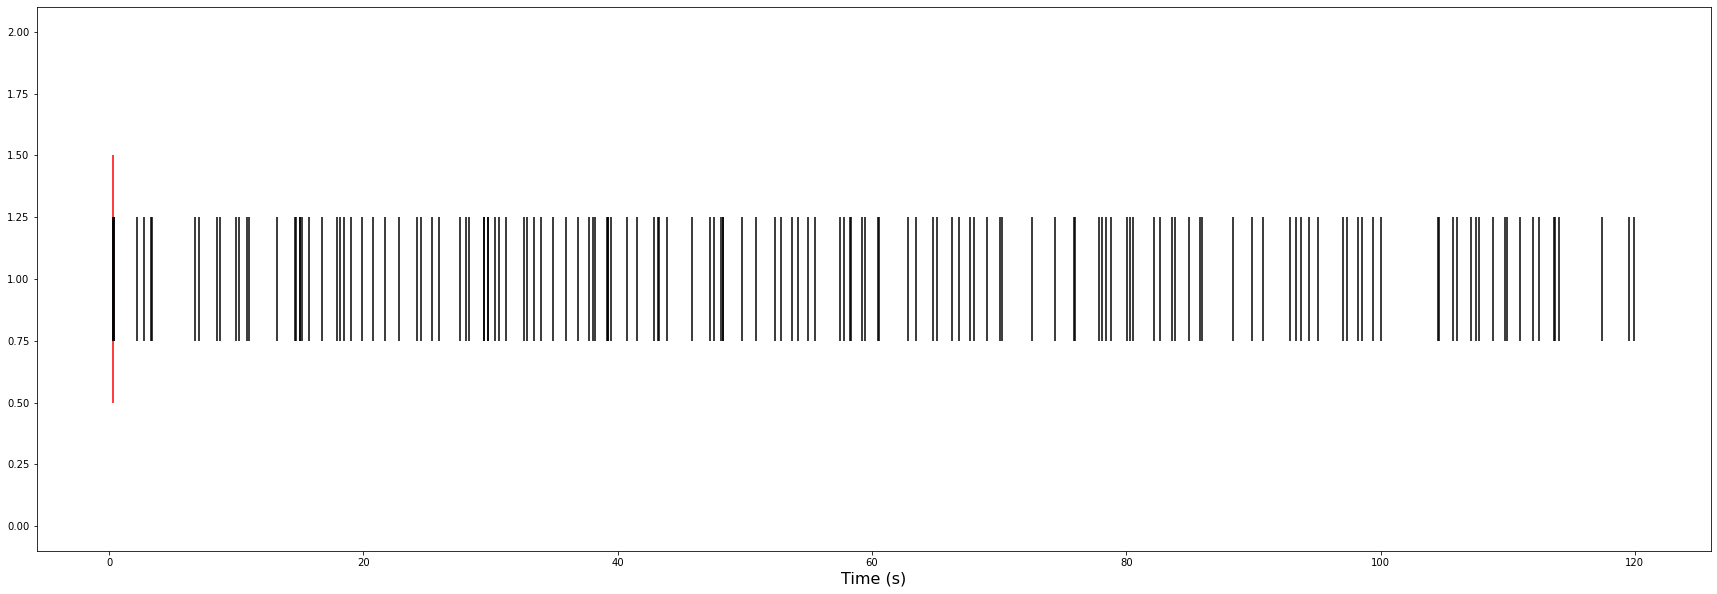

Text(0.5, 0, 'Time (s)')

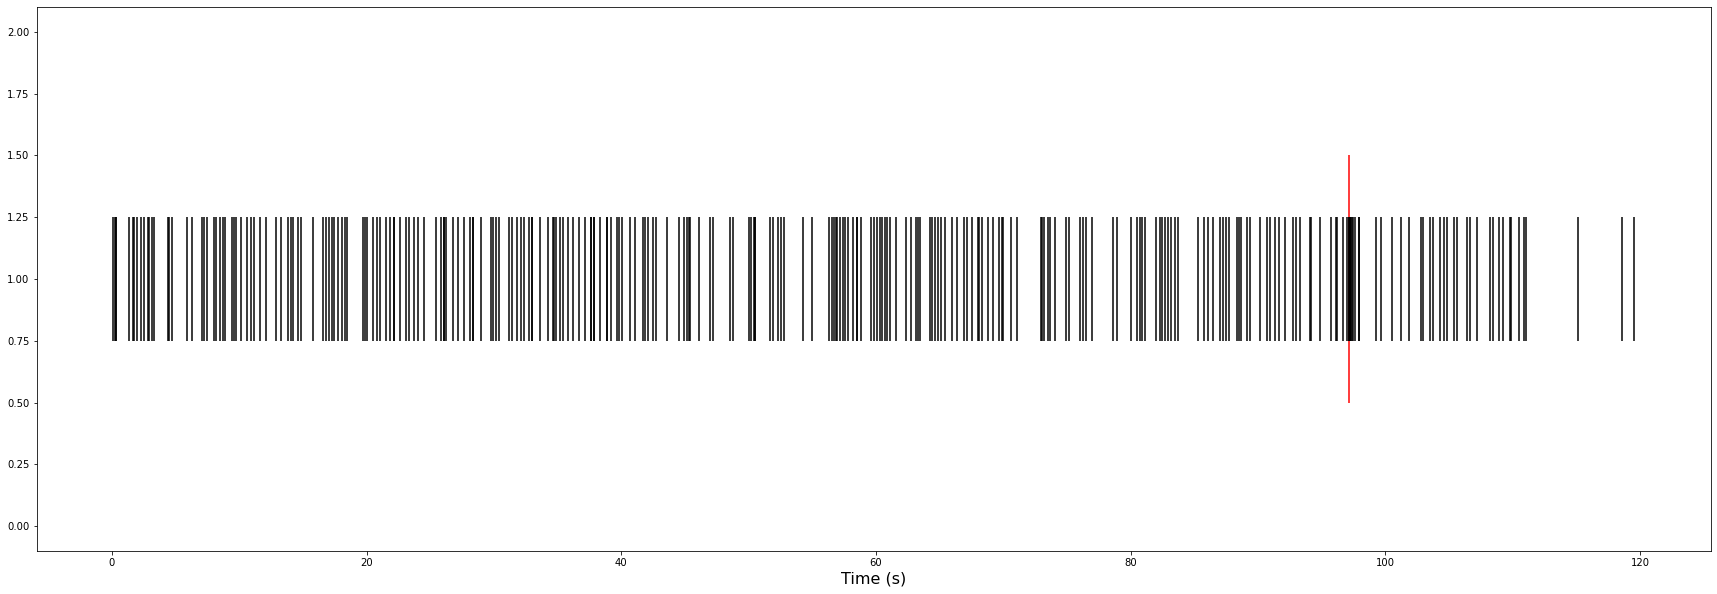

Text(0.5, 0, 'Time (s)')

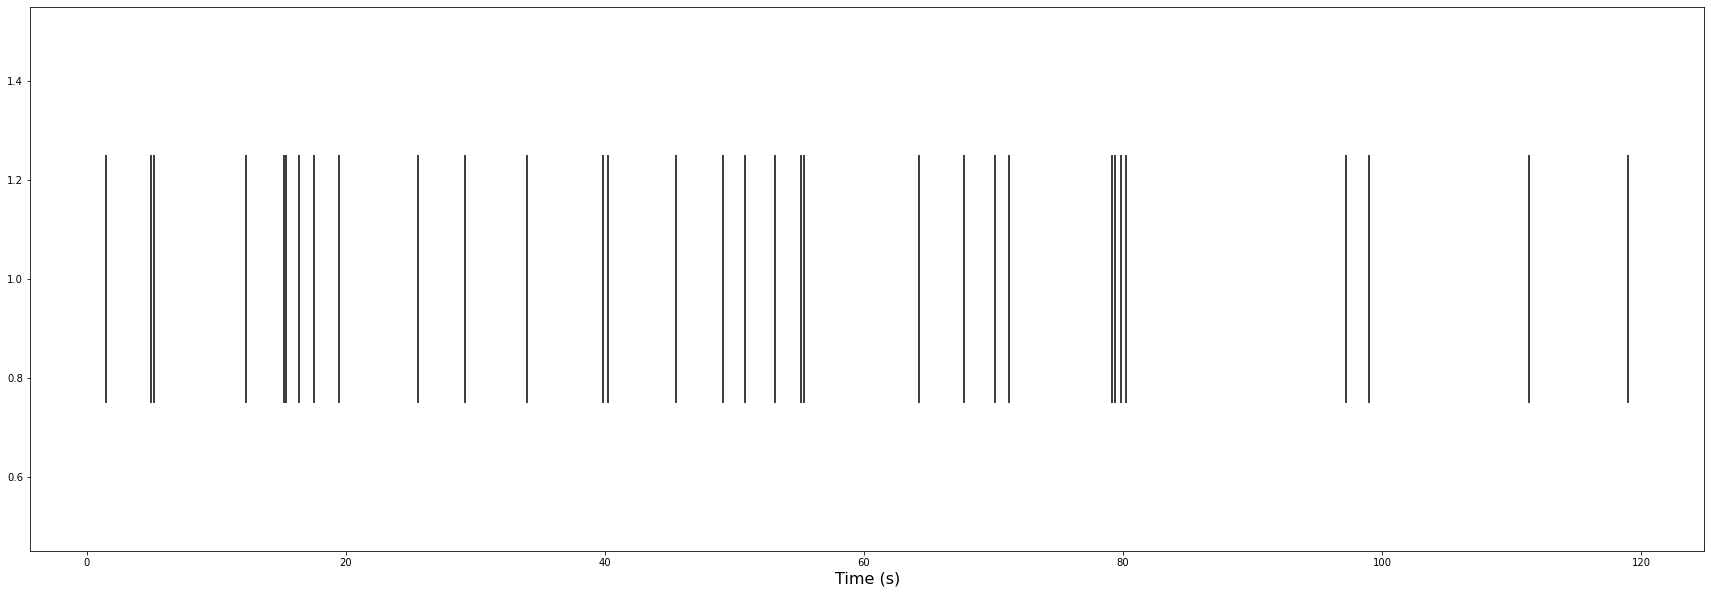

Text(0.5, 0, 'Time (s)')

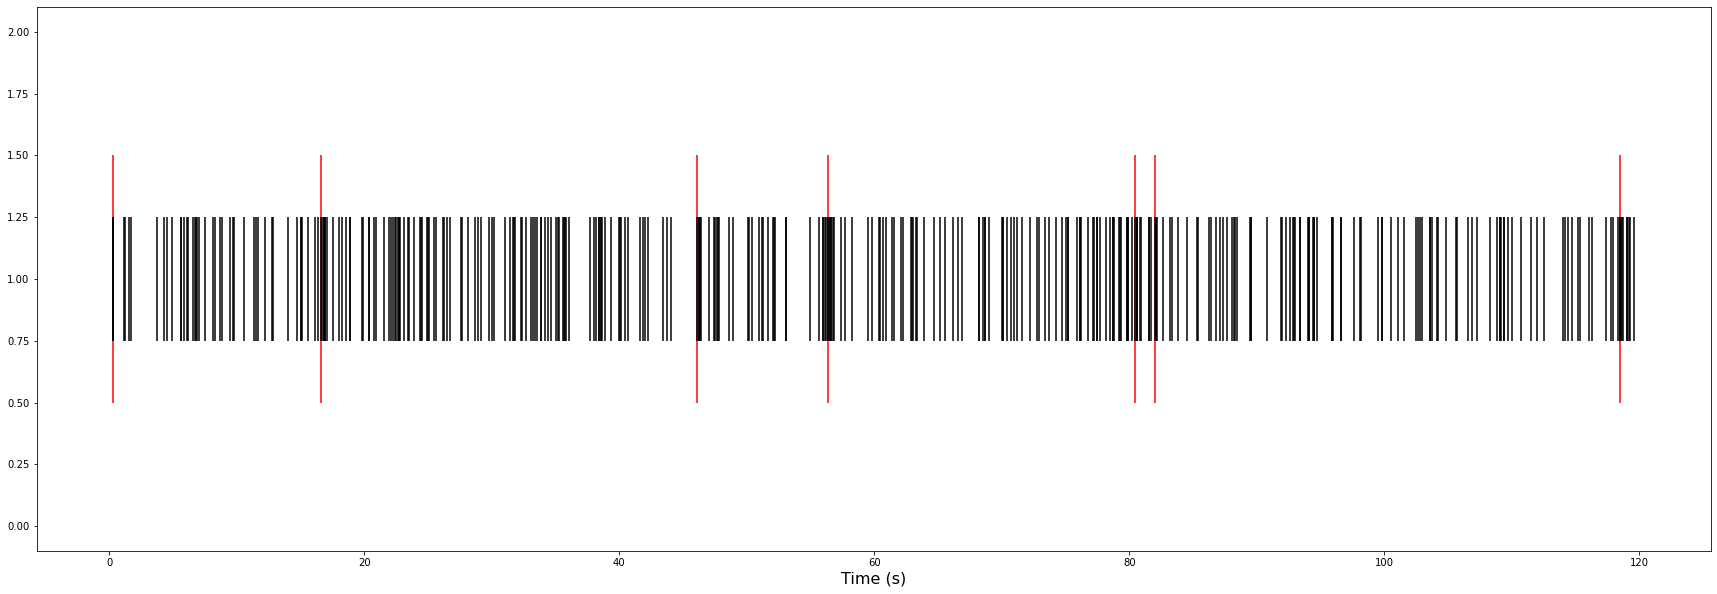

Text(0.5, 0, 'Time (s)')

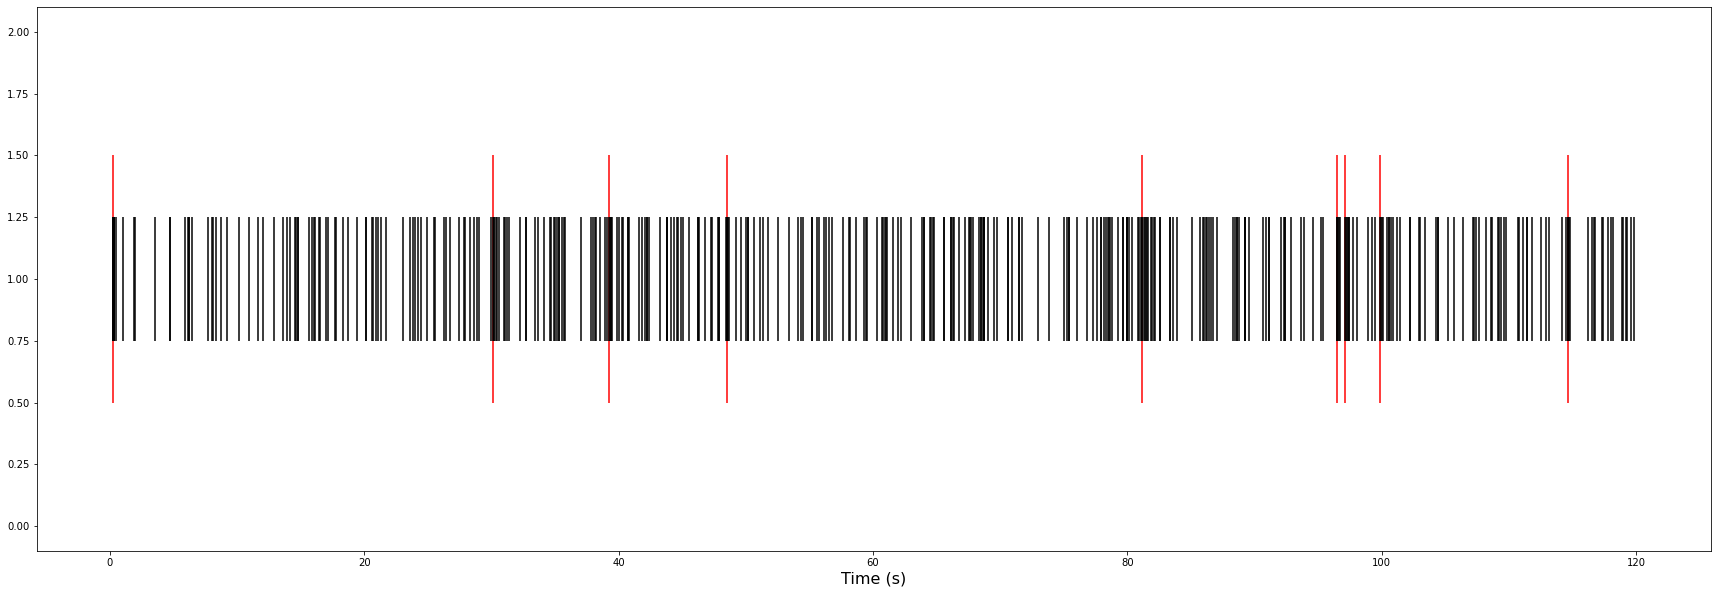

Text(0.5, 0, 'Time (s)')

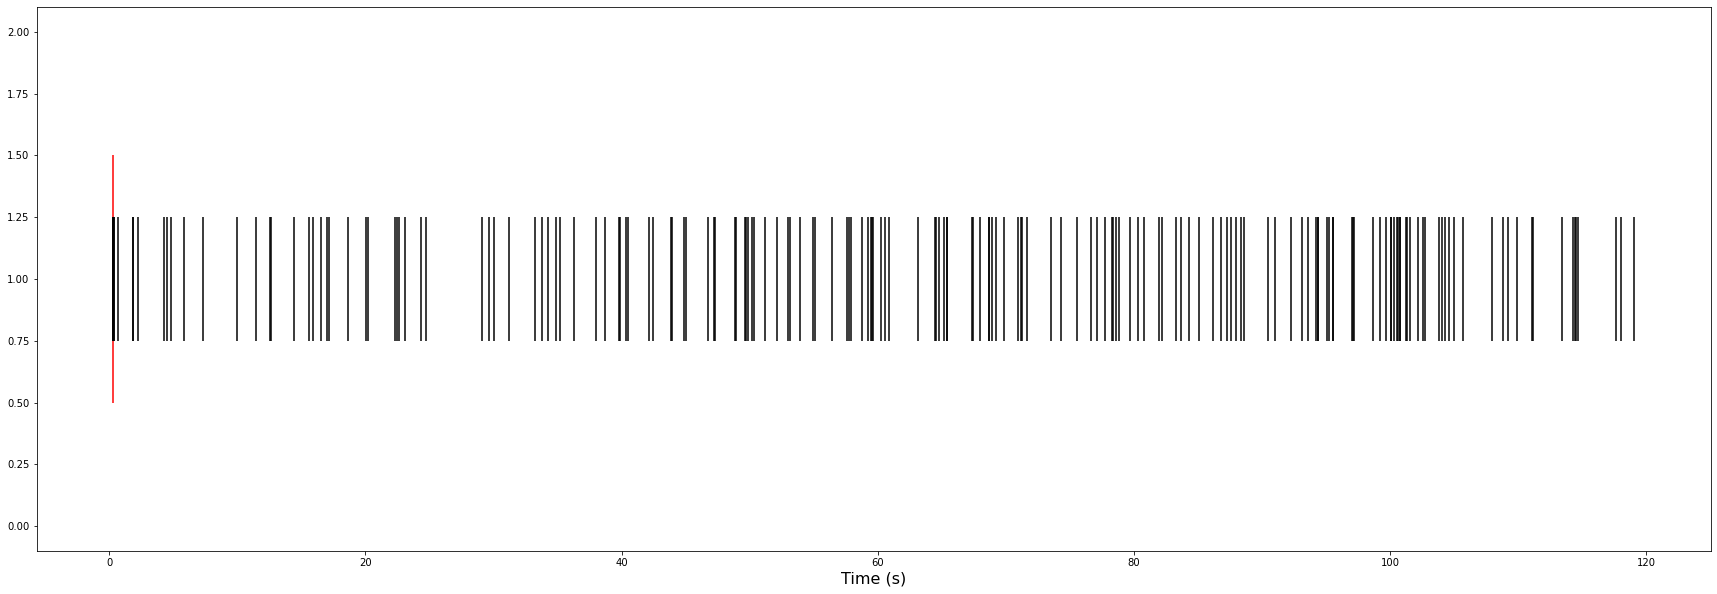

Text(0.5, 0, 'Time (s)')

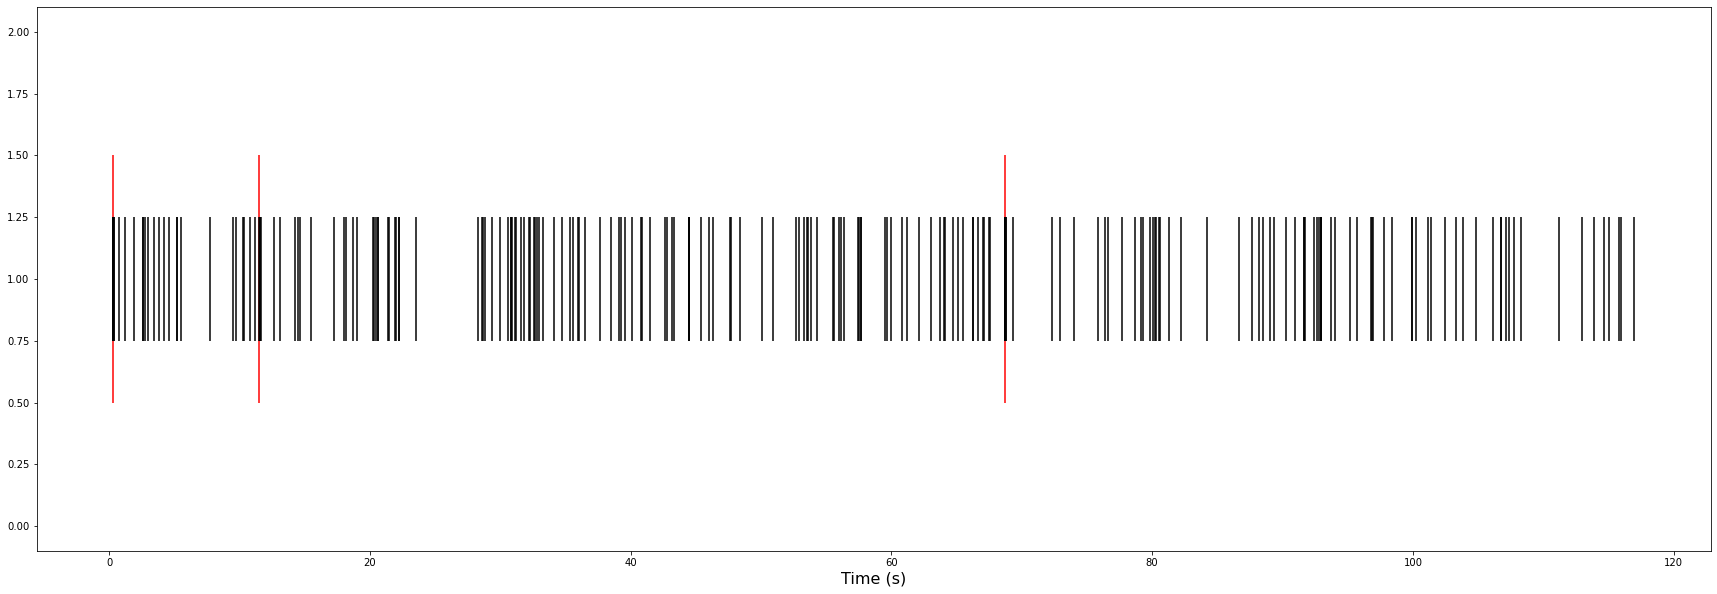

Text(0.5, 0, 'Time (s)')

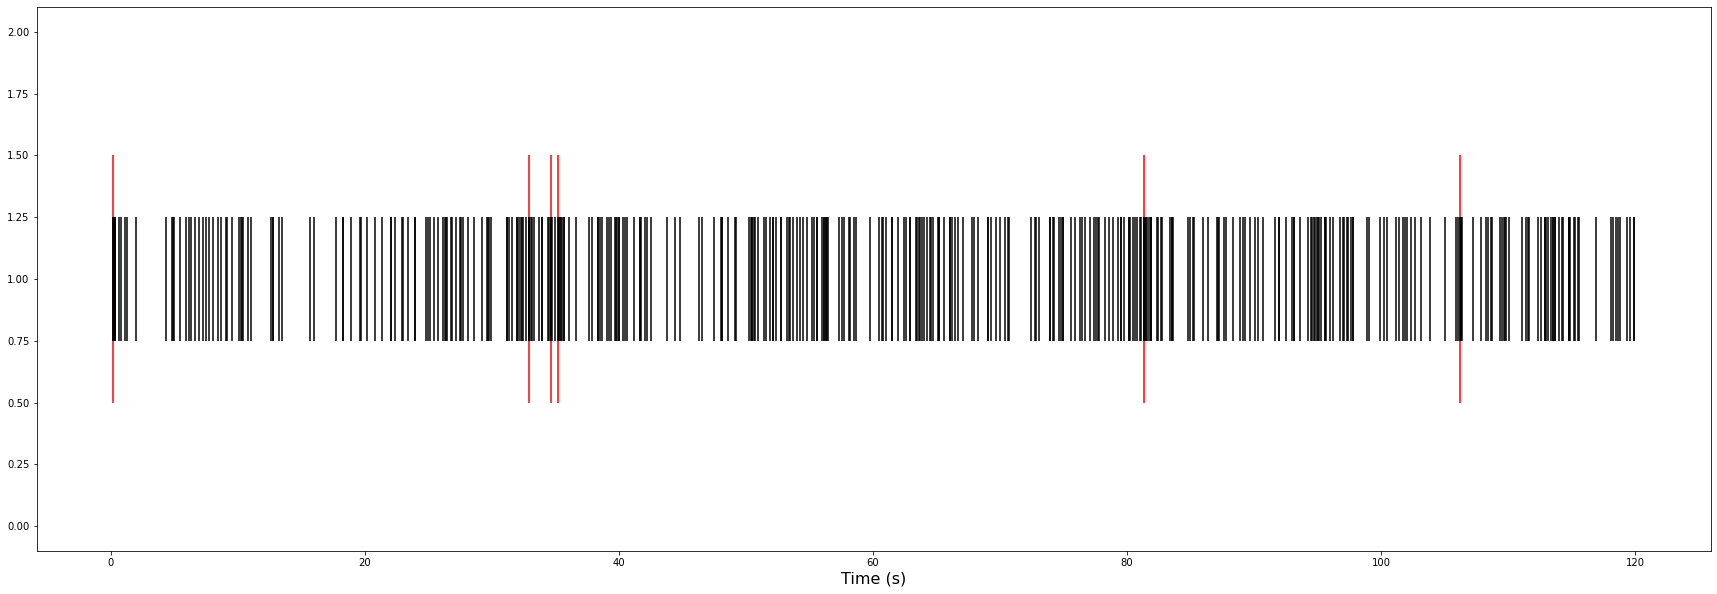

Text(0.5, 0, 'Time (s)')

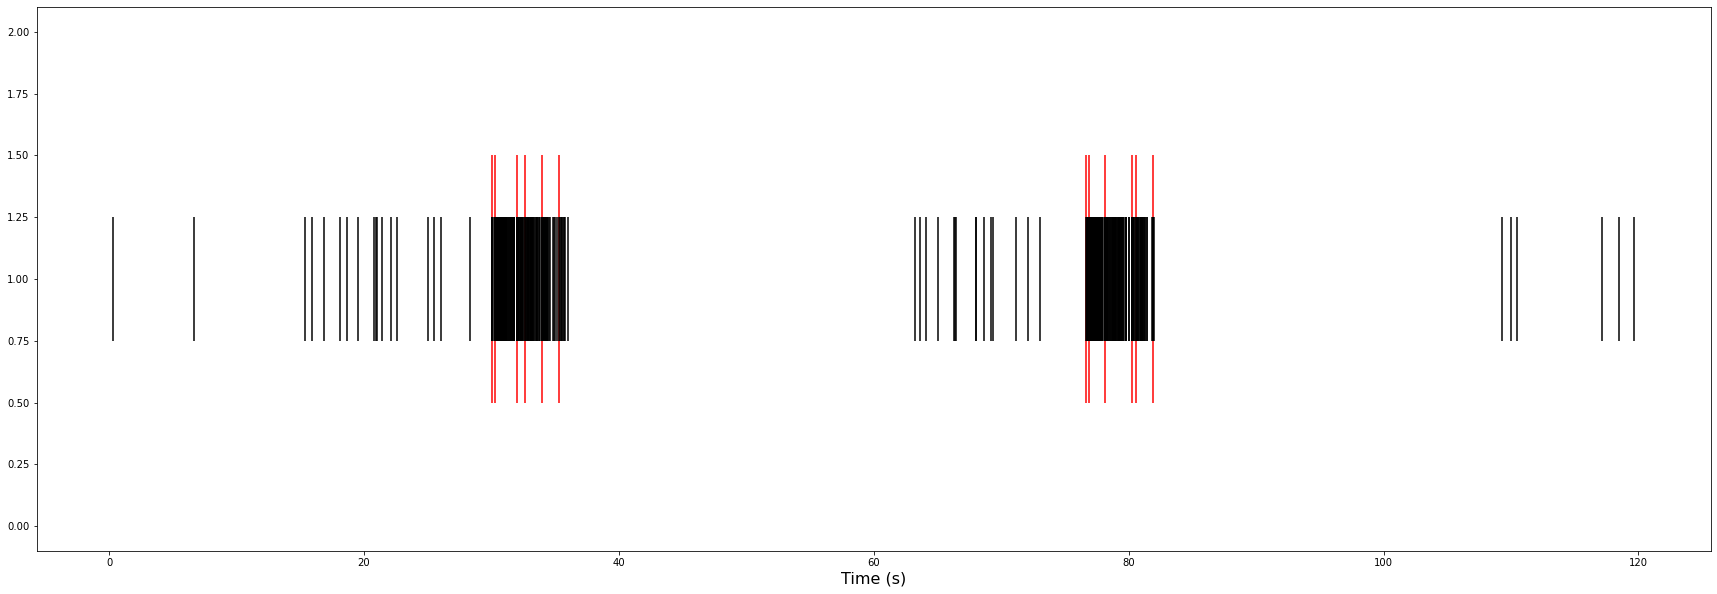

Text(0.5, 0, 'Time (s)')

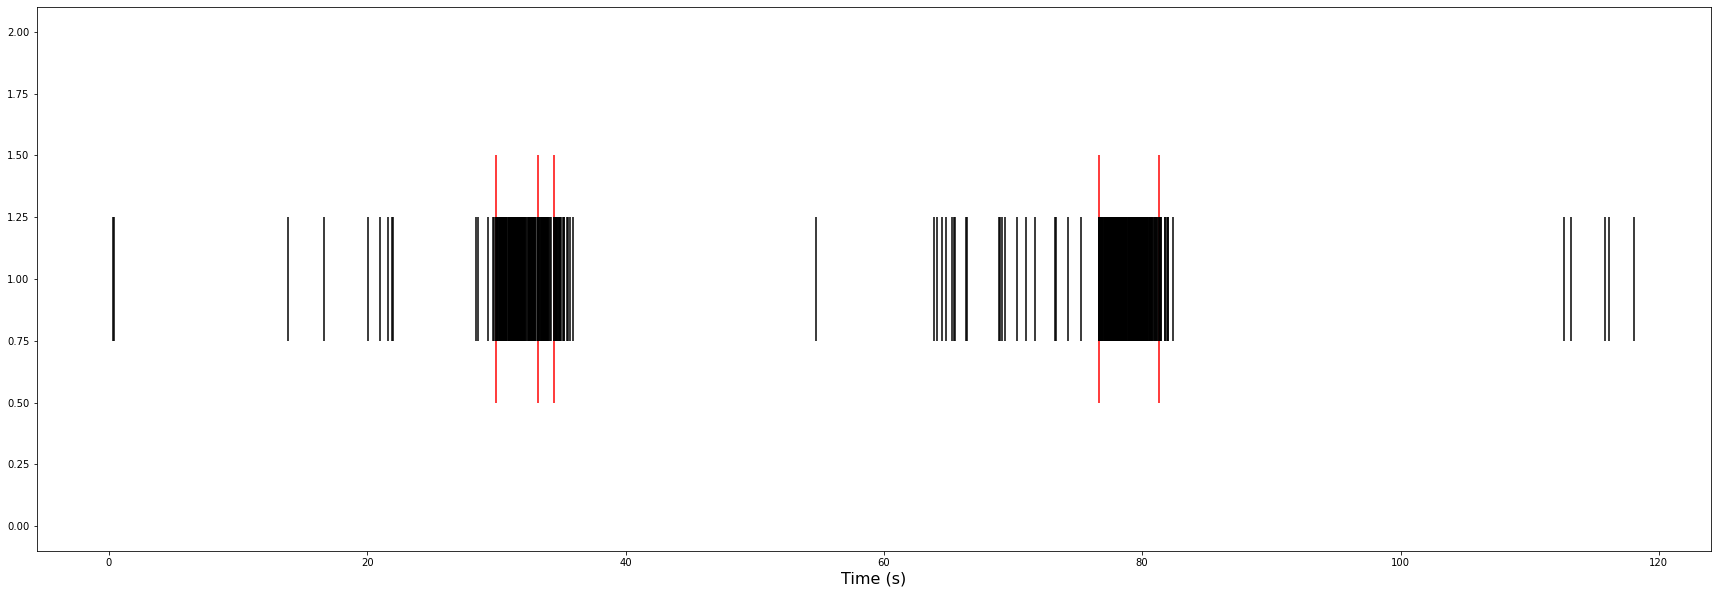

Text(0.5, 0, 'Time (s)')

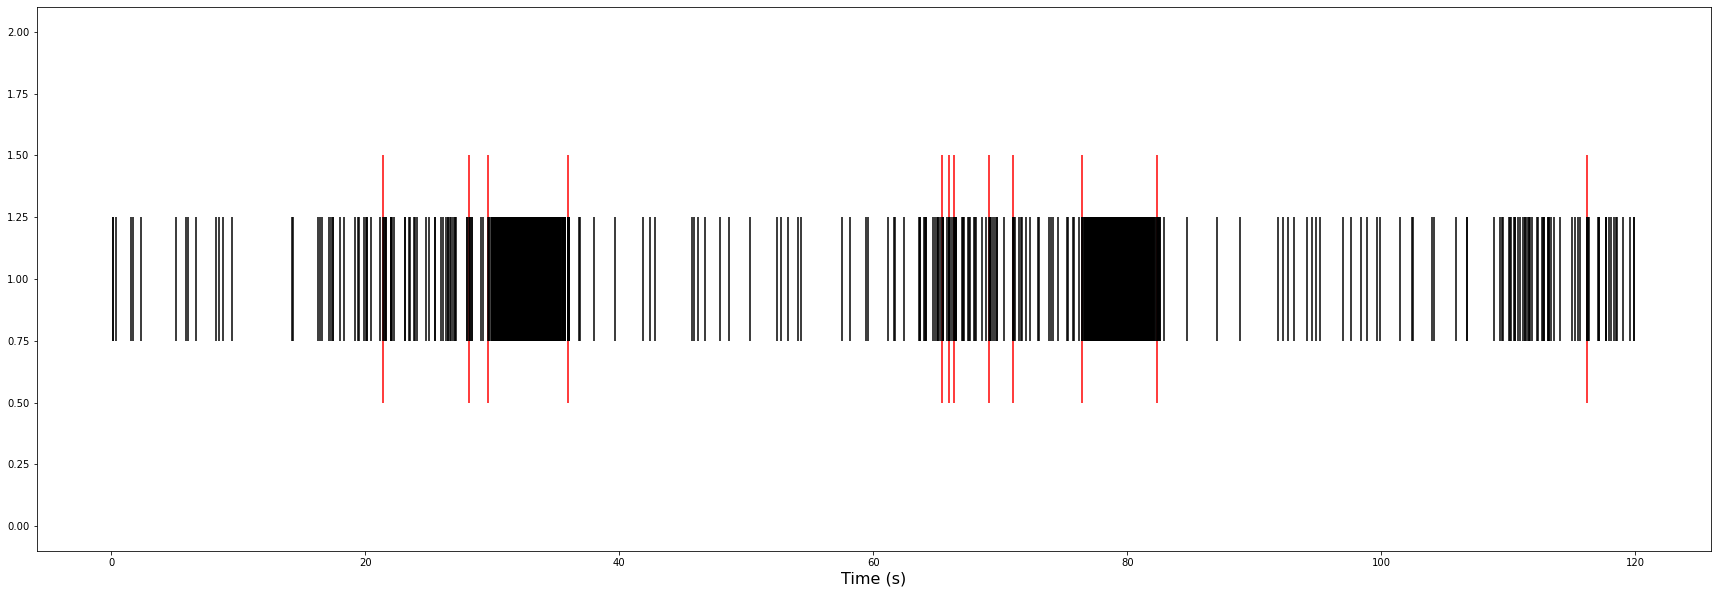

Text(0.5, 0, 'Time (s)')

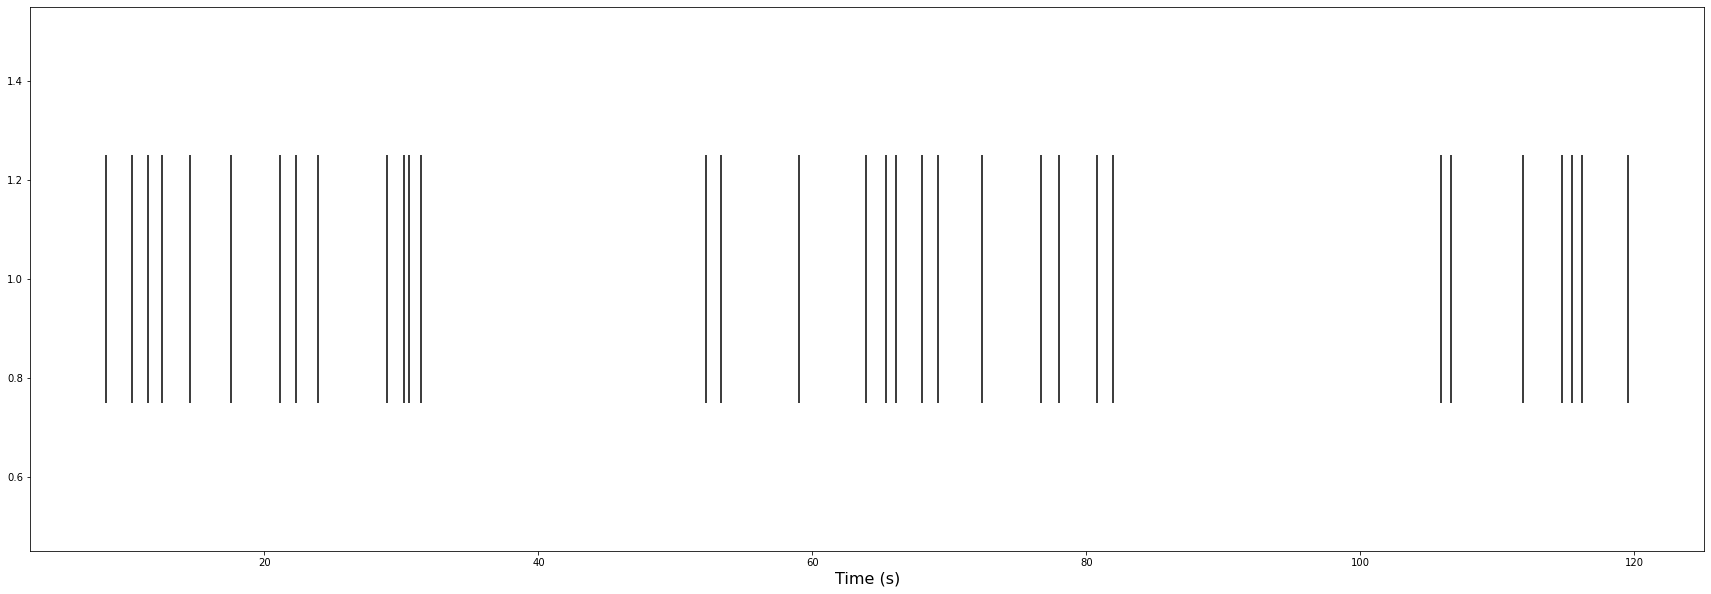

Text(0.5, 0, 'Time (s)')

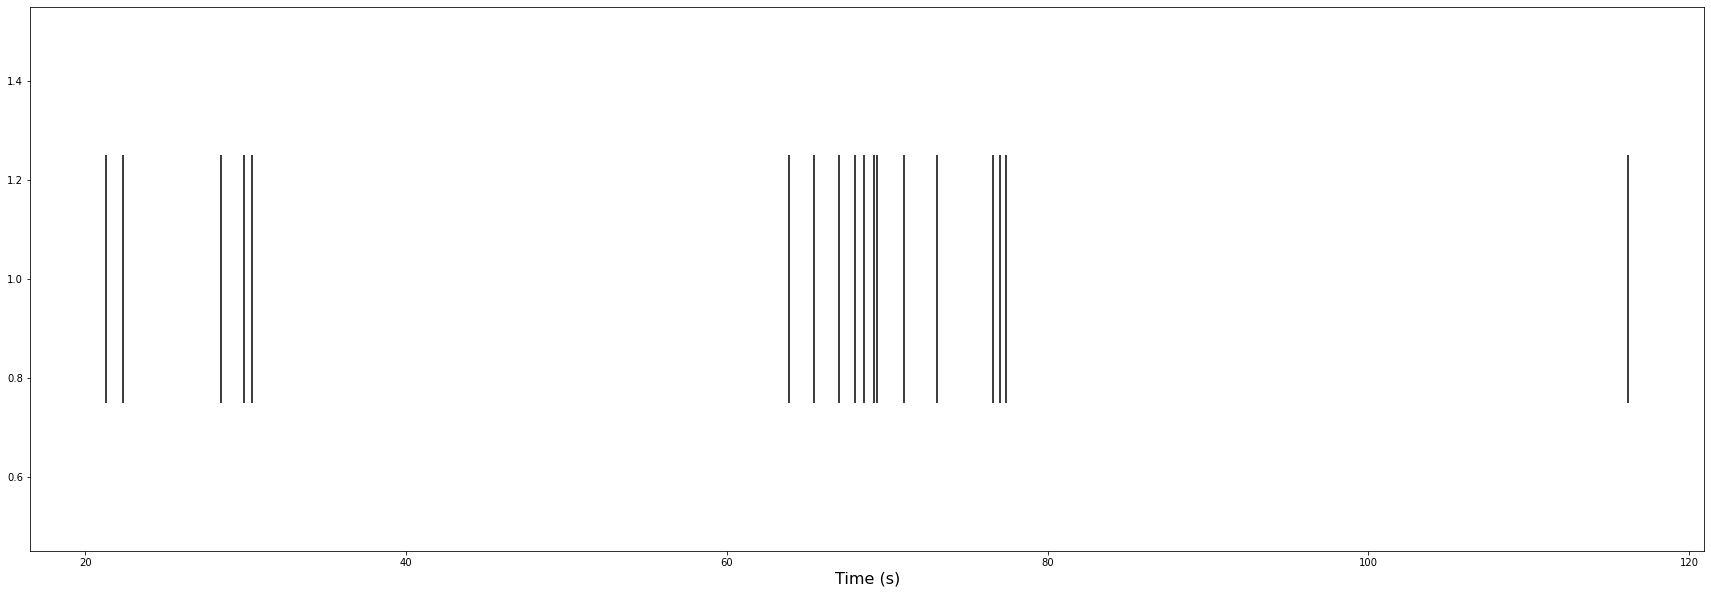

Text(0.5, 0, 'Time (s)')

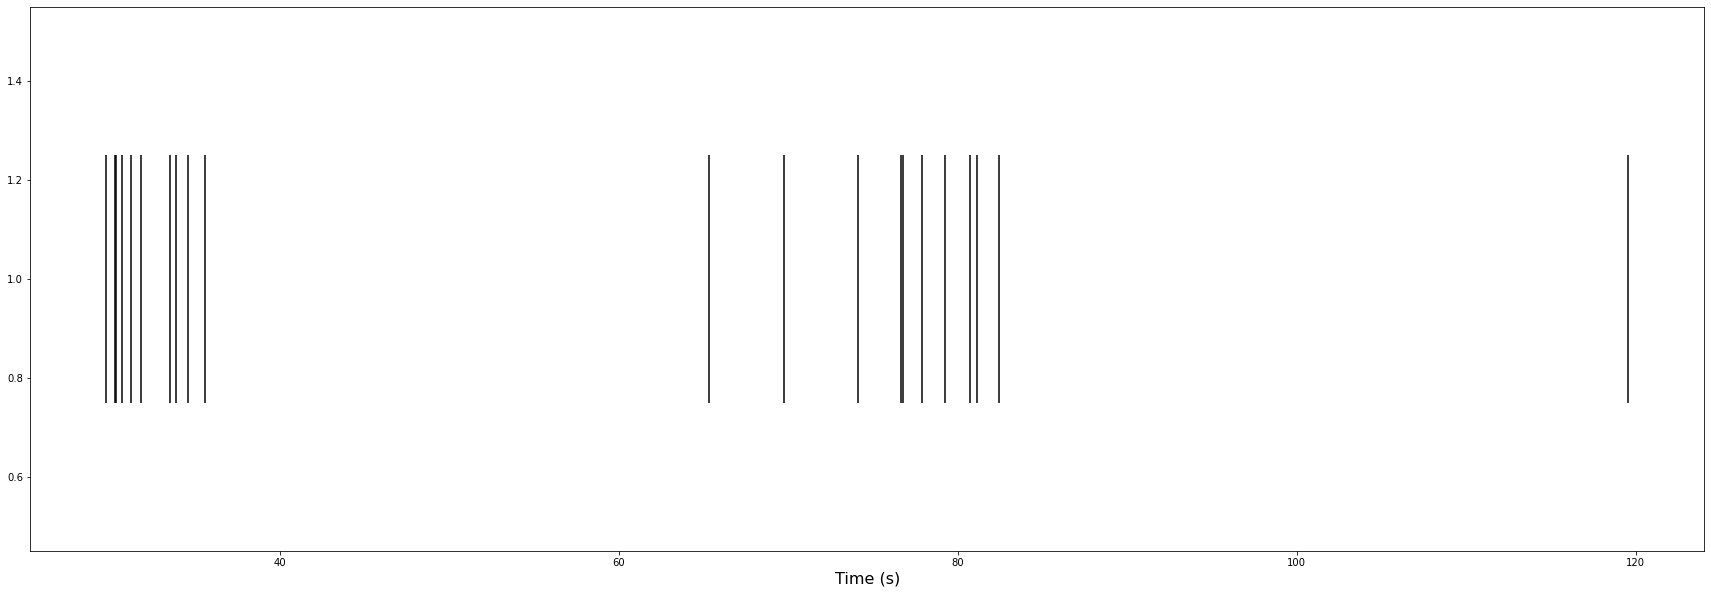

Text(0.5, 0, 'Time (s)')

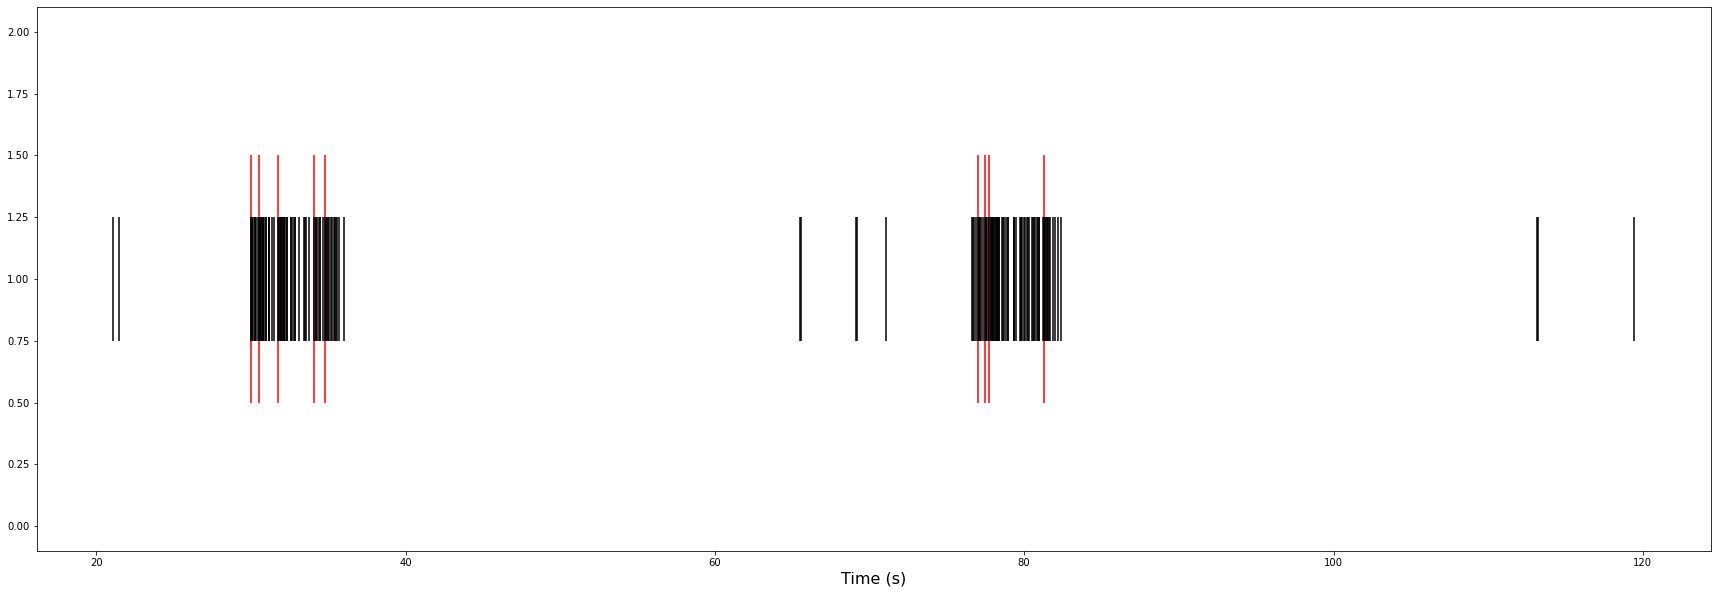

Text(0.5, 0, 'Time (s)')

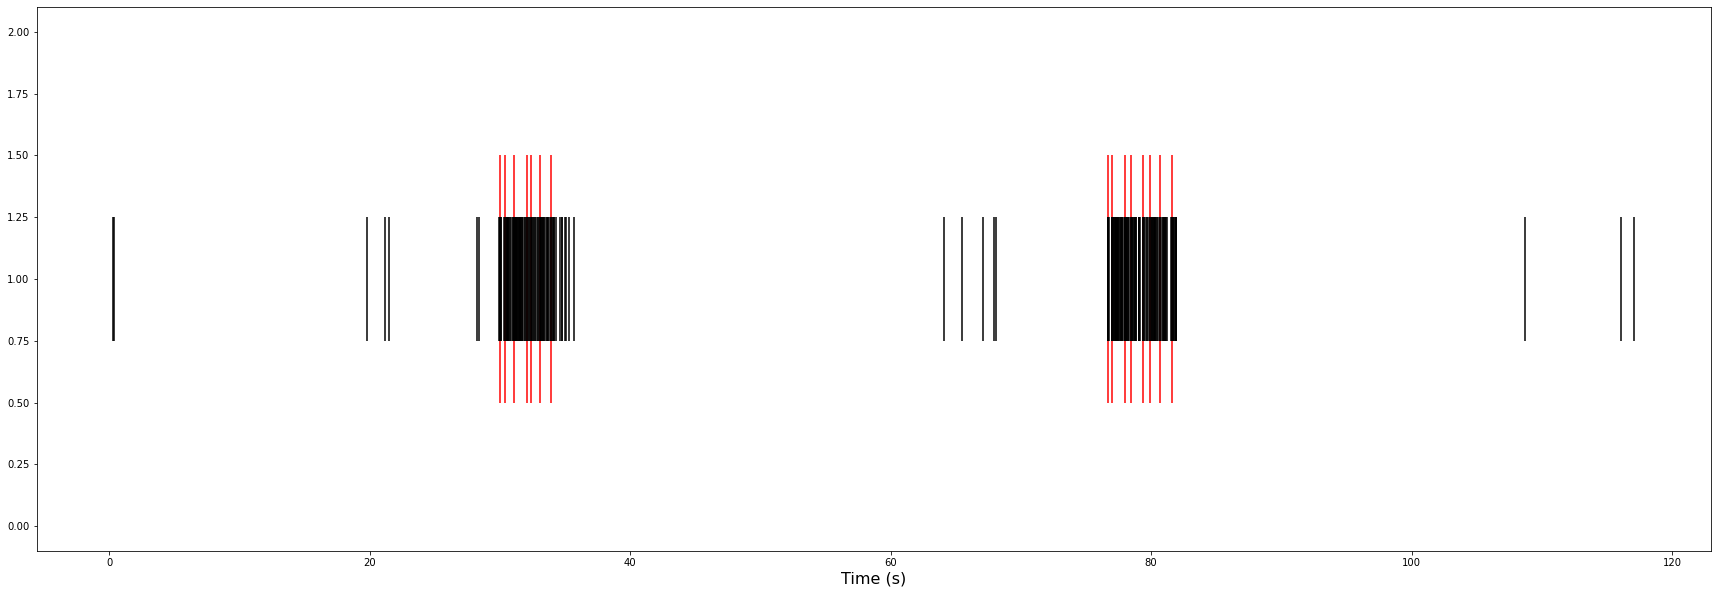

Text(0.5, 0, 'Time (s)')

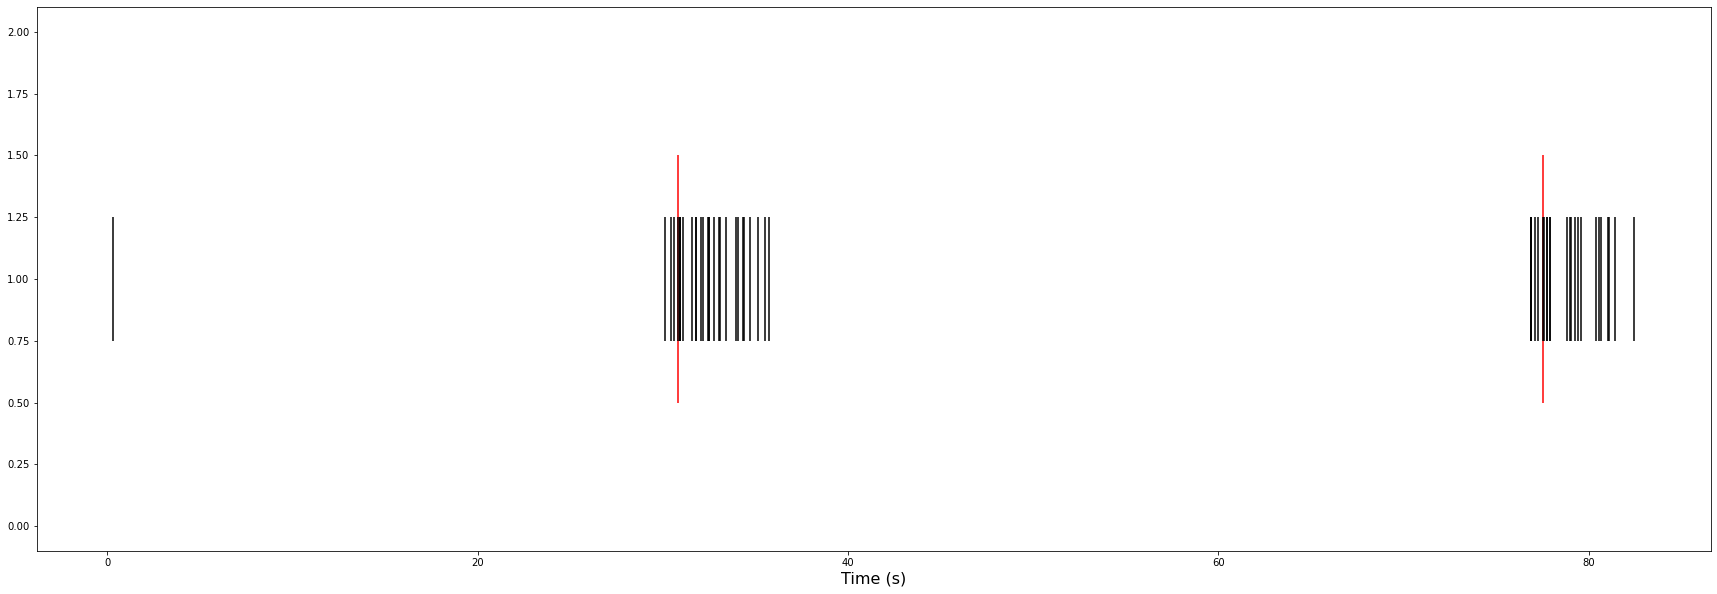

Text(0.5, 0, 'Time (s)')

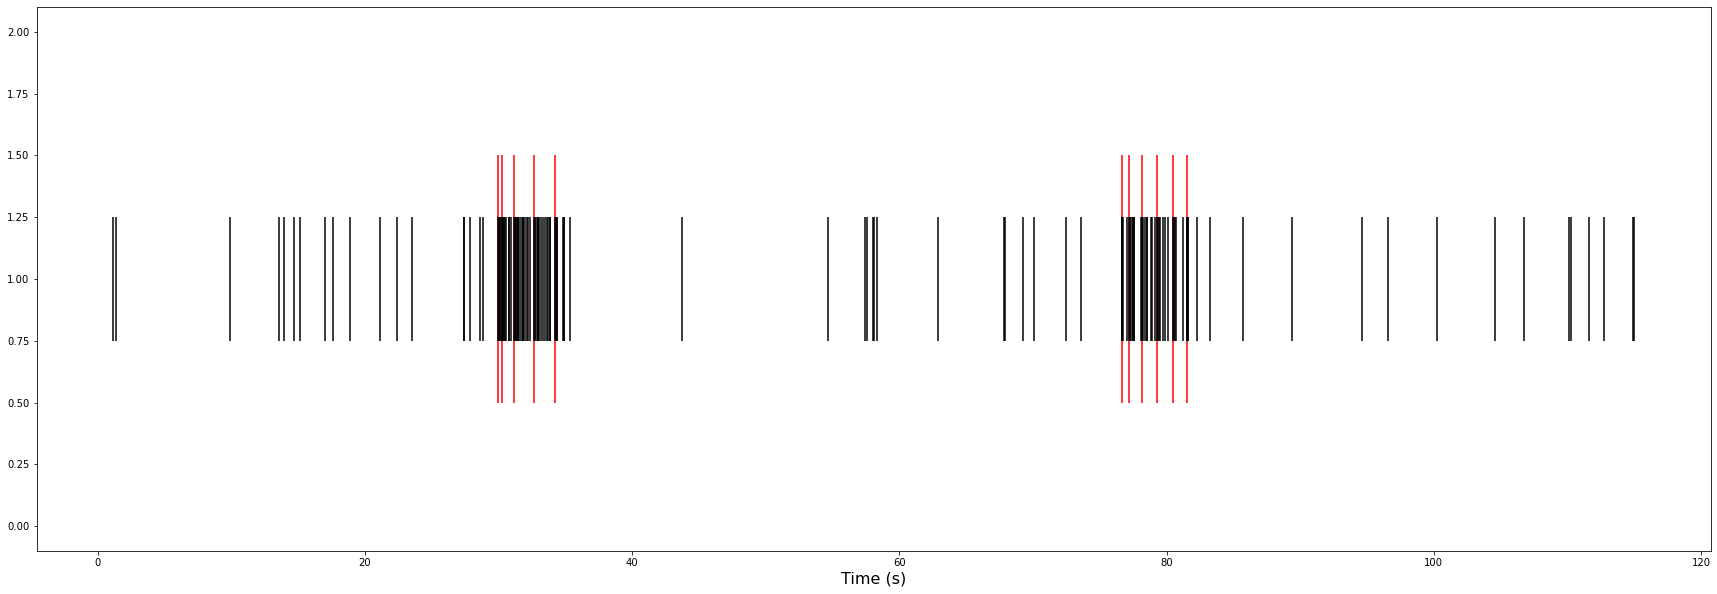

Text(0.5, 0, 'Time (s)')

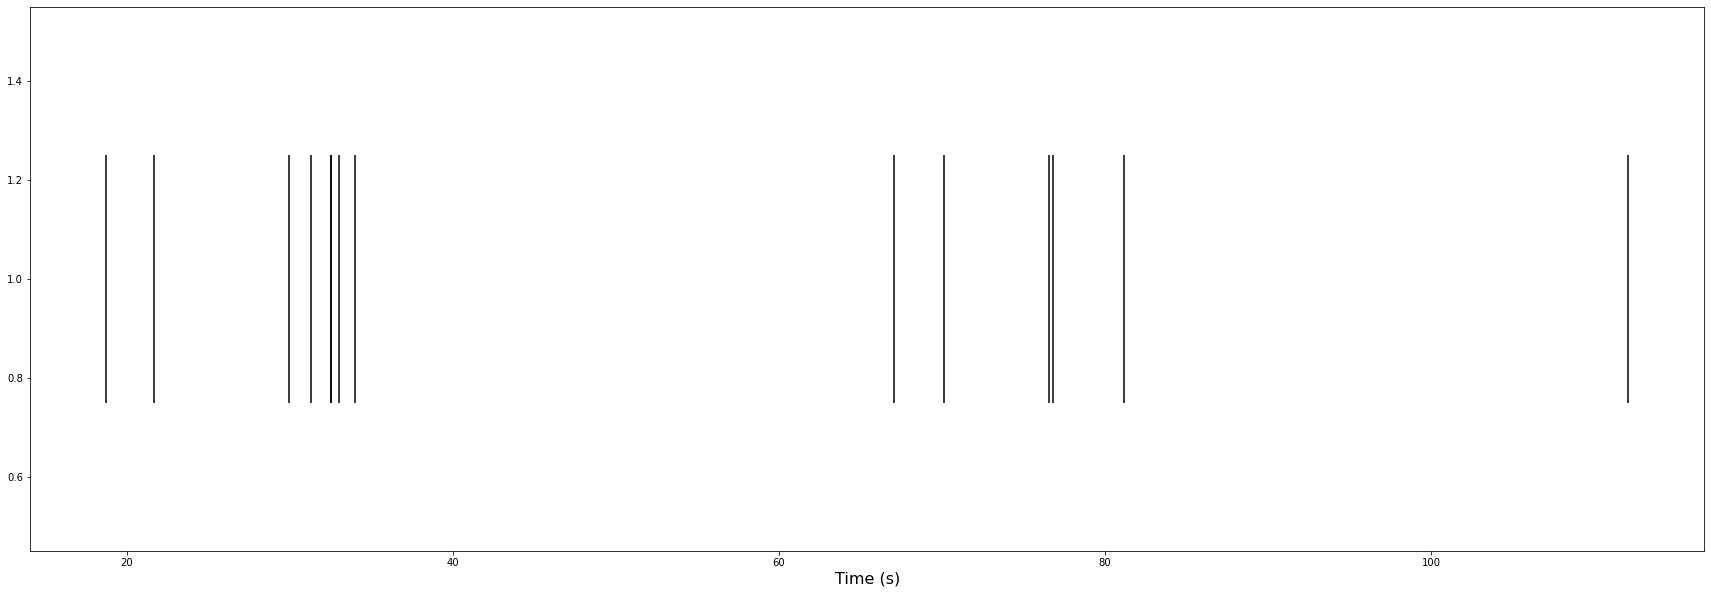

Text(0.5, 0, 'Time (s)')

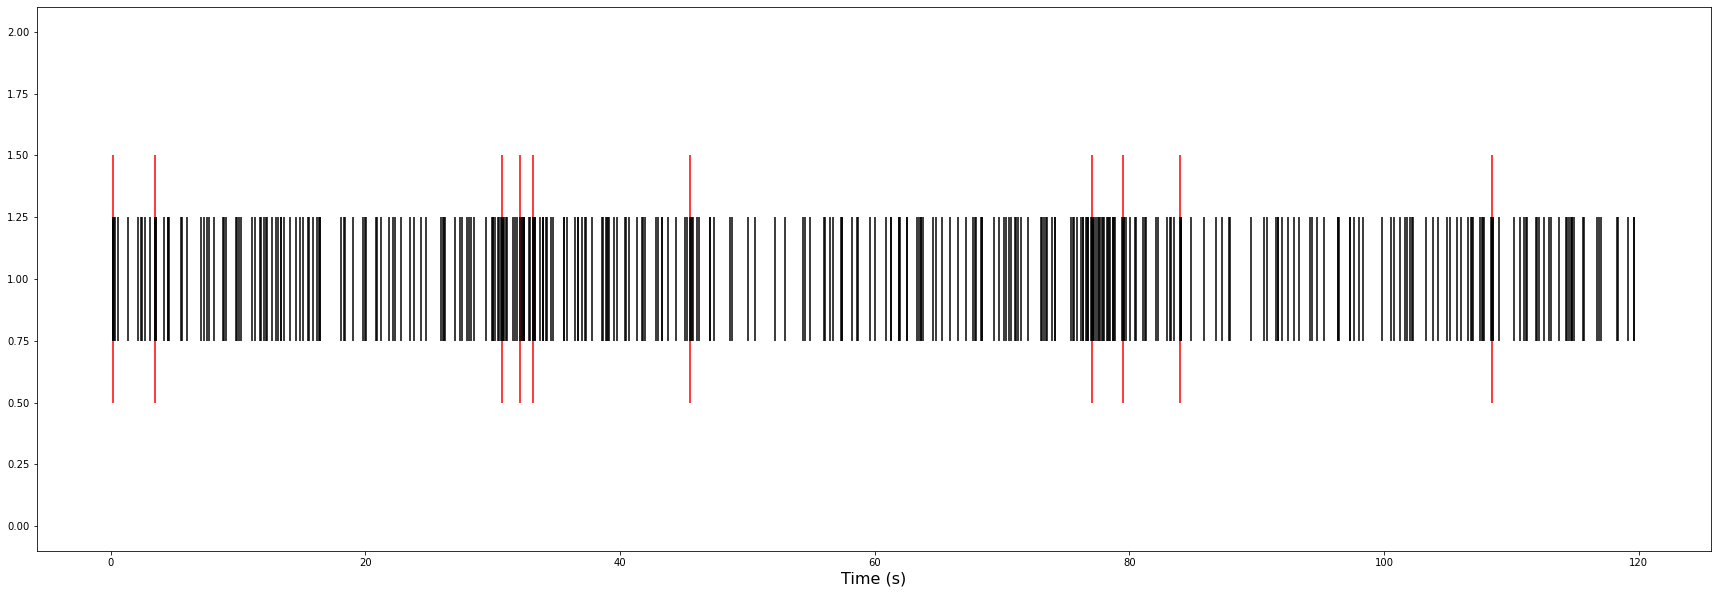

Text(0.5, 0, 'Time (s)')

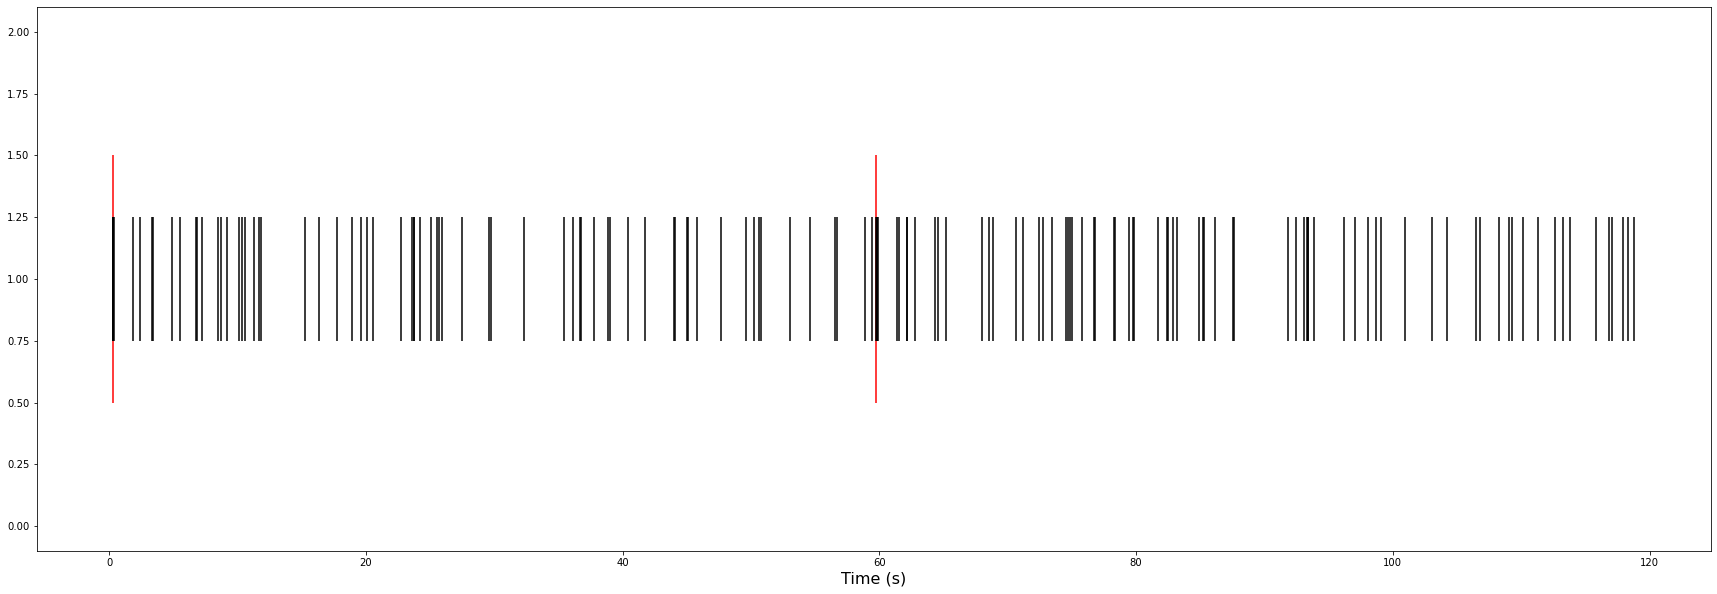

Text(0.5, 0, 'Time (s)')

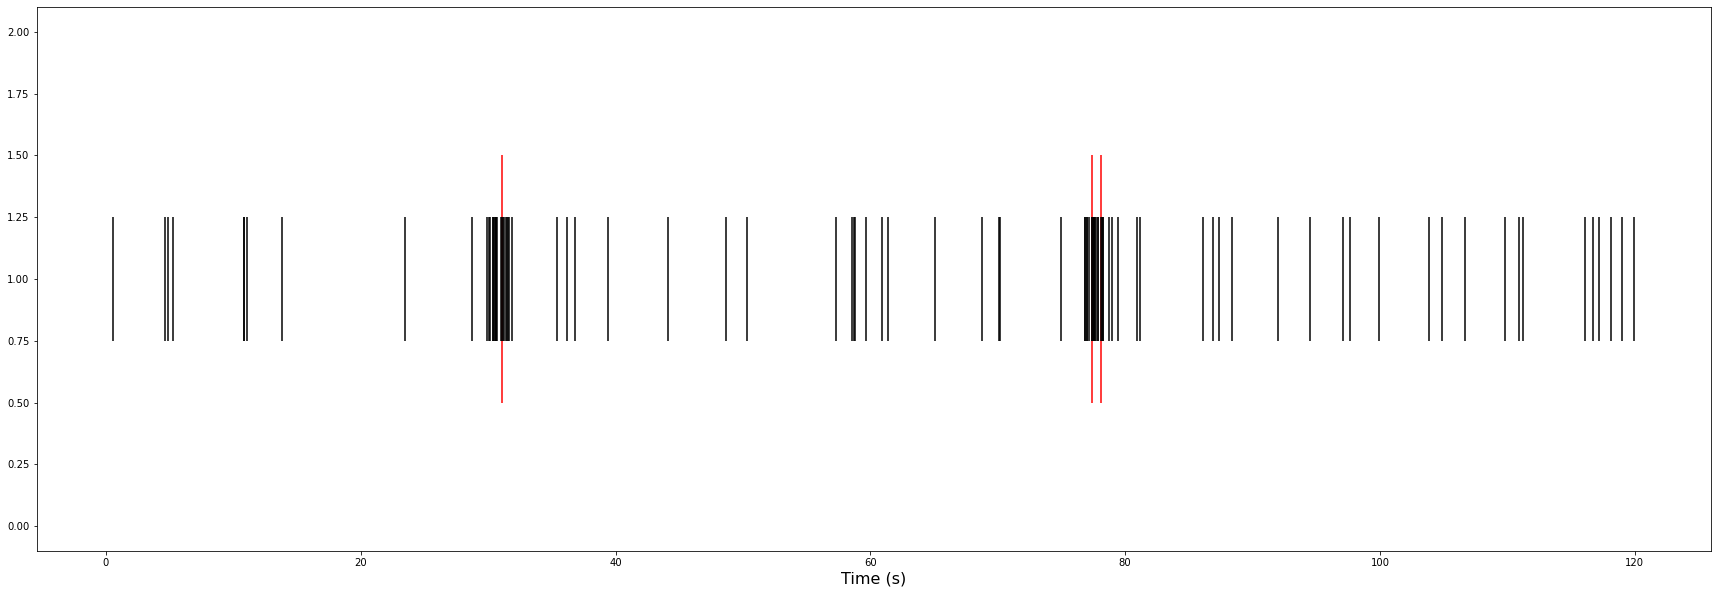

Text(0.5, 0, 'Time (s)')

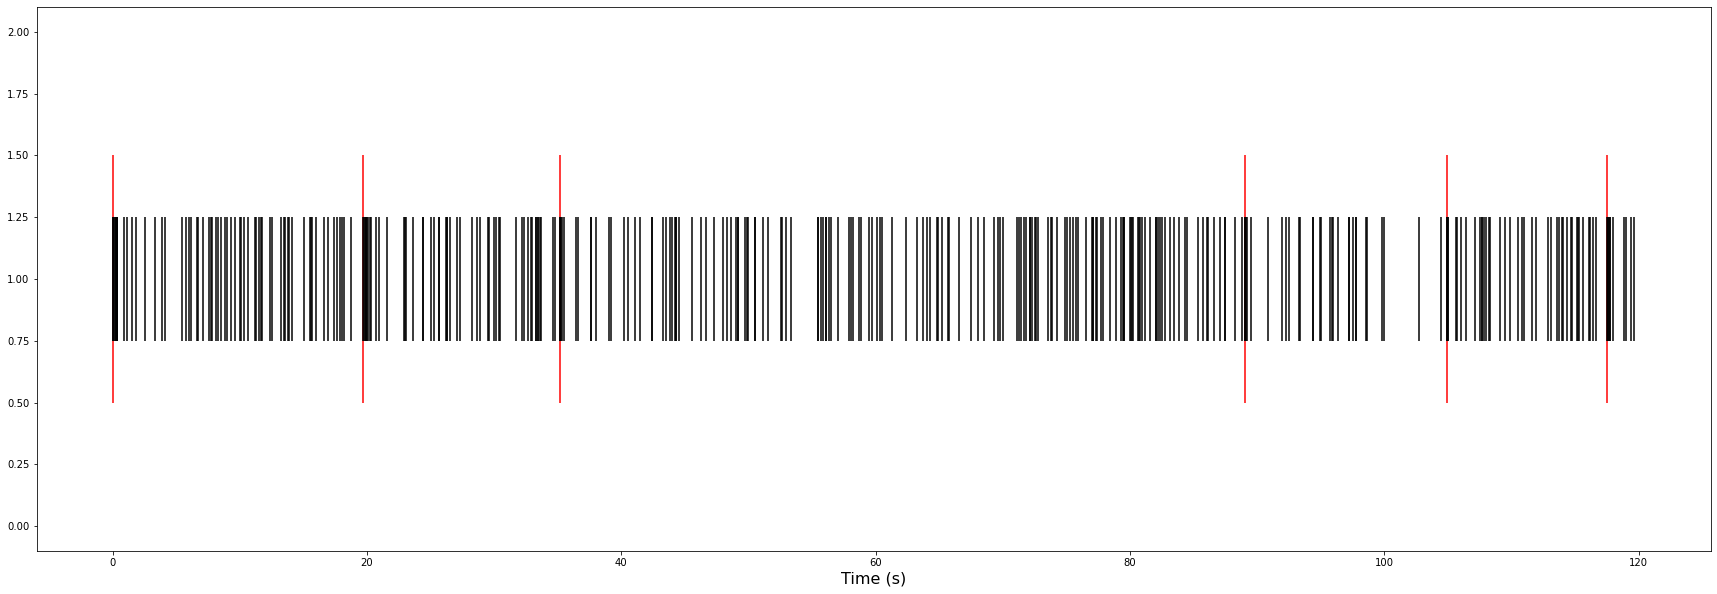

Text(0.5, 0, 'Time (s)')

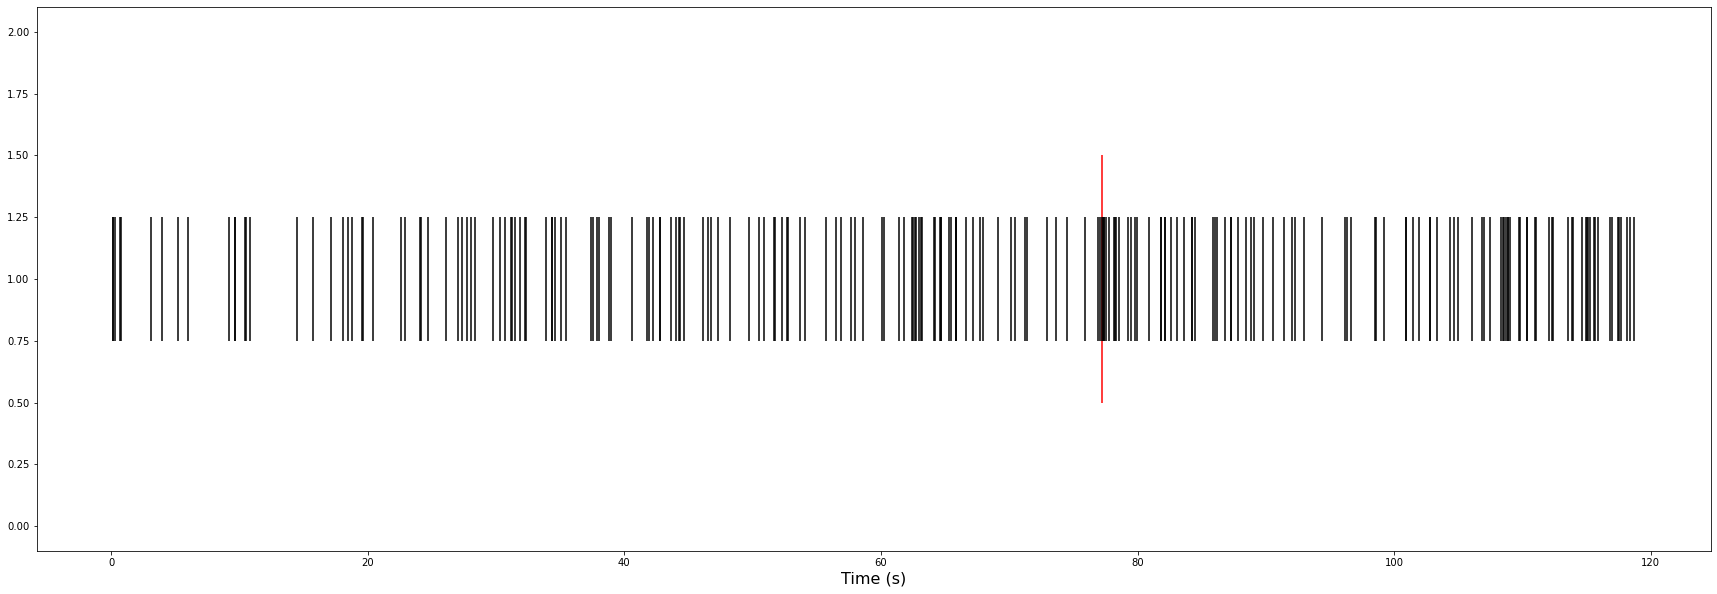

Text(0.5, 0, 'Time (s)')

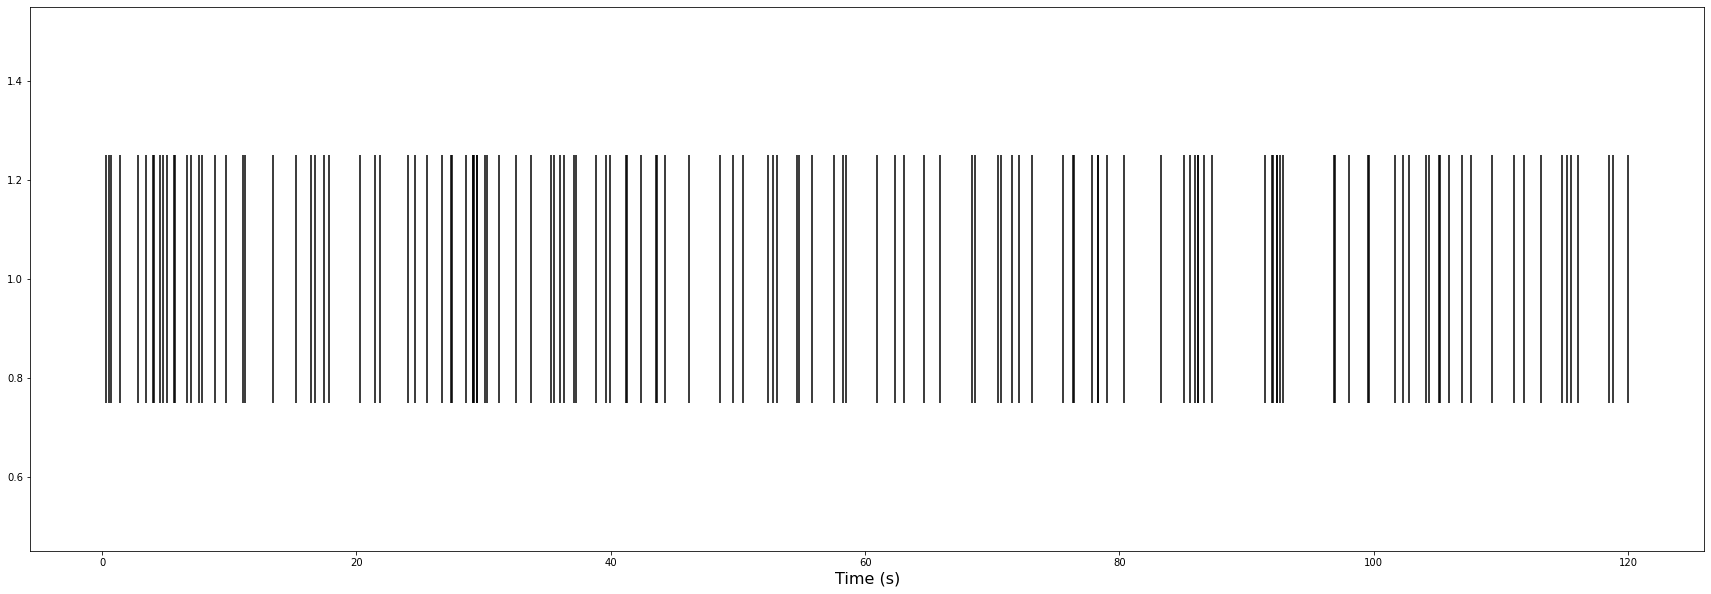

Text(0.5, 0, 'Time (s)')

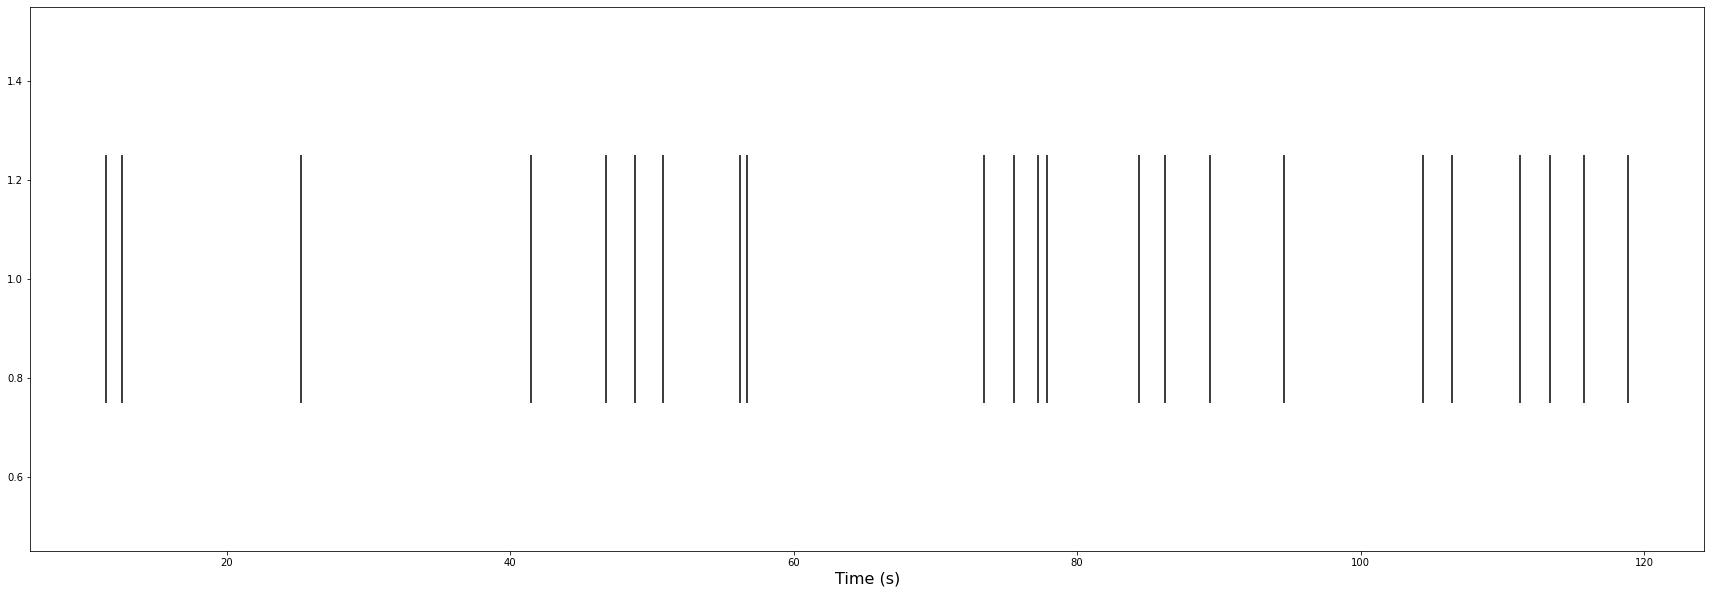

Text(0.5, 0, 'Time (s)')

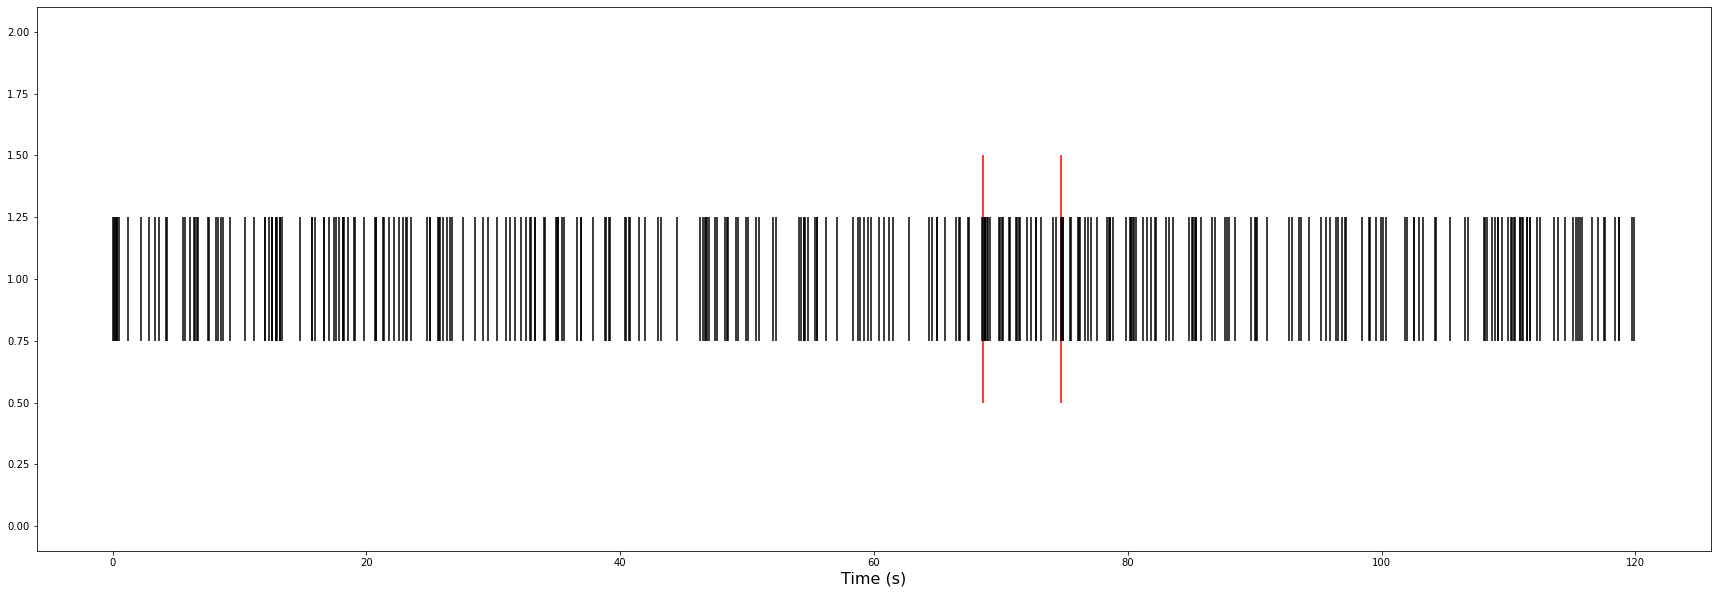

Text(0.5, 0, 'Time (s)')

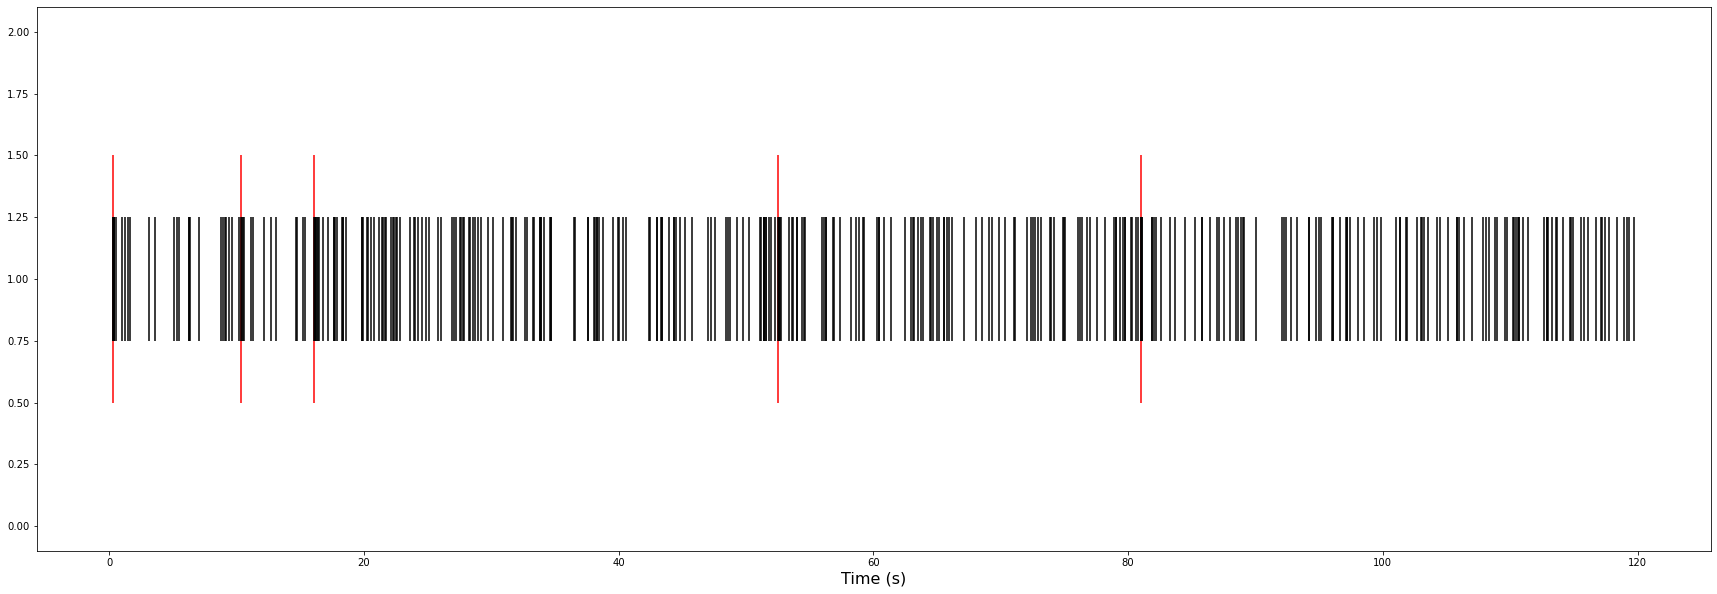

Text(0.5, 0, 'Time (s)')

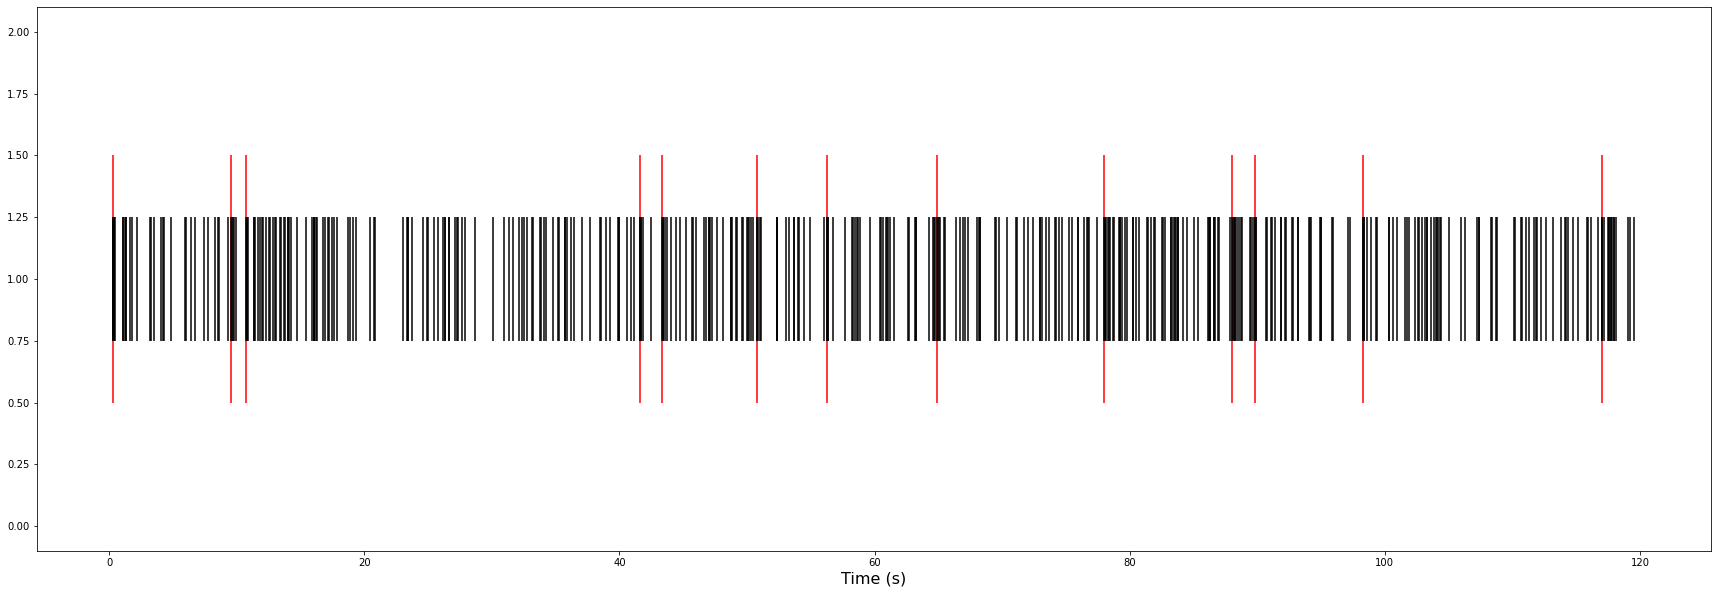

Text(0.5, 0, 'Time (s)')

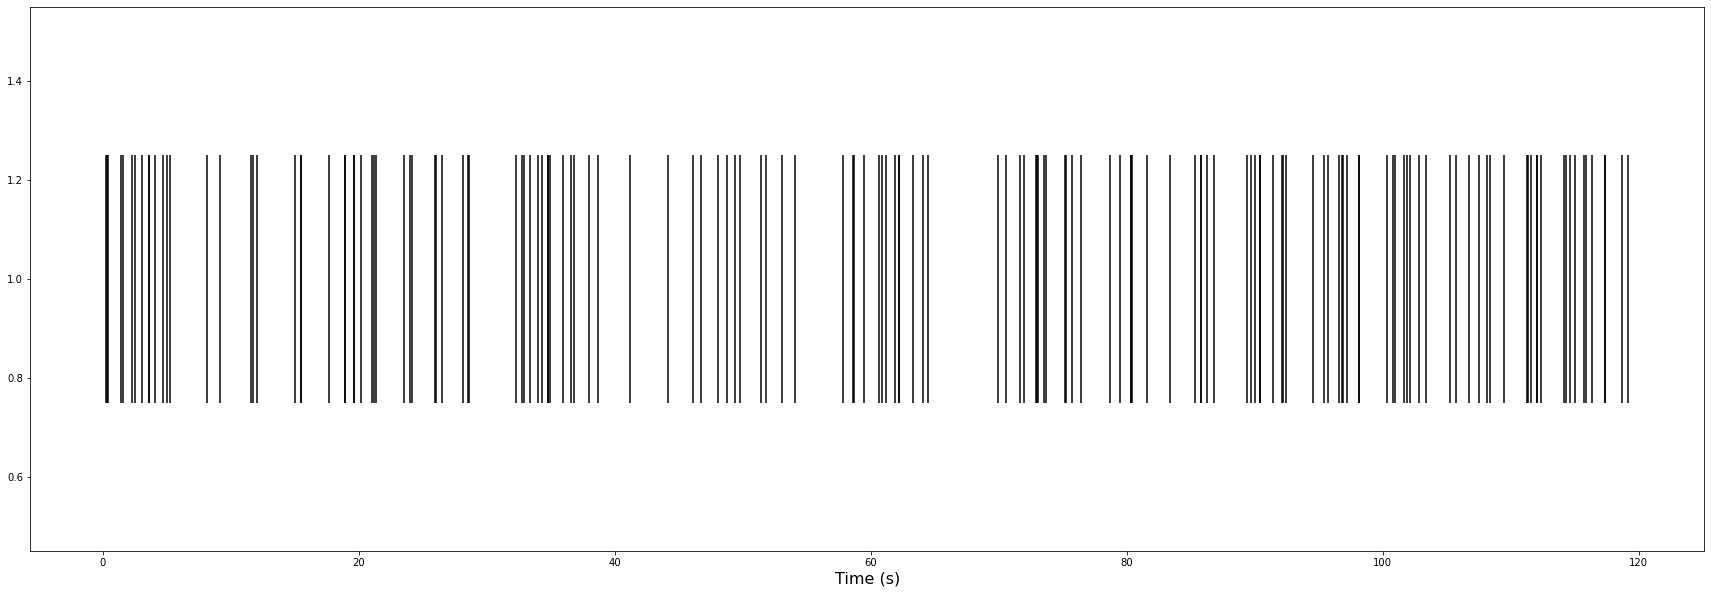

Text(0.5, 0, 'Time (s)')

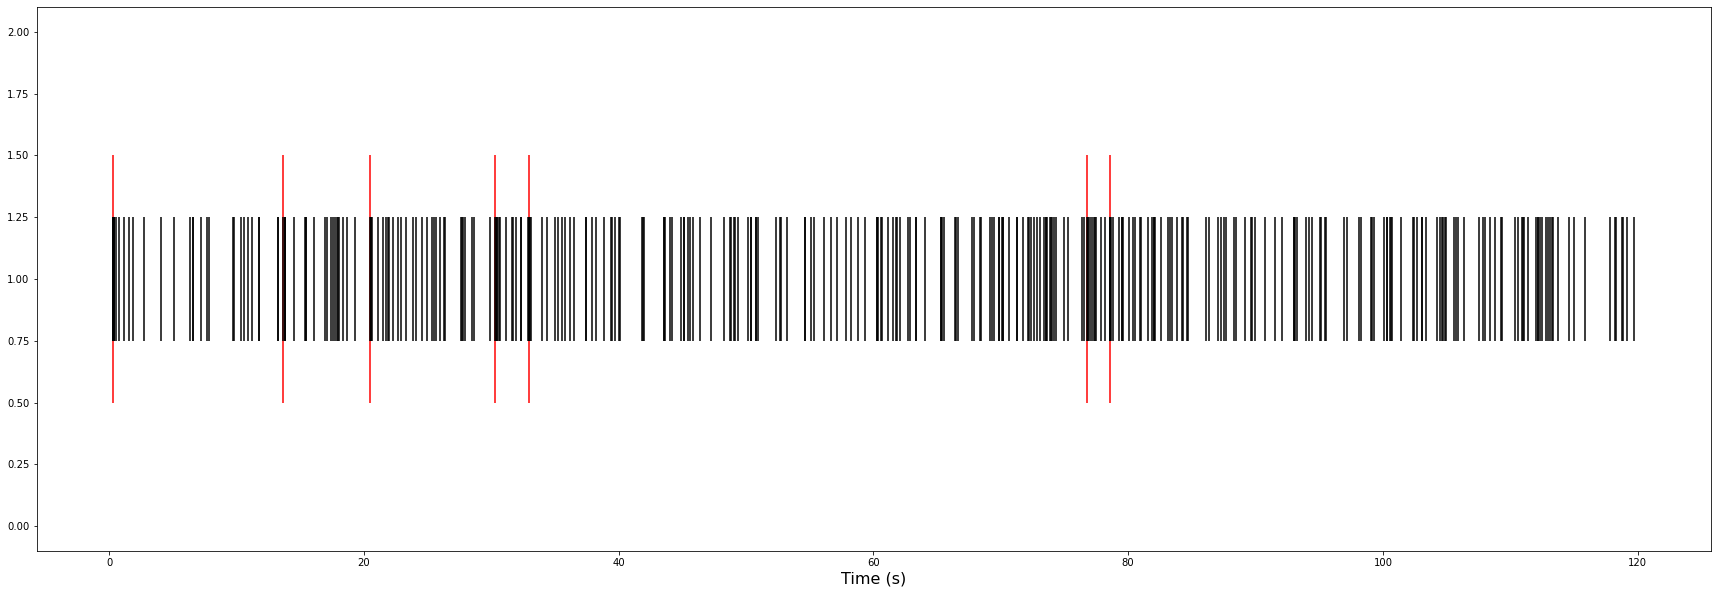

Text(0.5, 0, 'Time (s)')

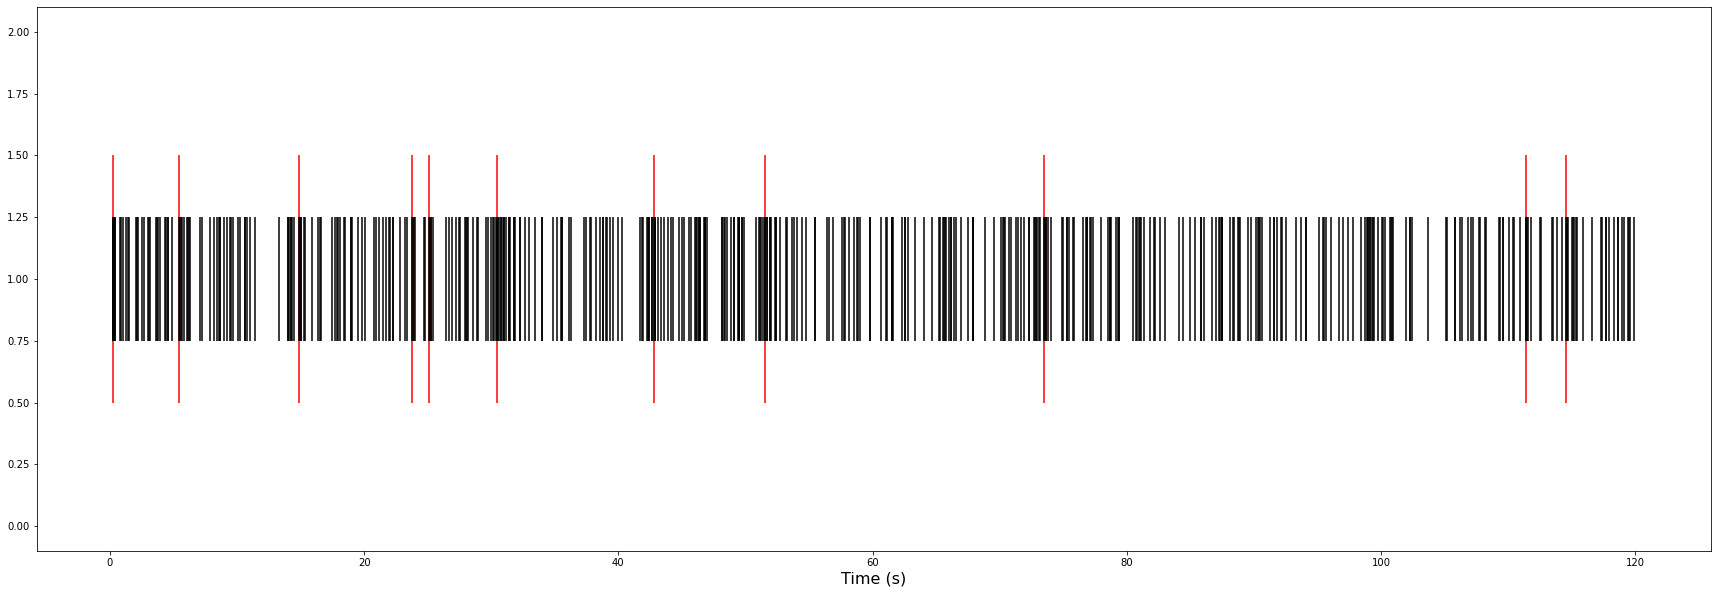

Text(0.5, 0, 'Time (s)')

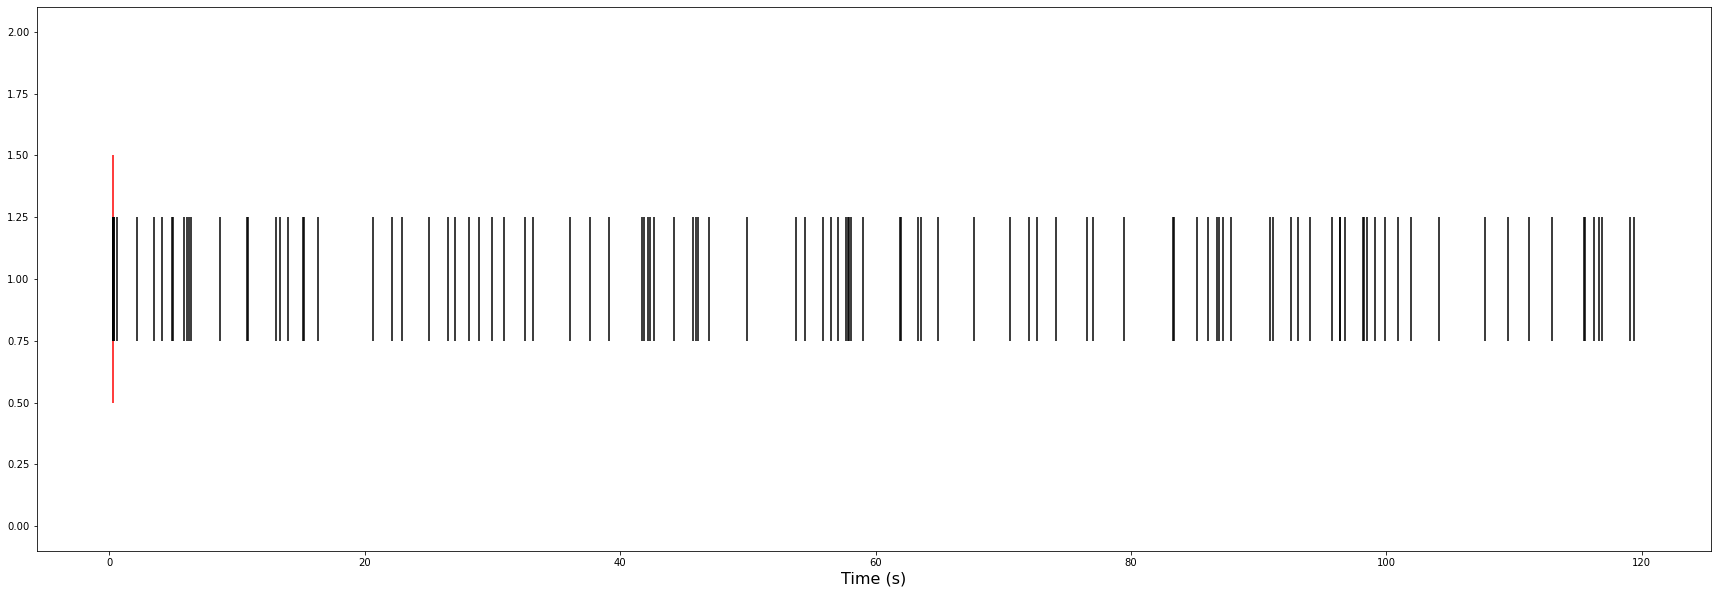

Text(0.5, 0, 'Time (s)')

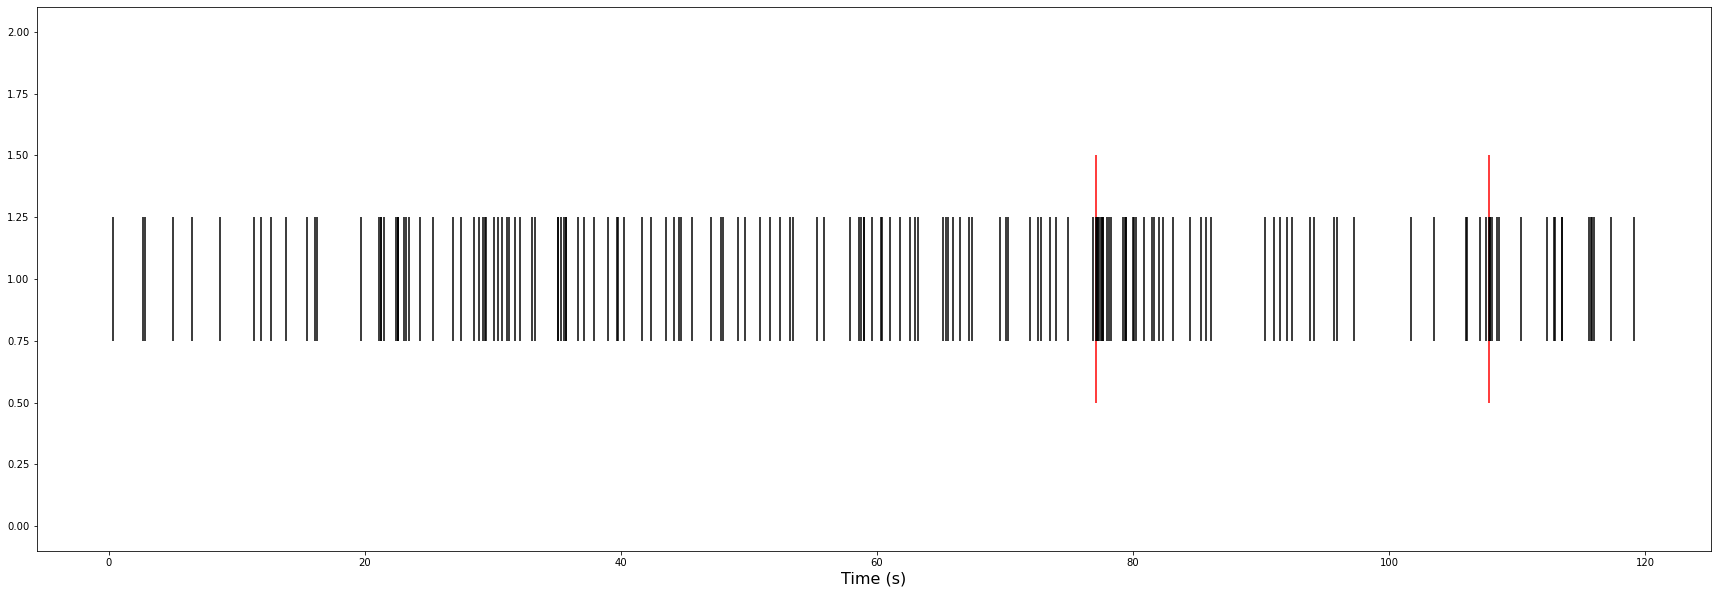

Text(0.5, 0, 'Time (s)')

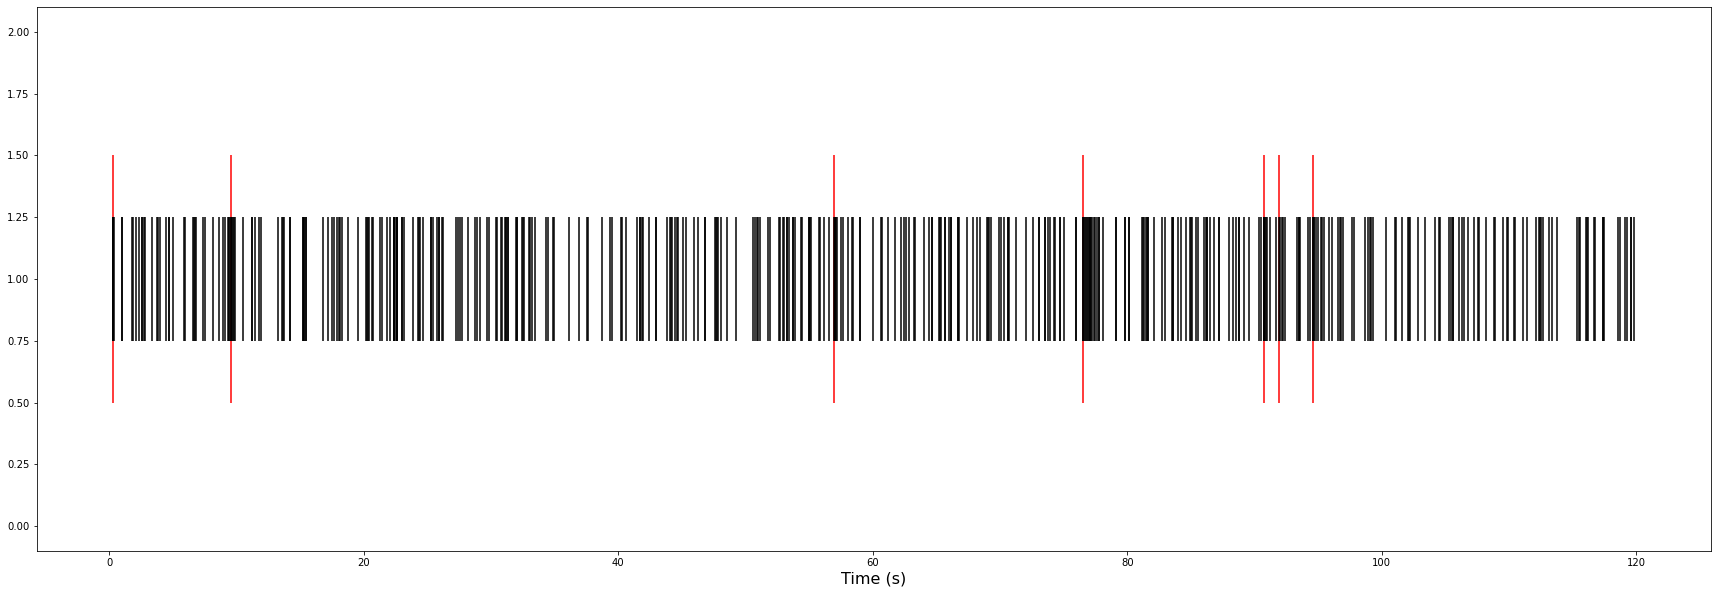

Text(0.5, 0, 'Time (s)')

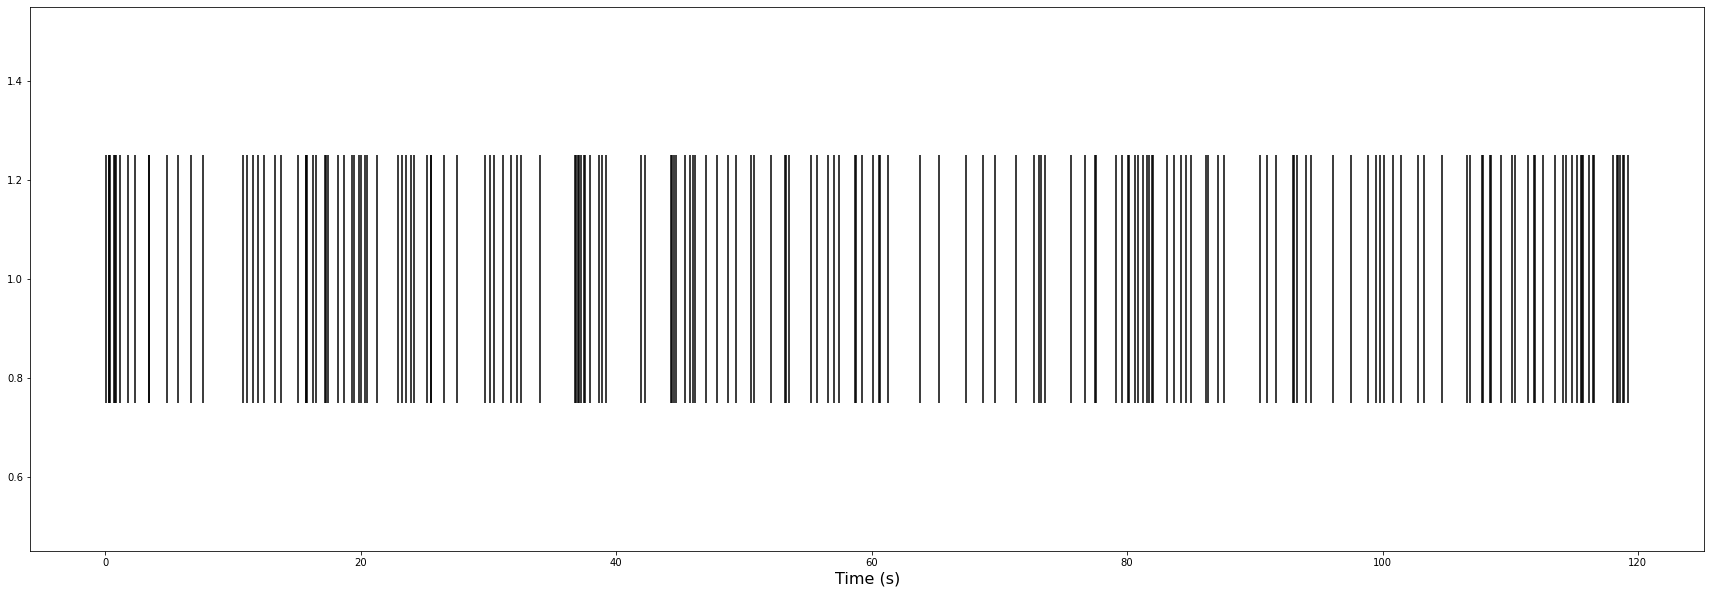

Text(0.5, 0, 'Time (s)')

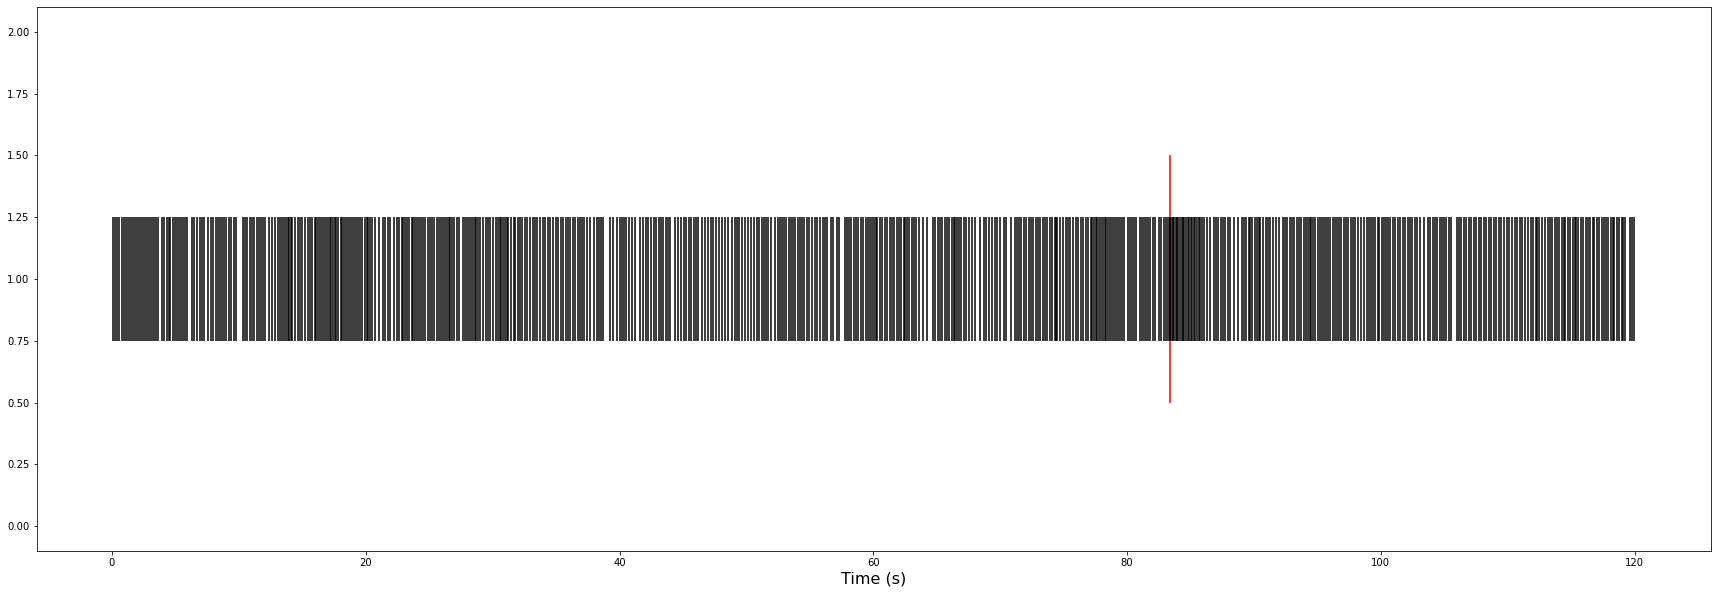

Text(0.5, 0, 'Time (s)')

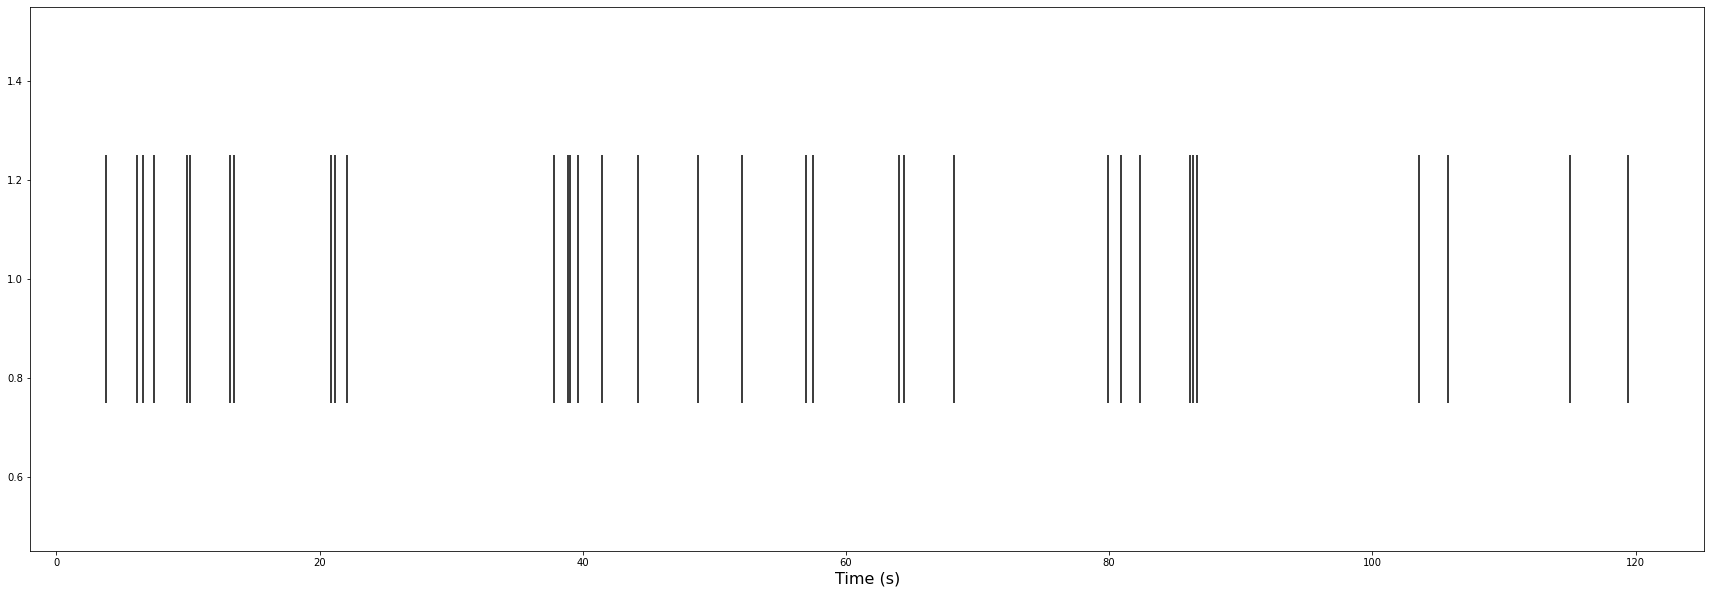

Text(0.5, 0, 'Time (s)')

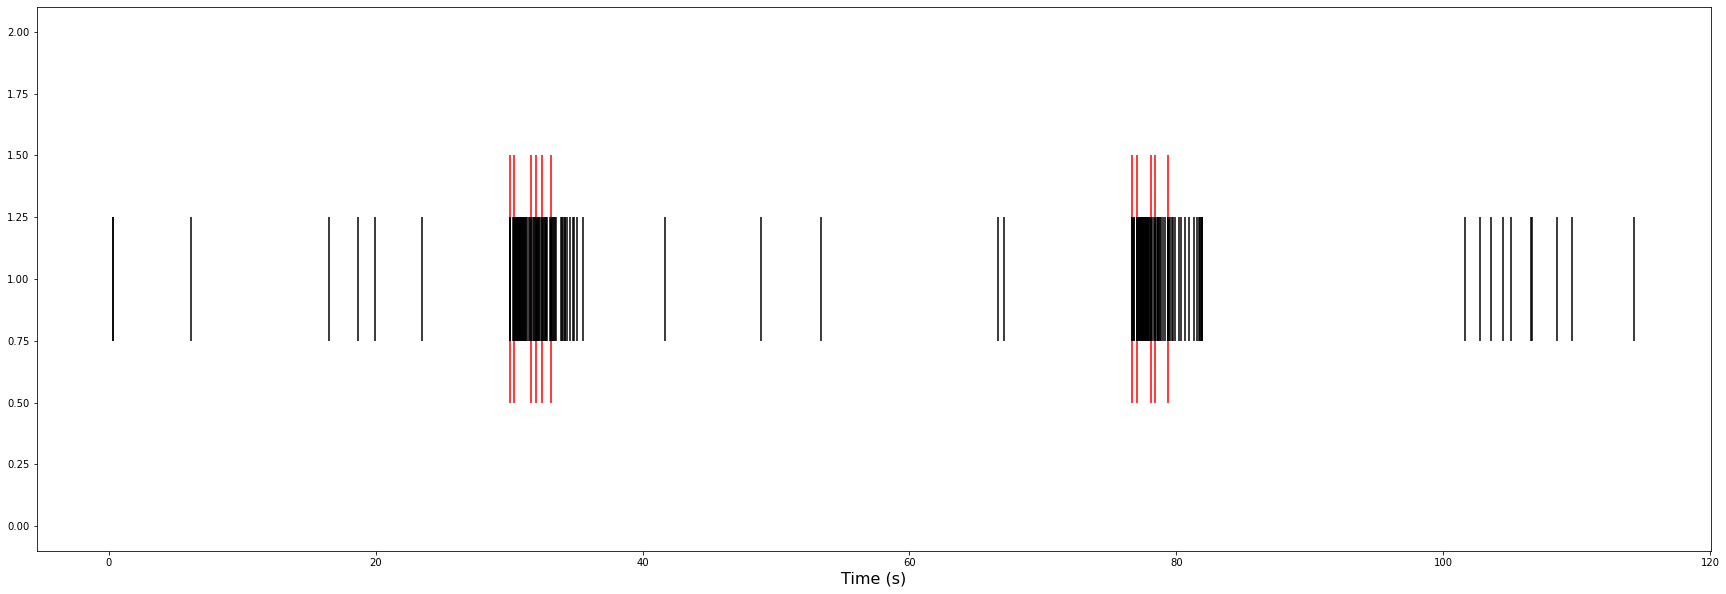

Text(0.5, 0, 'Time (s)')

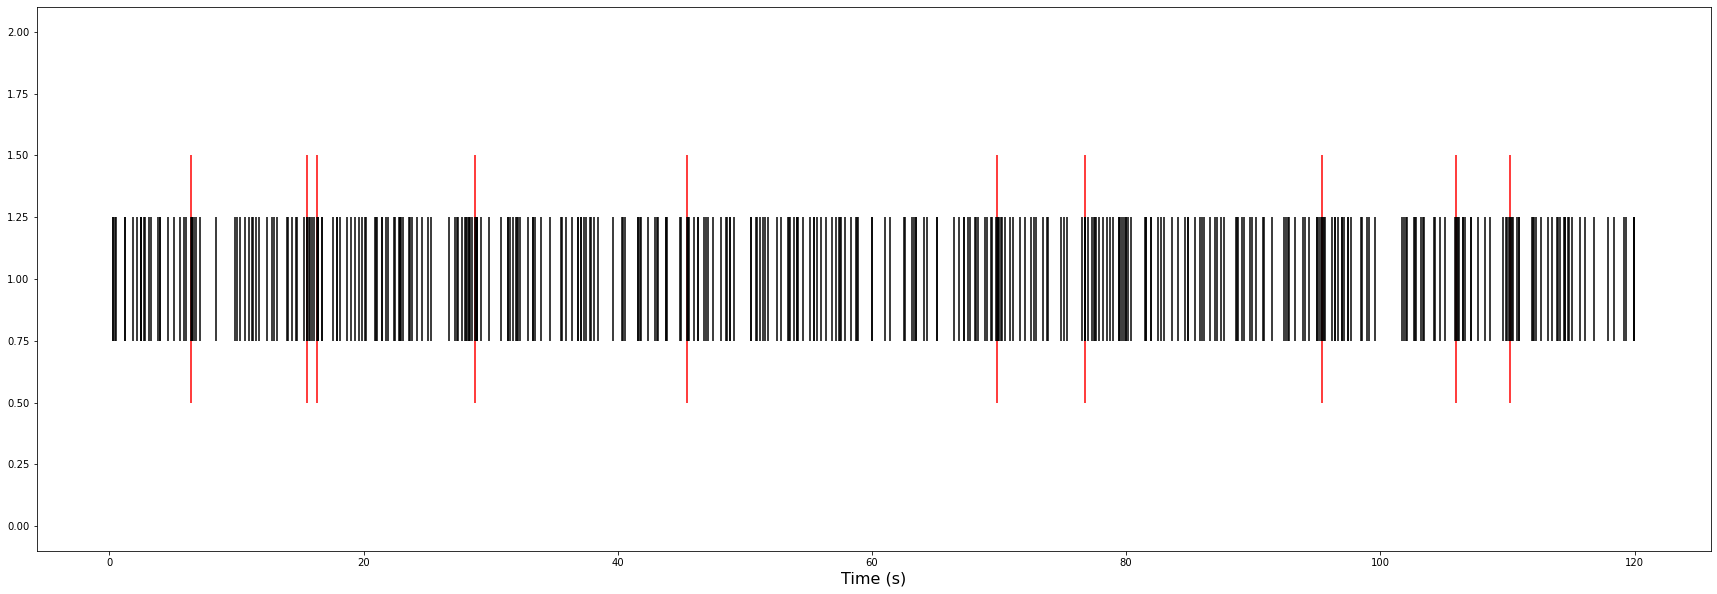

Text(0.5, 0, 'Time (s)')

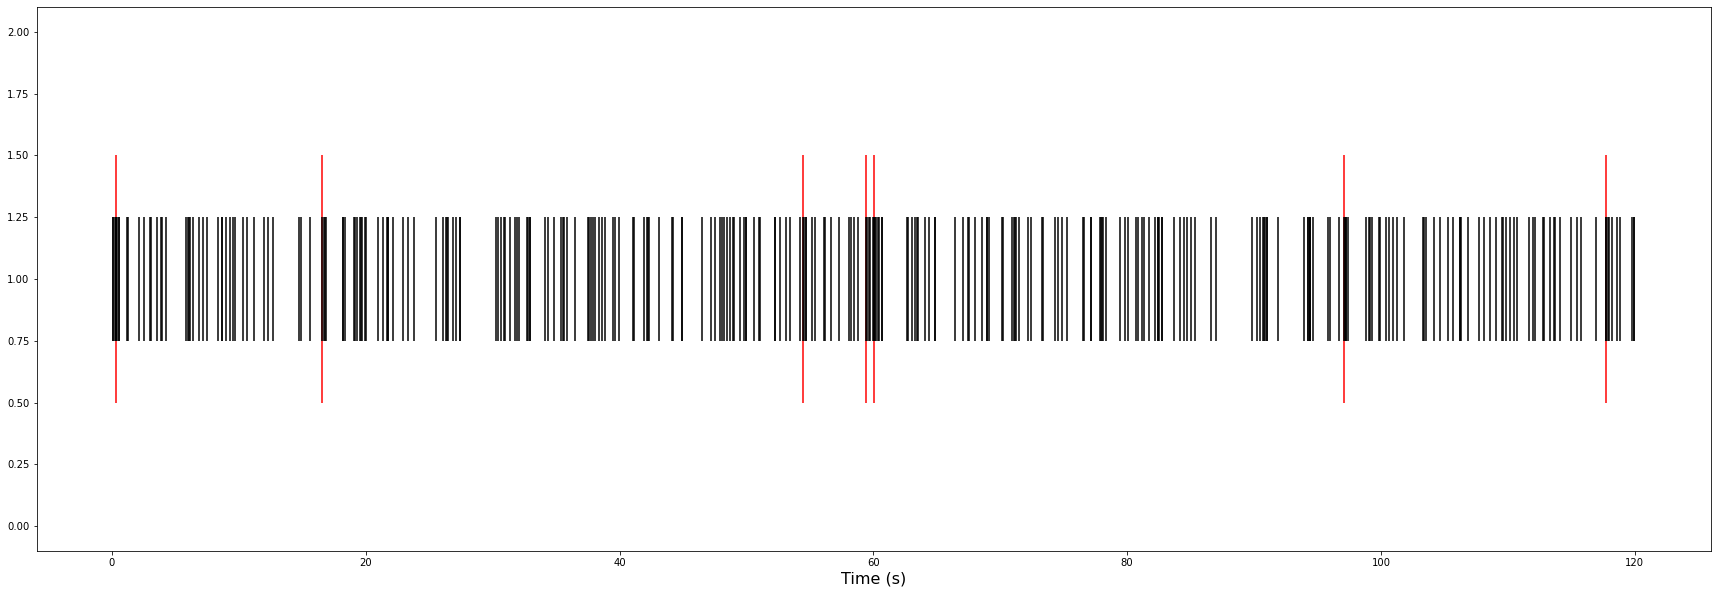

Text(0.5, 0, 'Time (s)')

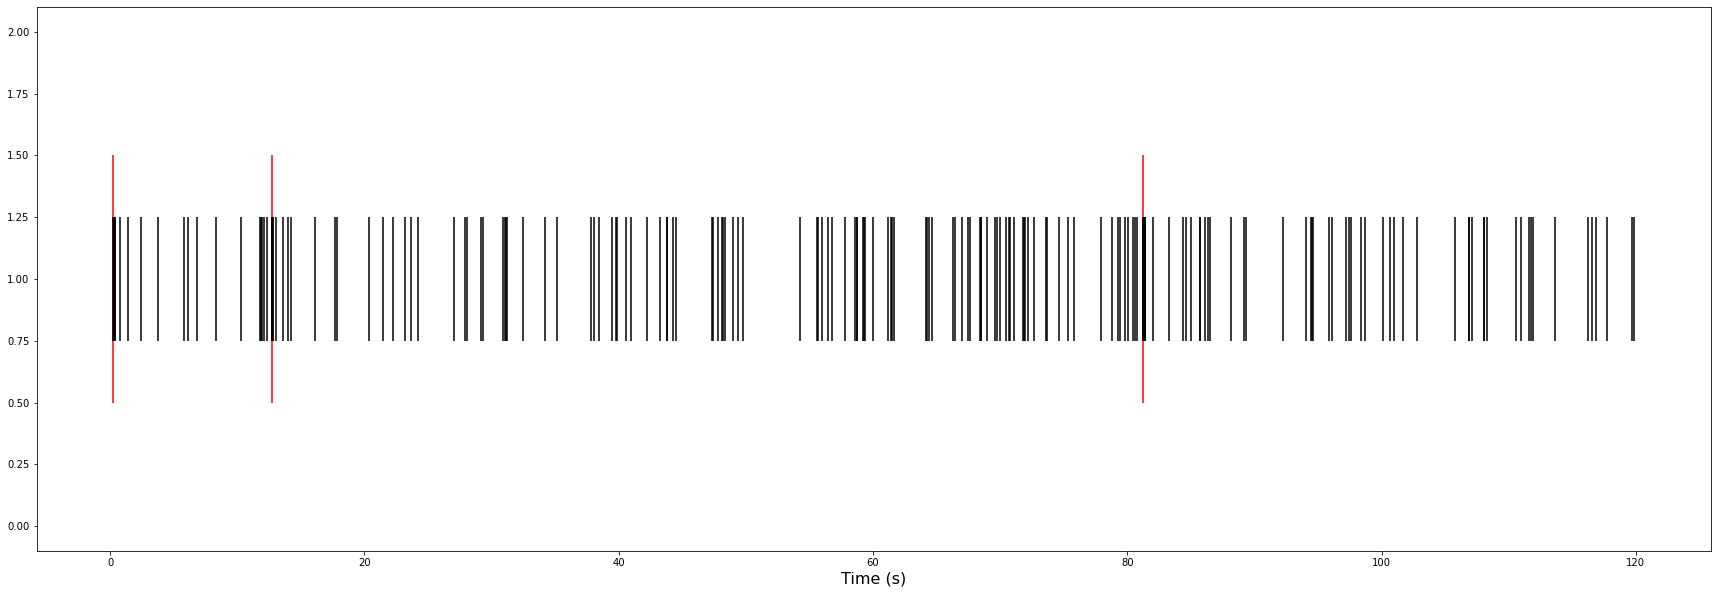

Text(0.5, 0, 'Time (s)')

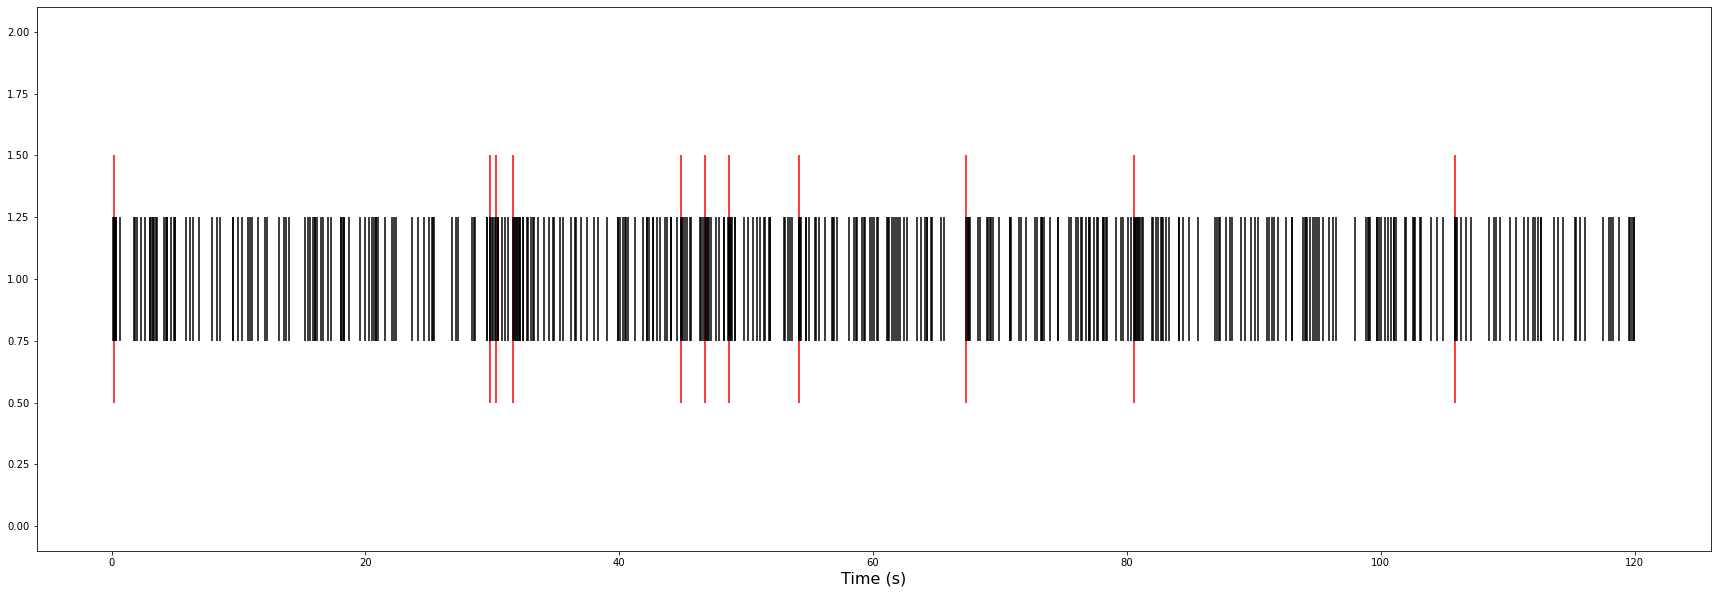

Text(0.5, 0, 'Time (s)')

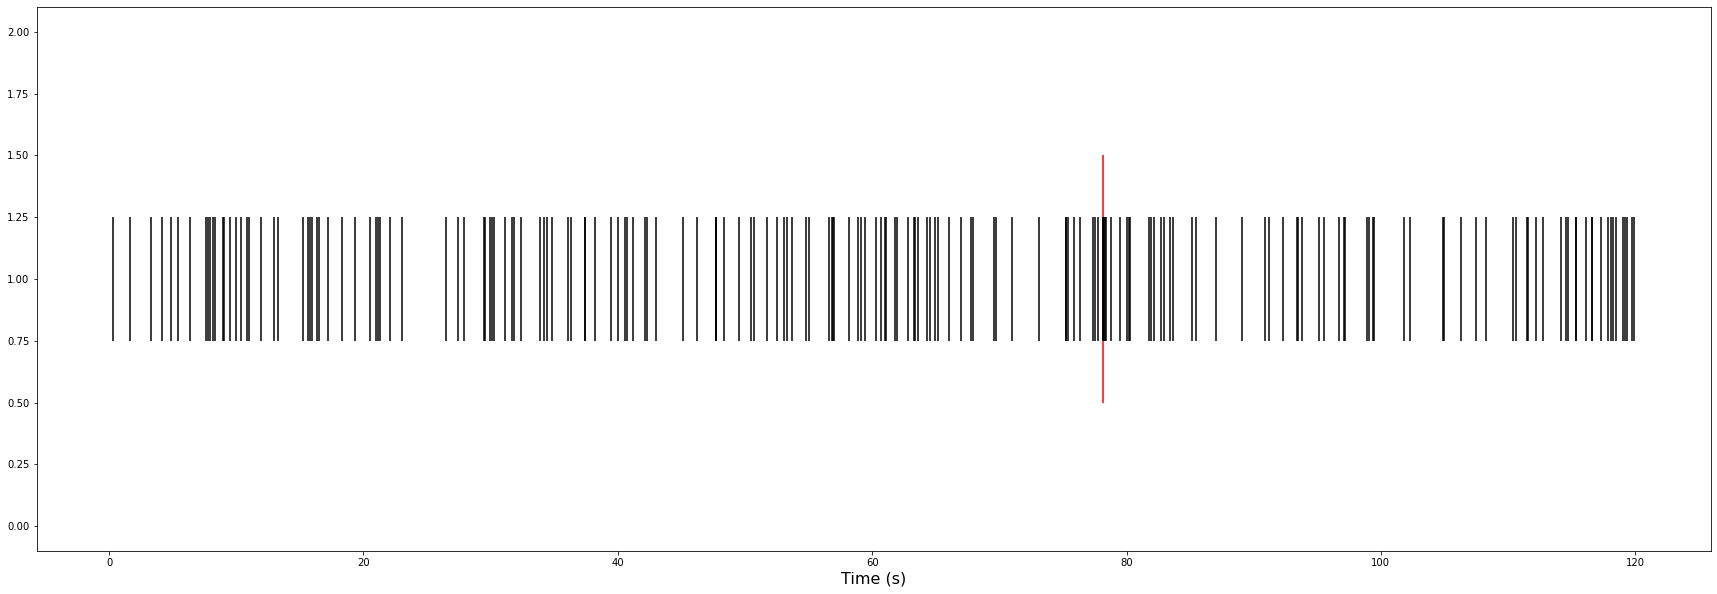

Text(0.5, 0, 'Time (s)')

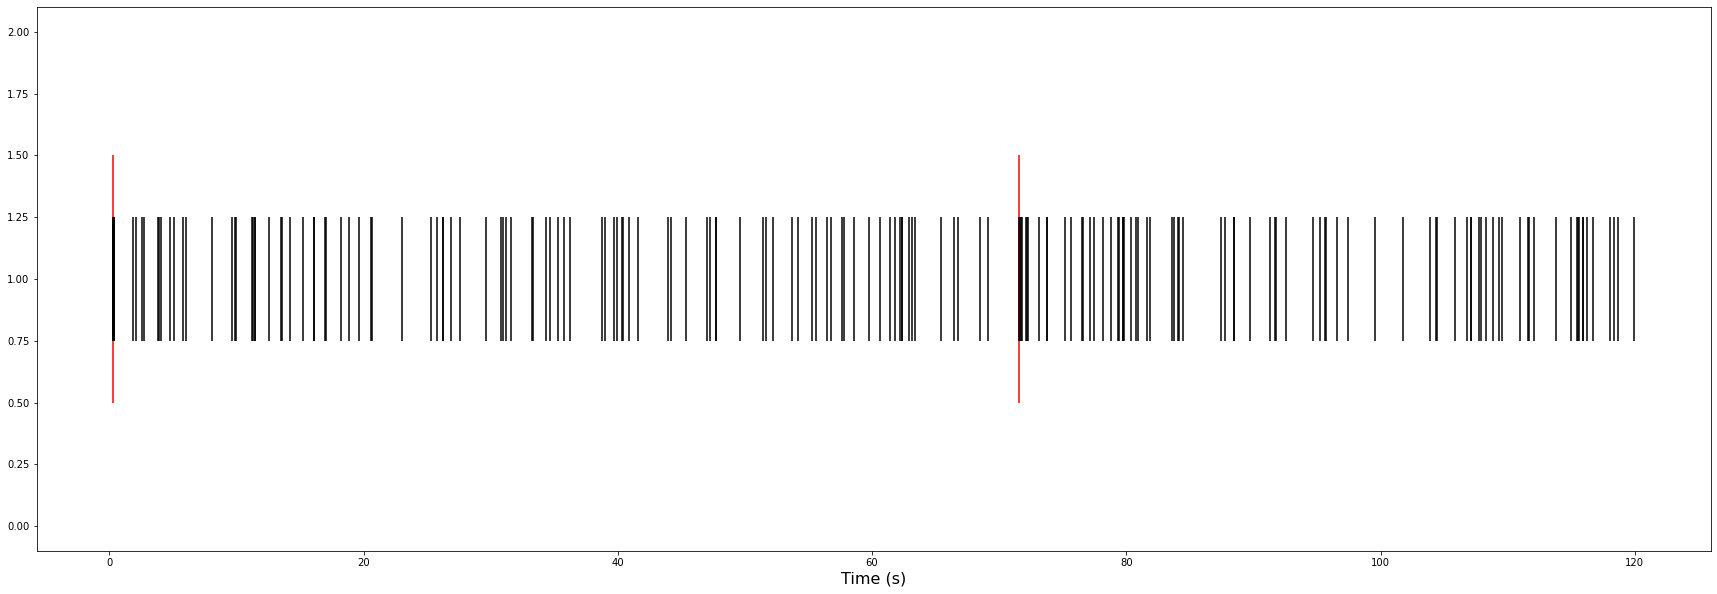

Text(0.5, 0, 'Time (s)')

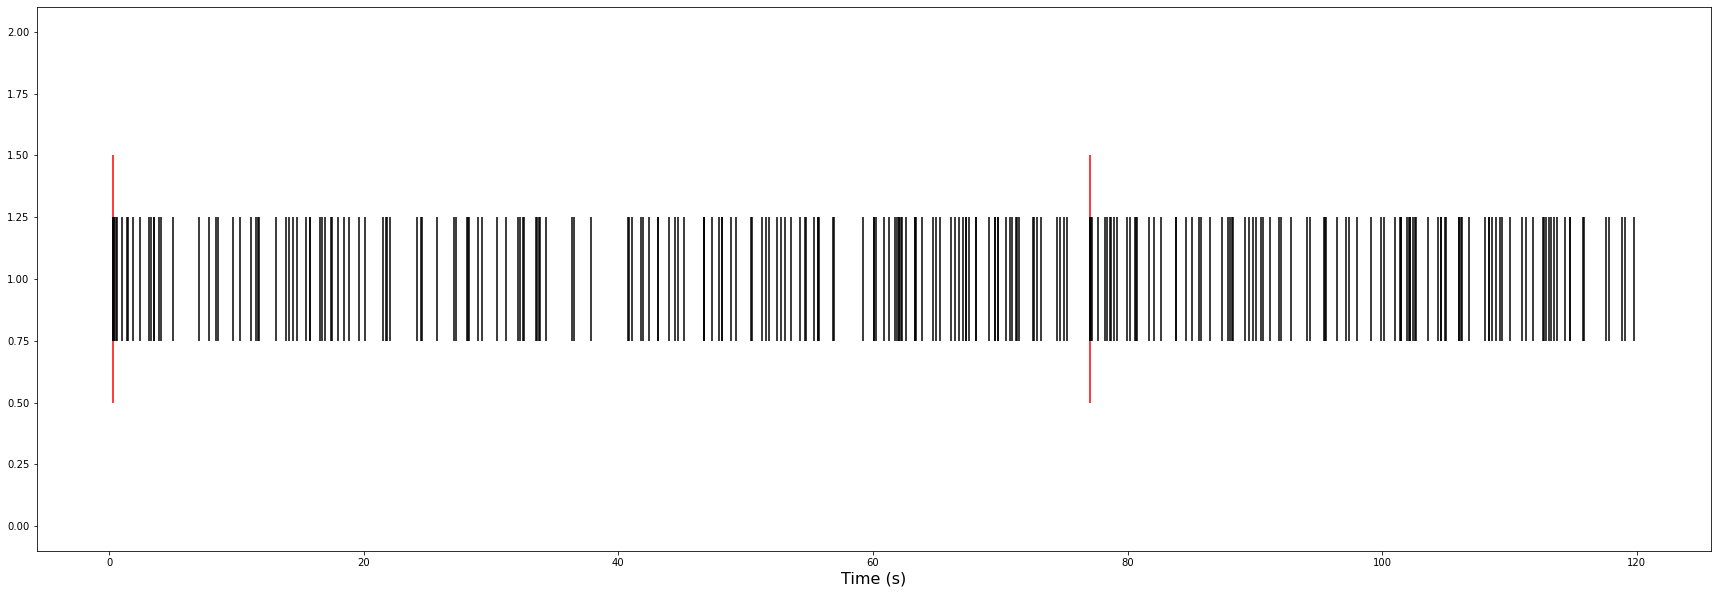

Text(0.5, 0, 'Time (s)')

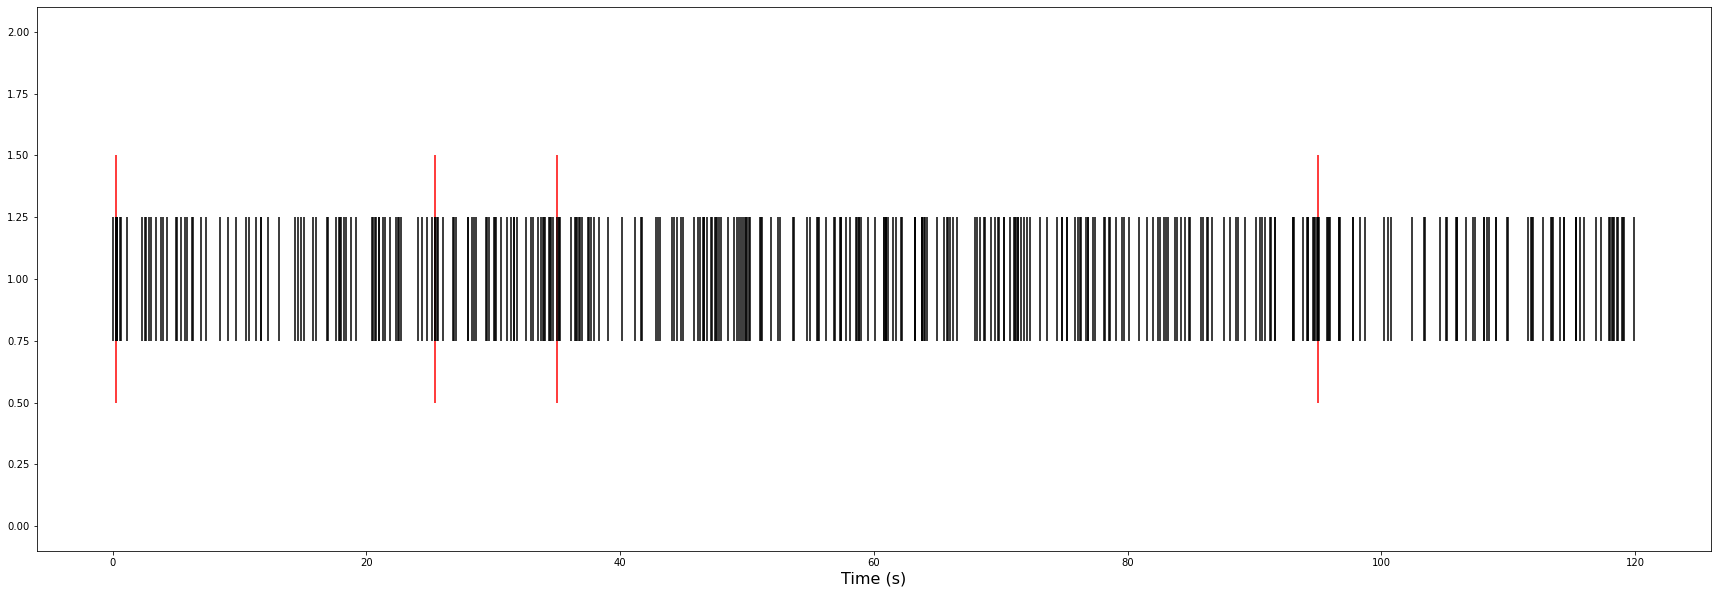

Text(0.5, 0, 'Time (s)')

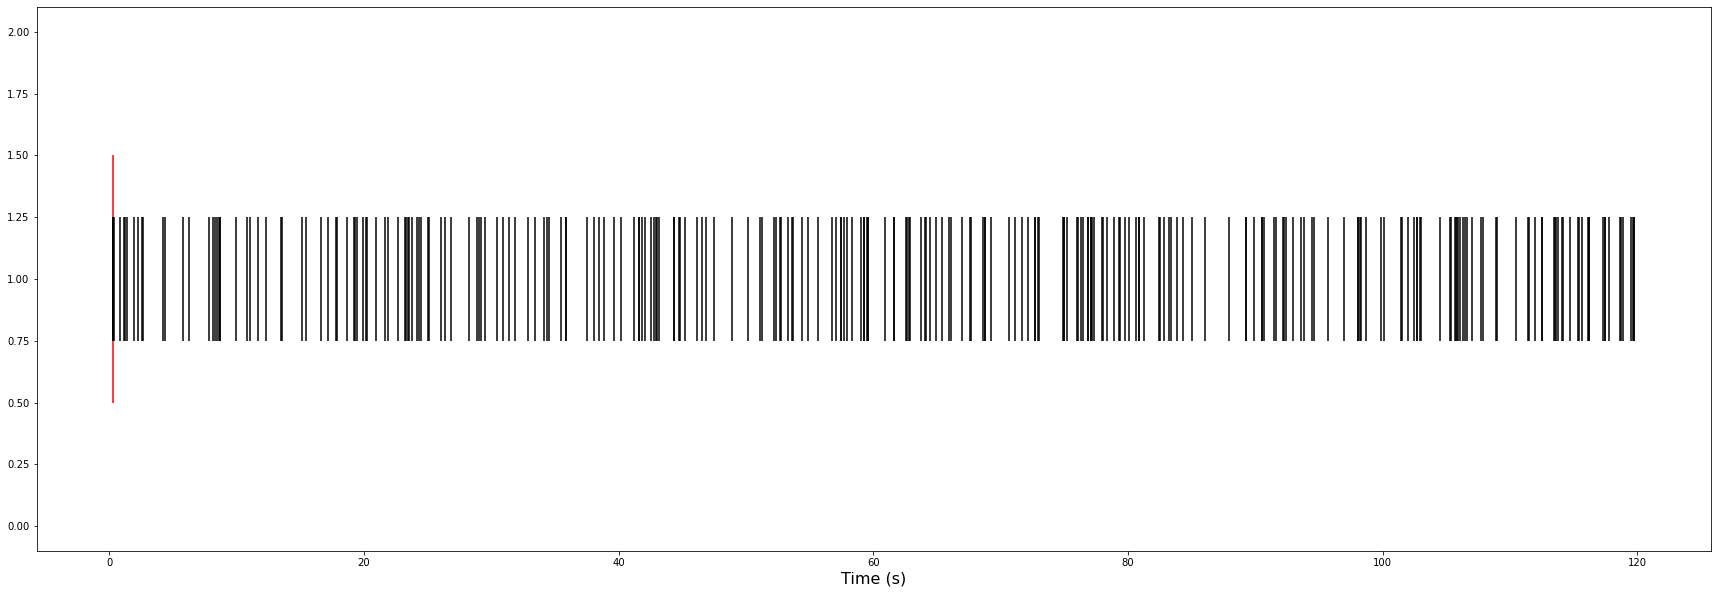

Text(0.5, 0, 'Time (s)')

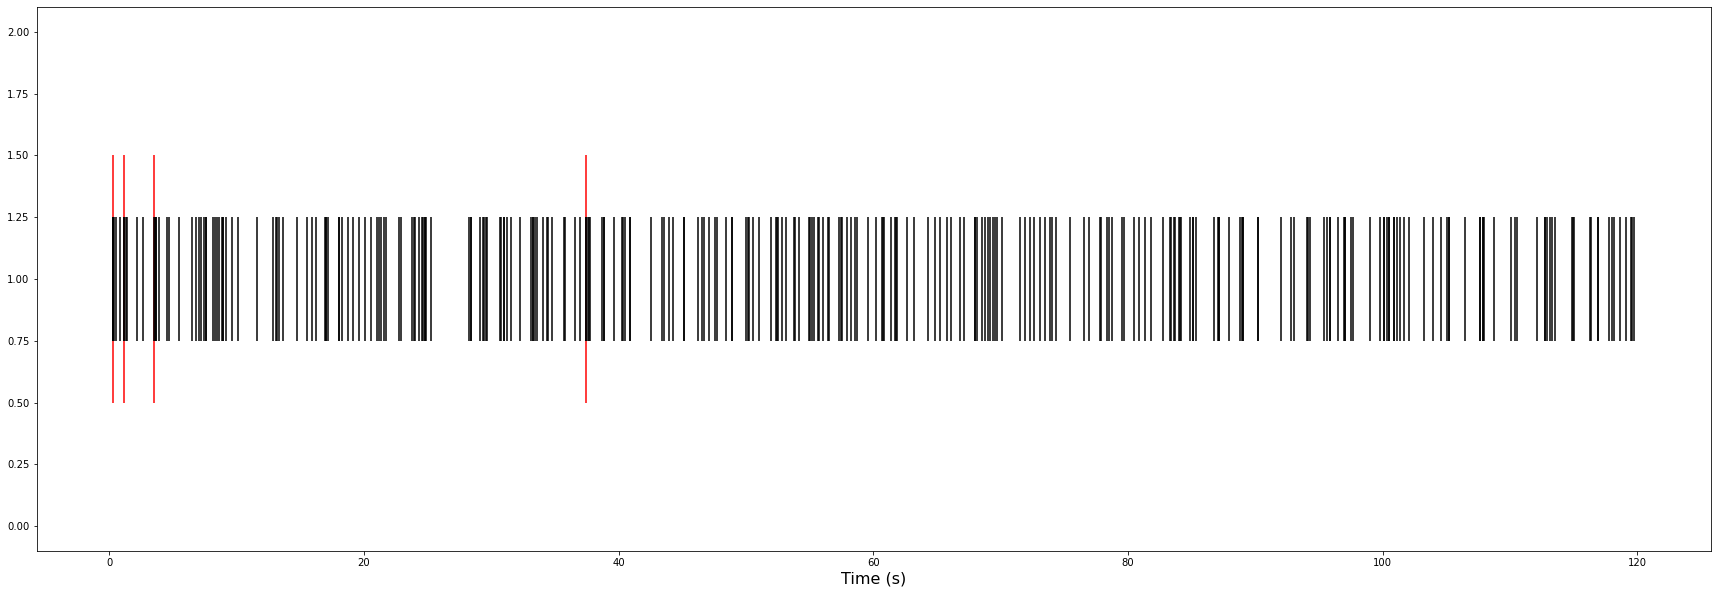

Text(0.5, 0, 'Time (s)')

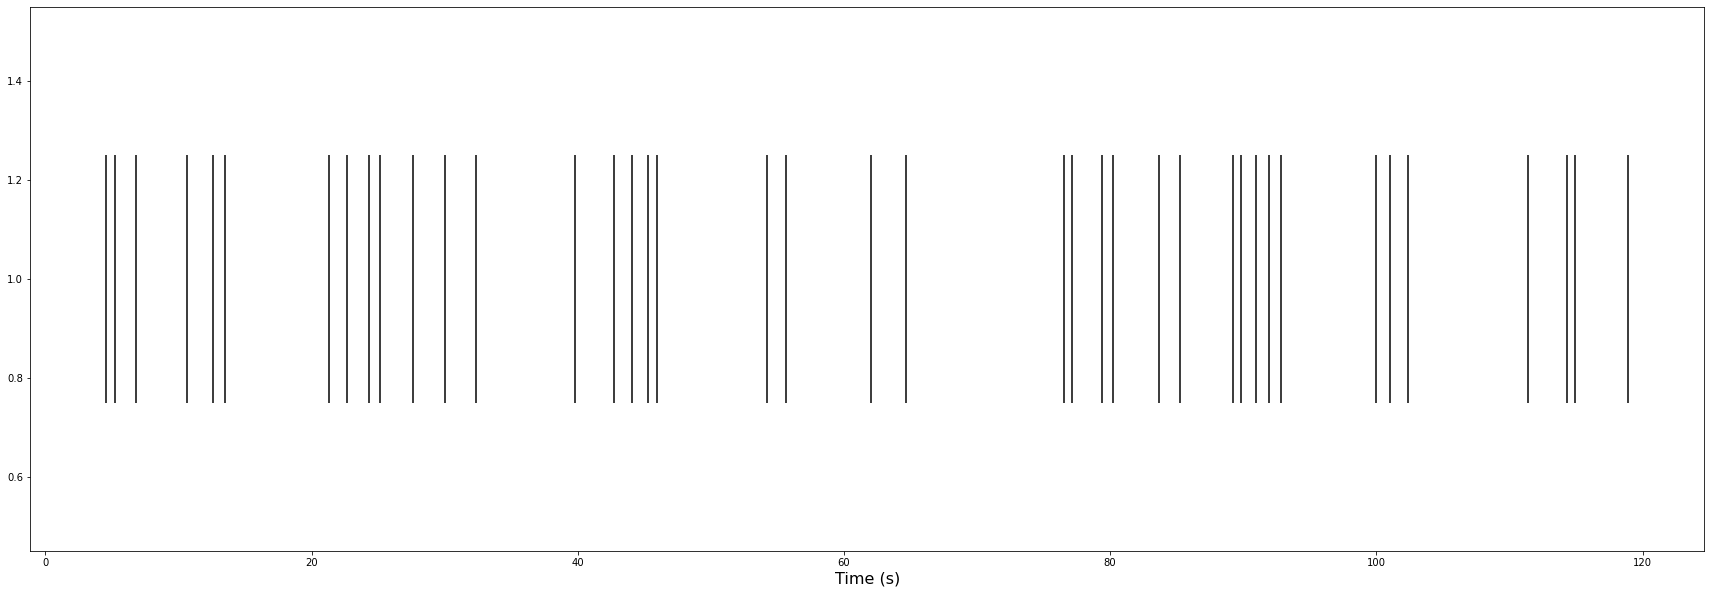

Text(0.5, 0, 'Time (s)')

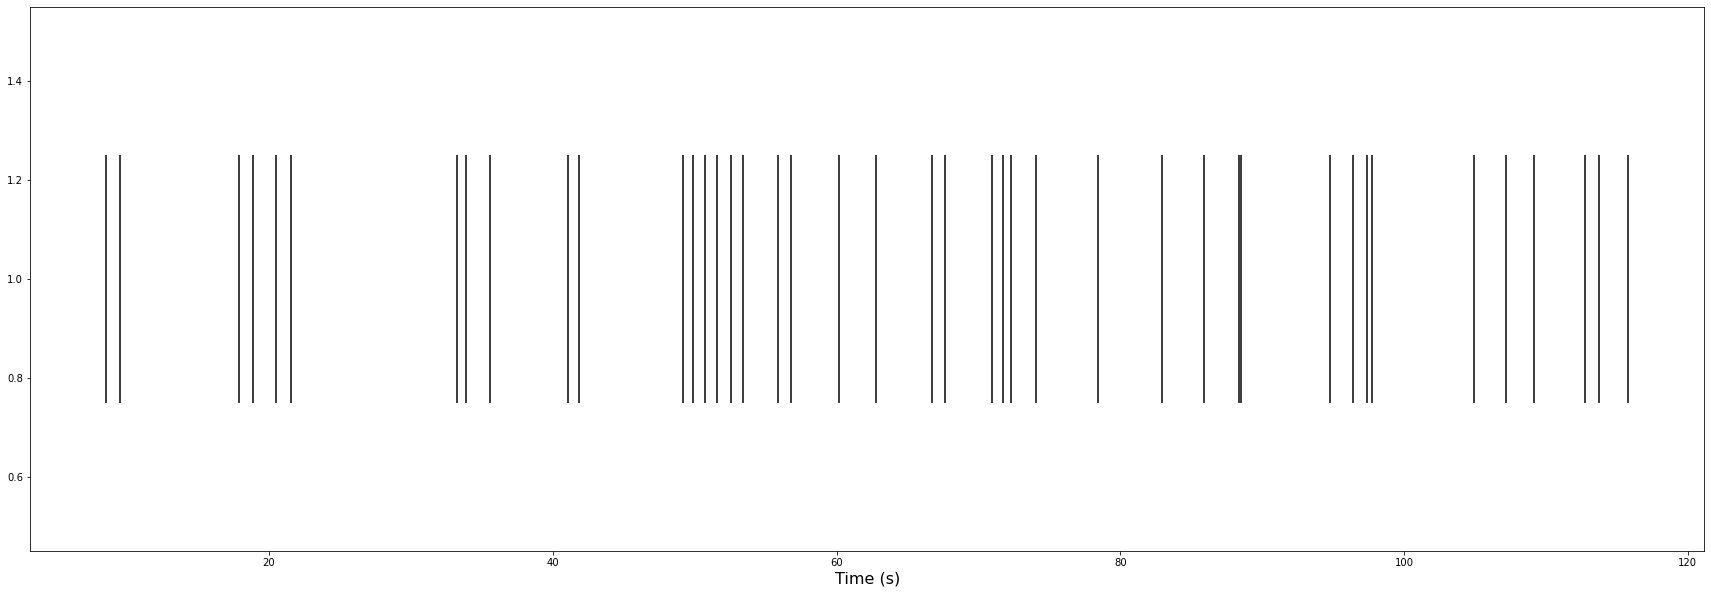

Text(0.5, 0, 'Time (s)')

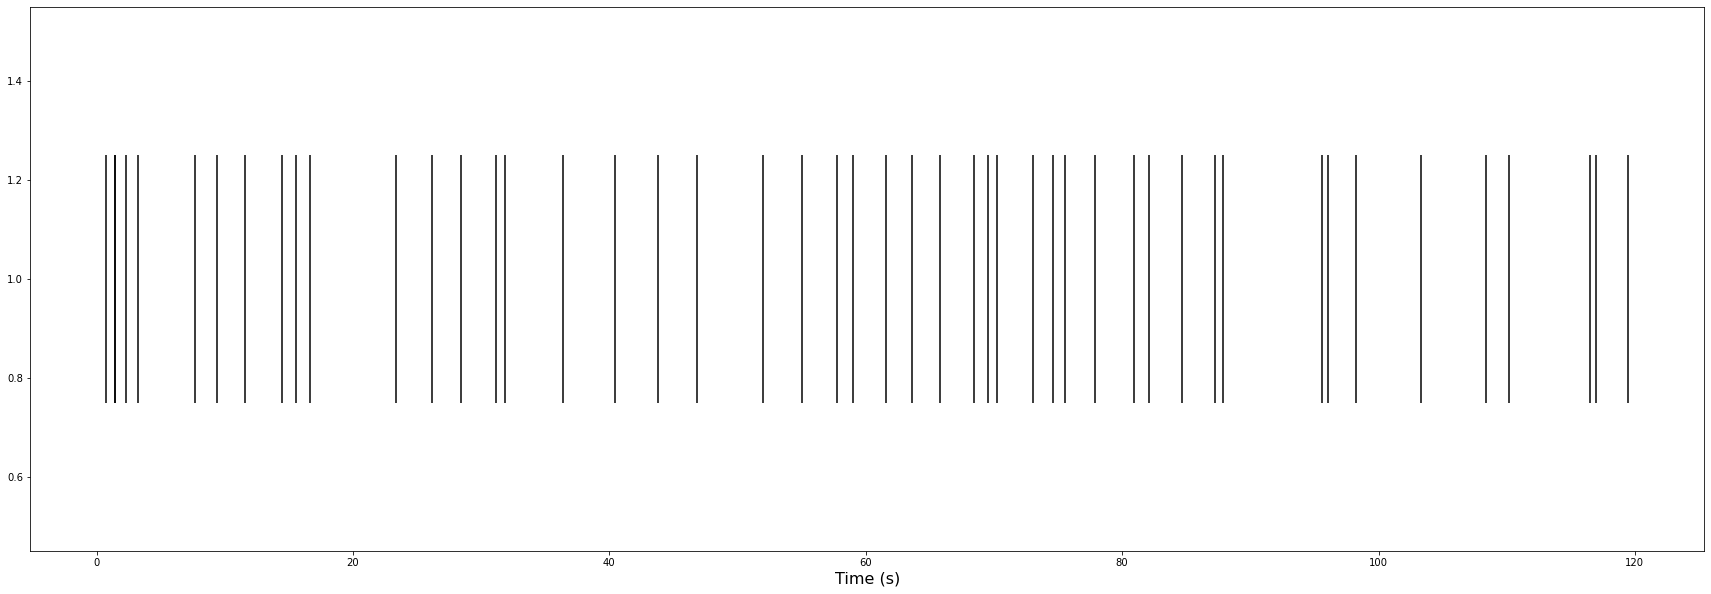

Text(0.5, 0, 'Time (s)')

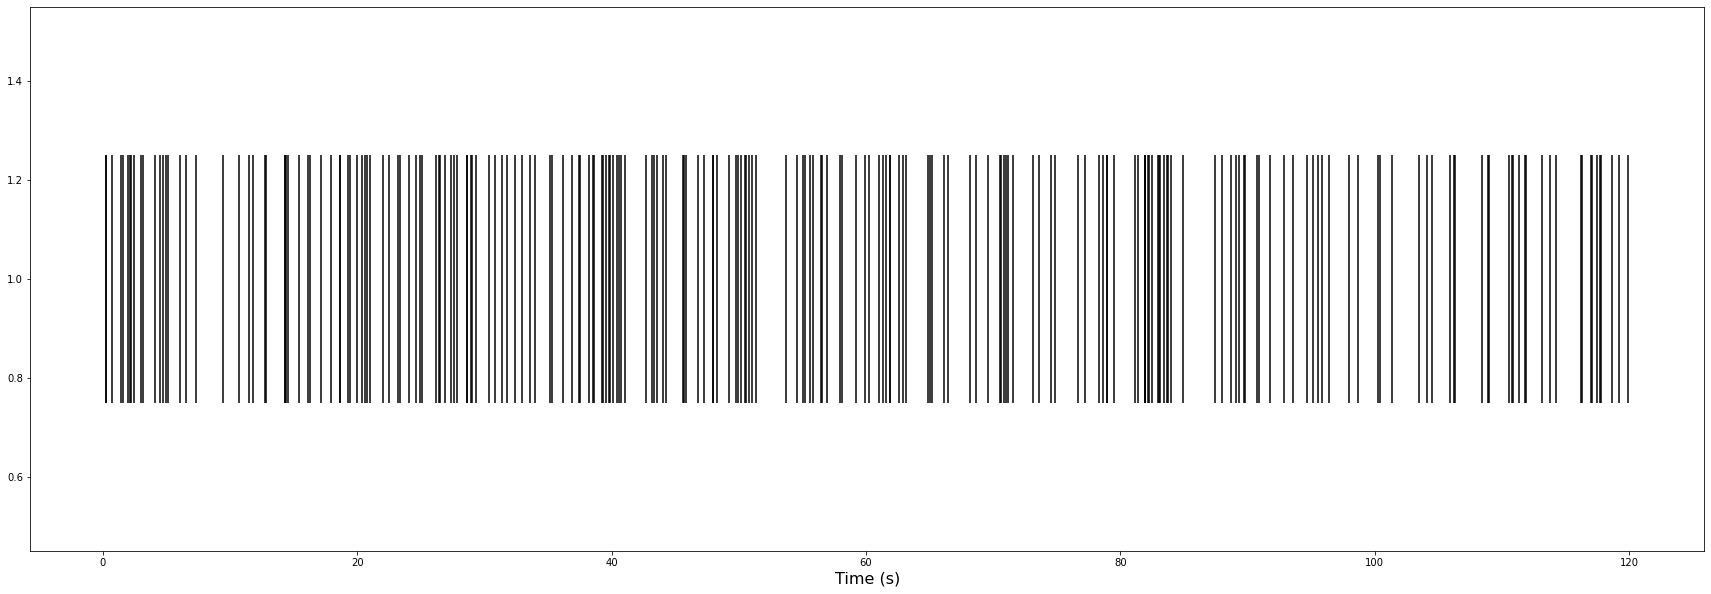

Text(0.5, 0, 'Time (s)')

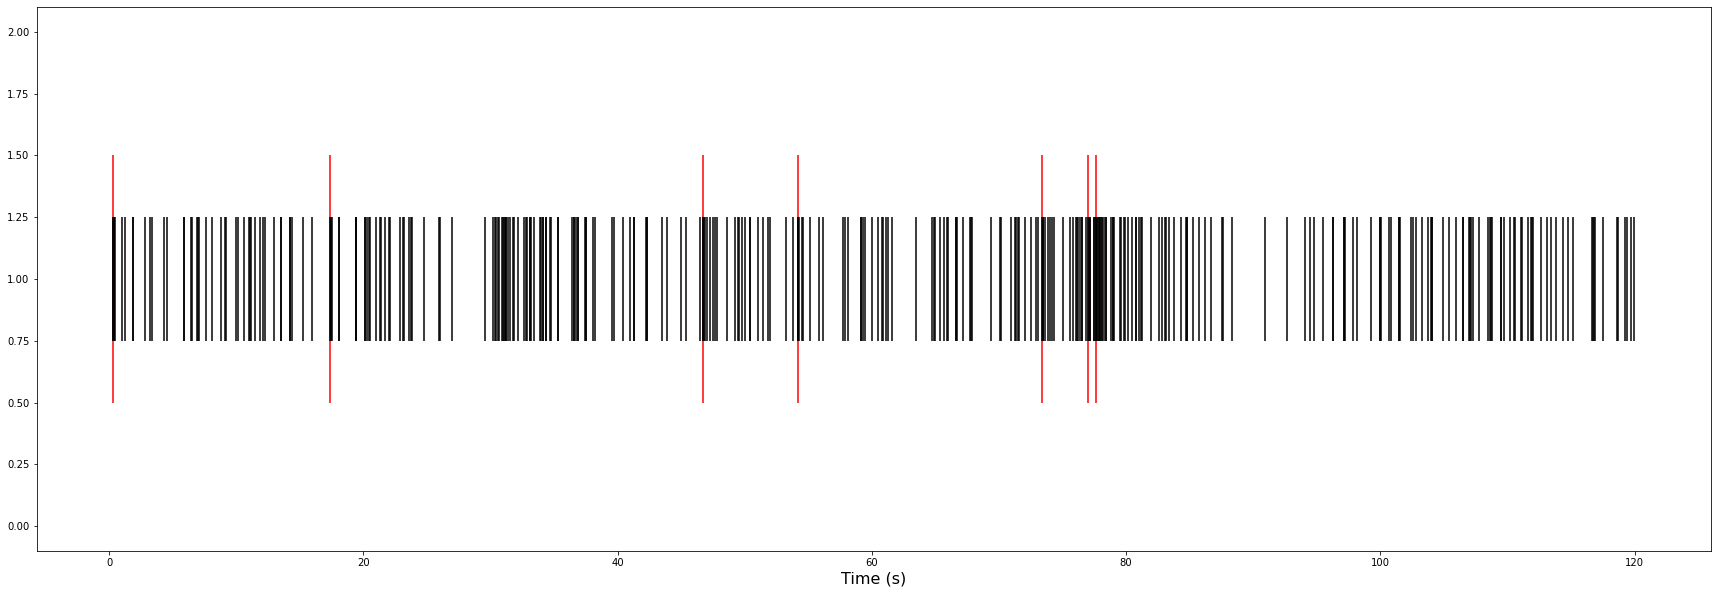

Text(0.5, 0, 'Time (s)')

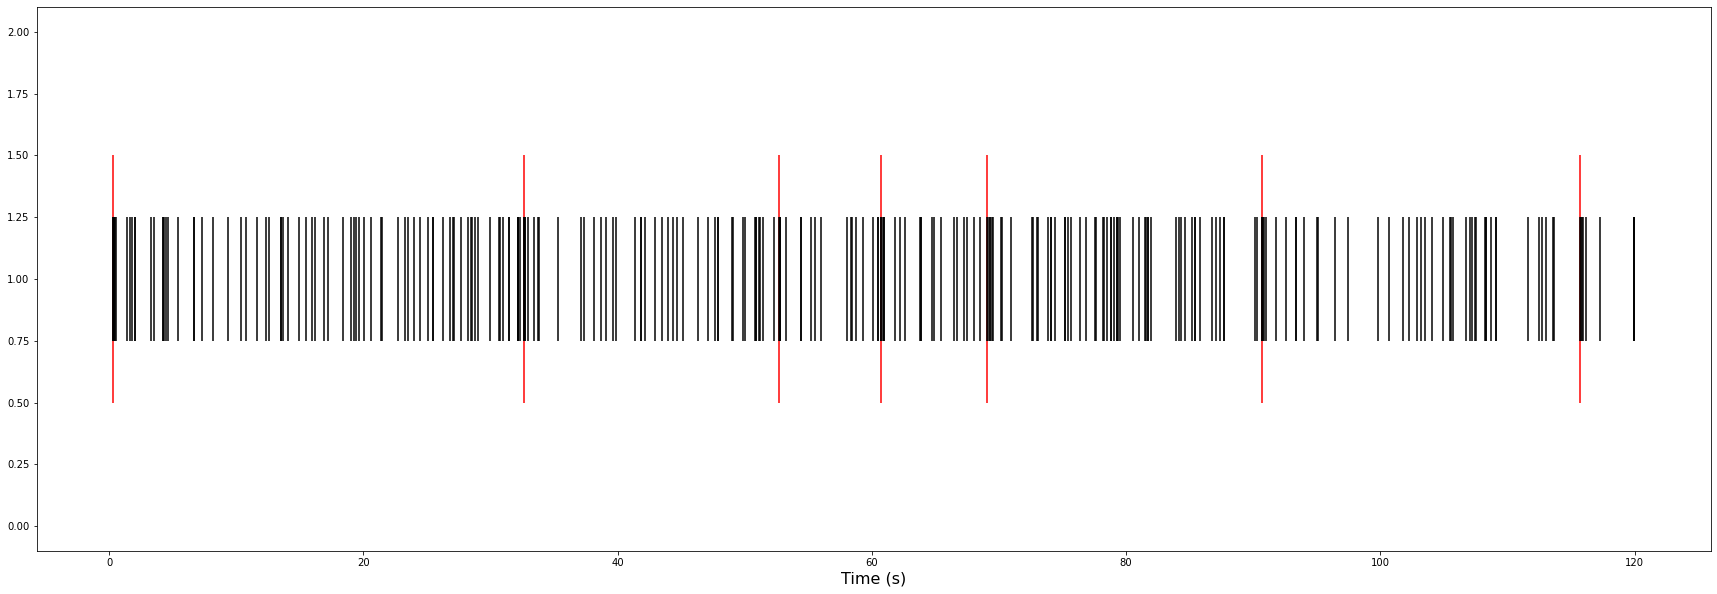

Text(0.5, 0, 'Time (s)')

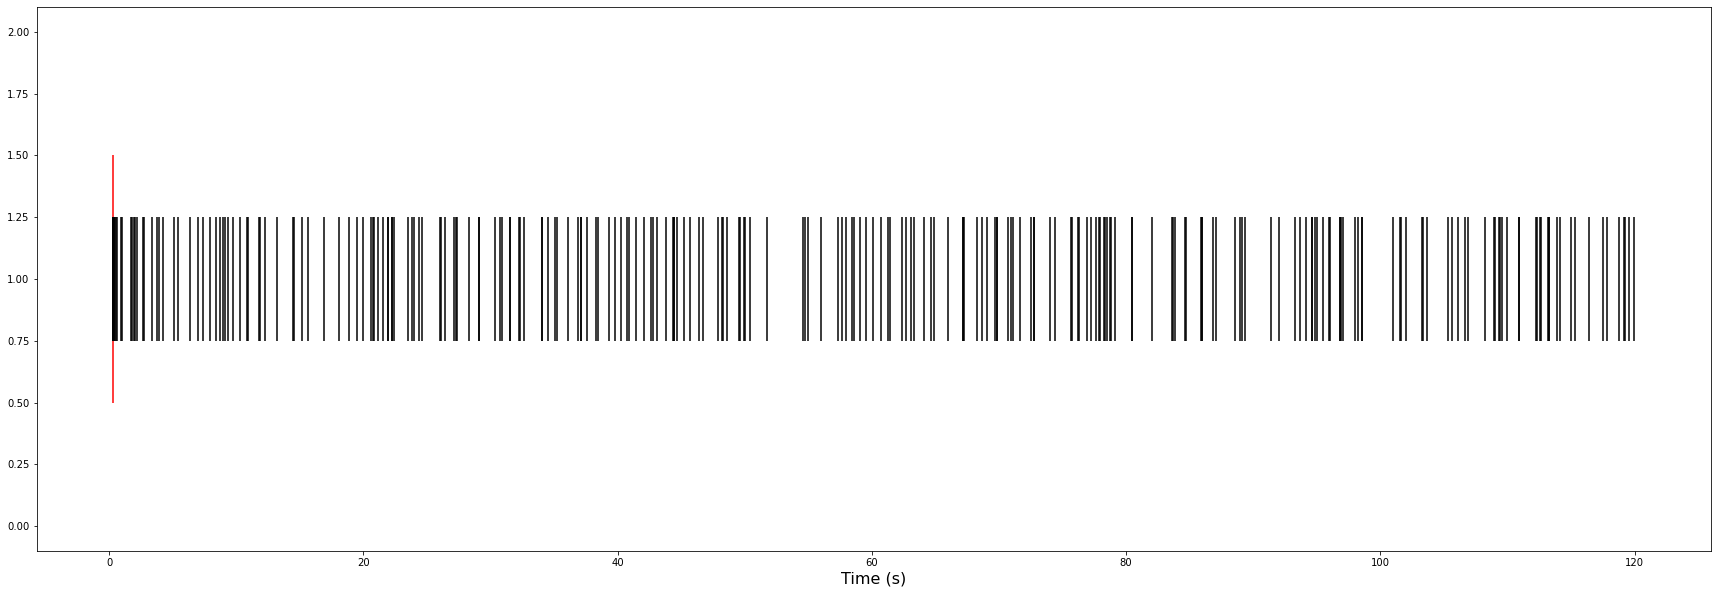

Text(0.5, 0, 'Time (s)')

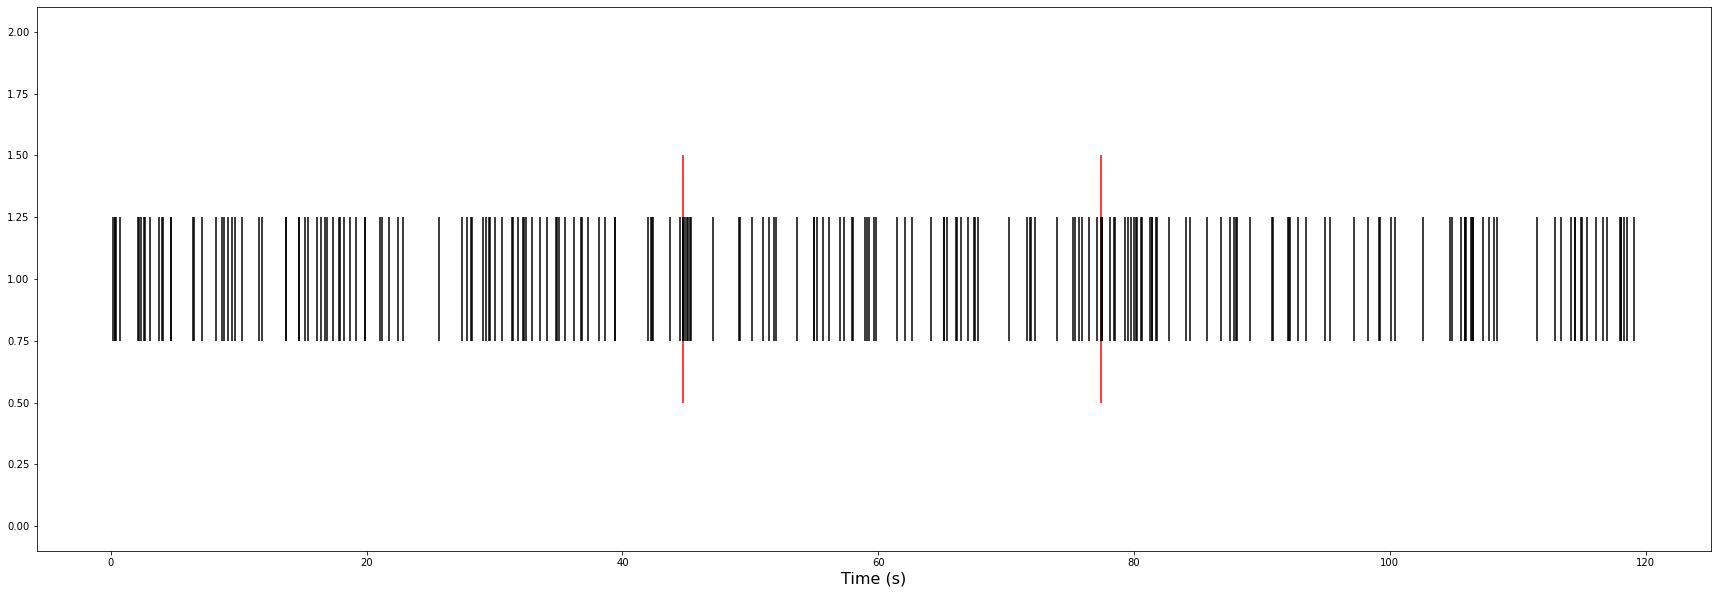

Text(0.5, 0, 'Time (s)')

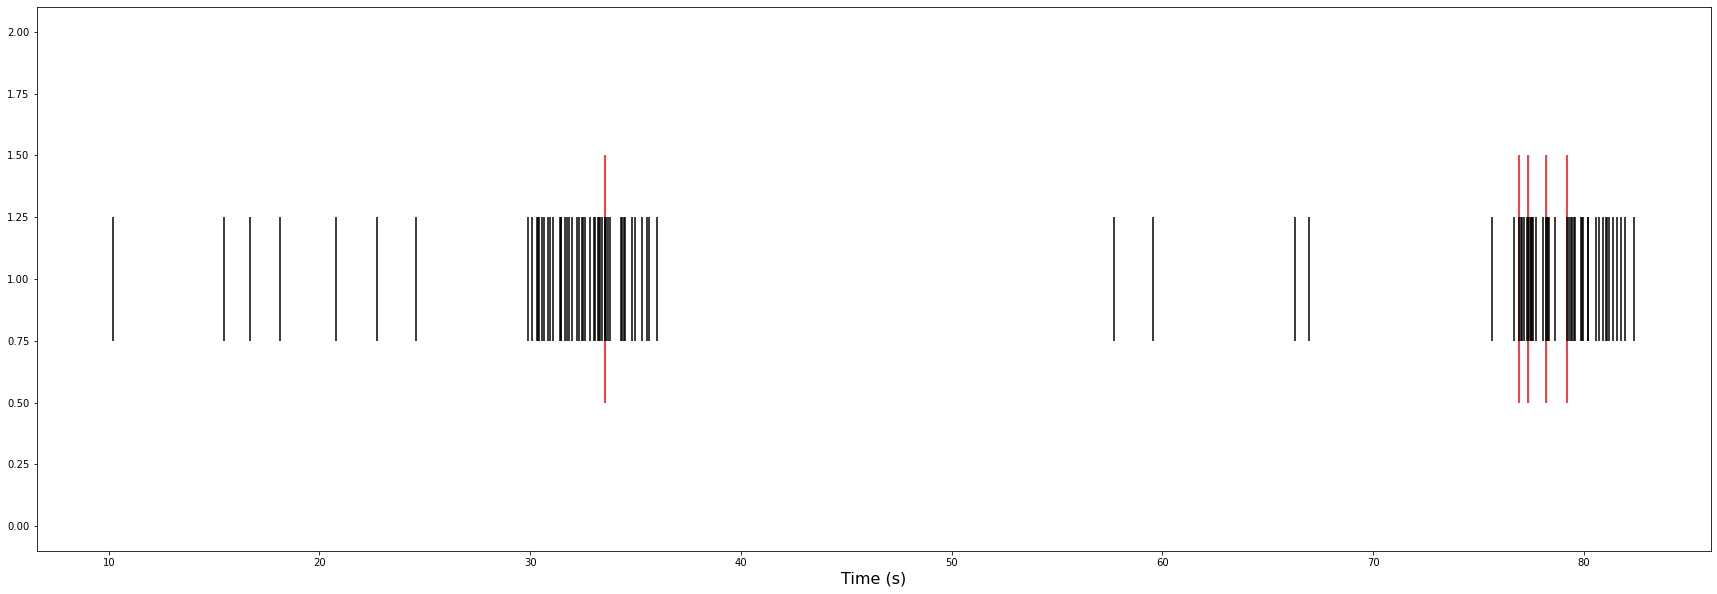

Text(0.5, 0, 'Time (s)')

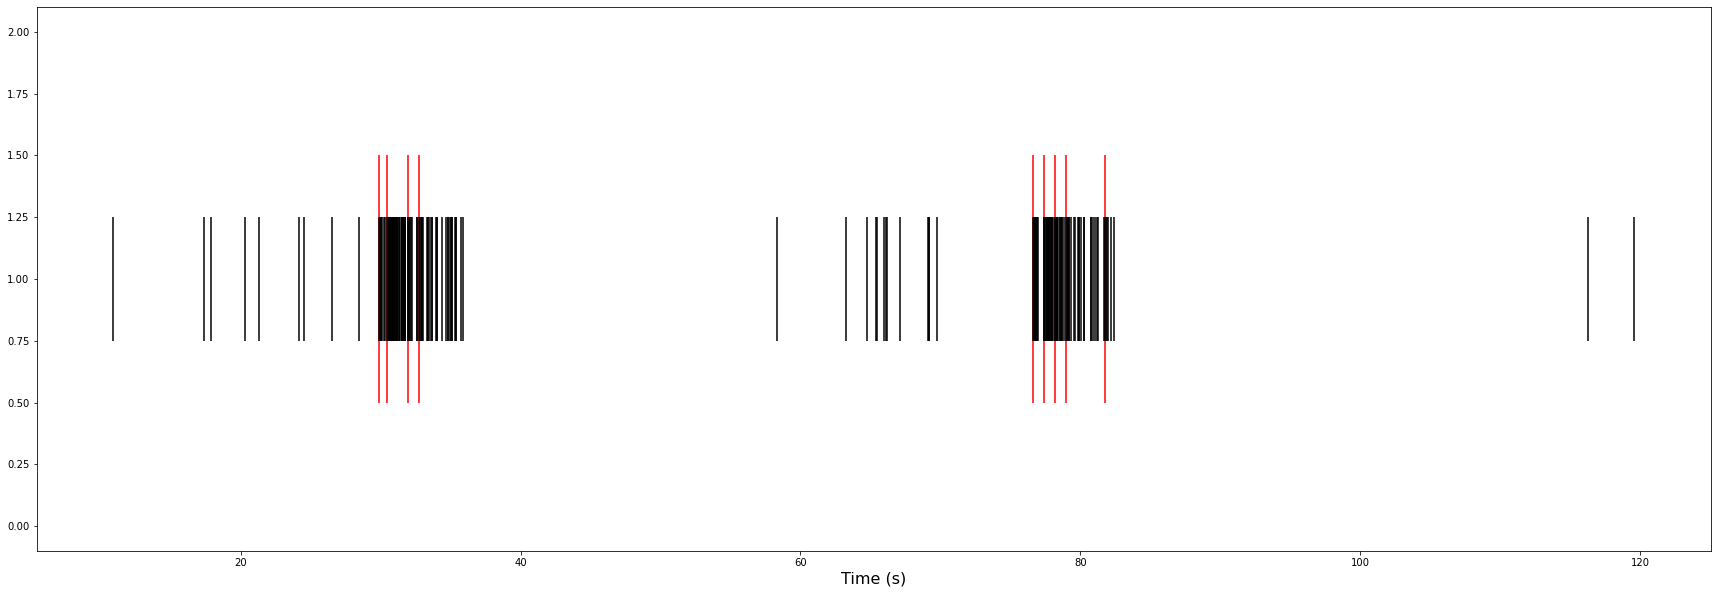

Text(0.5, 0, 'Time (s)')

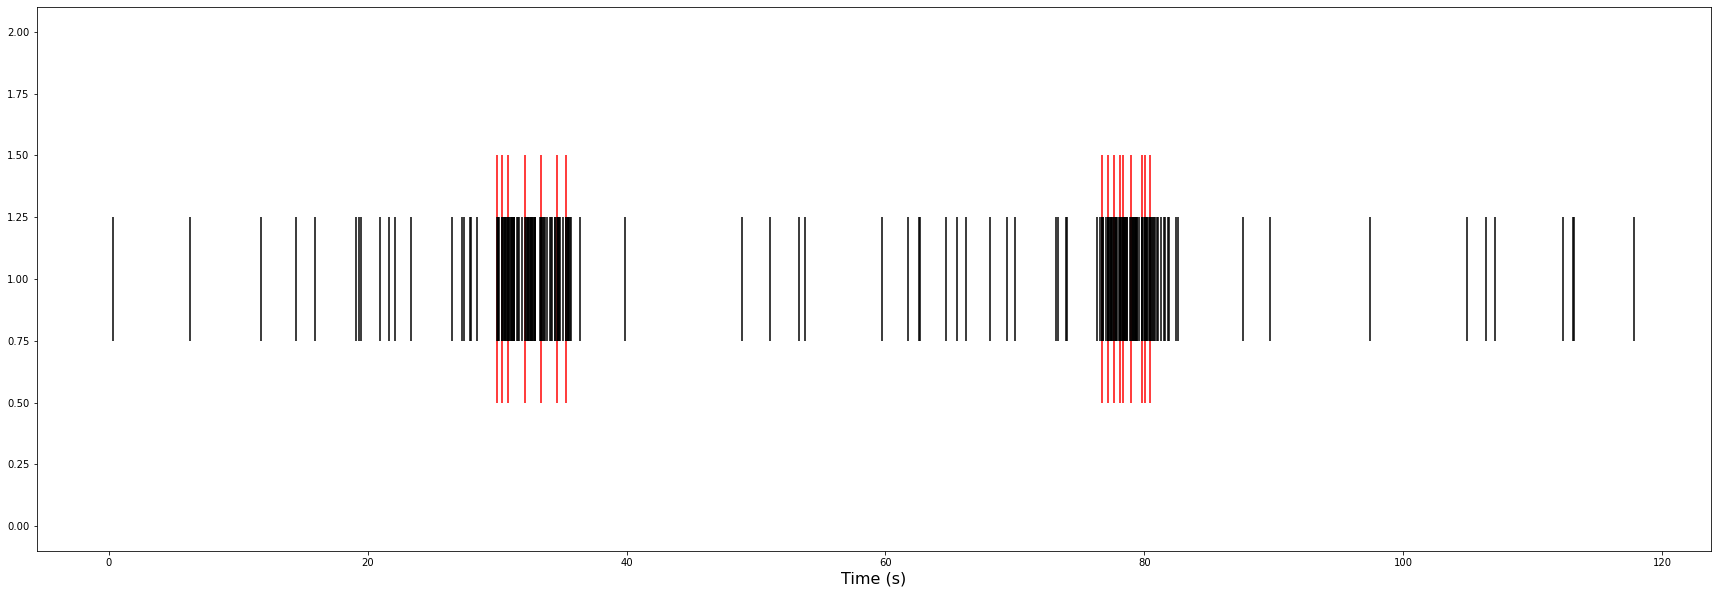

Text(0.5, 0, 'Time (s)')

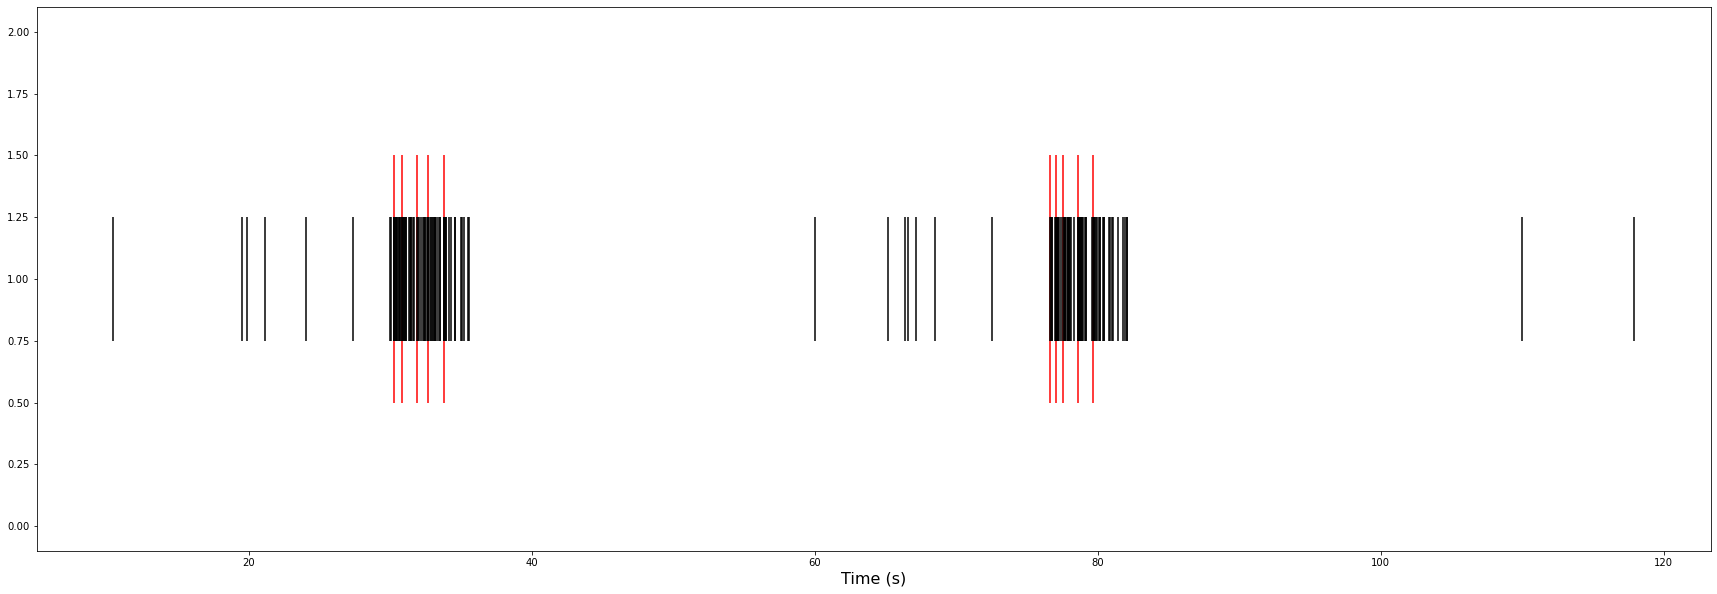

Text(0.5, 0, 'Time (s)')

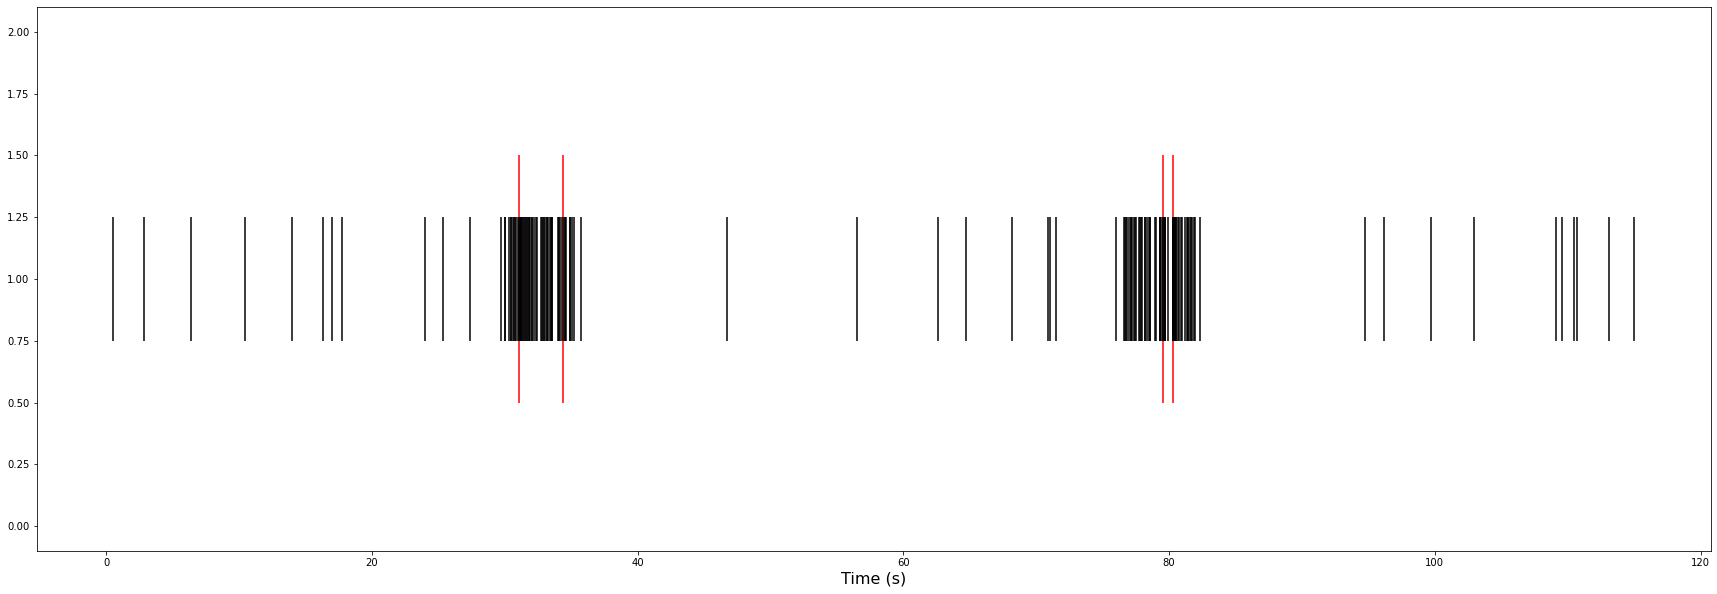

Text(0.5, 0, 'Time (s)')

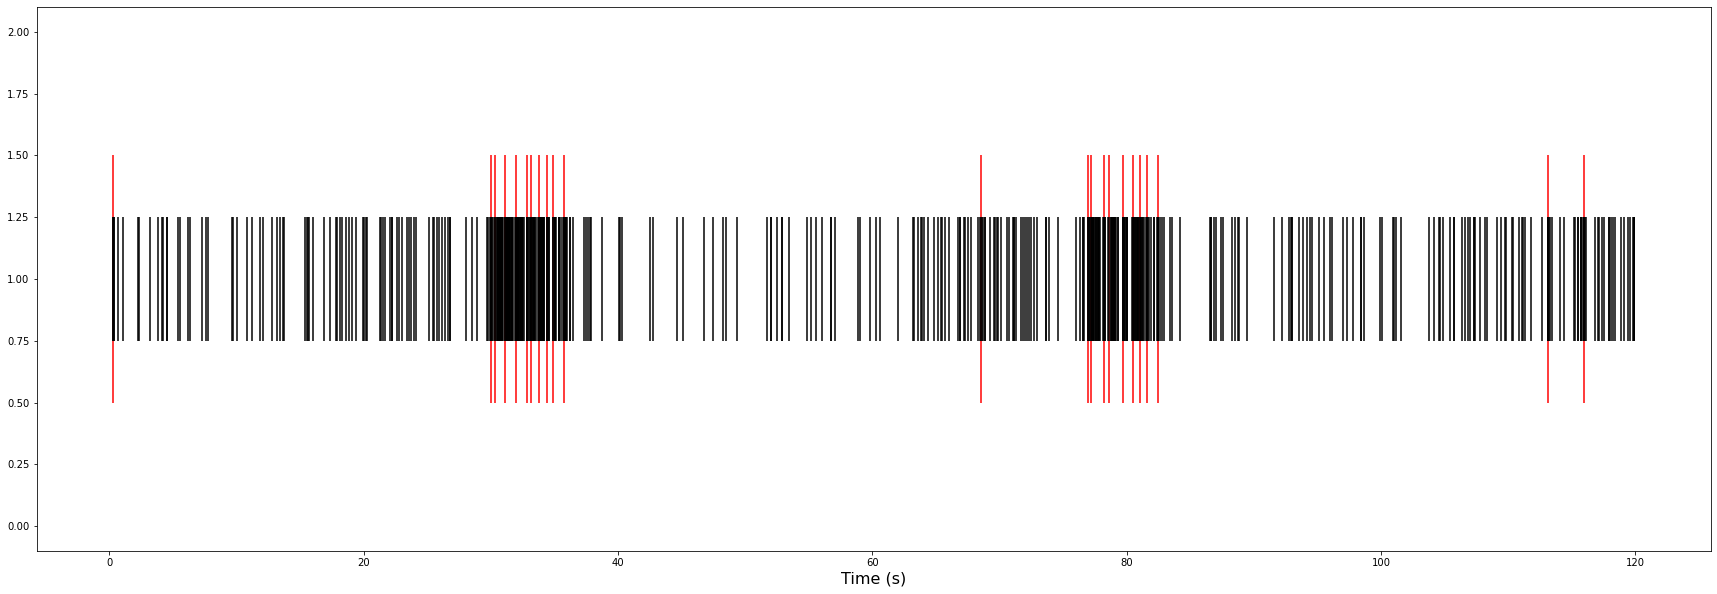

Text(0.5, 0, 'Time (s)')

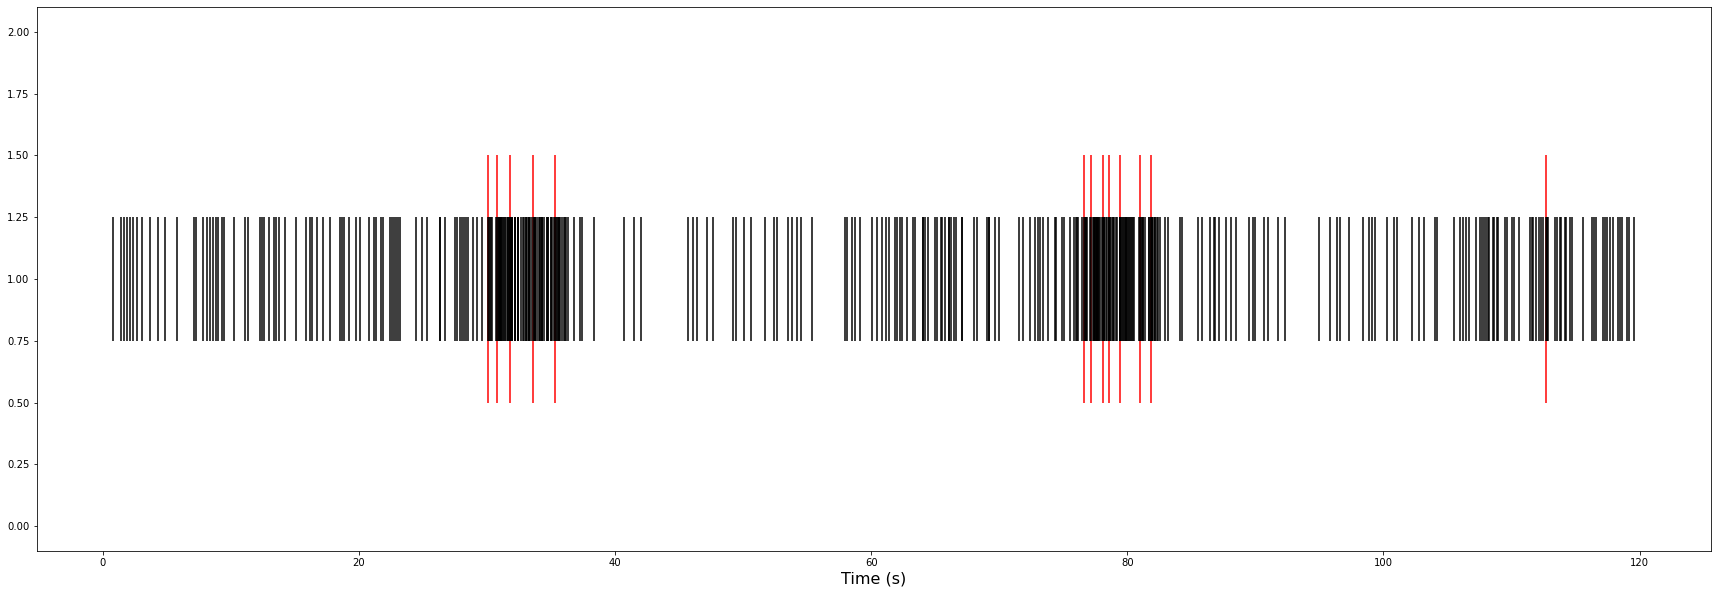

Text(0.5, 0, 'Time (s)')

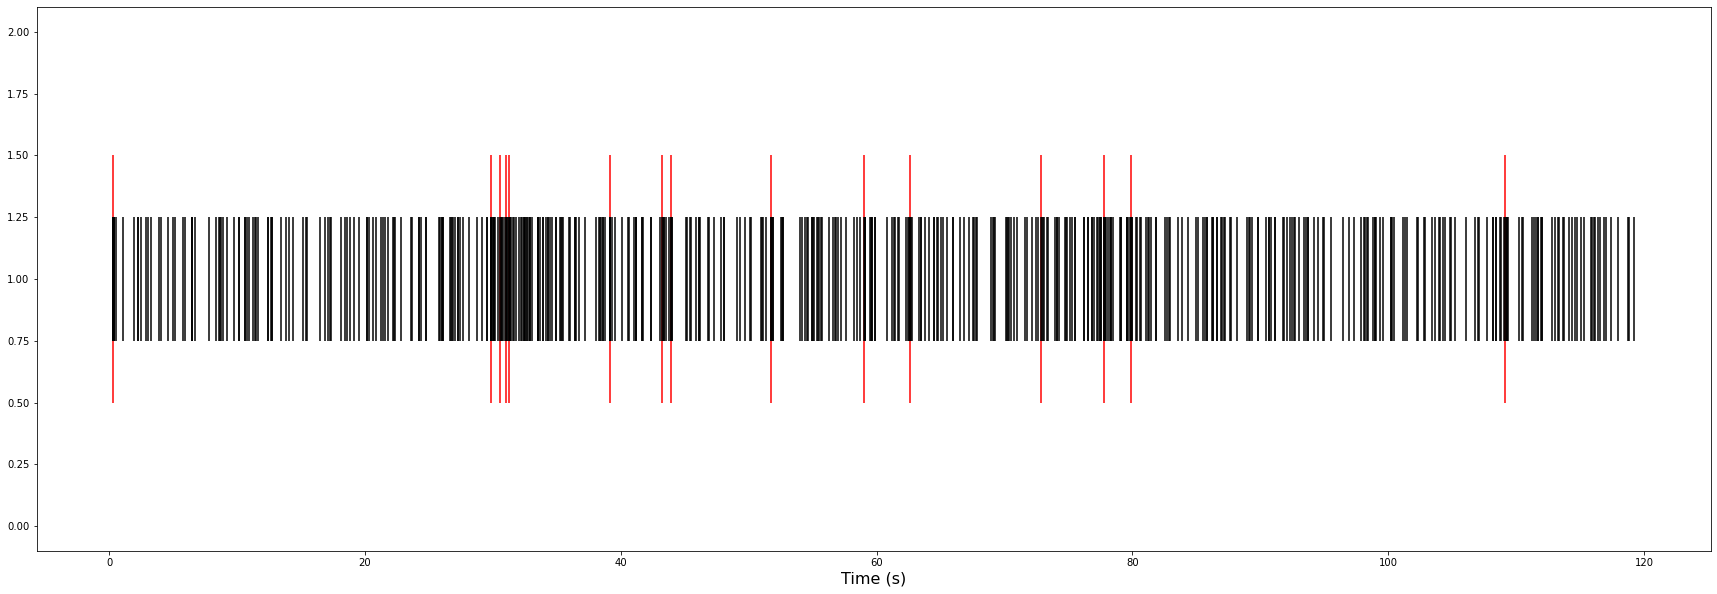

Text(0.5, 0, 'Time (s)')

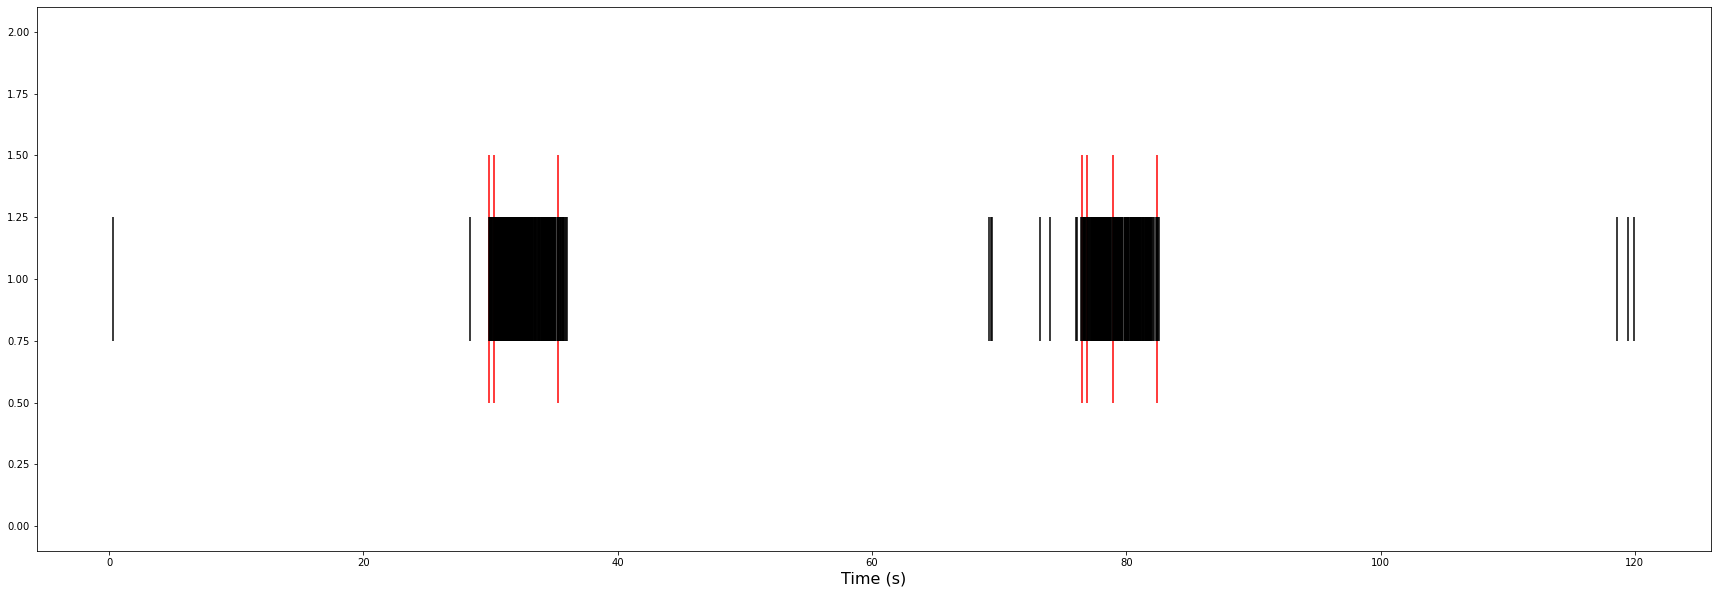

Text(0.5, 0, 'Time (s)')

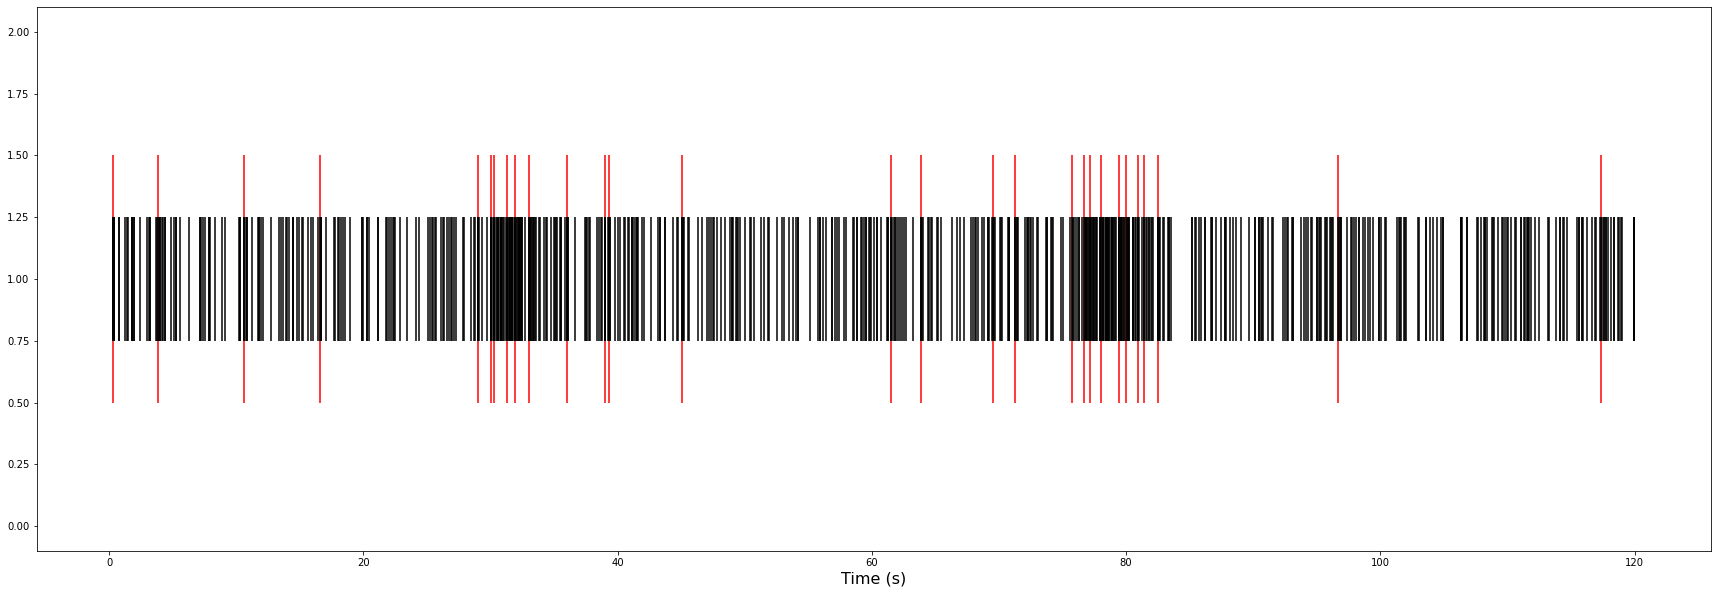

Text(0.5, 0, 'Time (s)')

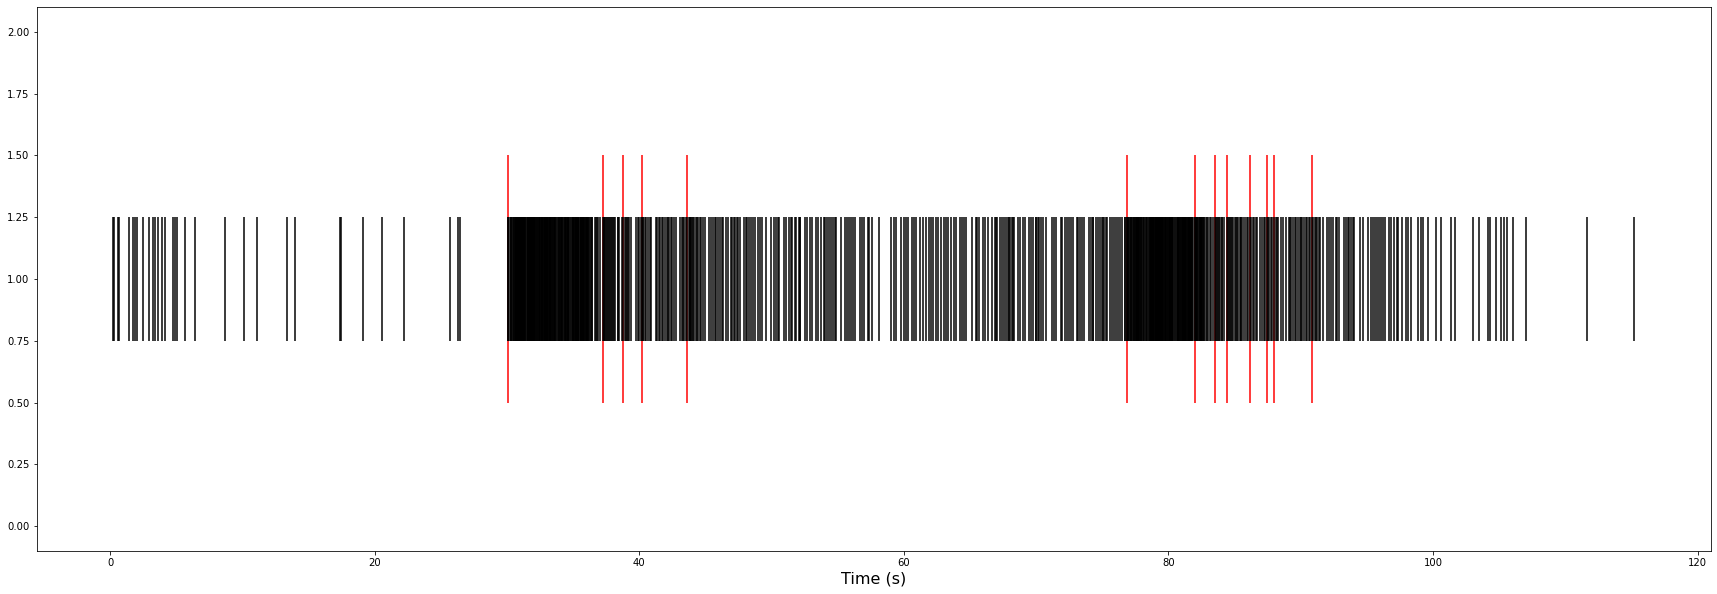

Text(0.5, 0, 'Time (s)')

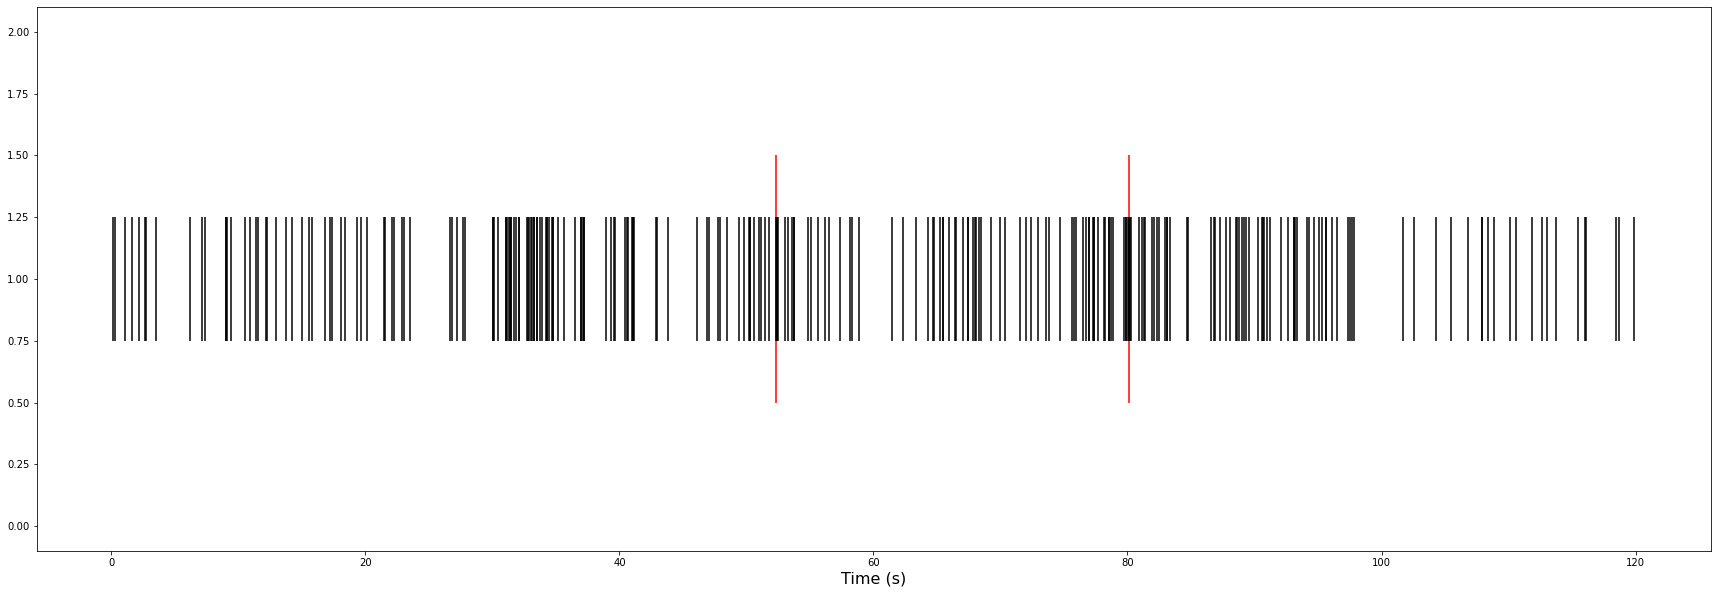

Text(0.5, 0, 'Time (s)')

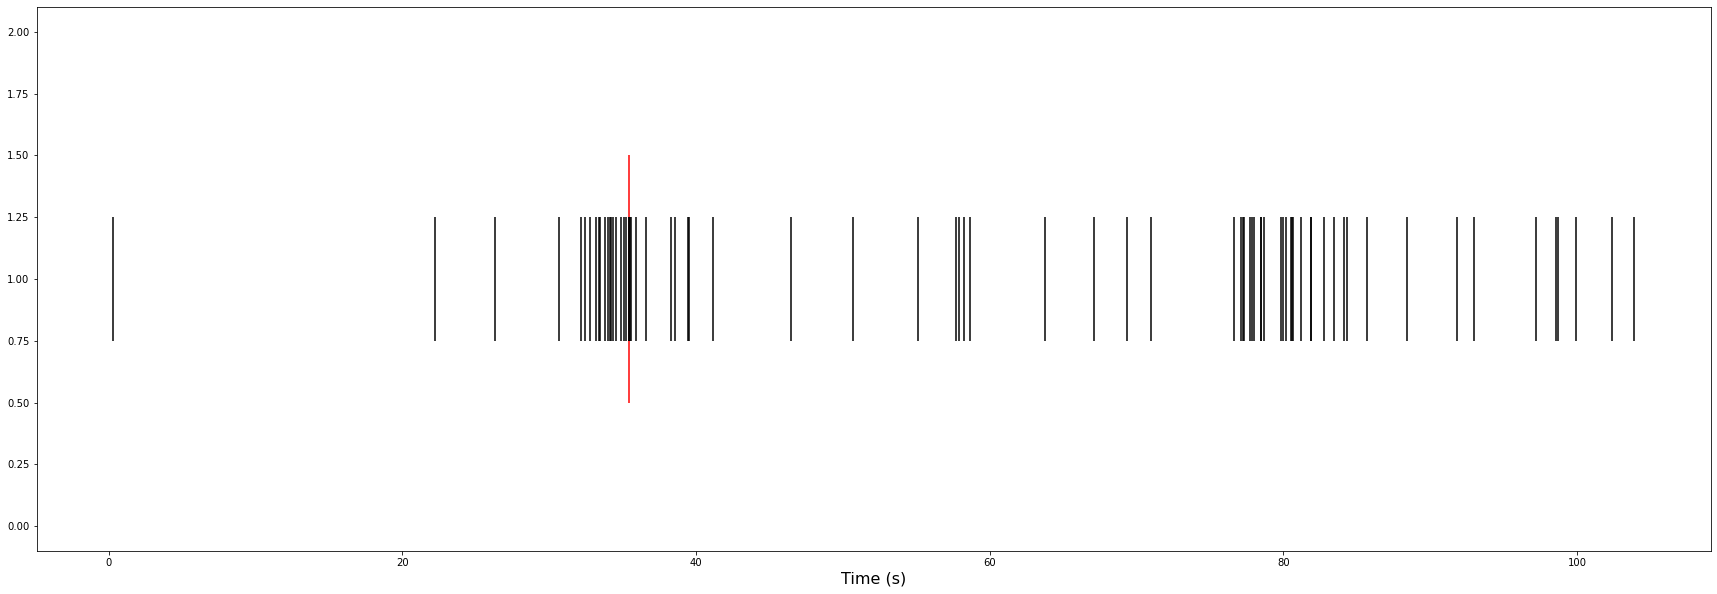

Text(0.5, 0, 'Time (s)')

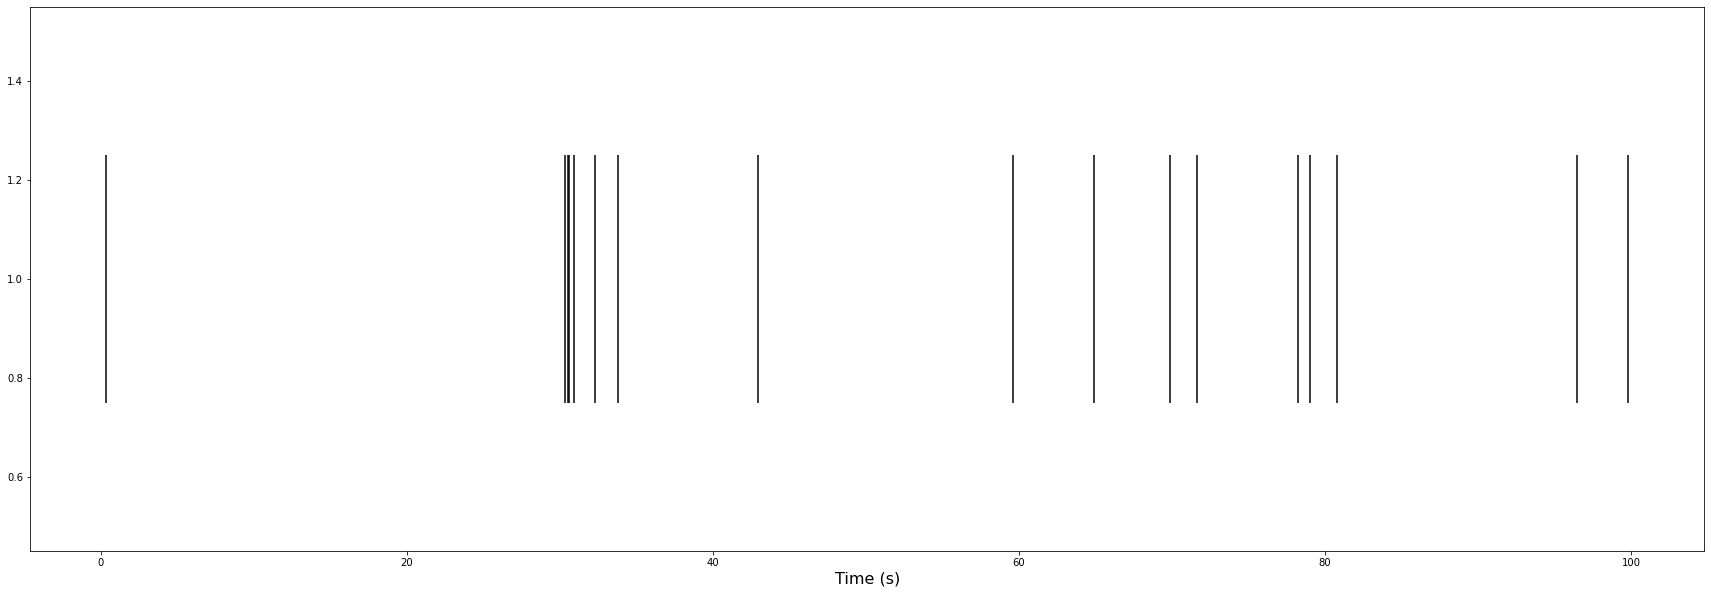

Text(0.5, 0, 'Time (s)')

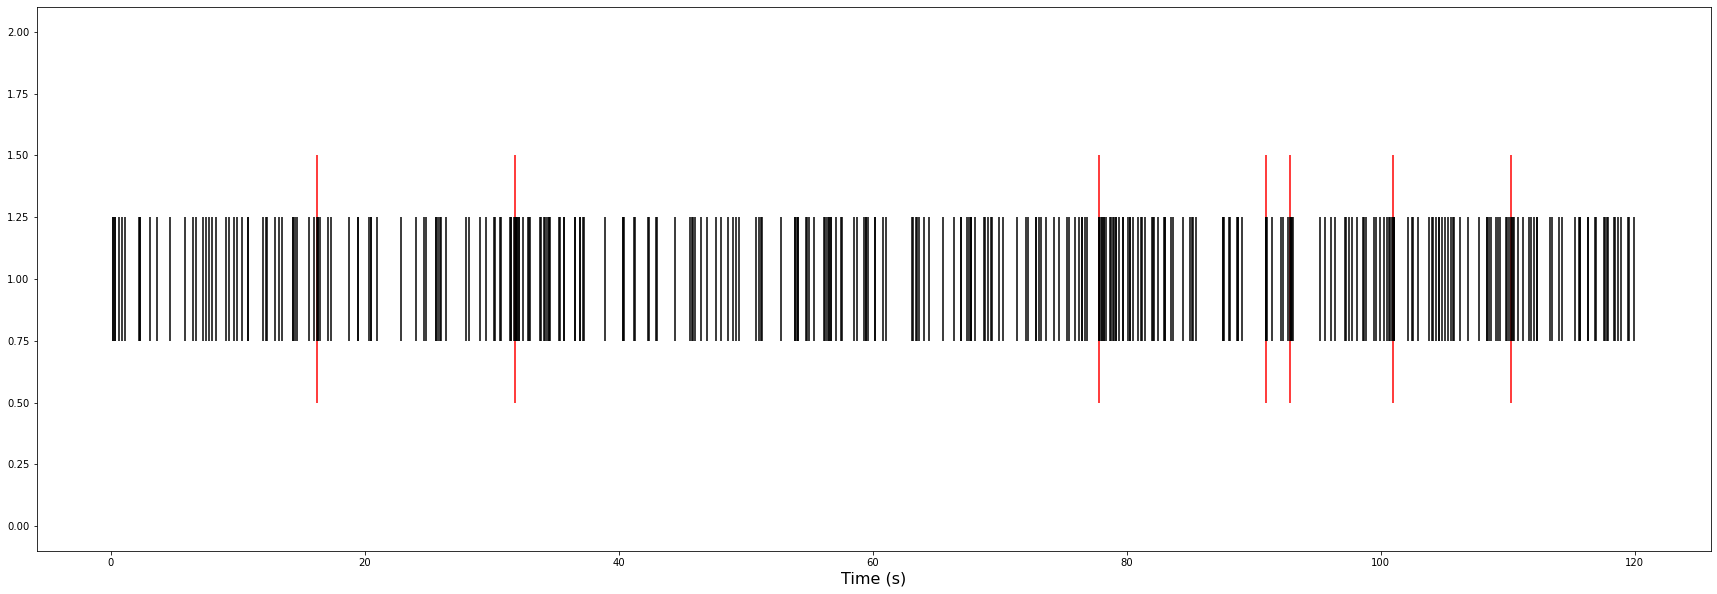

Text(0.5, 0, 'Time (s)')

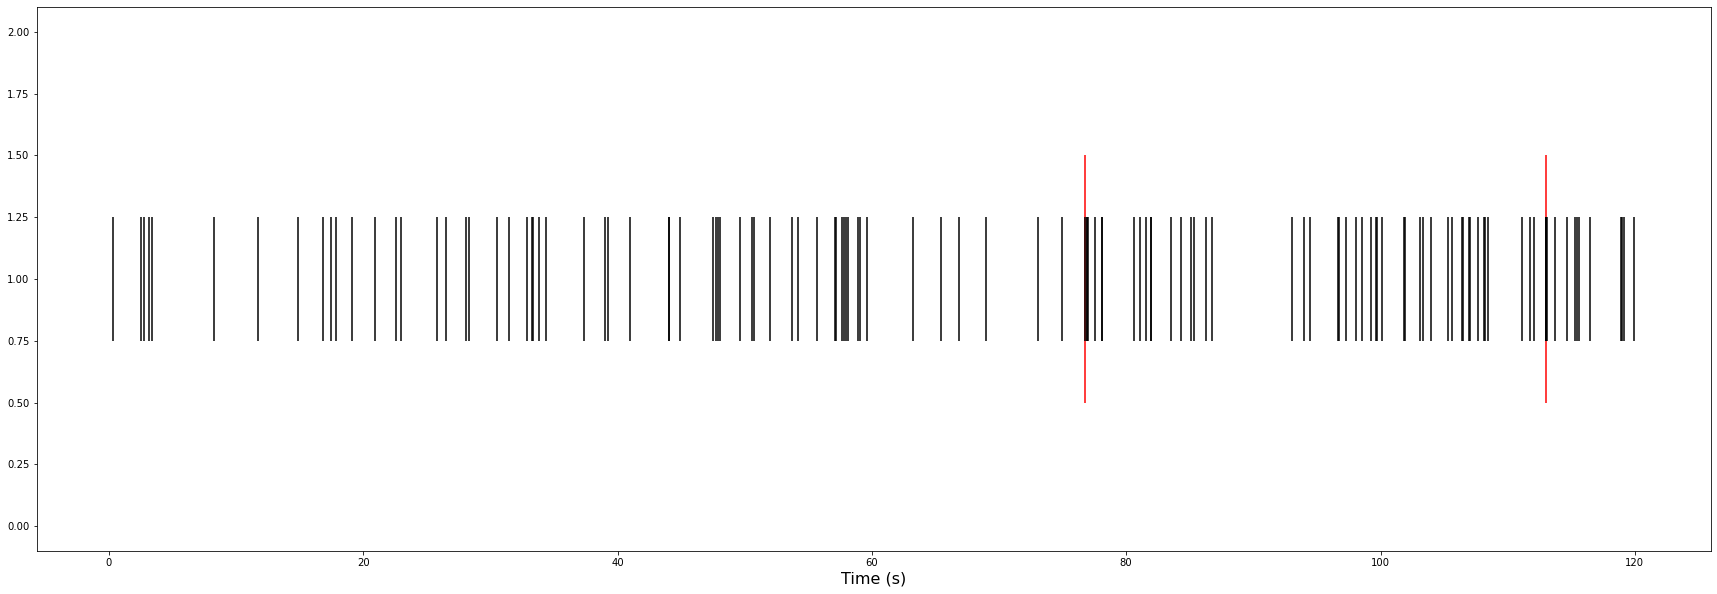

Text(0.5, 0, 'Time (s)')

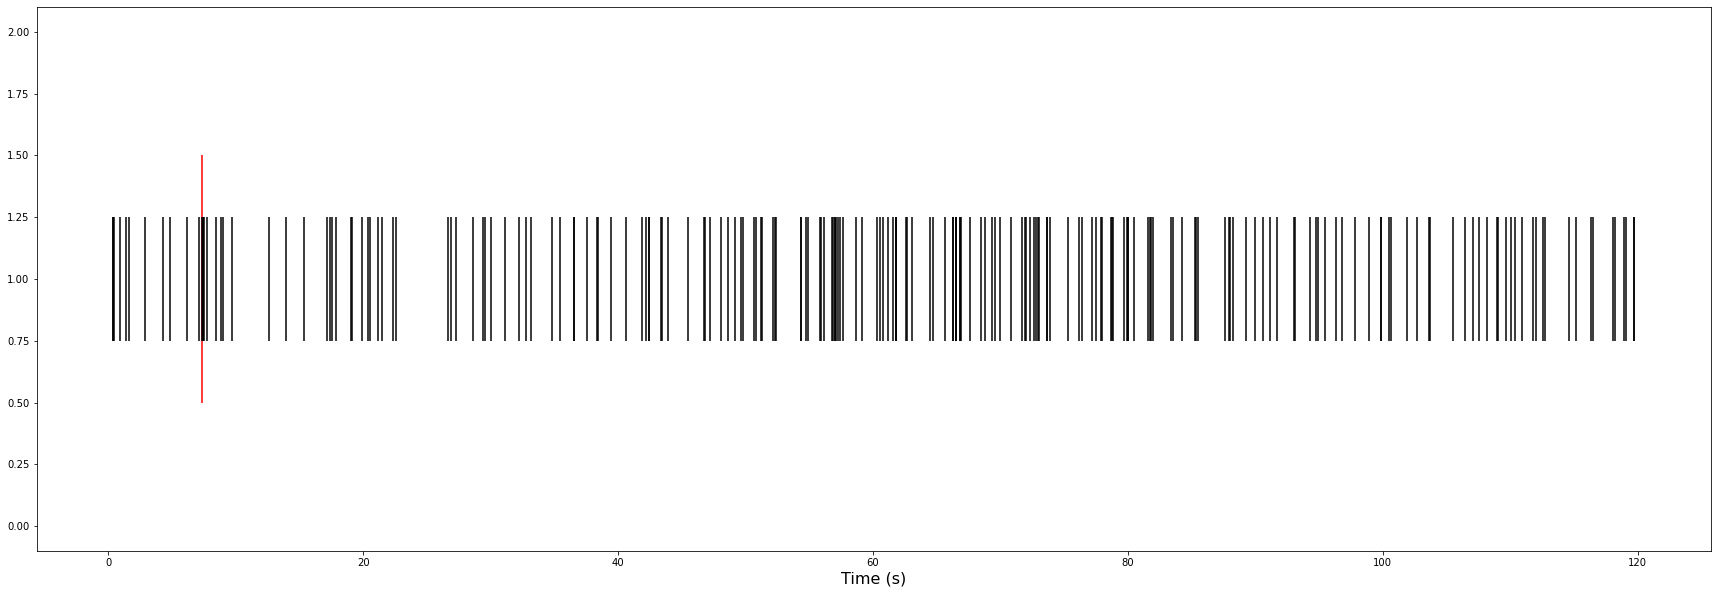

Text(0.5, 0, 'Time (s)')

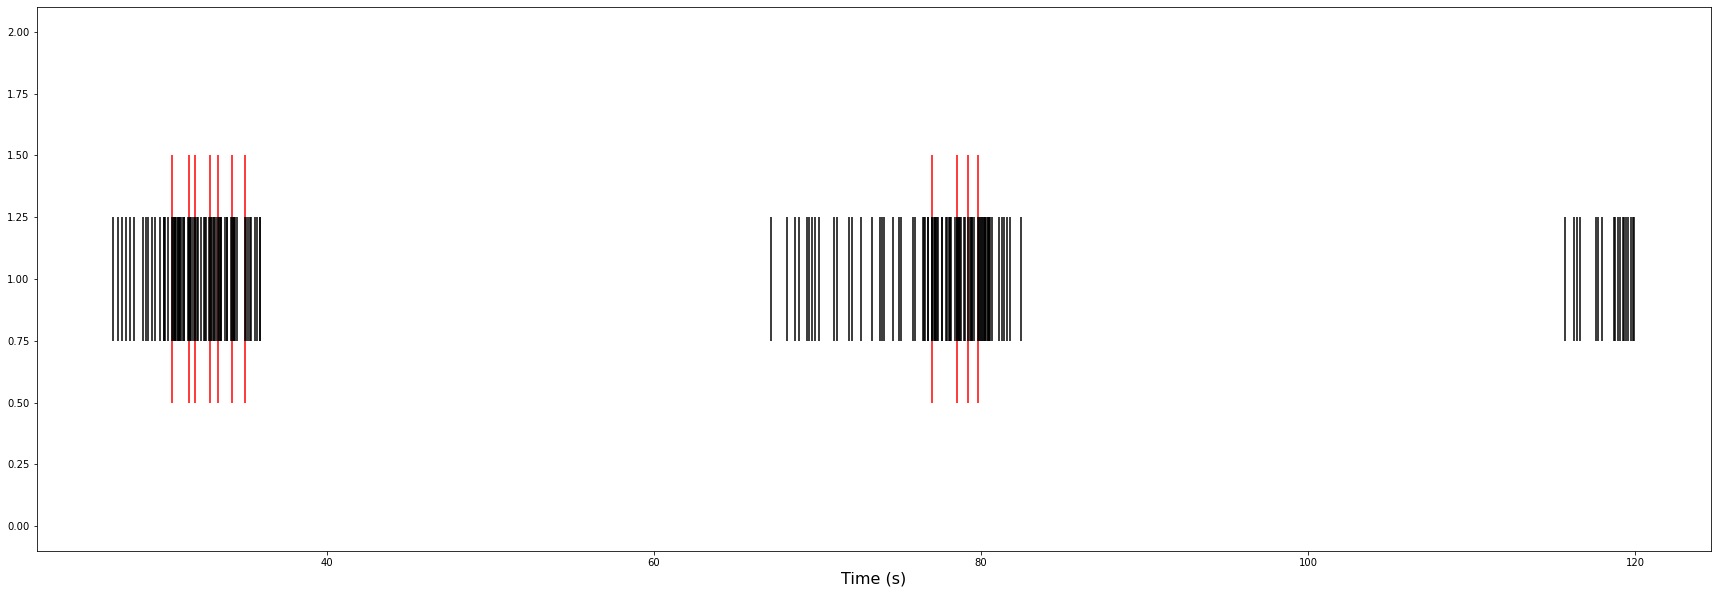

Text(0.5, 0, 'Time (s)')

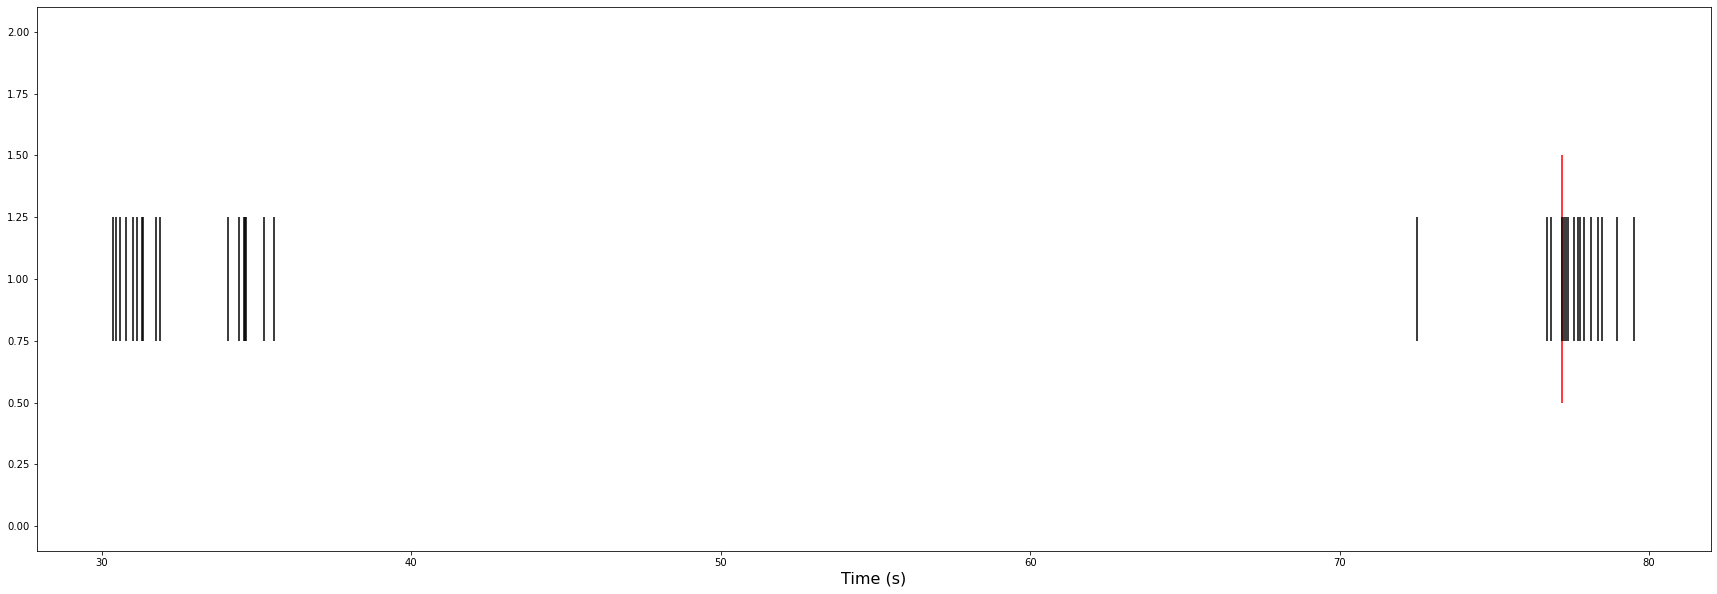

Text(0.5, 0, 'Time (s)')

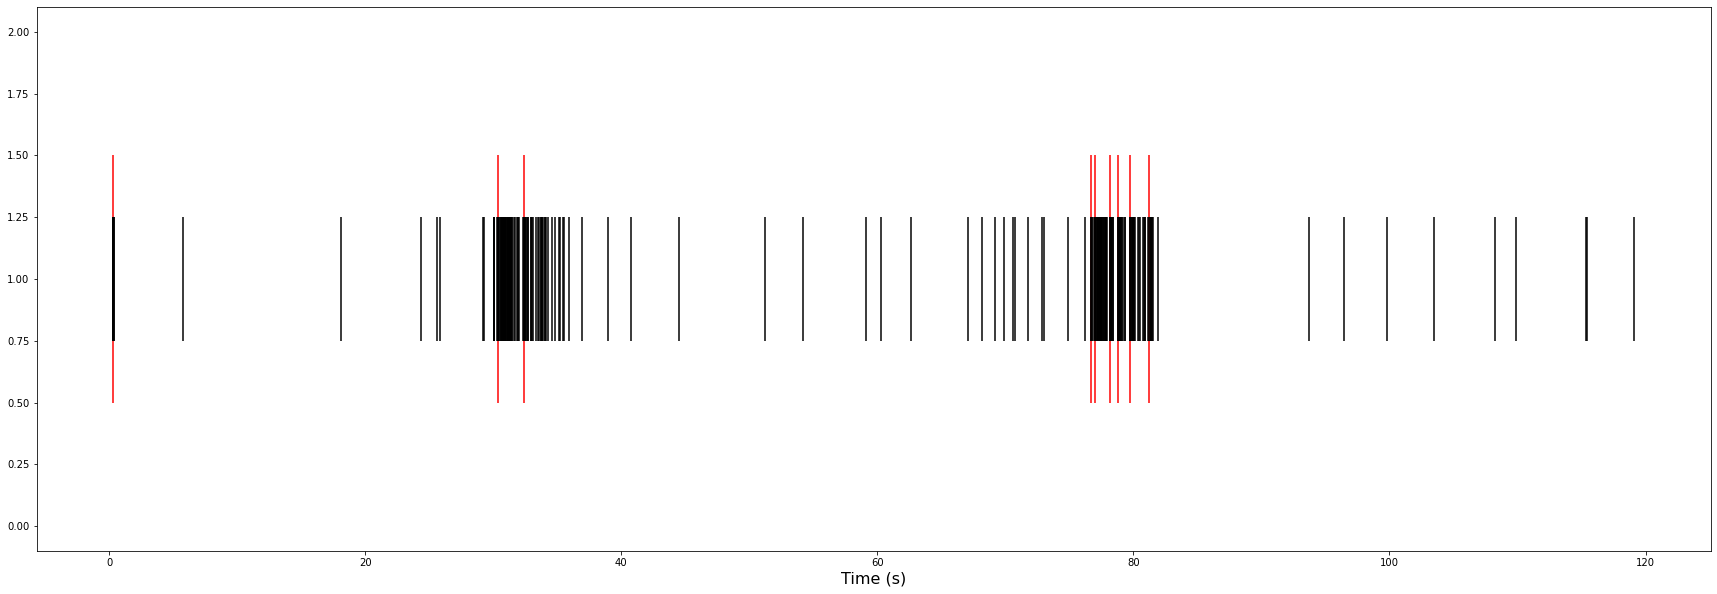

Text(0.5, 0, 'Time (s)')

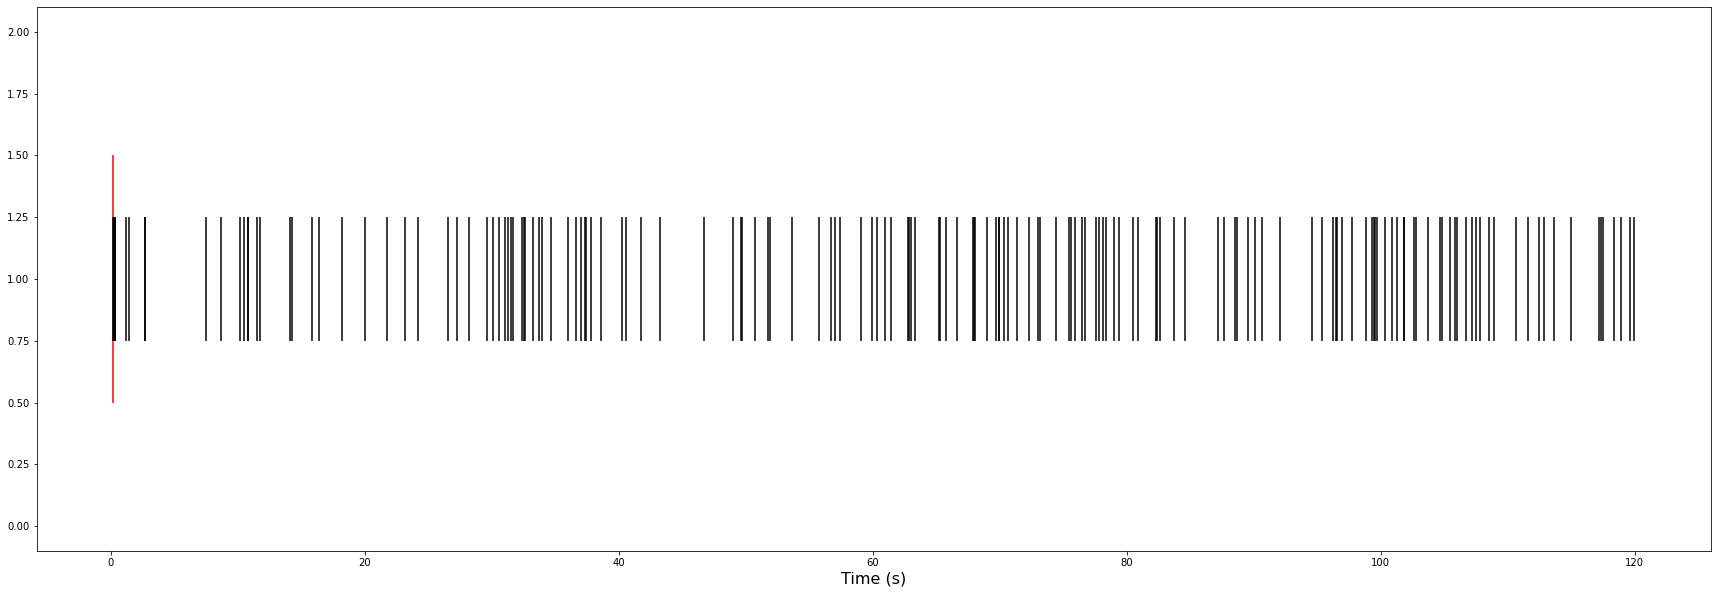

Text(0.5, 0, 'Time (s)')

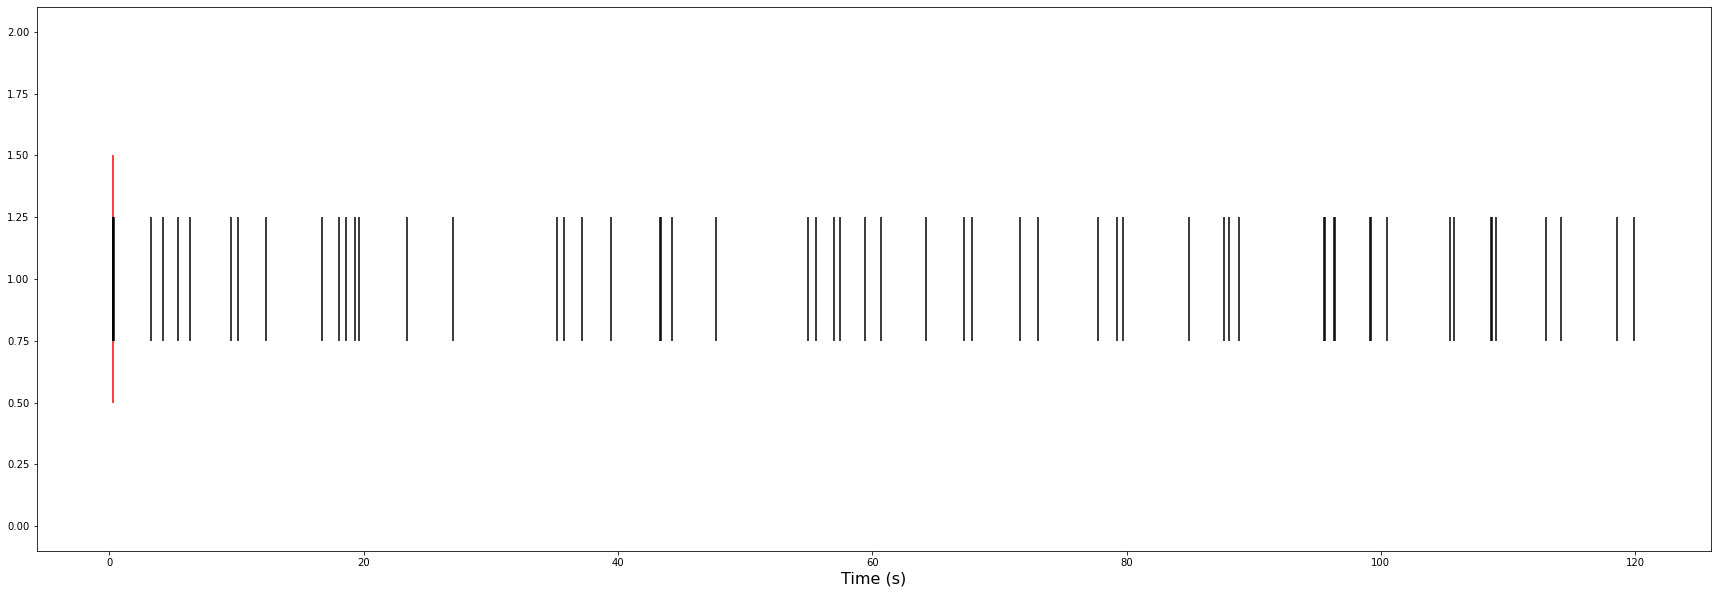

Text(0.5, 0, 'Time (s)')

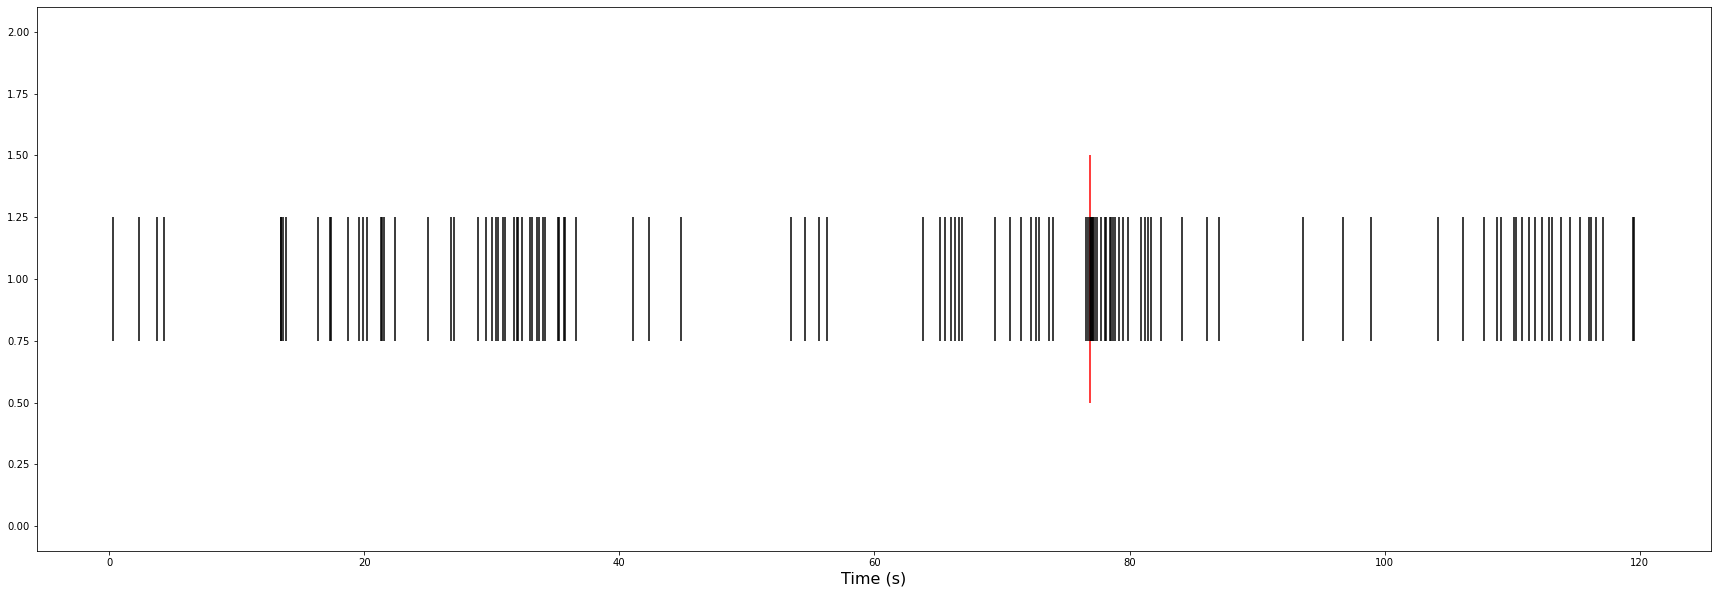

Text(0.5, 0, 'Time (s)')

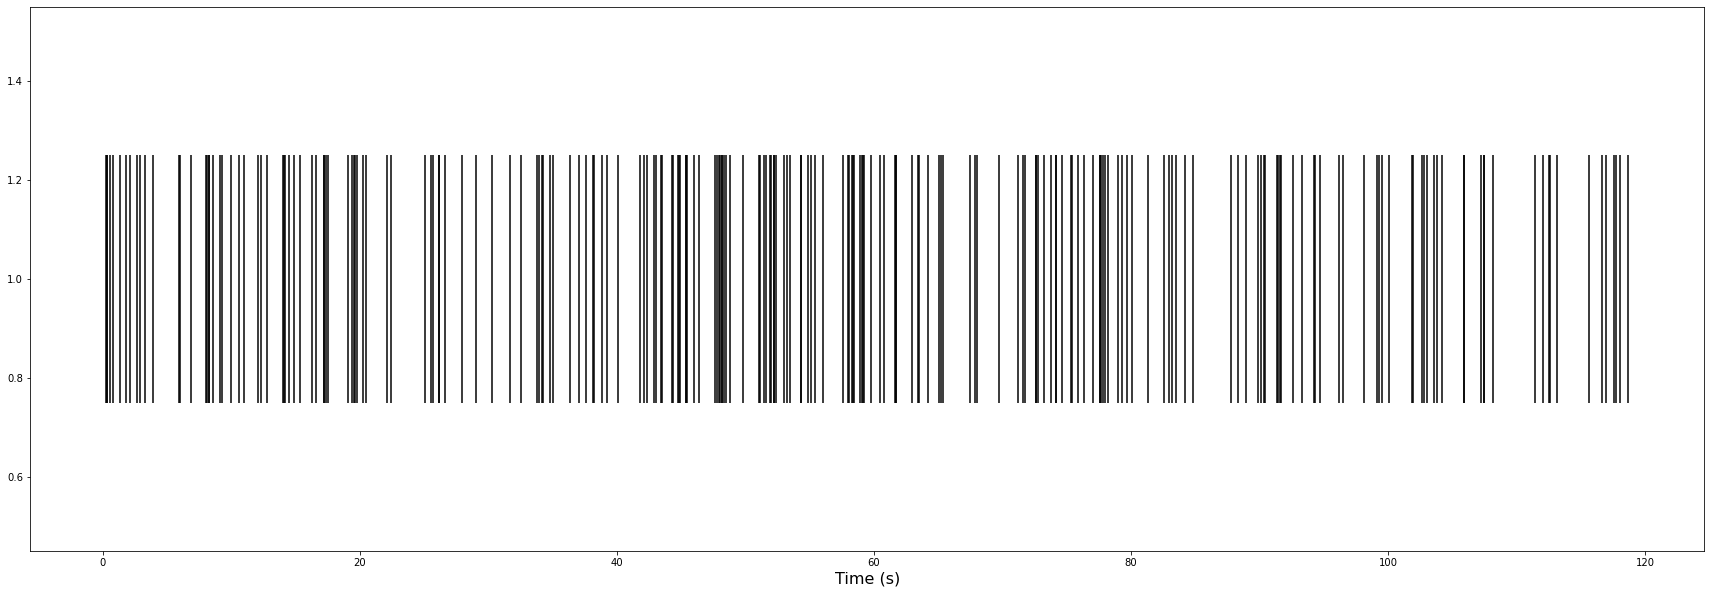

Text(0.5, 0, 'Time (s)')

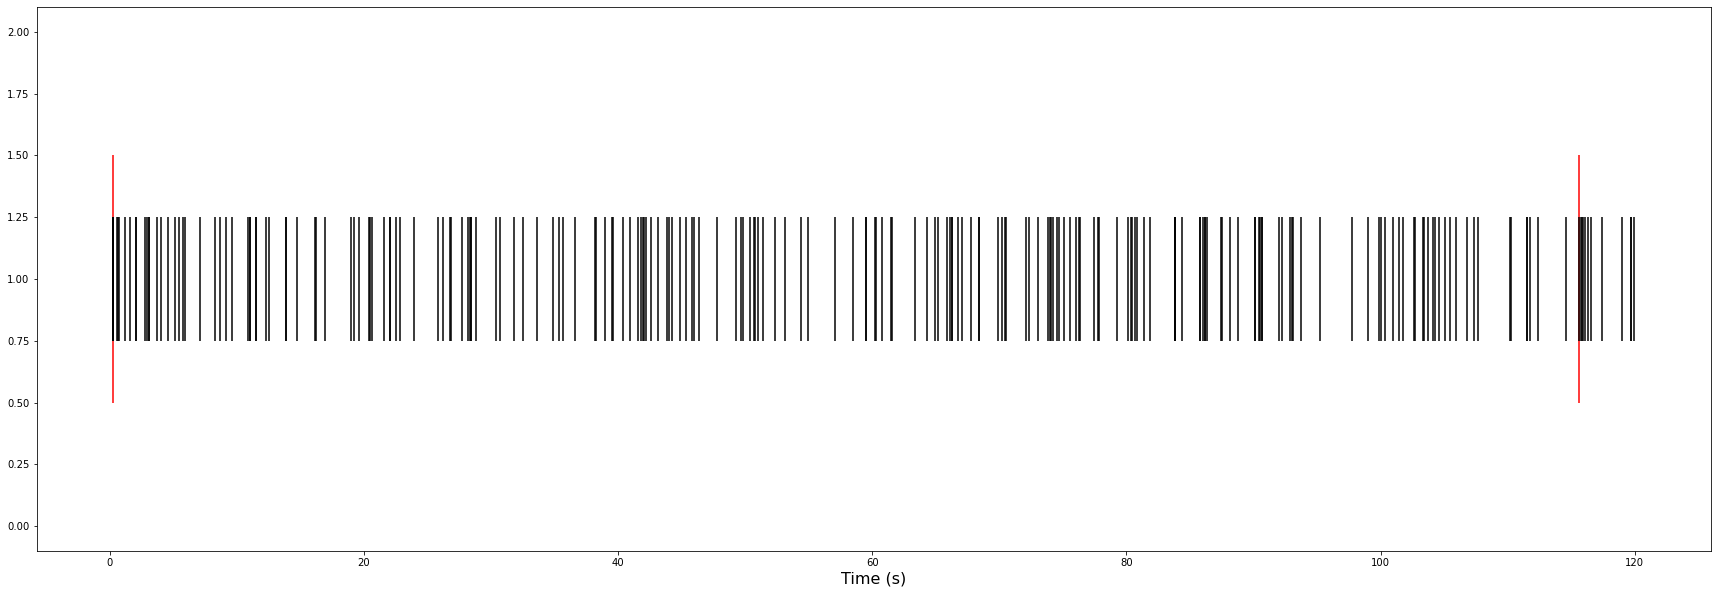

Text(0.5, 0, 'Time (s)')

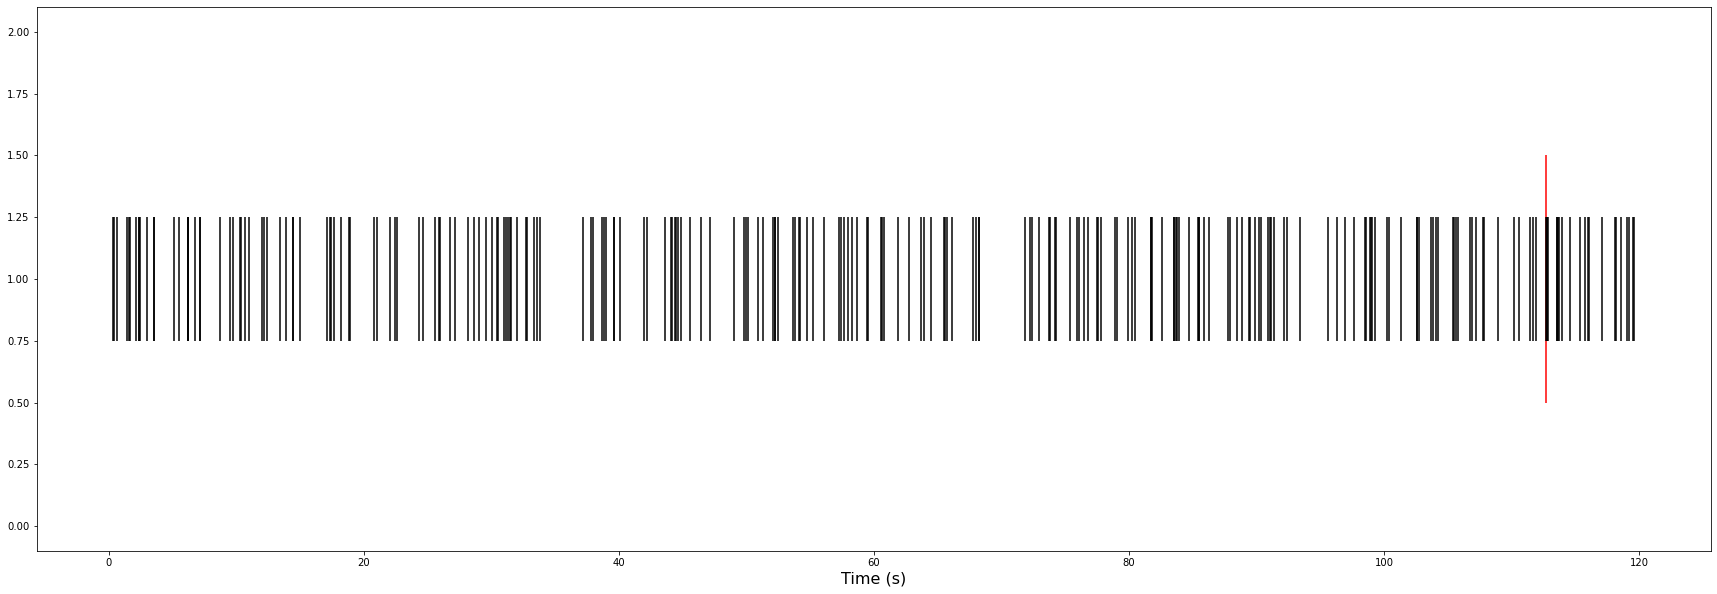

Text(0.5, 0, 'Time (s)')

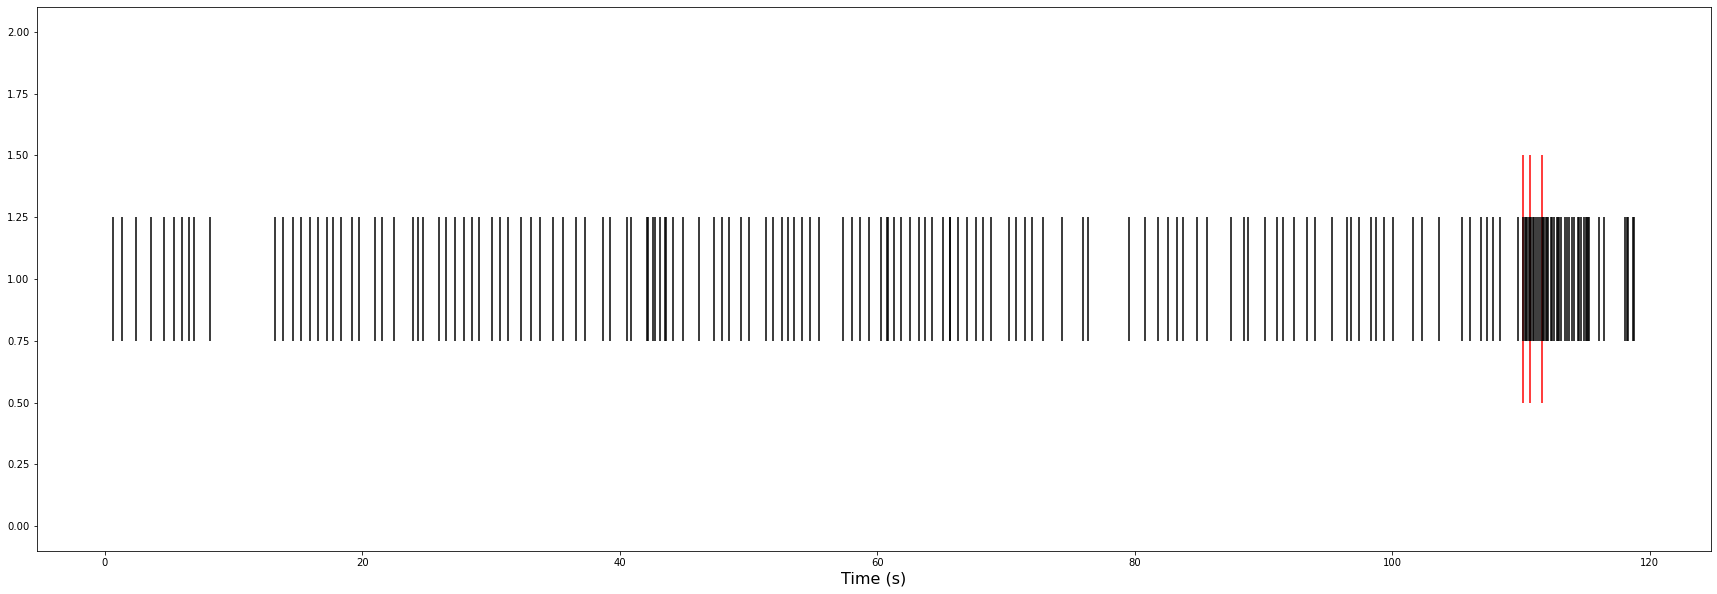

Text(0.5, 0, 'Time (s)')

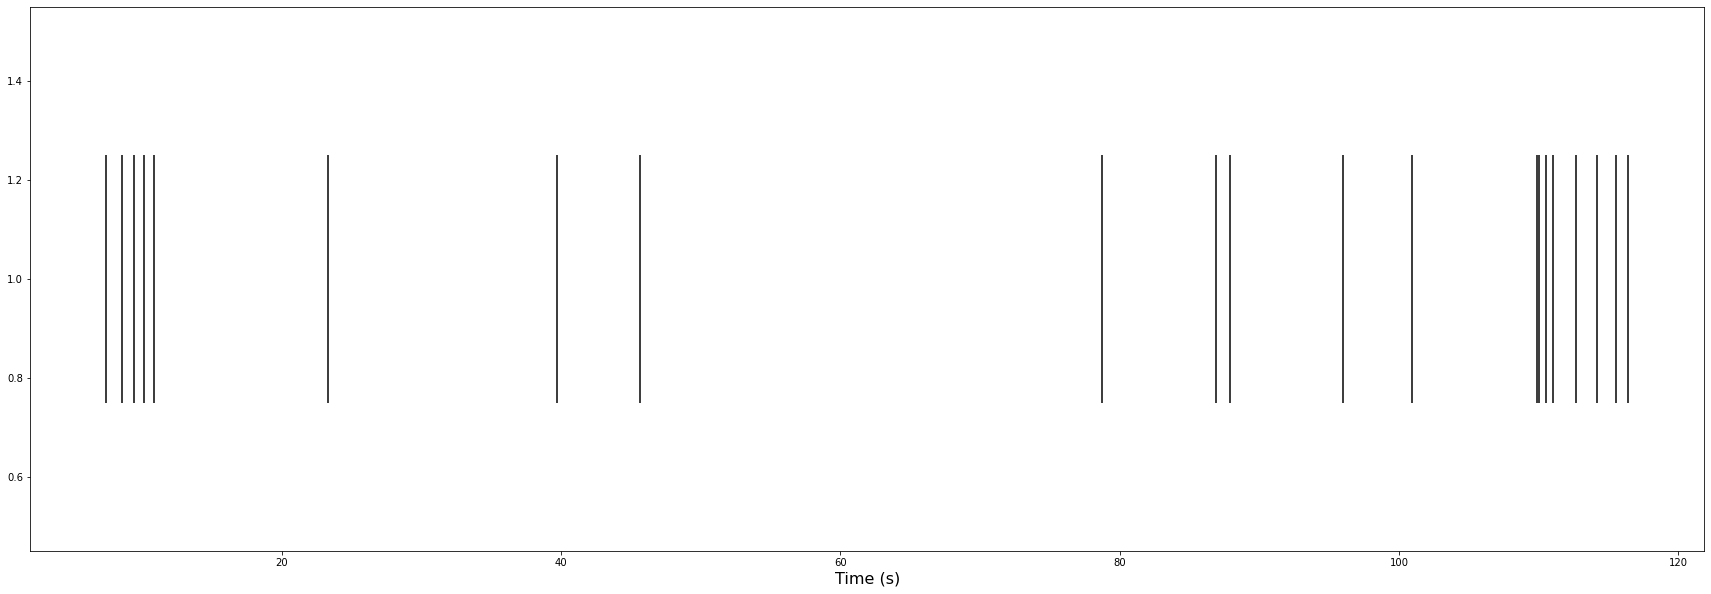

Text(0.5, 0, 'Time (s)')

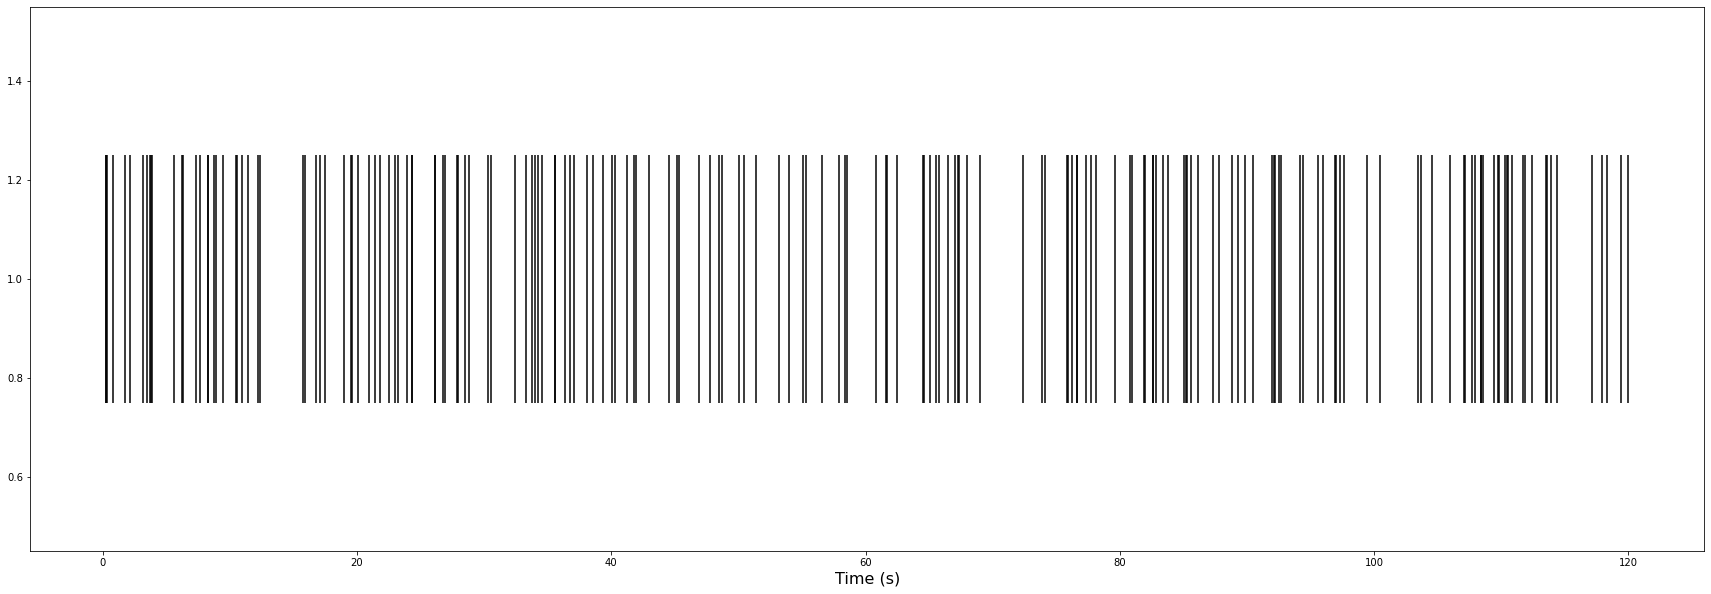

Text(0.5, 0, 'Time (s)')

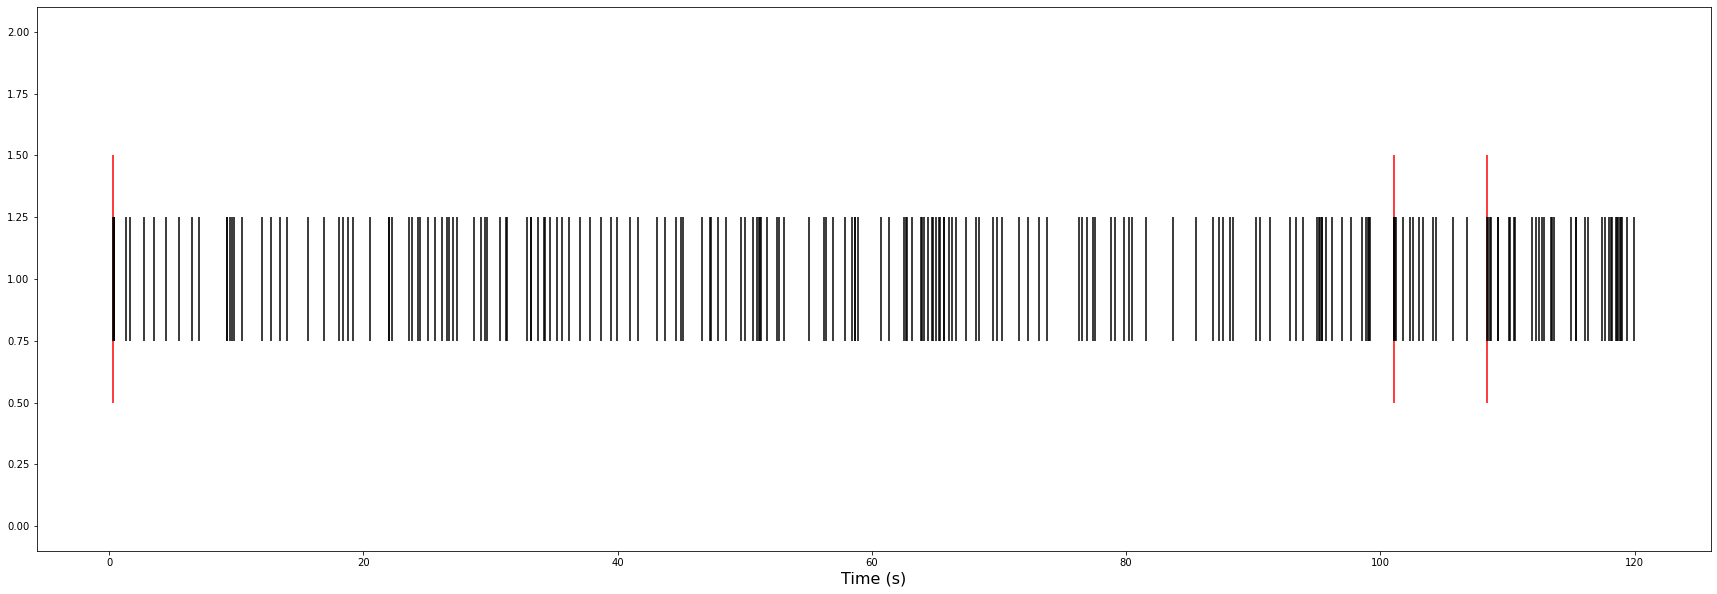

Text(0.5, 0, 'Time (s)')

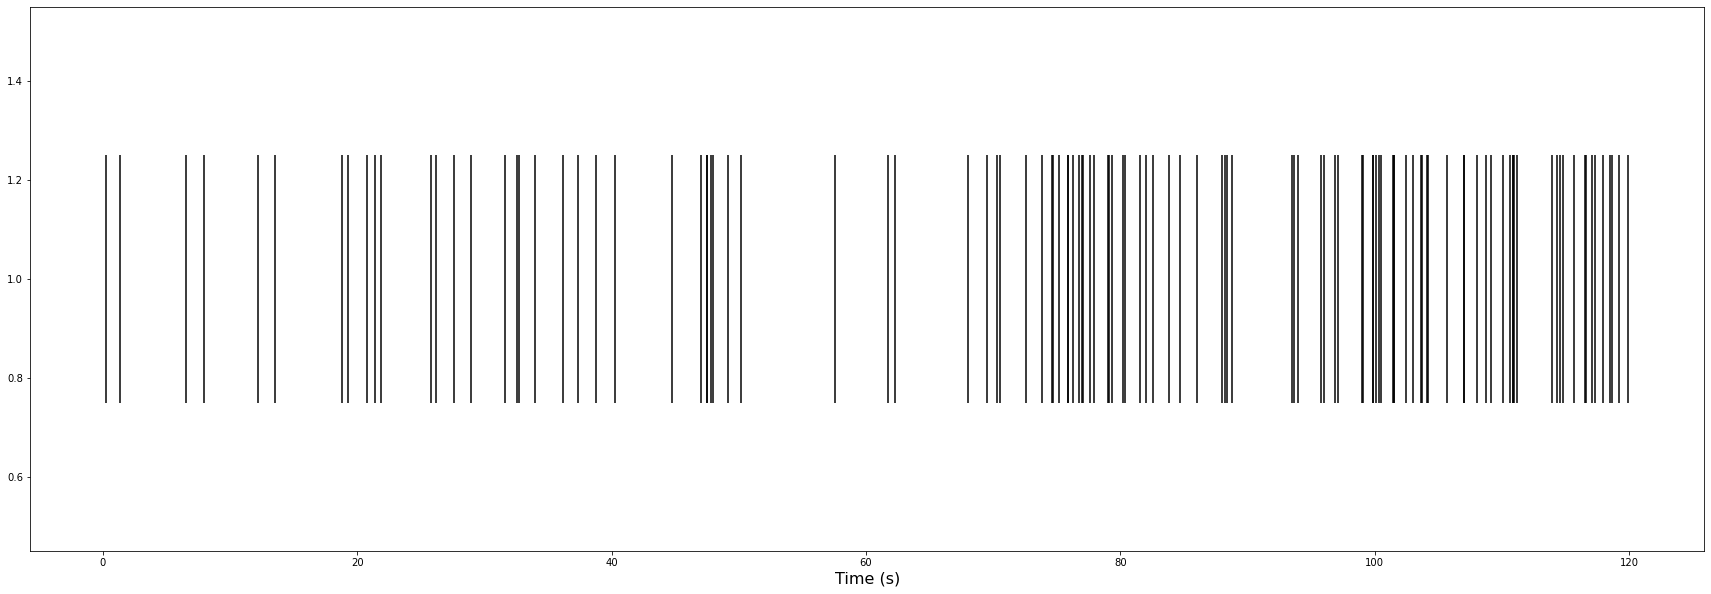

Text(0.5, 0, 'Time (s)')

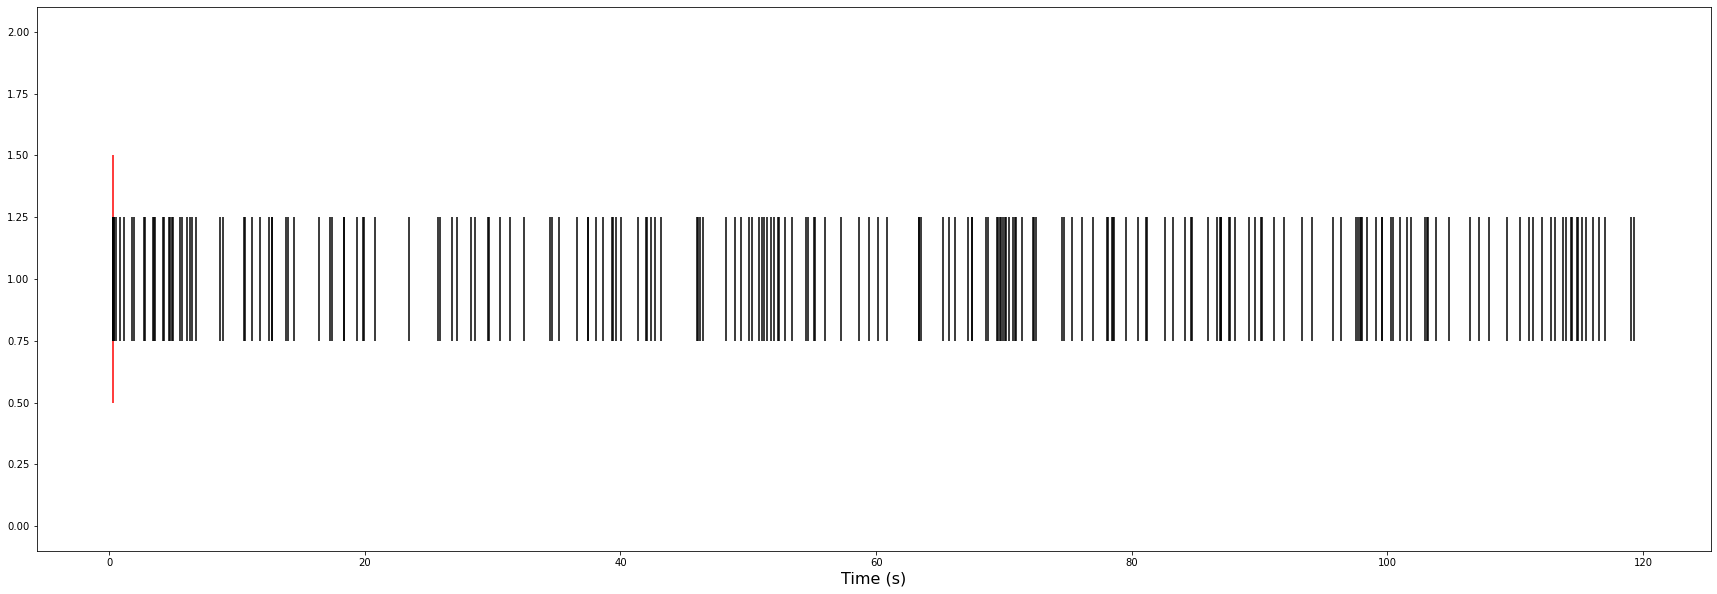

Text(0.5, 0, 'Time (s)')

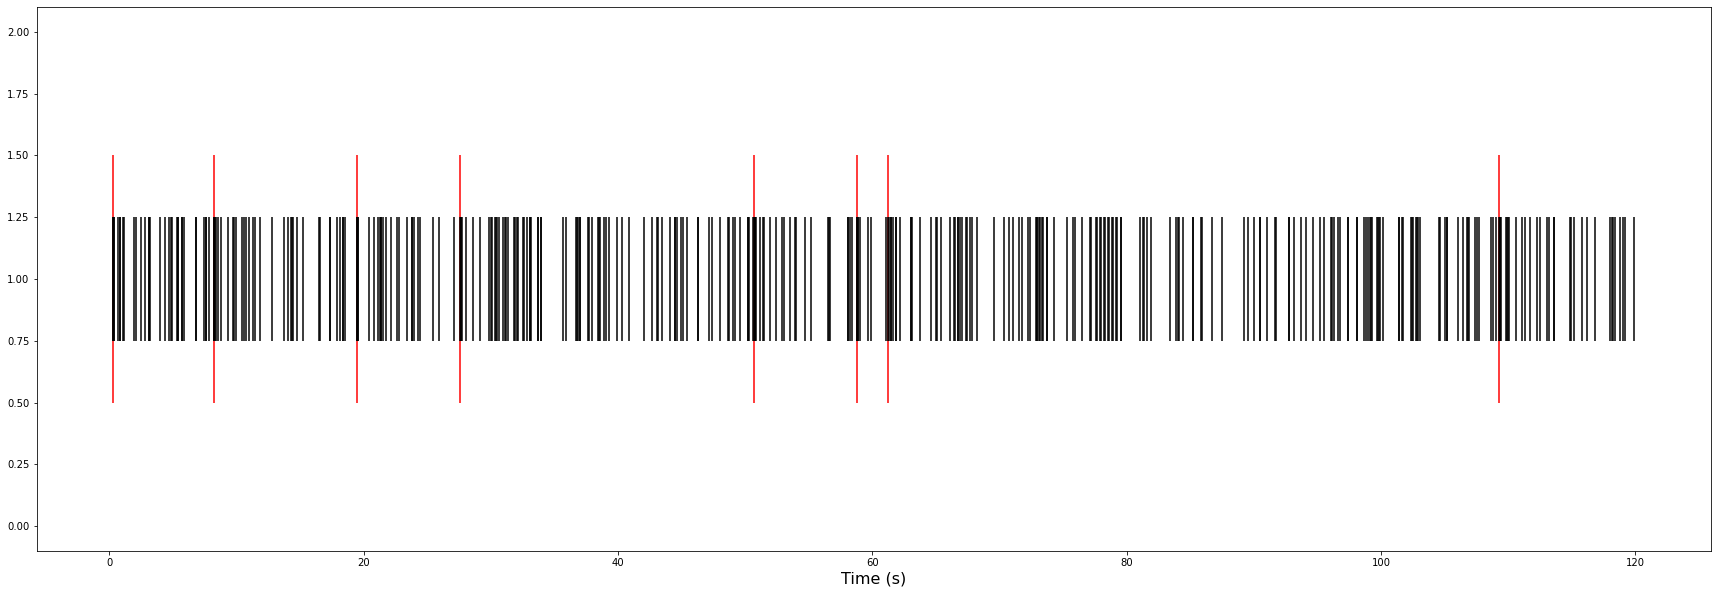

Text(0.5, 0, 'Time (s)')

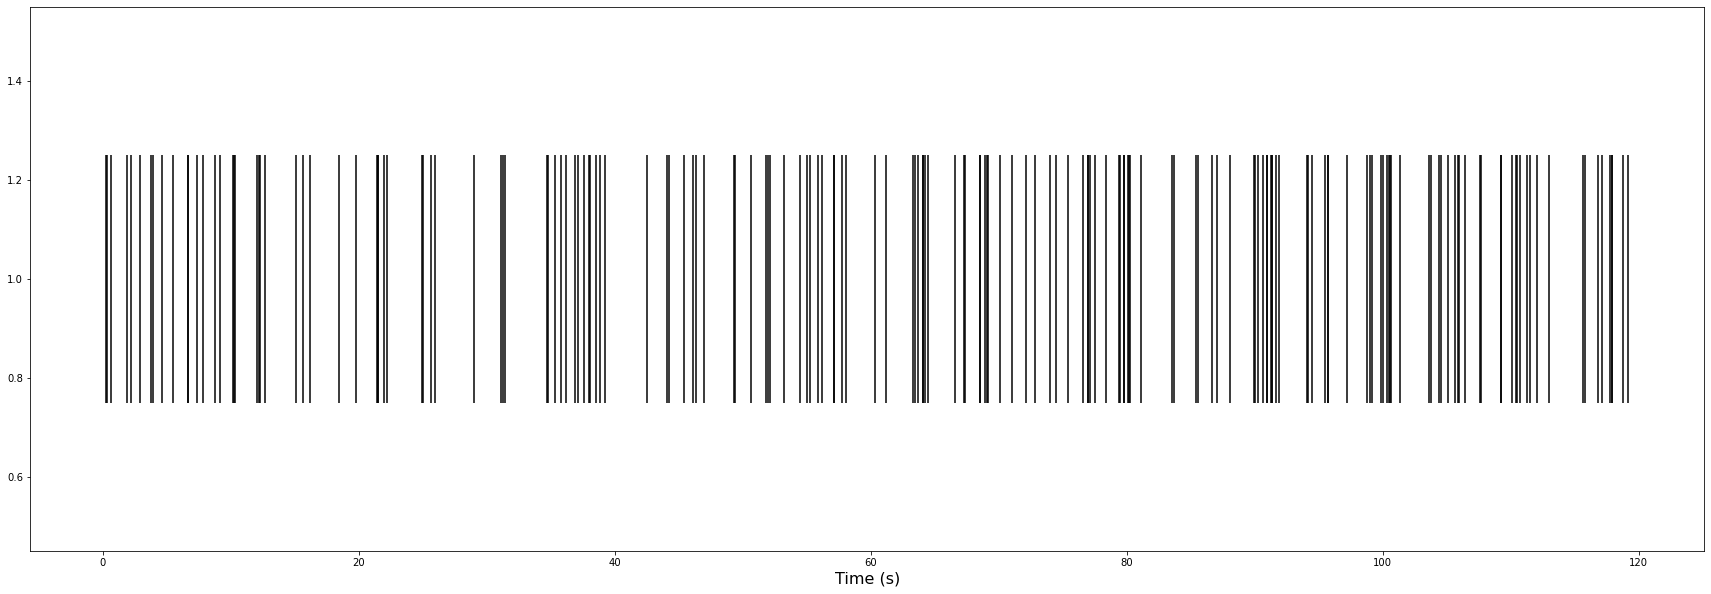

Text(0.5, 0, 'Time (s)')

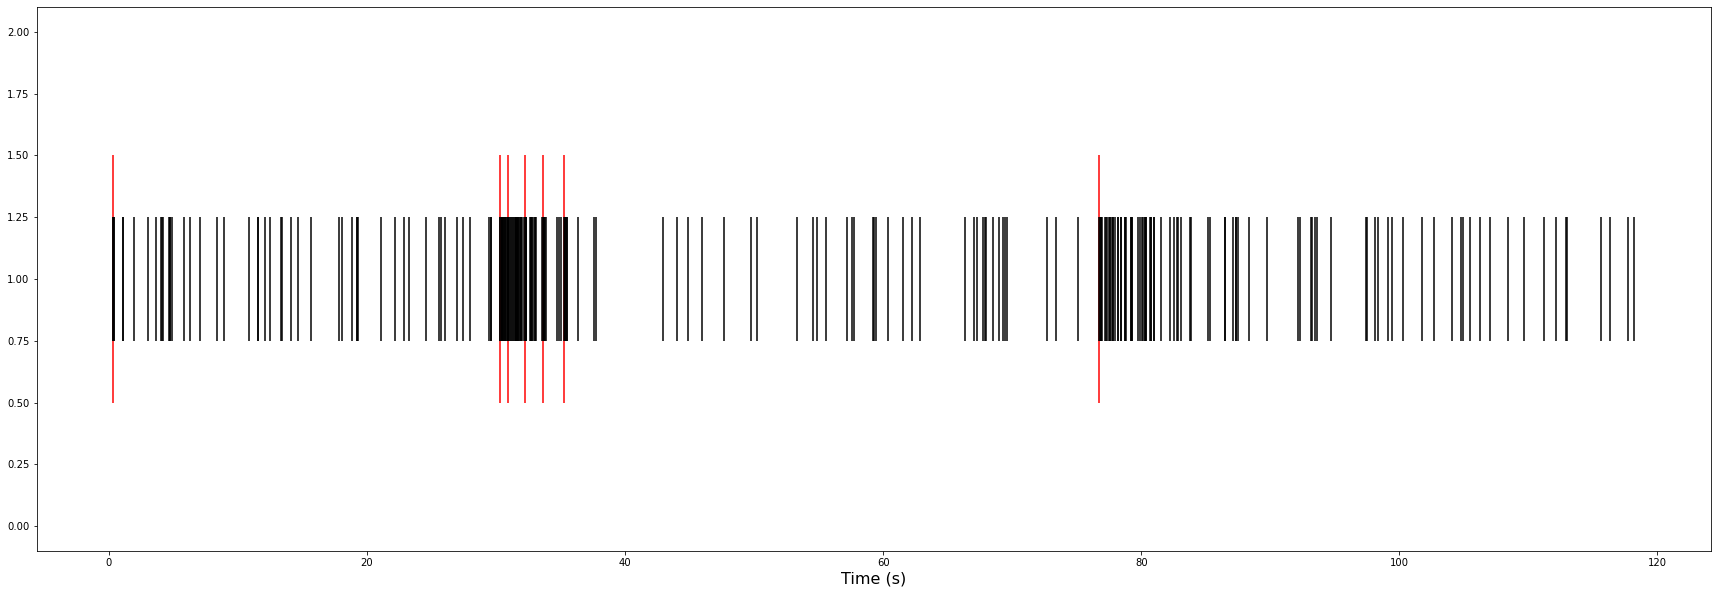

Text(0.5, 0, 'Time (s)')

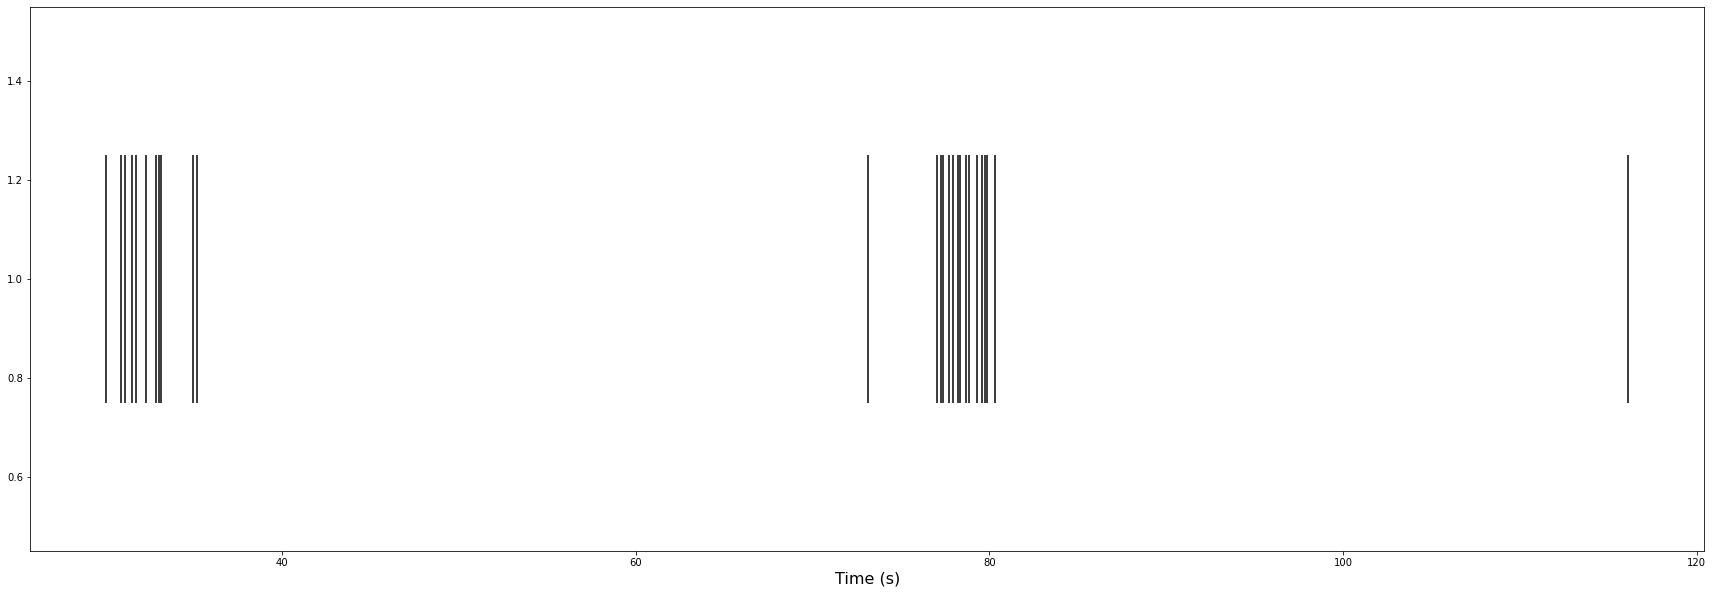

Text(0.5, 0, 'Time (s)')

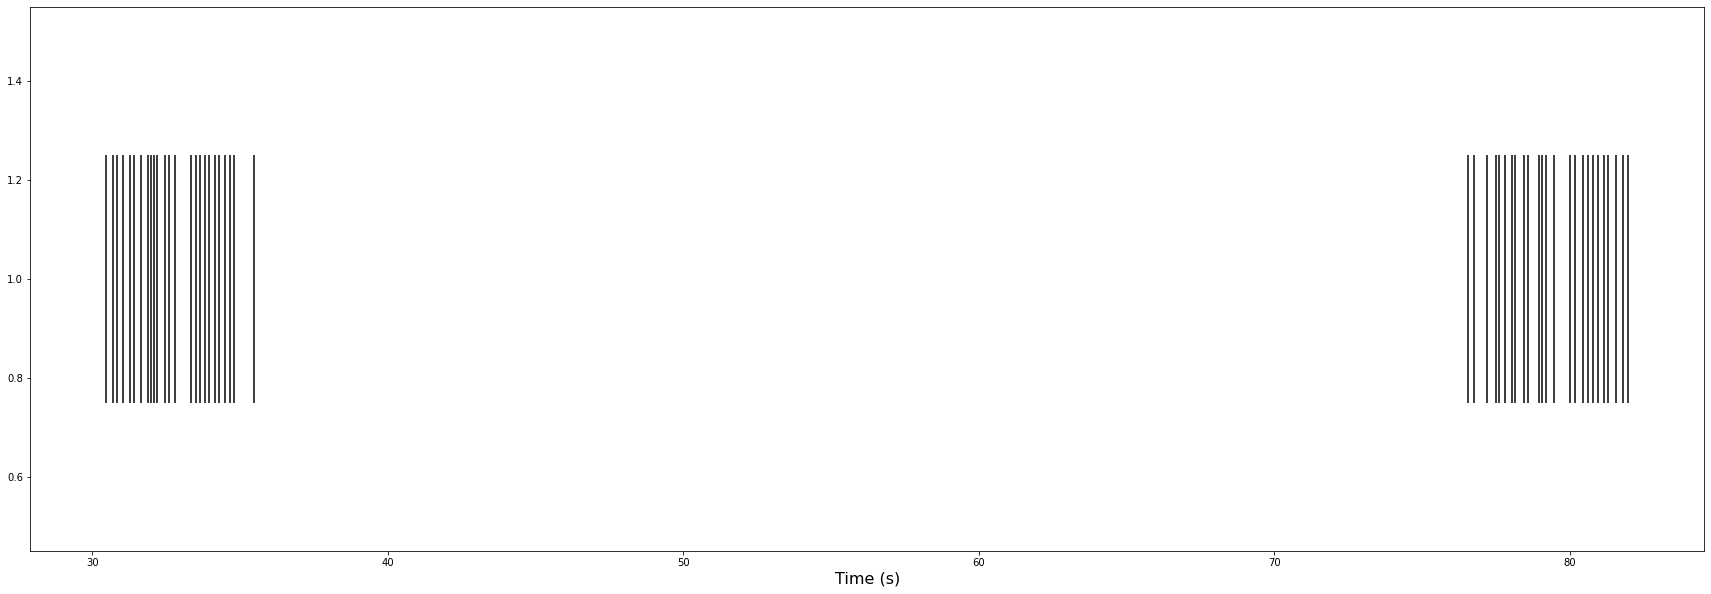

Text(0.5, 0, 'Time (s)')

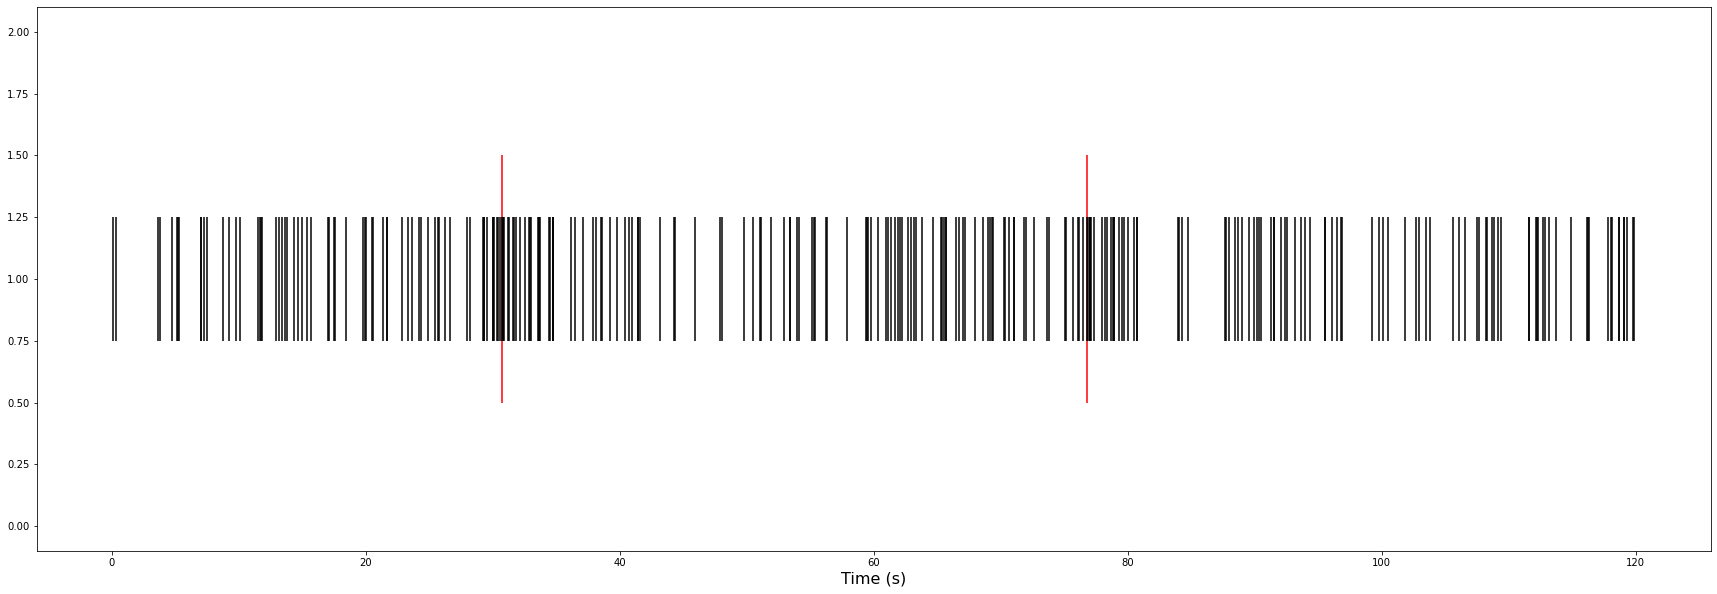

Text(0.5, 0, 'Time (s)')

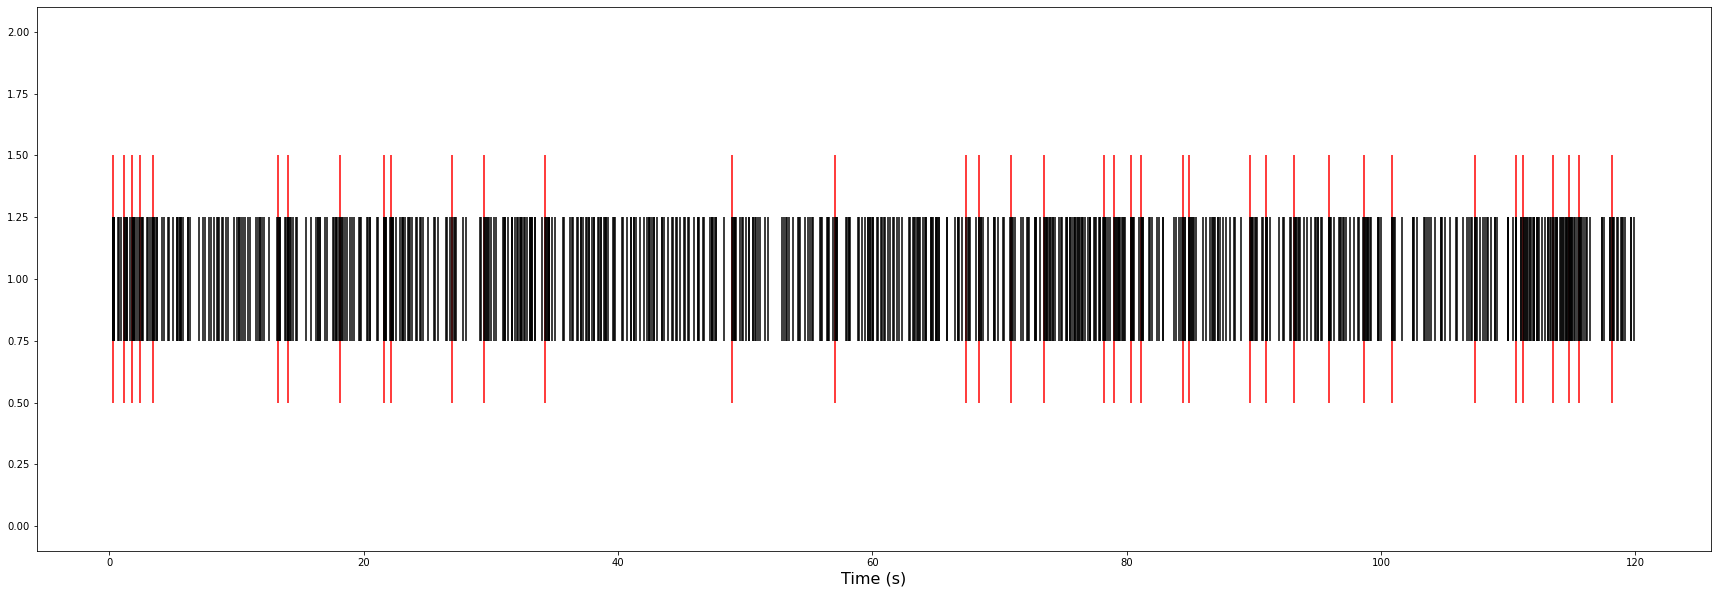

Text(0.5, 0, 'Time (s)')

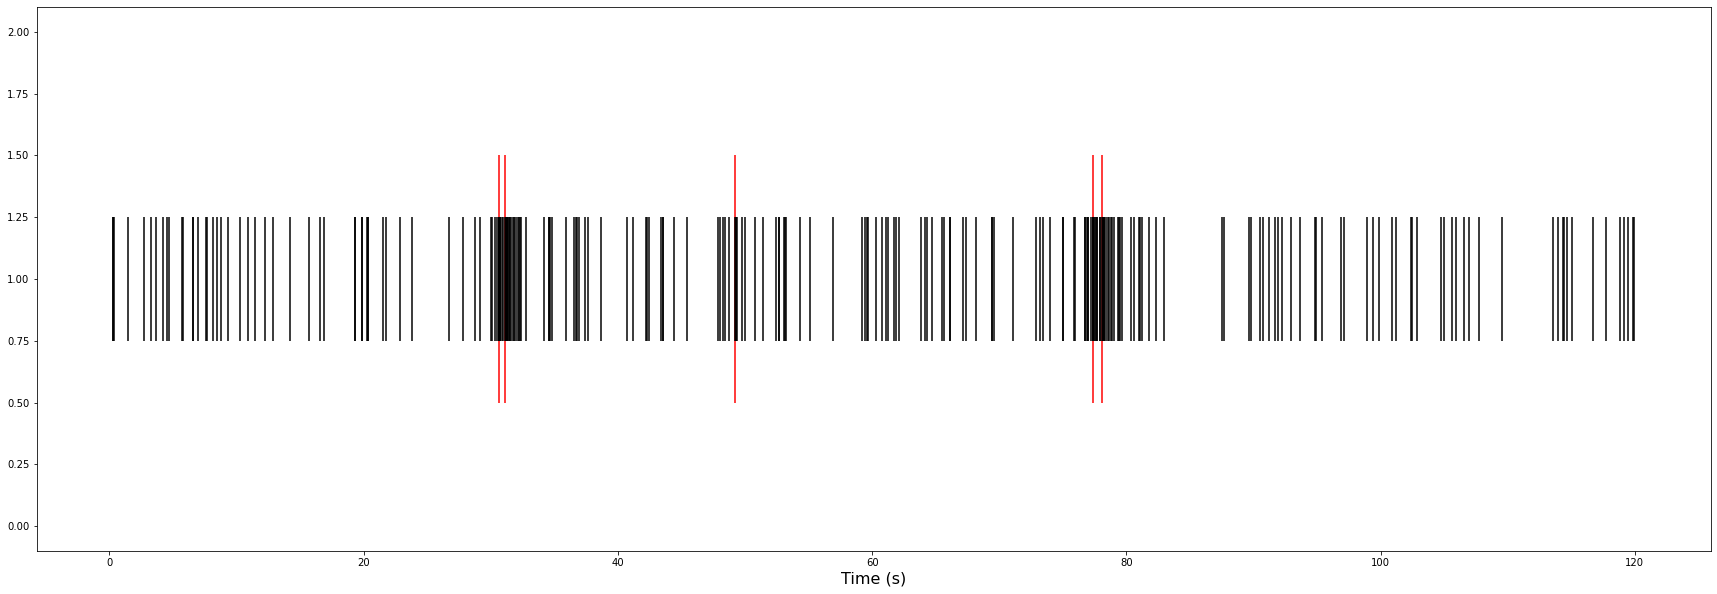

Text(0.5, 0, 'Time (s)')

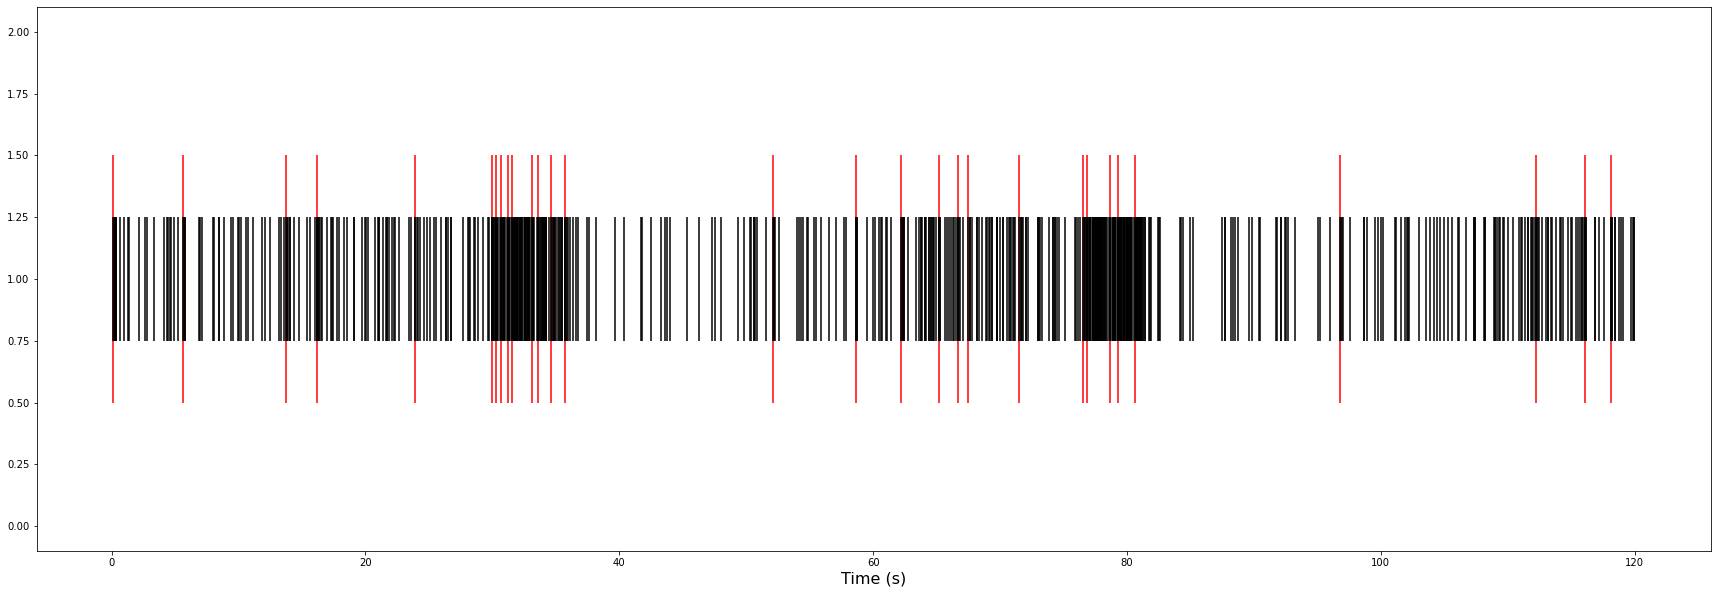

Text(0.5, 0, 'Time (s)')

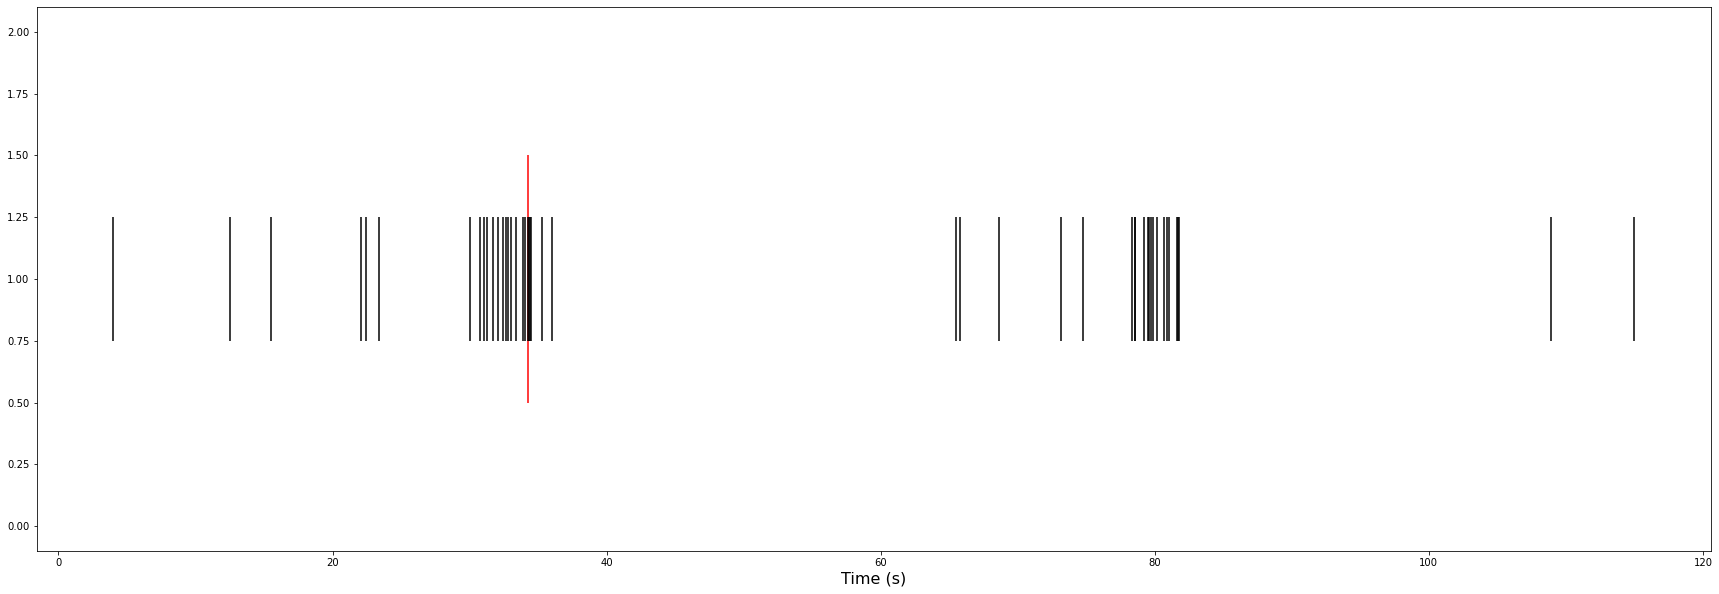

Text(0.5, 0, 'Time (s)')

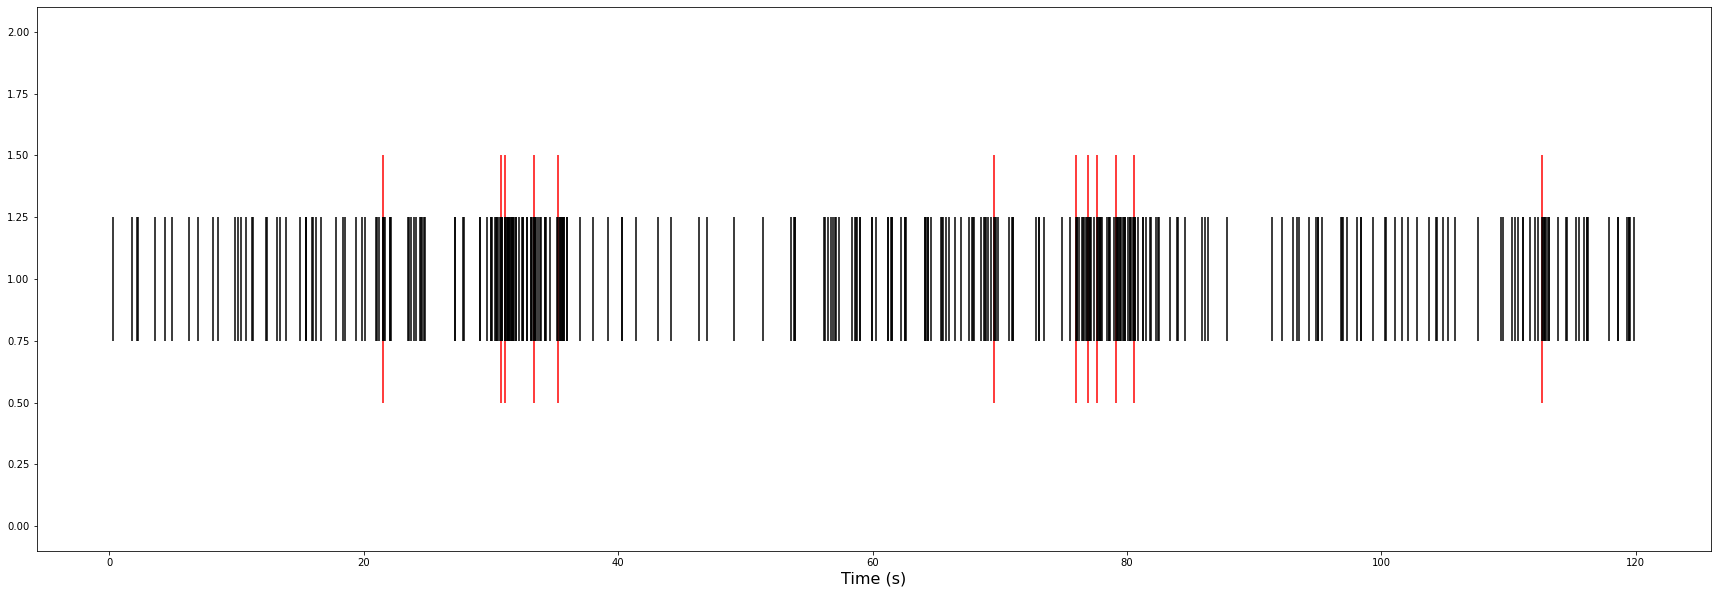

Text(0.5, 0, 'Time (s)')

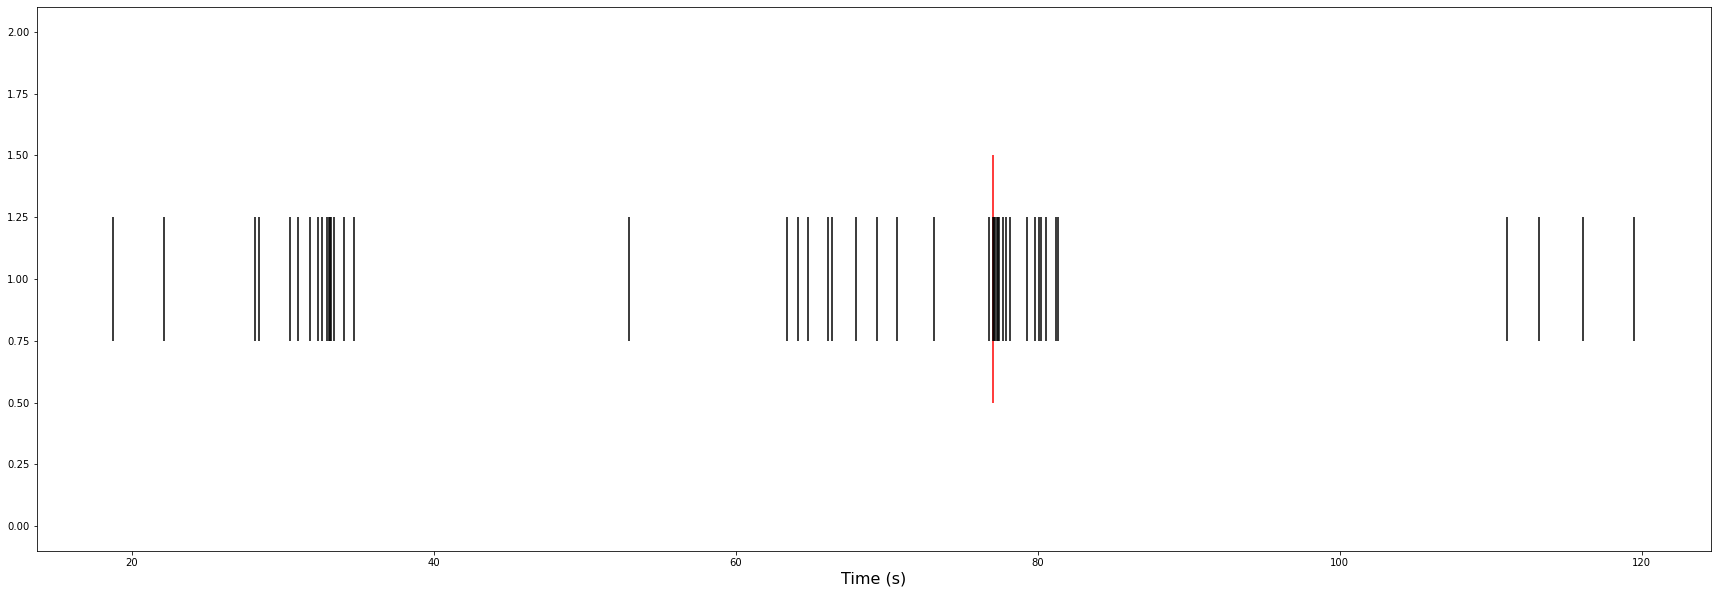

Text(0.5, 0, 'Time (s)')

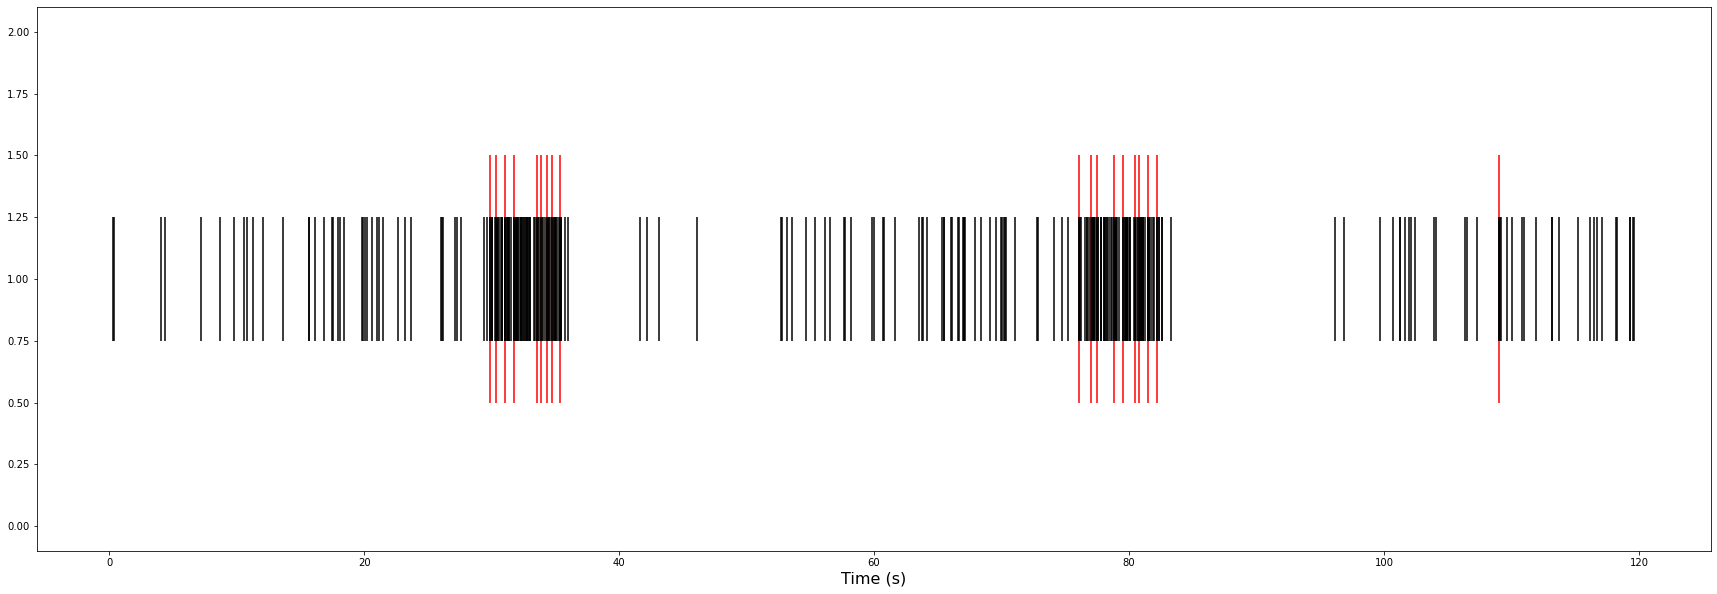

Text(0.5, 0, 'Time (s)')

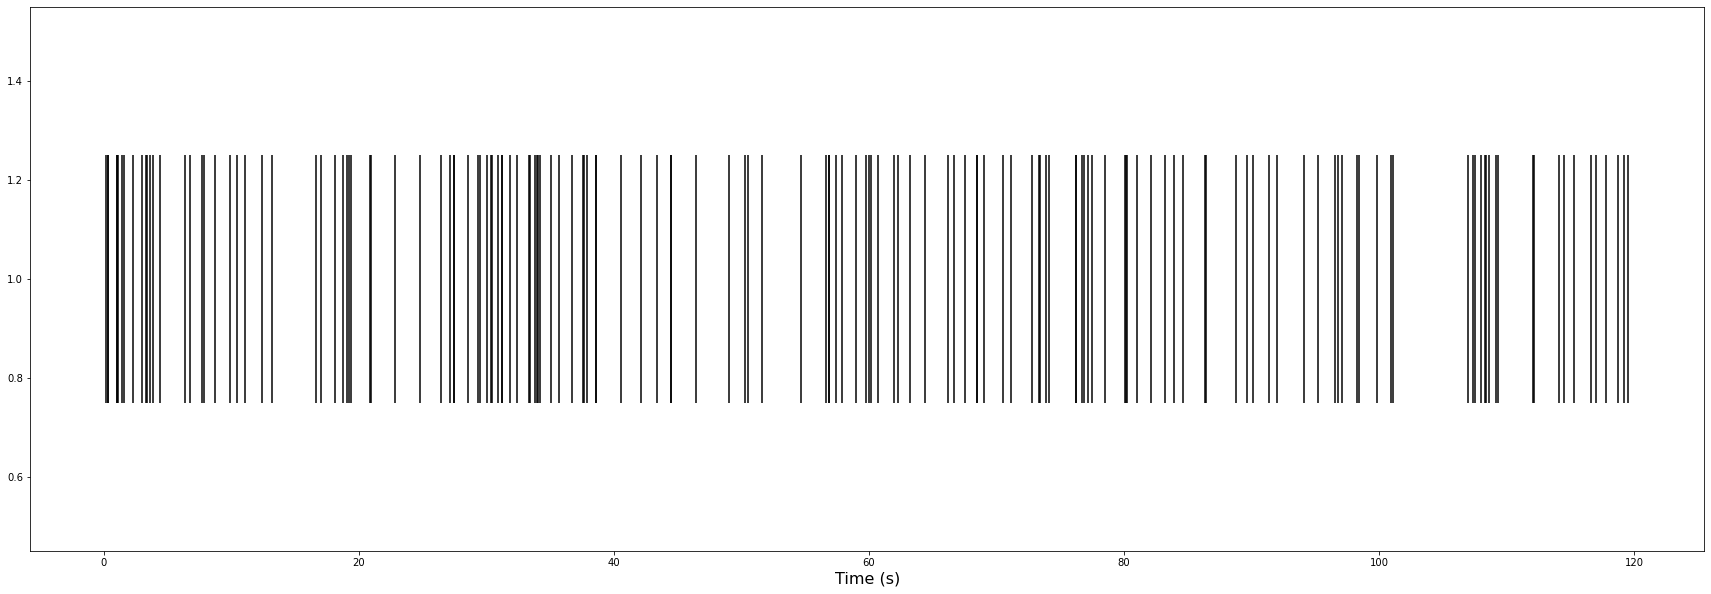

In [25]:
for key in burststartdic:

    array = np.array(st_neurons[key]).flatten()*40*scale_factor_for_second
    burststarts = np.array(burststartdic[key]).flatten()*scale_factor_for_second
    fig = plt.figure(figsize=(30, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.eventplot(burststarts, linelengths = 1.0, color='red')
    ax.eventplot(array, linelengths=0.5, color='black')
    #ax.eventplot(trigger_on_seconds, linelengths=0.75, color='blue')
    ax.set_xlabel('Time (s)', fontsize=16)
    #ax.set_title(filename+' Channel '+str(key) +' Burststarts')
#ax.set_ylabel('Channel % - Eventplot with burststarts' %str(key))
#ax.set_ylabel('Channel '+str(key) +' Burststarts')


    plt.show()
    #fig.savefig(str(filename) +'_burstplot_'+str(key)+'.png')
    #plt.close()

In [33]:
for key in burststart_end_dic:
    burststarts_array = []
    burstend_array = []
    for i in range(0, len(burststart_end_dic[key])):
        start = burststart_end_dic[key][i][0]*scale_factor_for_second
        end = burststart_end_dic[key][i][1]*scale_factor_for_second
        burststarts_array.append(start)
        burstend_array.append(end)

    array = np.array(st_neurons[key]).flatten()*40*scale_factor_for_second
    #burststarts = np.array(burststartdic[key]).flatten()*scale_factor_for_second
    fig = plt.figure(figsize=(30, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.eventplot(burststarts_array, linelengths = 1.0, color='#F27F1B')
    ax.eventplot(burstend_array, linelengths = 0.75, color='#04B2D9')
    ax.eventplot(array, linelengths=0.5, color='#260B01')
    #ax.eventplot(trigger_on_seconds, linelengths=0.75, color='blue')
    ax.set_xlabel('Time (s)', fontsize=16)
    #ax.set_title(filename+' Channel '+str(key) +' Burststarts')
#ax.set_ylabel('Channel % - Eventplot with burststarts' %str(key))
#ax.set_ylabel('Channel '+str(key) +' Burststarts')


    plt.show()
    #fig.savefig(str(filename) +'_burstplot_'+str(key)+'.png')
    #plt.close()

KeyError: 'O10'

In [32]:
burststart_end_dic

{0: [(96385480, 96667200)],
 1: [(10341800, 10618720),
  (29896520, 31234080),
  (62638920, 62780320),
  (68718360, 68759720),
  (85954120, 86372240),
  (90206680, 90864840),
  (96350040, 97077600),
  (113356120, 113820360)],
 2: [(68715800, 68763120)],
 3: [(68718920, 68773080)],
 10: [(78945480, 79123400)],
 11: [(29791400, 30502200), (30822000, 35744800), (76678640, 82794480)],
 12: [(29958920, 30057760),
  (30643120, 33172760),
  (34494560, 36027640),
  (76852880, 80292720)],
 13: [(31693320, 33473280), (34662280, 35070840), (76698760, 77087960)],
 7: [(30299960, 32244720),
  (32823200, 32890920),
  (33598720, 34095560),
  (77194280, 77447600),
  (77834800, 77977800),
  (79113920, 79817720),
  (80299240, 81146880),
  (81733200, 82118600)],
 8: [(171680, 355760),
  (22767320, 23467080),
  (30008520, 36456040),
  (60450600, 60969000),
  (63741960, 64071560),
  (70643880, 71140360),
  (76547320, 82467200),
  (112158200, 112539640)],
 9: [(13313320, 14209440),
  (29936560, 33421280),
 

For every channel:
1. get the time each unit is bursting -> can be used for heatmap
2. make dictionary for simultaneously bursting units
3. cluster together bursting spikes 
4. heatmap of bursts and detected spikes
5. function that extracts detected spikes from dataframe 

In [43]:
# for every unit, the whole time of bursts is calculated and put into a dictionary
bursting_time_per_unit_dic = {}
for key in burststart_end_dic:
    time = 0
    for i in burststart_end_dic[key]:
        bursttime = i[1] - i[0]
        time = time + bursttime
    bursting_time_per_unit_dic[key] = time*scale_factor_for_second # kein tick, vorher bereits drin

In [45]:
# for every unit, the whole time of bursts is calculated and put into a dictionary
bursts_per_unit_dic = {}
for key in burststart_end_dic:
    number_of_bursts = 0
    for i in burststart_end_dic[key]:
        number_of_bursts += 1
    bursts_per_unit_dic[key] = number_of_bursts

In [46]:
bursts_per_unit_dic

{0: 1,
 1: 8,
 2: 1,
 3: 1,
 10: 1,
 11: 3,
 12: 4,
 13: 3,
 7: 8,
 8: 8,
 9: 8,
 100: 6,
 101: 2,
 98: 2,
 99: 4,
 102: 6,
 103: 5,
 104: 32,
 105: 26,
 106: 20,
 107: 12,
 108: 0,
 109: 2,
 110: 3,
 111: 4,
 112: 1,
 113: 27,
 114: 0,
 115: 0,
 117: 6,
 116: 9,
 138: 8,
 139: 11,
 140: 4,
 141: 4,
 142: 9,
 143: 5,
 118: 2,
 35: 6,
 119: 4,
 120: 5,
 121: 4,
 122: 3,
 123: 2,
 124: 3,
 125: 10,
 126: 6,
 127: 0,
 128: 0,
 129: 38,
 130: 31,
 131: 3,
 132: 17,
 133: 1,
 134: 13,
 135: 2,
 136: 49,
 137: 23,
 14: 8,
 15: 0,
 16: 0,
 144: 1,
 145: 1,
 146: 0,
 147: 39,
 148: 30,
 149: 0,
 150: 14,
 151: 1,
 152: 4,
 153: 29,
 154: 22,
 155: 2,
 156: 18,
 157: 7,
 158: 2,
 159: 24,
 160: 7,
 161: 17,
 162: 20,
 163: 31,
 164: 61,
 165: 23,
 166: 1,
 167: 39,
 168: 9,
 169: 2,
 17: 11,
 170: 9,
 171: 7,
 172: 17,
 173: 6,
 174: 17,
 175: 7,
 176: 7,
 177: 1,
 178: 2,
 179: 0,
 180: 24,
 181: 5,
 18: 3,
 19: 23,
 20: 5,
 182: 50,
 183: 10,
 184: 0,
 185: 1,
 186: 14,
 187: 0,
 188: 23,
 18

In [62]:
keylist = list(burststart_end_dic.keys())

In [65]:
keylist.remove(1)

In [66]:
keylist

[0,
 2,
 3,
 10,
 11,
 12,
 13,
 7,
 8,
 9,
 100,
 101,
 98,
 99,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 117,
 116,
 138,
 139,
 140,
 141,
 142,
 143,
 118,
 35,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 14,
 15,
 16,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 17,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 18,
 19,
 20,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 195,
 196,
 197,
 198,
 199,
 200,
 201,
 202,
 203,
 204,
 205,
 206,
 207,
 208,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 36,
 37,
 38,
 39,
 4,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 5,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 6,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,


In [ ]:
burst

In [56]:
trial

In [90]:
burst_connections_dic = {}
helper_dic = {}
number
for key in burststart_end_dic:
    other_keys = list(burststart_end_dic.keys())
    other_keys.remove(key)
    connected_unit_list = []
    number_of_bursts = 0
    for i in burststart_end_dic[key]:
        start, end = i[0], i[1]
        for j in other_keys:
            for m in burststart_end_dic[j]:
                other_start = m[0]
                if (other_start > start) & (other_start < end):
                    number_of_bursts += 1
                    connected_unit_list.append(j)
    burst_connections_dic[key] = np.unique(connected_unit_list)
        
        


In [221]:
# this function takes the dictionary with every burst start and stop and returns a dictionary
# where every unit is a key and the values are tuples consisting of keys of connected units (i.e., bursting together)
# and the number of shared bursts


burst_connections_dic = {}


for key in burststart_end_dic:
    other_keys = list(burststart_end_dic.keys())
    other_keys.remove(key)
    connected_unit_list = []
    for j in other_keys:
        number_of_bursts = 0
        time_shared = 0
        for i in burststart_end_dic[key]:
            start, end = i[0], i[1]
            for m in burststart_end_dic[j]:
                other_start = m[0]
                other_end = m[1]
                if (other_start > start) & (other_start < end):
                    if other_end >= end:
                        time_shared = time_shared + (end - other_start)
                    else:
                        time_shared = time_shared + (other_end - other_start)
                    number_of_bursts += 1
                    
        if number_of_bursts > 0:
            connected_unit_list.append((j, number_of_bursts, time_shared*scale_factor_for_second))        
    burst_connections_dic[key] = connected_unit_list
        
        


In [222]:
burst_connections_dic

{0: [(165, 1, 0.15824), (182, 1, 0.26796), (189, 1, 0.1146), (31, 1, 0.0998)],
 1: [(0, 1, 0.28171999999999997),
  (3, 1, 0.040799999999999996),
  (11, 1, 0.41208),
  (12, 2, 0.6898),
  (7, 1, 0.93412),
  (8, 1, 1.22556),
  (9, 1, 1.29752),
  (100, 1, 1.2206),
  (101, 1, 0.532),
  (98, 1, 0.86832),
  (99, 1, 1.20064),
  (103, 1, 0.82524),
  (104, 1, 0.42428),
  (106, 2, 0.20423999999999998),
  (110, 1, 0.57628),
  (111, 1, 0.85456),
  (112, 1, 0.73852),
  (113, 1, 1.17092),
  (116, 1, 0.8415199999999999),
  (138, 2, 0.61508),
  (139, 1, 1.20032),
  (141, 1, 1.19096),
  (142, 2, 0.8609199999999999),
  (35, 1, 0.31828),
  (120, 1, 0.63468),
  (121, 1, 1.20796),
  (122, 1, 1.20352),
  (124, 1, 1.19668),
  (125, 1, 1.21992),
  (126, 1, 1.1909999999999998),
  (129, 1, 0.05696),
  (130, 1, 0.21344),
  (135, 1, 1.1578),
  (136, 2, 1.3014),
  (137, 1, 0.36612),
  (14, 1, 0.12491999999999999),
  (147, 1, 0.1852),
  (148, 1, 0.17279999999999998),
  (155, 1, 1.1985599999999998),
  (156, 1, 0.6216

In [255]:
shared_frame = pd.DataFrame(index=unit_ids_for_frame, columns=unit_ids_for_frame)

In [256]:
shared_frame

0    1    10   100  101  102  103  104  105  106  ...  90   91   92   \
0    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
1    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
10   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
100  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
101  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
95   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
96   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
97   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
98   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
99   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   

     93   94   95   96   97   98   99   
0    NaN  NaN  NaN  NaN  NaN  NaN  NaN  
1    NaN  NaN  NaN  NaN  NaN  NaN  NaN  
10   NaN  NaN  NaN  NaN  NaN  NaN  NaN  
100  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
101  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
..   ...  ...  ...  ...  ...  ...  ...  
95   NaN  NaN  NaN  NaN  NaN  NaN  NaN  
96   NaN  NaN  NaN  NaN  NaN  NaN  NaN  
97   NaN  NaN  NaN  NaN  NaN  NaN  NaN  
98   NaN  NaN  NaN  NaN  NaN  NaN  NaN  
99   NaN  NaN  NaN  NaN  NaN  NaN  NaN  

[209 rows x 209 columns]

In [260]:
pivot = pd.pivot_table(index=unit_ids_for_frame, columns=unit_ids_for_frame, data=frame_array)

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [226]:
#completeframe.loc['unit_ids_2']=completeframe['unit_ids']

KeyError: 'unit_ids'

In [250]:
completeframe.head()

unit_ids  unit_index  max_channel channellabel  n_spikes  firing_rate  \
0         0         0.0          0.0          R12     123.0     1.025000   
1         1         1.0         10.0           R4     219.0     1.825001   
2        10         2.0        182.0          F11      21.0     0.175000   
3       100         3.0        206.0          D12     154.0     1.283334   
4       101         4.0        206.0          D12      22.0     0.183333   

      layer  ft_peak_to_valley  ft_halfwidth  ft_peak_trough_ratio  ...  \
0    layer4            0.00028       0.00016             -0.221239  ...   
1  layer2-3            0.00064       0.00020             -0.116071  ...   
2  layer5-6            0.00060       0.00028             -0.106383  ...   
3  layer5-6            0.00104       0.00032             -0.153846  ...   
4  layer5-6            0.00128       0.00044             -0.287500  ...   

   ft_recovery_slope  qm_firing_rate  qm_isi_violation  qm_amplitude_cutoff  \
0          -0.002170        1.025000          0.000000             0.002104   
1          -0.002202        1.825001          2.535843             0.001182   
2          -0.010927        0.175000          0.000000             0.012323   
3          -0.002087        1.283334          1.709417             0.414959   
4          -0.002030        0.183333          0.000000             0.012002   

   qm_presence_ratio    qm_snr         file subrecording recordingdate  \
0               0.74  3.815127  spontaneous    sec_0-120    17.10.2019   
1               0.90  4.106966  spontaneous    sec_0-120    17.10.2019   
2               0.07  6.900513  spontaneous    sec_0-120    17.10.2019   
3               0.28  4.733220  spontaneous    sec_0-120    17.10.2019   
4               0.08  7.281877  spontaneous    sec_0-120    17.10.2019   

  unit_ids2  
0         0  
1         1  
2        10  
3       100  
4       101  

[5 rows x 21 columns]

In [253]:
unit_ids_for_frame = list(completeframe['unit_ids'])

In [254]:
unit_ids_for_frame

[0,
 1,
 10,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 11,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 12,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 13,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 14,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 15,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 16,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 17,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 18,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 19,
 190,
 191,
 192,
 193,
 194,
 195,
 196,
 197,
 198,
 199,
 2,
 20,
 200,
 201,
 202,
 203,
 204,
 205,
 206,
 207,
 208,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 3,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 4,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 5,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 6,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 7,
 70,
 71,
 72,

In [231]:
shared_frame.fillna(0)

unit_ids2  0    1    10   100  101  102  103  104  105  106  ...  90   91   \
unit_ids                                                     ...             
0            0    0    0    0    0    0    0    0    0    0  ...    0    0   
1            0    0    0    0    0    0    0    0    0    0  ...    0    0   
10           0    0    0    0    0    0    0    0    0    0  ...    0    0   
100          0    0    0    0    0    0    0    0    0    0  ...    0    0   
101          0    0    0    0    0    0    0    0    0    0  ...    0    0   
...        ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
95           0    0    0    0    0    0    0    0    0    0  ...    0    0   
96           0    0    0    0    0    0    0    0    0    0  ...    0    0   
97           0    0    0    0    0    0    0    0    0    0  ...    0    0   
98           0    0    0    0    0    0    0    0    0    0  ...    0    0   
99           0    0    0    0    0    0    0    0    0    0  ...    0    0   

unit_ids2  92   93   94   95   96   97   98   99   
unit_ids                                           
0            0    0    0    0    0    0    0    0  
1            0    0    0    0    0    0    0    0  
10           0    0    0    0    0    0    0    0  
100          0    0    0    0    0    0    0    0  
101          0    0    0    0    0    0    0    0  
...        ...  ...  ...  ...  ...  ...  ...  ...  
95           0    0    0    0    0    0    0    0  
96           0    0    0    0    0    0    0    0  
97           0    0    0    0    0    0    0    0  
98           0    0    0    0    0    0    0    0  
99           0    0    0    0    0    0    0    0  

[209 rows x 209 columns]

In [232]:
shared_frame.columns

Int64Index([  0,   1,  10, 100, 101, 102, 103, 104, 105, 106,
            ...
             90,  91,  92,  93,  94,  95,  96,  97,  98,  99],
           dtype='int64', name='unit_ids2', length=209)

In [257]:
for row in shared_frame:
    for conncected_unit in burst_connections_dic[row]:
        other_unit = conncected_unit[0]
        shared_burst_time = conncected_unit[2]
        shared_frame.loc[row, other_unit] = shared_burst_time

In [258]:
shared_frame.fillna(0)

0        1        10       100      101  102      103      104  \
0    0.00000  0.00000  0.00000  0.00000  0.00000  0.0  0.00000  0.00000   
1    0.28172  0.00000  0.00000  1.22060  0.53200  0.0  0.82524  0.42428   
10   0.00000  0.00000  0.00000  0.00000  0.00000  0.0  0.00000  0.00000   
100  0.00000  0.00000  0.00000  0.00000  0.94248  0.0  2.91716  0.82780   
101  0.00000  0.00000  0.00000  0.00000  0.00000  0.0  0.52844  0.00000   
..       ...      ...      ...      ...      ...  ...      ...      ...   
95   0.00000  0.00000  0.00000  0.00000  0.41048  0.0  0.00000  0.23476   
96   0.00000  1.33756  0.17792  5.69328  0.94248  0.0  2.87720  1.58672   
97   0.00000  0.00000  0.00000  0.00000  0.00000  0.0  0.00000  0.00000   
98   0.00000  0.00000  0.00000  1.56168  0.89972  0.0  1.08816  0.23476   
99   0.00000  0.00000  0.17792  1.11748  0.94248  0.0  2.55940  0.53184   

         105      106  ...      90       91       92       93       94   \
0    0.00000  0.00000  ...  0.00000  0.00000  0.00000  0.00000  0.00000   
1    0.00000  0.20424  ...  0.63628  1.19444  0.11508  0.00000  1.04204   
10   0.00000  0.00000  ...  0.04436  0.00000  0.00000  0.00000  0.00000   
100  0.40300  0.83468  ...  3.21960  4.35348  0.00000  1.05244  2.65024   
101  0.00000  0.00000  ...  0.34304  0.00000  0.00000  0.00000  0.52440   
..       ...      ...  ...      ...      ...      ...      ...      ...   
95   0.00000  0.00000  ...  0.44032  0.00000  0.00000  0.00000  0.03728   
96   0.66464  0.83468  ...  3.76916  4.63224  0.12552  0.98764  3.00456   
97   0.00000  0.00000  ...  0.00000  0.00000  0.00000  0.00000  0.00000   
98   0.00000  0.00000  ...  0.80356  2.40312  0.00000  0.00000  0.48164   
99   0.93520  0.09460  ...  2.52780  2.03464  0.00000  0.74528  2.87800   

         95       96   97       98       99   
0    0.00000  0.00000    0  0.00000  0.00000  
1    0.00000  0.00000    0  0.86832  1.20064  
10   0.00000  0.00000    0  0.00000  0.00000  
100  0.99484  1.27332    0  0.86832  4.29484  
101  0.00000  0.00000    0  0.00000  0.00000  
..       ...      ...  ...      ...      ...  
95   0.00000  0.00000    0  0.00000  0.00000  
96   0.90184  0.00000    0  2.45280  5.28072  
97   0.00000  0.00000    0  0.00000  0.00000  
98   0.90184  0.00000    0  0.00000  2.37248  
99   0.90184  0.46832    0  0.00000  0.00000  

[209 rows x 209 columns]

In [263]:
corr = shared_frame.pd.corr()

AttributeError: 'DataFrame' object has no attribute 'pd'

In [275]:
df = pd.DataFrame(abs(frame_array), columns=unit_ids_for_frame, index=unit_ids_for_frame)

In [278]:
df = df.fillna(0)

In [287]:
corr_mat = df.corr().stack().reset_index(name="correlation")

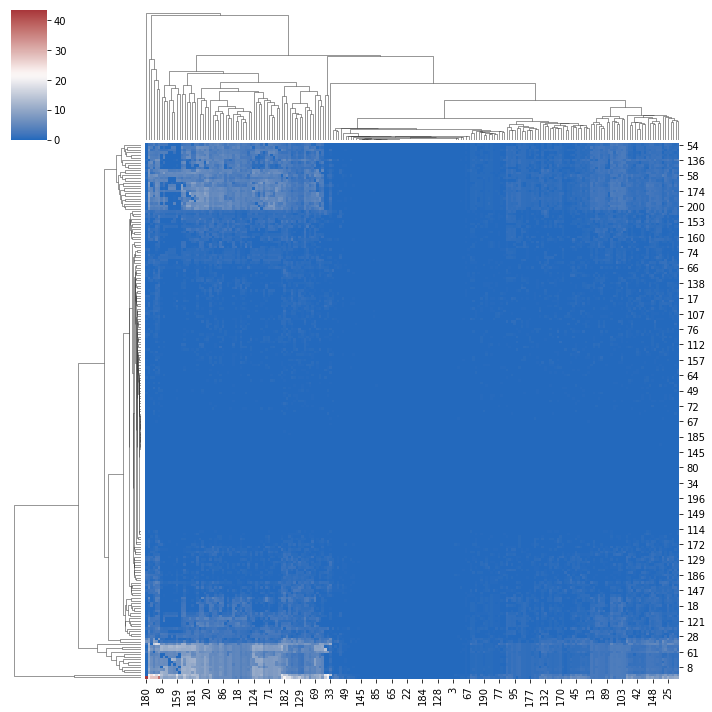

In [296]:
sns.clustermap(df, cmap="vlag")

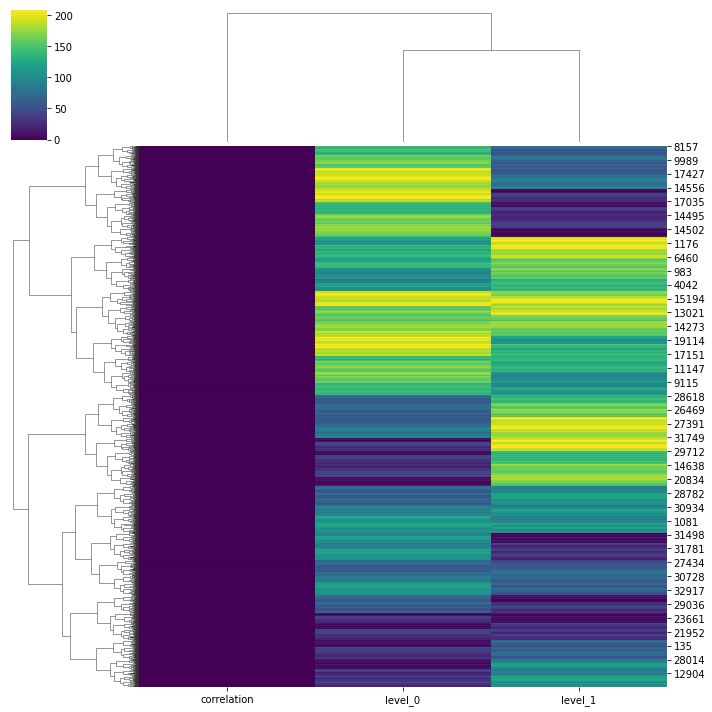

In [288]:
#ig, ax = plt.subplots()
sns.clustermap(corr_mat, cmap='viridis')

AttributeError: 'FacetGrid' object has no attribute 'legend'

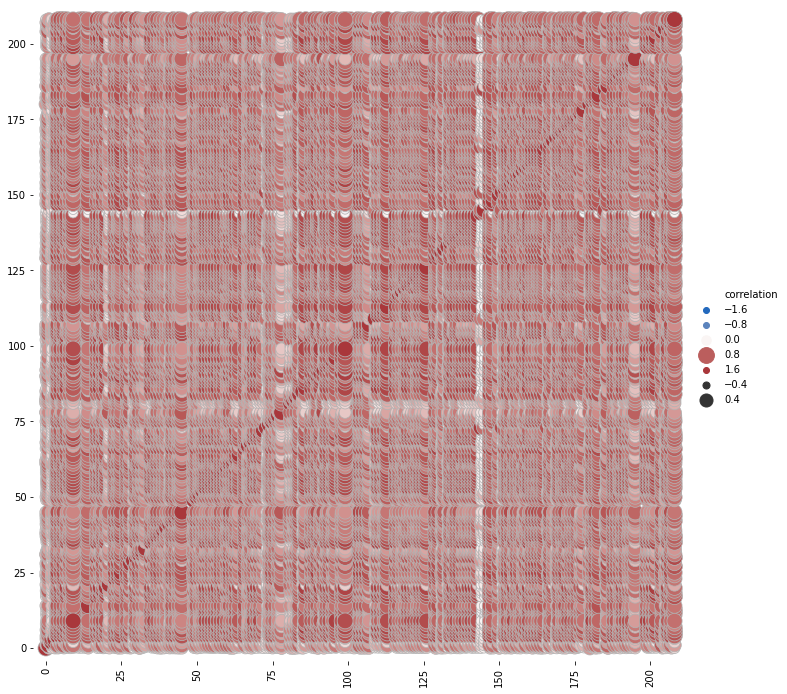

In [293]:
#sns.set_theme(style="whitegrid")

g = sns.relplot(
    data=corr_mat,
    x="level_0", y="level_1", hue="correlation", size="correlation",
    palette="vlag", hue_norm=(-1, 1), edgecolor=".7",
    height=10, sizes=(50, 250), size_norm=(-.2, .8),
)


g.set(xlabel="", ylabel="", aspect="equal")
g.despine(left=True, bottom=True)
g.ax.margins(.02)
for label in g.ax.get_xticklabels():
    label.set_rotation(90)
for artist in g.legend.legendHandles:
    artist.set_edgecolor(".7")

In [236]:
pivot = pd.pivot_table(frame_array, index=completeframe['unit_ids'], columns=completeframe['unit_ids2'])

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

TypeError: Cannot cast array data from dtype('O') to dtype('int64') according to the rule 'safe'

AttributeError: 'NoneType' object has no attribute 'reshape'

<Figure size 432x288 with 2 Axes>